In [1]:
#!/usr/bin/python
'''
Evaluate how well solutions match when run multiple times, with varying sample size
'''
import sys
import os
import fnmatch
import numpy as np
from metient.util.vertex_labeling_util import LabeledTree
from metient.util.globals import *
from metient.util import eval_util as eutil

import re
import pickle

REPO_DIR = os.path.join(os.getcwd(), "../")

DATE = "03282024"
PARAMS = "calibrate_wip_more_calibrate_iters"
# plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
pc_map = {'mS':0, 'pS': 1, 'mM': 2, 'pM': 3, 'mR': 4, 'pR': 5}

from statannot import add_stat_annotation


/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


CUDA GPU: False


<Figure size 640x480 with 0 Axes>

In [2]:
import gzip

metient_results_dir = '/data/morrisq/divyak/data/metient_prediction_results/'

def get_num_mut_trees(mut_tree_fn):
    with open(mut_tree_fn, 'r') as f:
        # look for line w/ "3 #trees" as an example
        for line in f:
            if  "#trees" in line:
                return int(line.strip().split()[0])    

def get_pckl_info(bs, run, site, mig_type, seed, tree_num, topk):
    prediction_dir = os.path.join(metient_results_dir, f'predictions_batch_exp_bs{bs}_{PARAMS}_r{run}_{DATE}')
    predicted_site_mig_type_data_dir = os.path.join(prediction_dir, site, mig_type)
    
    with gzip.open(os.path.join(predicted_site_mig_type_data_dir, f"tree{tree_num}_seed{seed}_calibrate.pkl.gz"), "rb") as f:
        pckl = pickle.load(f)
    Vs = pckl[OUT_LABElING_KEY]
    k = topk if len(Vs) >= topk else len(Vs)
    Vs = Vs[:k]
    As = pckl[OUT_ADJ_KEY][:k]
    losses = pckl[OUT_LOSSES_KEY][:k]
    return Vs, As, losses

def get_rank_to_percent_runs(solution_to_losses, run_num_to_solutions):
       
    # get the avg loss across runs for each solution
    for solution in solution_to_losses:
        solution_to_losses[solution] = sum(solution_to_losses[solution])/len(solution_to_losses[solution])
    solution_losses_list = [(k,v) for k,v in solution_to_losses.items()]
    solution_losses_list = sorted(solution_losses_list, key=lambda x: x[1])
    #print(solution_losses_list)
    rank_to_percent_runs = {}
    # What % of runs get the solution as a function of the rank on the joined list?
    for rank, (soln,_) in enumerate(solution_losses_list):
        rank_to_percent_runs[rank] = []
        for run in run_num_to_solutions:
            if soln in run_num_to_solutions[run]:
                rank_to_percent_runs[rank].append(run)
    print(rank_to_percent_runs)
    rank_to_percent_runs = {rank:(len(rank_to_percent_runs[rank])/num_runs) for rank in rank_to_percent_runs}
    return rank_to_percent_runs

In [3]:
from tqdm import tqdm
import torch

topk = 5 # how many of the top solutions to check for 
num_runs = 5

sites = ["m8", "m5"]

mig_types = ["M", "mS", "R", "S"]
batch_sizes = [64, 256, 1024]

print(f"matching top {topk} solutions")

m5_bs_to_rank_to_percentages = {}
m8_bs_to_rank_to_percentages = {}
all_sites_bs_to_rank_to_percentages = {}

sims_dir = os.path.join(REPO_DIR, "data/machina_sims")

for bs in batch_sizes:
    print("batch size:", bs)
    m5_bs_to_rank_to_percentages[bs] = {}
    m8_bs_to_rank_to_percentages[bs] = {}
    all_sites_bs_to_rank_to_percentages[bs] = {}
    for site in sites:
        for mig_type in mig_types:
            # Get all seeds for mig_type + site combo
            site_mig_type_dir = os.path.join(sims_dir, site, mig_type)
            seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
            seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
            for seed in tqdm(seeds):
                # Get all the clone trees for this seed
                num_trees = get_num_mut_trees(os.path.join(sims_dir, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt"))
                for tree_num in range(num_trees):
                    # across all the runs for this mig_type + site + seed + clone tree combo, 
                    # get the union of all solutions
                    solution_to_losses = {}
                    run_num_to_solutions = {}
                    for run in range(1,num_runs+1):
                        Vs, As, losses = get_pckl_info(bs, run, site, mig_type, seed, tree_num, topk)
                        run_num_to_solutions[run] = []
                        print(site, mig_type, seed, tree_num, run)
                        for V,A,loss in zip(Vs, As, losses):
                            V = torch.tensor(V)
                            A = torch.tensor(A)
                            tree = LabeledTree(A, V)                            
                            if tree not in solution_to_losses:
                                solution_to_losses[tree] = []
                            solution_to_losses[tree].append(loss)
                            run_num_to_solutions[run].append(tree)
                    rank_to_percent_runs = get_rank_to_percent_runs(solution_to_losses, run_num_to_solutions)
                    #print(rank_to_percent_runs)
                    bs_to_rank_to_percentages = m5_bs_to_rank_to_percentages if site == "m5" else m8_bs_to_rank_to_percentages
                    for rank in rank_to_percent_runs:
                        if rank not in bs_to_rank_to_percentages[bs]:
                            bs_to_rank_to_percentages[bs][rank] = []
                            all_sites_bs_to_rank_to_percentages[bs][rank] = []
                        bs_to_rank_to_percentages[bs][rank].append(rank_to_percent_runs[rank])
                        all_sites_bs_to_rank_to_percentages[bs][rank].append(rank_to_percent_runs[rank])



  0%|          | 0/10 [00:00<?, ?it/s]

matching top 5 solutions
batch size: 64
m8 M 45 0 1
m8 M 45 0 2
m8 M 45 0 3
m8 M 45 0 4
m8 M 45 0 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [5], 4: [2, 3], 5: [1, 3, 5], 6: [2, 4, 5], 7: [2, 4, 5], 8: [2], 9: [4], 10: [4], 11: [1], 12: [1], 13: [1]}
m8 M 45 1 1
m8 M 45 1 2
m8 M 45 1 3


 10%|█         | 1/10 [00:00<00:05,  1.63it/s]

m8 M 45 1 4
m8 M 45 1 5
{0: [4], 1: [5], 2: [5], 3: [5], 4: [1, 3], 5: [2], 6: [2], 7: [3], 8: [3], 9: [3], 10: [3], 11: [5], 12: [5], 13: [2], 14: [2], 15: [4], 16: [4], 17: [4], 18: [1, 2, 4], 19: [1], 20: [1], 21: [1]}
m8 M 7 0 1
m8 M 7 0 2
m8 M 7 0 3
m8 M 7 0 4
m8 M 7 0 5
{0: [5], 1: [1, 3, 5], 2: [1, 3, 5], 3: [1, 3, 5], 4: [1, 3, 5], 5: [1], 6: [2], 7: [4], 8: [3], 9: [2], 10: [4], 11: [4]}
m8 M 7 1 1
m8 M 7 1 2
m8 M 7 1 3
m8 M 7 1 4
m8 M 7 1 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 4, 5], 3: [4], 4: [3], 5: [3], 6: [3], 7: [5], 8: [5], 9: [2], 10: [1], 11: [1]}
m8 M 7 2 1
m8 M 7 2 2
m8 M 7 2 3
m8 M 7 2 4
m8 M 7 2 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1], 3: [3], 4: [3], 5: [3], 6: [3], 7: [4], 8: [4], 9: [4], 10: [4], 11: [5], 12: [5], 13: [5], 14: [5], 15: [2], 16: [2], 17: [2], 18: [2]}
m8 M 7 3 1
m8 M 7 3 2
m8 M 7 3 3
m8 M 7 3 4
m8 M 7 3 5
{0: [2, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [5], 4: [5], 5: [4], 6: [4], 7: [1, 4], 8: [1], 9: [1], 10: [1], 11: [2], 12: [2], 13: [2

 20%|██        | 2/10 [00:02<00:07,  1.05it/s]

m8 M 7 5 3
m8 M 7 5 4
m8 M 7 5 5
{0: [3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [5], 5: [1, 2], 6: [3], 7: [2], 8: [4], 9: [1]}
m8 M 35 0 1
m8 M 35 0 2
m8 M 35 0 3
m8 M 35 0 4
m8 M 35 0 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [2], 4: [2], 5: [4], 6: [5], 7: [5], 8: [5], 9: [1], 10: [1], 11: [1], 12: [1]}
m8 M 35 1 1
m8 M 35 1 2
m8 M 35 1 3
m8 M 35 1 4
m8 M 35 1 5
{0: [1, 3, 5], 1: [1, 2, 3, 4, 5], 2: [2], 3: [1, 3, 4], 4: [1], 5: [4], 6: [1], 7: [3], 8: [3, 5], 9: [5], 10: [2], 11: [2], 12: [2], 13: [4], 14: [4]}
m8 M 35 2 1
m8 M 35 2 2
m8 M 35 2 3
m8 M 35 2 4
m8 M 35 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1], 4: [2], 5: [4], 6: [4], 7: [1], 8: [3], 9: [3], 10: [5], 11: [5]}
m8 M 35 3 1
m8 M 35 3 2
m8 M 35 3 3
m8 M 35 3 4
m8 M 35 3 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [2], 3: [1, 2, 3, 4], 4: [1, 3, 4], 5: [4], 6: [4], 7: [3], 8: [3], 9: [5], 10: [2], 11: [2], 12: [1], 13: [1]}
m8 M 35 4 1
m8 M 35 4 2
m8 M 35 4 3
m8 M 35 4 4
m

m8 M 35 41 3
m8 M 35 41 4
m8 M 35 41 5
{0: [5], 1: [1, 2, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2], 4: [5], 5: [4], 6: [3], 7: [3], 8: [3], 9: [2], 10: [2], 11: [1], 12: [1]}
m8 M 35 42 1
m8 M 35 42 2
m8 M 35 42 3
m8 M 35 42 4
m8 M 35 42 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [3, 4, 5], 3: [1, 3], 4: [2], 5: [4], 6: [4], 7: [3], 8: [5], 9: [5], 10: [5], 11: [1], 12: [1], 13: [1]}
m8 M 35 43 1
m8 M 35 43 2
m8 M 35 43 3
m8 M 35 43 4
m8 M 35 43 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 4], 3: [3], 4: [1], 5: [2], 6: [4], 7: [1], 8: [3], 9: [3], 10: [5], 11: [5]}
m8 M 35 44 1
m8 M 35 44 2
m8 M 35 44 3
m8 M 35 44 4
m8 M 35 44 5
{0: [2, 3, 4, 5], 1: [1], 2: [1], 3: [1], 4: [1], 5: [1], 6: [4], 7: [3], 8: [3], 9: [5], 10: [5], 11: [5], 12: [2], 13: [2], 14: [2]}
m8 M 35 45 1
m8 M 35 45 2
m8 M 35 45 3
m8 M 35 45 4
m8 M 35 45 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4], 3: [5], 4: [4], 5: [4], 6: [3], 7: [3], 8: [1], 9: [5], 10: [5], 11: [2], 12: [2], 13: [2]}
m8 M 35 46 1
m8 M 35 46 2
m8 M 35 46 3
m8

 30%|███       | 3/10 [00:15<00:31,  4.50s/it]

m8 M 35 47 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [4], 3: [4], 4: [3], 5: [3], 6: [3], 7: [5], 8: [5], 9: [2], 10: [2], 11: [2], 12: [2], 13: [1], 14: [1], 15: [1], 16: [1]}
m8 M 243 0 1
m8 M 243 0 2
m8 M 243 0 3
m8 M 243 0 4
m8 M 243 0 5
{0: [4], 1: [5], 2: [5], 3: [2], 4: [4], 5: [5], 6: [3], 7: [3], 8: [3], 9: [3], 10: [3], 11: [1], 12: [1], 13: [1]}
m8 M 243 1 1
m8 M 243 1 2
m8 M 243 1 3
m8 M 243 1 4
m8 M 243 1 5
{0: [1, 2, 3, 5], 1: [1, 2, 5], 2: [3], 3: [3], 4: [5], 5: [2, 5], 6: [4], 7: [4], 8: [4], 9: [1], 10: [1], 11: [1], 12: [5]}
m8 M 243 2 1
m8 M 243 2 2
m8 M 243 2 3
m8 M 243 2 4
m8 M 243 2 5
{0: [2, 4], 1: [1, 3], 2: [5], 3: [3], 4: [5], 5: [2], 6: [2], 7: [4], 8: [4], 9: [1], 10: [1]}
m8 M 243 3 1
m8 M 243 3 2
m8 M 243 3 3
m8 M 243 3 4
m8 M 243 3 5
{0: [5], 1: [1, 2, 4], 2: [3], 3: [3], 4: [5], 5: [2], 6: [2], 7: [1, 5], 8: [4], 9: [4], 10: [4], 11: [3], 12: [3], 13: [1]}
m8 M 243 4 1
m8 M 243 4 2
m8 M 243 4 3
m8 M 243 4 4
m8 M 243 4 5
{0: [3], 1: [3], 2: [3], 3: [2], 4: [2], 

 40%|████      | 4/10 [00:17<00:23,  3.88s/it]

m8 M 243 10 5
{0: [3], 1: [5], 2: [5], 3: [5], 4: [5], 5: [2, 3], 6: [4], 7: [4], 8: [4], 9: [1], 10: [1], 11: [1]}
m8 M 243 11 1
m8 M 243 11 2
m8 M 243 11 3
m8 M 243 11 4
m8 M 243 11 5
{0: [3, 5], 1: [1], 2: [3, 5], 3: [4], 4: [4], 5: [4], 6: [4], 7: [1], 8: [2], 9: [2], 10: [2], 11: [2], 12: [2]}
m8 M 216 0 1
m8 M 216 0 2
m8 M 216 0 3
m8 M 216 0 4
m8 M 216 0 5
{0: [5], 1: [5], 2: [5], 3: [2, 5], 4: [2, 5], 5: [2], 6: [2], 7: [2], 8: [3], 9: [1, 3], 10: [1, 3], 11: [1, 3], 12: [1], 13: [1], 14: [4], 15: [3], 16: [4], 17: [4]}
m8 M 216 1 1
m8 M 216 1 2
m8 M 216 1 3
m8 M 216 1 4
m8 M 216 1 5
{0: [3], 1: [2, 3, 4], 2: [2, 3, 4], 3: [2, 4], 4: [4], 5: [5], 6: [1, 5], 7: [1, 5], 8: [1], 9: [1], 10: [1], 11: [3], 12: [3], 13: [2], 14: [2], 15: [4], 16: [5], 17: [5]}
m8 M 216 2 1
m8 M 216 2 2
m8 M 216 2 3
m8 M 216 2 4
m8 M 216 2 5
{0: [5], 1: [2, 3, 5], 2: [1, 2, 3, 4, 5], 3: [3, 4], 4: [1], 5: [1, 2, 3, 4, 5], 6: [1, 2, 5], 7: [1, 2, 3, 4], 8: [4]}
m8 M 216 3 1
m8 M 216 3 2
m8 M 216 3 3
m8 

 50%|█████     | 5/10 [00:19<00:15,  3.19s/it]

m8 M 216 5 3
m8 M 216 5 4
m8 M 216 5 5
{0: [1, 2, 3, 4, 5], 1: [4, 5], 2: [1, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4], 5: [3], 6: [3], 7: [5], 8: [2], 9: [1]}
m8 M 239 0 1
m8 M 239 0 2
m8 M 239 0 3
m8 M 239 0 4
m8 M 239 0 5
{0: [2, 4], 1: [2, 4], 2: [2, 4], 3: [2, 4], 4: [4], 5: [2], 6: [1], 7: [1], 8: [1], 9: [3], 10: [3], 11: [3], 12: [3], 13: [3], 14: [5], 15: [5], 16: [5], 17: [5], 18: [5]}


 60%|██████    | 6/10 [00:20<00:10,  2.50s/it]

m8 M 239 1 1
m8 M 239 1 2
m8 M 239 1 3
m8 M 239 1 4
m8 M 239 1 5
{0: [3], 1: [1, 2, 3], 2: [1, 2, 3], 3: [1, 2, 3], 4: [1, 2, 3], 5: [4], 6: [5], 7: [5], 8: [5], 9: [1], 10: [5], 11: [2], 12: [4]}
m8 M 19 0 1
m8 M 19 0 2
m8 M 19 0 3
m8 M 19 0 4
m8 M 19 0 5
{0: [3], 1: [5], 2: [5], 3: [5], 4: [5], 5: [5], 6: [1, 2], 7: [1, 2], 8: [1], 9: [1], 10: [1], 11: [3], 12: [3], 13: [3], 14: [3], 15: [4], 16: [2], 17: [2], 18: [2], 19: [4], 20: [4], 21: [4], 22: [4]}
m8 M 19 1 1
m8 M 19 1 2
m8 M 19 1 3
m8 M 19 1 4
m8 M 19 1 5
{0: [1], 1: [3, 5], 2: [5], 3: [5], 4: [3, 5], 5: [3, 5], 6: [2], 7: [2, 4], 8: [2, 4], 9: [3], 10: [3], 11: [2], 12: [4], 13: [1, 2], 14: [1, 4], 15: [1, 4], 16: [1]}
m8 M 19 2 1
m8 M 19 2 2
m8 M 19 2 3
m8 M 19 2 4
m8 M 19 2 5
{0: [2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2], 5: [1, 2, 3, 4], 6: [5], 7: [5], 8: [4], 9: [1]}
m8 M 19 3 1
m8 M 19 3 2
m8 M 19 3 3
m8 M 19 3 4
m8 M 19 3 5
{0: [1, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 

m8 M 19 36 3
m8 M 19 36 4
m8 M 19 36 5
{0: [5], 1: [2], 2: [2], 3: [1], 4: [4], 5: [4], 6: [5], 7: [5], 8: [1, 5], 9: [1, 4, 5], 10: [4], 11: [4], 12: [1], 13: [1], 14: [3], 15: [3], 16: [3], 17: [3], 18: [3], 19: [2], 20: [2], 21: [2]}
m8 M 19 37 1
m8 M 19 37 2
m8 M 19 37 3
m8 M 19 37 4
m8 M 19 37 5
{0: [2, 4], 1: [2, 4], 2: [3, 5], 3: [3], 4: [3], 5: [1, 5], 6: [5], 7: [2, 3, 4, 5], 8: [2, 4, 5], 9: [1, 3], 10: [1, 2], 11: [4], 12: [1], 13: [1]}
m8 M 19 38 1
m8 M 19 38 2
m8 M 19 38 3
m8 M 19 38 4
m8 M 19 38 5
{0: [2], 1: [4], 2: [1, 5], 3: [1, 5], 4: [1, 5], 5: [1, 5], 6: [1, 5], 7: [2], 8: [2], 9: [2], 10: [2, 4], 11: [4], 12: [4], 13: [4], 14: [3], 15: [3], 16: [3], 17: [3], 18: [3]}
m8 M 19 39 1
m8 M 19 39 2
m8 M 19 39 3
m8 M 19 39 4
m8 M 19 39 5
{0: [3], 1: [1, 2, 3, 5], 2: [1, 2, 3, 5], 3: [2], 4: [1, 2], 5: [3], 6: [5], 7: [5], 8: [3, 4], 9: [1, 5], 10: [4], 11: [1, 2], 12: [4], 13: [4], 14: [4]}
m8 M 19 40 1
m8 M 19 40 2
m8 M 19 40 3
m8 M 19 40 4
m8 M 19 40 5
{0: [2], 1: [3], 

 70%|███████   | 7/10 [00:35<00:19,  6.40s/it]

m8 M 19 47 5
{0: [3, 5], 1: [1, 3, 5], 2: [1, 3, 4, 5], 3: [1, 3, 4, 5], 4: [1, 4, 5], 5: [1, 3, 4], 6: [2], 7: [2], 8: [2], 9: [2], 10: [2, 4]}
m8 M 76 0 1
m8 M 76 0 2
m8 M 76 0 3
m8 M 76 0 4
m8 M 76 0 5
{0: [5], 1: [1, 3, 5], 2: [3], 3: [1, 2, 3, 4, 5], 4: [2, 3, 4], 5: [1], 6: [4], 7: [3], 8: [2], 9: [4], 10: [4], 11: [1], 12: [1]}
m8 M 76 1 1
m8 M 76 1 2
m8 M 76 1 3
m8 M 76 1 4
m8 M 76 1 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [3], 4: [5], 5: [2], 6: [2], 7: [4], 8: [4], 9: [1], 10: [1], 11: [1], 12: [1]}
m8 M 76 2 1
m8 M 76 2 2
m8 M 76 2 3
m8 M 76 2 4
m8 M 76 2 5
{0: [4], 1: [3], 2: [1, 2, 3, 5], 3: [3], 4: [5], 5: [2], 6: [2], 7: [2], 8: [2], 9: [4], 10: [4], 11: [4], 12: [4], 13: [1], 14: [1], 15: [1]}
m8 M 76 3 1
m8 M 76 3 2
m8 M 76 3 3
m8 M 76 3 4


 80%|████████  | 8/10 [00:36<00:09,  4.82s/it]

m8 M 76 3 5
{0: [3], 1: [3, 4], 2: [2], 3: [1, 5], 4: [1], 5: [5], 6: [3, 4], 7: [2], 8: [4], 9: [4], 10: [4], 11: [1], 12: [1], 13: [1]}
m8 M 172 0 1
m8 M 172 0 2
m8 M 172 0 3
m8 M 172 0 4
m8 M 172 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 5], 2: [4], 3: [3], 4: [3], 5: [3], 6: [3], 7: [5], 8: [2], 9: [2], 10: [1], 11: [1], 12: [1]}
m8 M 172 1 1
m8 M 172 1 2
m8 M 172 1 3
m8 M 172 1 4
m8 M 172 1 5
{0: [1, 2, 3, 4], 1: [1, 2, 4], 2: [5], 3: [5], 4: [5], 5: [5], 6: [5], 7: [2], 8: [4], 9: [4], 10: [4], 11: [1], 12: [1], 13: [1], 14: [3], 15: [3], 16: [3], 17: [3]}
m8 M 172 2 1
m8 M 172 2 2
m8 M 172 2 3
m8 M 172 2 4
m8 M 172 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 3], 2: [5], 3: [5], 4: [4], 5: [4], 6: [4], 7: [1], 8: [1], 9: [1], 10: [3], 11: [3], 12: [3], 13: [2], 14: [2], 15: [2], 16: [2]}
m8 M 172 3 1
m8 M 172 3 2
m8 M 172 3 3
m8 M 172 3 4
m8 M 172 3 5
{0: [1, 2, 3, 4, 5], 1: [4, 5], 2: [3], 3: [3], 4: [3], 5: [3], 6: [2], 7: [2], 8: [2], 9: [2], 10: [4], 11: [4], 12: [4], 13: [1], 14: [5], 15: [5],

m8 M 172 39 5
{0: [2, 3], 1: [1, 3, 4, 5], 2: [3], 3: [4], 4: [5], 5: [5], 6: [5], 7: [5], 8: [2], 9: [2], 10: [2], 11: [1], 12: [1]}
m8 M 172 40 1
m8 M 172 40 2
m8 M 172 40 3
m8 M 172 40 4
m8 M 172 40 5
{0: [1, 3, 4, 5], 1: [1, 2], 2: [4], 3: [3], 4: [3], 5: [3], 6: [5], 7: [5], 8: [5], 9: [2], 10: [1]}
m8 M 172 41 1
m8 M 172 41 2
m8 M 172 41 3
m8 M 172 41 4
m8 M 172 41 5
{0: [3], 1: [1, 2, 3, 5], 2: [4], 3: [3], 4: [3], 5: [5], 6: [2], 7: [2], 8: [2], 9: [2], 10: [4], 11: [1]}
m8 M 172 42 1
m8 M 172 42 2
m8 M 172 42 3
m8 M 172 42 4
m8 M 172 42 5
{0: [4], 1: [1, 3], 2: [2], 3: [5], 4: [5], 5: [3], 6: [3], 7: [3], 8: [2, 3], 9: [2], 10: [2, 4], 11: [4], 12: [4], 13: [1]}
m8 M 172 43 1
m8 M 172 43 2
m8 M 172 43 3
m8 M 172 43 4
m8 M 172 43 5
{0: [5], 1: [3], 2: [3], 3: [1], 4: [2], 5: [4], 6: [1], 7: [1], 8: [3], 9: [3], 10: [2], 11: [2], 12: [2], 13: [2], 14: [4], 15: [4], 16: [1], 17: [1], 18: [5], 19: [5], 20: [5], 21: [5]}
m8 M 172 44 1
m8 M 172 44 2
m8 M 172 44 3
m8 M 172 44 4
m8 M 

m8 M 172 79 3
m8 M 172 79 4
m8 M 172 79 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4], 2: [3], 3: [3], 4: [3], 5: [5], 6: [5], 7: [5], 8: [5], 9: [2], 10: [4], 11: [4], 12: [4], 13: [1], 14: [1], 15: [1]}
m8 M 172 80 1
m8 M 172 80 2
m8 M 172 80 3
m8 M 172 80 4
m8 M 172 80 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [4], 3: [3], 4: [3], 5: [3], 6: [5], 7: [5], 8: [5], 9: [1, 3], 10: [2], 11: [2], 12: [1, 5], 13: [1]}
m8 M 172 81 1
m8 M 172 81 2
m8 M 172 81 3
m8 M 172 81 4
m8 M 172 81 5
{0: [1, 2, 3, 4, 5], 1: [1, 4], 2: [2], 3: [4], 4: [4], 5: [1], 6: [3], 7: [3], 8: [5], 9: [5], 10: [5]}
m8 M 172 82 1
m8 M 172 82 2
m8 M 172 82 3
m8 M 172 82 4
m8 M 172 82 5
{0: [1, 2, 3, 4, 5], 1: [1, 4], 2: [4], 3: [3], 4: [3], 5: [5], 6: [2, 5], 7: [2], 8: [2], 9: [1], 10: [1], 11: [1]}
m8 M 172 83 1
m8 M 172 83 2
m8 M 172 83 3
m8 M 172 83 4
m8 M 172 83 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [4], 3: [3], 4: [3], 5: [3], 6: [3], 7: [5], 8: [2], 9: [2], 10: [2], 11: [2], 12: [1, 5], 13: [4], 14: [4], 15: [4], 16: [1]}
m8 M 1

m8 M 172 121 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [3], 3: [3], 4: [5], 5: [5], 6: [5], 7: [4], 8: [4], 9: [4], 10: [1, 4], 11: [1], 12: [1]}
m8 M 172 122 1
m8 M 172 122 2
m8 M 172 122 3
m8 M 172 122 4
m8 M 172 122 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [4], 3: [1], 4: [3], 5: [2]}
m8 M 172 123 1
m8 M 172 123 2
m8 M 172 123 3
m8 M 172 123 4
m8 M 172 123 5
{0: [2, 4], 1: [3, 5], 2: [1], 3: [3, 5], 4: [4], 5: [3], 6: [3], 7: [3], 8: [5], 9: [5], 10: [5], 11: [2], 12: [2], 13: [2], 14: [2], 15: [1], 16: [1]}
m8 M 172 124 1
m8 M 172 124 2
m8 M 172 124 3
m8 M 172 124 4
m8 M 172 124 5
{0: [1, 2, 4, 5], 1: [3], 2: [3], 3: [5], 4: [1], 5: [4], 6: [4], 7: [4], 8: [4], 9: [2], 10: [2], 11: [2]}
m8 M 172 125 1
m8 M 172 125 2
m8 M 172 125 3
m8 M 172 125 4
m8 M 172 125 5
{0: [1, 2, 3], 1: [4, 5], 2: [4], 3: [3], 4: [3], 5: [3], 6: [3, 5], 7: [5], 8: [5], 9: [5], 10: [4], 11: [4], 12: [4], 13: [2], 14: [2], 15: [1], 16: [1], 17: [1]}
m8 M 172 126 1
m8 M 172 126 2
m8 M 172 126 3
m8 M 172 126 4
m8 M 172 126 5


m8 M 172 161 1
m8 M 172 161 2
m8 M 172 161 3
m8 M 172 161 4
m8 M 172 161 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [5], 3: [5], 4: [5], 5: [5], 6: [2], 7: [2], 8: [4], 9: [4], 10: [1], 11: [1], 12: [1], 13: [1]}
m8 M 172 162 1
m8 M 172 162 2
m8 M 172 162 3
m8 M 172 162 4
m8 M 172 162 5
{0: [4], 1: [1, 2, 5], 2: [3], 3: [3], 4: [3], 5: [3], 6: [3], 7: [5], 8: [5], 9: [2, 5], 10: [4], 11: [4], 12: [4], 13: [2], 14: [1]}
m8 M 172 163 1
m8 M 172 163 2
m8 M 172 163 3
m8 M 172 163 4
m8 M 172 163 5
{0: [2], 1: [1], 2: [3], 3: [1, 4, 5], 4: [3], 5: [5], 6: [5], 7: [4], 8: [4], 9: [4], 10: [2], 11: [4], 12: [2], 13: [2], 14: [2], 15: [1], 16: [1], 17: [1]}
m8 M 172 164 1
m8 M 172 164 2
m8 M 172 164 3
m8 M 172 164 4
m8 M 172 164 5
{0: [4, 5], 1: [2], 2: [3], 3: [4], 4: [4], 5: [1], 6: [1], 7: [2], 8: [2], 9: [2], 10: [3], 11: [5], 12: [5], 13: [5], 14: [5], 15: [4], 16: [4], 17: [1]}
m8 M 172 165 1
m8 M 172 165 2
m8 M 172 165 3
m8 M 172 165 4
m8 M 172 165 5
{0: [1], 1: [4], 2: [5], 3: [3], 4: [2, 5], 5:

 90%|█████████ | 9/10 [01:16<00:15, 15.44s/it]

m8 M 172 179 4
m8 M 172 179 5
{0: [1, 5], 1: [2, 4], 2: [3], 3: [5], 4: [1, 5], 5: [3], 6: [3], 7: [3], 8: [3], 9: [5], 10: [5], 11: [2], 12: [2], 13: [4], 14: [4], 15: [2], 16: [4], 17: [1], 18: [1], 19: [1]}
m8 M 241 0 1
m8 M 241 0 2
m8 M 241 0 3
m8 M 241 0 4
m8 M 241 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4, 5], 2: [1], 3: [2], 4: [3], 5: [3], 6: [3], 7: [5], 8: [5], 9: [5], 10: [4], 11: [4], 12: [4], 13: [1], 14: [1]}
m8 M 241 1 1
m8 M 241 1 2
m8 M 241 1 3
m8 M 241 1 4
m8 M 241 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 3, 5], 3: [3], 4: [3], 5: [5], 6: [5], 7: [2], 8: [1], 9: [4], 10: [4], 11: [4]}
m8 M 241 2 1
m8 M 241 2 2
m8 M 241 2 3
m8 M 241 2 4
m8 M 241 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [3], 4: [5], 5: [1], 6: [2], 7: [2], 8: [2, 4], 9: [4], 10: [4]}
m8 M 241 3 1
m8 M 241 3 2
m8 M 241 3 3
m8 M 241 3 4
m8 M 241 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3], 4: [5], 5: [5], 6: [1, 3, 5], 7: [2], 8: [2], 9: [4], 10: [4], 11: [4], 12: [1],

  0%|          | 0/10 [00:00<?, ?it/s]

m8 M 241 5 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [2], 5: [2], 6: [1], 7: [5], 8: [4], 9: [4], 10: [4]}
m8 mS 0 0 1
m8 mS 0 0 2
m8 mS 0 0 3
m8 mS 0 0 4
m8 mS 0 0 5
{0: [2, 5], 1: [5], 2: [3], 3: [3], 4: [1, 3, 4], 5: [3], 6: [3], 7: [2], 8: [2], 9: [5], 10: [5], 11: [5], 12: [4], 13: [4], 14: [4], 15: [4], 16: [1], 17: [1], 18: [1], 19: [1]}
m8 mS 0 1 1
m8 mS 0 1 2
m8 mS 0 1 3
m8 mS 0 1 4


 10%|█         | 1/10 [00:00<00:04,  2.22it/s]

m8 mS 0 1 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [3, 5], 3: [3, 5], 4: [1, 2], 5: [2], 6: [2], 7: [3], 8: [4], 9: [4], 10: [4], 11: [4], 12: [5], 13: [5], 14: [1], 15: [1], 16: [1]}
m8 mS 7 0 1
m8 mS 7 0 2
m8 mS 7 0 3
m8 mS 7 0 4
m8 mS 7 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3, 5], 4: [1]}
m8 mS 7 1 1
m8 mS 7 1 2


 20%|██        | 2/10 [00:00<00:03,  2.46it/s]

m8 mS 7 1 3
m8 mS 7 1 4
m8 mS 7 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 3]}
m8 mS 4 0 1
m8 mS 4 0 2
m8 mS 4 0 3
m8 mS 4 0 4
m8 mS 4 0 5
{0: [3, 5], 1: [2, 4], 2: [1, 2, 4], 3: [3], 4: [2], 5: [2], 6: [4, 5], 7: [2, 5], 8: [1, 5]}
m8 mS 4 1 1
m8 mS 4 1 2
m8 mS 4 1 3
m8 mS 4 1 4
m8 mS 4 1 5
{0: [1], 1: [2, 3, 4, 5], 2: [3, 4], 3: [3, 5], 4: [4], 5: [4], 6: [2], 7: [2], 8: [2], 9: [2], 10: [3], 11: [5], 12: [5], 13: [5], 14: [1], 15: [1]}
m8 mS 4 2 1
m8 mS 4 2 2
m8 mS 4 2 3
m8 mS 4 2 4
m8 mS 4 2 5
{0: [4, 5], 1: [1, 2, 3], 2: [1, 2, 3], 3: [1, 2], 4: [1, 2, 3], 5: [4], 6: [4], 7: [2, 3], 8: [3], 9: [5], 10: [5], 11: [1]}
m8 mS 4 3 1
m8 mS 4 3 2
m8 mS 4 3 3
m8 mS 4 3 4
m8 mS 4 3 5
{0: [1, 2, 3, 4], 1: [5], 2: [5], 3: [5], 4: [4], 5: [2], 6: [2], 7: [4, 5], 8: [2], 9: [2, 3], 10: [3], 11: [3], 12: [5], 13: [1], 14: [1]}
m8 mS 4 4 1
m8 mS 4 4 2
m8 mS 4 4 3
m8 mS 4 4 4
m8 mS 4 4 5
{0: [4], 1: [1, 2, 5], 2: [1, 2, 3, 5], 3: [5], 4: [3, 5], 5: [2], 6: [4], 7: [3], 8

 30%|███       | 3/10 [00:01<00:04,  1.60it/s]

m8 mS 4 7 3
m8 mS 4 7 4
m8 mS 4 7 5
{0: [4], 1: [4, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [4], 5: [4], 6: [3], 7: [5], 8: [1], 9: [1], 10: [1], 11: [2], 12: [2], 13: [2], 14: [2]}
m8 mS 9 0 1
m8 mS 9 0 2
m8 mS 9 0 3
m8 mS 9 0 4
m8 mS 9 0 5


 40%|████      | 4/10 [00:02<00:02,  2.08it/s]

{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [5], 4: [1, 2, 5], 5: [1, 3, 5], 6: [2], 7: [3], 8: [4], 9: [4], 10: [4], 11: [1]}
m8 mS 8 0 1
m8 mS 8 0 2


 50%|█████     | 5/10 [00:02<00:02,  2.29it/s]

m8 mS 8 0 3
m8 mS 8 0 4
m8 mS 8 0 5
{0: [2, 3], 1: [1, 2, 3, 4, 5], 2: [1]}
m8 mS 8 1 1
m8 mS 8 1 2
m8 mS 8 1 3
m8 mS 8 1 4
m8 mS 8 1 5
{0: [4], 1: [1, 3, 4], 2: [1, 2, 3, 5]}
m8 mS 3 0 1
m8 mS 3 0 2
m8 mS 3 0 3
m8 mS 3 0 4
m8 mS 3 0 5
{0: [2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [2, 4], 4: [2], 5: [2], 6: [3], 7: [3], 8: [5], 9: [5], 10: [5]}
m8 mS 3 1 1
m8 mS 3 1 2
m8 mS 3 1 3
m8 mS 3 1 4
m8 mS 3 1 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [1, 3], 3: [4], 4: [3, 4], 5: [2], 6: [2], 7: [2], 8: [3], 9: [3], 10: [5], 11: [5], 12: [5], 13: [1], 14: [1], 15: [1]}
m8 mS 3 2 1
m8 mS 3 2 2
m8 mS 3 2 3
m8 mS 3 2 4
m8 mS 3 2 5
{0: [5], 1: [2, 3, 4], 2: [1, 2, 3, 4], 3: [1], 4: [4], 5: [4], 6: [4], 7: [2, 3], 8: [3], 9: [3], 10: [1], 11: [1]}
m8 mS 3 3 1
m8 mS 3 3 2
m8 mS 3 3 3
m8 mS 3 3 4
m8 mS 3 3 5
{0: [4], 1: [1, 2, 3, 5], 2: [1, 3], 3: [3], 4: [5], 5: [2], 6: [2], 7: [2], 8: [1], 9: [1]}
m8 mS 3 4 1
m8 mS 3 4 2
m8 mS 3 4 3
m8 mS 3 4 4
m8 mS 3 4 5
{0: [1, 2, 3, 4, 5], 1: [1, 3], 2: [1, 3], 3: [

 60%|██████    | 6/10 [00:03<00:02,  1.57it/s]

m8 mS 3 7 2
m8 mS 3 7 3
m8 mS 3 7 4
m8 mS 3 7 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [4], 3: [4], 4: [4], 5: [3], 6: [3], 7: [3], 8: [3], 9: [5], 10: [5], 11: [1], 12: [1], 13: [1], 14: [1], 15: [2], 16: [2], 17: [2], 18: [2]}
m8 mS 12 0 1
m8 mS 12 0 2
m8 mS 12 0 3
m8 mS 12 0 4
m8 mS 12 0 5
{0: [4], 1: [2], 2: [2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 4, 5], 6: [3], 7: [5], 8: [1, 3], 9: [1]}
m8 mS 12 1 1
m8 mS 12 1 2
m8 mS 12 1 3
m8 mS 12 1 4
m8 mS 12 1 5
{0: [4], 1: [2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [5], 6: [3], 7: [1], 8: [1], 9: [2]}
m8 mS 12 2 1
m8 mS 12 2 2
m8 mS 12 2 3
m8 mS 12 2 4
m8 mS 12 2 5
{0: [2], 1: [2, 3, 4, 5], 2: [4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [3], 7: [1], 8: [1]}
m8 mS 12 3 1
m8 mS 12 3 2
m8 mS 12 3 3
m8 mS 12 3 4
m8 mS 12 3 5
{0: [2], 1: [2, 3, 4, 5], 2: [1, 2, 3, 4], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [3, 5], 6: [1], 7: [1], 8: [4], 9: [5]}
m8 mS 12 4 1
m8 mS 

m8 mS 12 41 4
m8 mS 12 41 5
{0: [2], 1: [4, 5], 2: [2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [5], 5: [4], 6: [4], 7: [2], 8: [3], 9: [5], 10: [1], 11: [1], 12: [1], 13: [1]}
m8 mS 12 42 1
m8 mS 12 42 2
m8 mS 12 42 3
m8 mS 12 42 4
m8 mS 12 42 5
{0: [2, 3, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3], 5: [1], 6: [4], 7: [2], 8: [5], 9: [5], 10: [1]}
m8 mS 12 43 1
m8 mS 12 43 2
m8 mS 12 43 3
m8 mS 12 43 4
m8 mS 12 43 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3], 5: [1, 2, 5], 6: [3], 7: [5], 8: [1], 9: [4], 10: [4]}
m8 mS 12 44 1
m8 mS 12 44 2
m8 mS 12 44 3
m8 mS 12 44 4
m8 mS 12 44 5
{0: [2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4], 4: [1, 2, 3, 4, 5], 5: [5], 6: [1, 4]}
m8 mS 12 45 1
m8 mS 12 45 2
m8 mS 12 45 3
m8 mS 12 45 4
m8 mS 12 45 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 4], 4: [1, 2, 3, 4, 5], 5: [5], 6: [3], 7: [3], 8: [1, 4, 5]}
m8 mS 12 46 1
m8 mS 12 46 2
m8 mS 12 46 3
m8 mS 12 46 4

m8 mS 12 84 5
{0: [4], 1: [2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [3], 6: [2], 7: [1], 8: [1], 9: [5]}
m8 mS 12 85 1
m8 mS 12 85 2
m8 mS 12 85 3
m8 mS 12 85 4
m8 mS 12 85 5
{0: [2, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3], 5: [1], 6: [4], 7: [2], 8: [5]}
m8 mS 12 86 1
m8 mS 12 86 2
m8 mS 12 86 3
m8 mS 12 86 4
m8 mS 12 86 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [5], 3: [1, 2, 3, 4, 5], 4: [1], 5: [4], 6: [3, 4], 7: [2], 8: [2], 9: [3], 10: [3], 11: [2, 5], 12: [5]}
m8 mS 12 87 1
m8 mS 12 87 2
m8 mS 12 87 3
m8 mS 12 87 4
m8 mS 12 87 5
{0: [2], 1: [4], 2: [1, 2, 3, 4, 5], 3: [5], 4: [1, 2, 3, 4, 5], 5: [1], 6: [1], 7: [1], 8: [4], 9: [4], 10: [2], 11: [2], 12: [3], 13: [3], 14: [3], 15: [5], 16: [5]}
m8 mS 12 88 1
m8 mS 12 88 2
m8 mS 12 88 3
m8 mS 12 88 4
m8 mS 12 88 5
{0: [2, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [5], 4: [3], 5: [1, 5], 6: [1], 7: [4], 8: [3, 4], 9: [2], 10: [3], 11: [1]}
m8 mS 12 89 1
m8 mS 12 89 2

 70%|███████   | 7/10 [00:25<00:21,  7.18s/it]

m8 mS 12 107 4
m8 mS 12 107 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 5], 4: [3], 5: [4], 6: [4], 7: [2], 8: [5], 9: [1]}
m8 mS 10 0 1
m8 mS 10 0 2
m8 mS 10 0 3
m8 mS 10 0 4
m8 mS 10 0 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [2, 4], 3: [3, 4], 4: [2], 5: [1, 4], 6: [5], 7: [5], 8: [5], 9: [5]}
m8 mS 10 1 1
m8 mS 10 1 2
m8 mS 10 1 3
m8 mS 10 1 4
m8 mS 10 1 5


 80%|████████  | 8/10 [00:26<00:10,  5.11s/it]

{0: [1, 2, 3, 4, 5], 1: [4], 2: [2], 3: [2], 4: [3], 5: [5], 6: [1], 7: [1]}
m8 mS 10 2 1
m8 mS 10 2 2
m8 mS 10 2 3
m8 mS 10 2 4
m8 mS 10 2 5
{0: [2, 3, 4, 5], 1: [1], 2: [5], 3: [4], 4: [2], 5: [2], 6: [1], 7: [1], 8: [3], 9: [3], 10: [3], 11: [3]}
m8 mS 10 3 1
m8 mS 10 3 2
m8 mS 10 3 3
m8 mS 10 3 4
m8 mS 10 3 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [2], 3: [2], 4: [2], 5: [3], 6: [1, 5]}
m8 mS 2 0 1
m8 mS 2 0 2
m8 mS 2 0 3
m8 mS 2 0 4
m8 mS 2 0 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [3], 3: [1, 4]}
m8 mS 2 1 1
m8 mS 2 1 2


 90%|█████████ | 9/10 [00:26<00:03,  3.66s/it]

m8 mS 2 1 3
m8 mS 2 1 4
m8 mS 2 1 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [5], 6: [1], 7: [2], 8: [3]}
m8 mS 5 0 1
m8 mS 5 0 2


  0%|          | 0/10 [00:00<?, ?it/s]

m8 mS 5 0 3
m8 mS 5 0 4
m8 mS 5 0 5
{0: [2], 1: [2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [3], 6: [1, 4, 5], 7: [1]}
m8 R 10157 0 1
m8 R 10157 0 2
m8 R 10157 0 3
m8 R 10157 0 4
m8 R 10157 0 5
{0: [1, 2], 1: [1, 2, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 3, 4, 5], 5: [4], 6: [2], 7: [3], 8: [3], 9: [4], 10: [5]}
m8 R 10157 1 1
m8 R 10157 1 2
m8 R 10157 1 3
m8 R 10157 1 4
m8 R 10157 1 5
{0: [1, 3, 4], 1: [2], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 3, 5], 5: [1, 4, 5], 6: [4], 7: [3], 8: [2], 9: [2], 10: [5]}
m8 R 10157 2 1
m8 R 10157 2 2
m8 R 10157 2 3
m8 R 10157 2 4
m8 R 10157 2 5
{0: [1, 2, 3, 4], 1: [5], 2: [2], 3: [1, 2], 4: [2], 5: [3], 6: [3], 7: [4, 5], 8: [5]}
m8 R 10157 3 1
m8 R 10157 3 2
m8 R 10157 3 3
m8 R 10157 3 4
m8 R 10157 3 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [3, 4], 4: [4], 5: [5], 6: [5], 7: [2], 8: [2], 9: [2], 10: [2]}
m8 R 10157 4 1
m8 R 10157 4 2
m8 R 10157 4 3
m8 R 10157 4 4
m8 R 10157 4 5
{0: [1, 2, 3, 4,

 10%|█         | 1/10 [00:06<00:59,  6.66s/it]

m8 R 10157 31 5
{0: [4], 1: [2, 3, 5], 2: [1], 3: [1], 4: [1], 5: [1], 6: [4], 7: [2], 8: [2], 9: [2], 10: [2, 3], 11: [3], 12: [3], 13: [3], 14: [5], 15: [5], 16: [5], 17: [5]}
m8 R 1070 0 1
m8 R 1070 0 2
m8 R 1070 0 3
m8 R 1070 0 4
m8 R 1070 0 5
{0: [1], 1: [1, 2, 5], 2: [1, 2, 5], 3: [5], 4: [3, 4], 5: [3, 4], 6: [3, 4], 7: [1], 8: [2], 9: [2], 10: [2], 11: [5], 12: [5], 13: [3], 14: [3], 15: [4], 16: [4]}
m8 R 1070 1 1
m8 R 1070 1 2
m8 R 1070 1 3
m8 R 1070 1 4
m8 R 1070 1 5
{0: [2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2, 3, 4, 5], 4: [3], 5: [5], 6: [1], 7: [1], 8: [1], 9: [2], 10: [4], 11: [4]}
m8 R 1070 2 1
m8 R 1070 2 2
m8 R 1070 2 3
m8 R 1070 2 4
m8 R 1070 2 5
{0: [1], 1: [1], 2: [3, 4], 3: [4], 4: [2, 3, 4, 5], 5: [3], 6: [2, 3, 4, 5], 7: [3], 8: [2, 4, 5], 9: [1], 10: [1], 11: [2], 12: [2], 13: [5], 14: [5]}
m8 R 1070 3 1
m8 R 1070 3 2
m8 R 1070 3 3
m8 R 1070 3 4
m8 R 1070 3 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 5], 4: [2, 3, 4, 5], 5: [1], 6: [

 20%|██        | 2/10 [00:11<00:48,  6.08s/it]

m8 R 1070 18 5
{0: [1, 3, 4, 5], 1: [2, 4, 5], 2: [1], 3: [1], 4: [1], 5: [1], 6: [2], 7: [2], 8: [2], 9: [3], 10: [3], 11: [3], 12: [4], 13: [5], 14: [5]}
m8 R 1070 19 1
m8 R 1070 19 2
m8 R 1070 19 3
m8 R 1070 19 4
m8 R 1070 19 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2, 3, 5], 4: [3, 4, 5], 5: [4, 5], 6: [1, 2], 7: [2], 8: [3], 9: [4]}
m8 R 9 0 1
m8 R 9 0 2
m8 R 9 0 3
m8 R 9 0 4
m8 R 9 0 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1], 3: [2], 4: [2], 5: [2, 4], 6: [4], 7: [3], 8: [4], 9: [2, 3, 5], 10: [3, 5], 11: [5], 12: [5]}
m8 R 9 1 1
m8 R 9 1 2
m8 R 9 1 3
m8 R 9 1 4
m8 R 9 1 5
{0: [1, 2, 3, 4], 1: [1, 2, 3, 4, 5], 2: [1], 3: [1], 4: [1, 2], 5: [3], 6: [3], 7: [4], 8: [3], 9: [4], 10: [5], 11: [5], 12: [5], 13: [5]}
m8 R 9 2 1
m8 R 9 2 2
m8 R 9 2 3
m8 R 9 2 4
m8 R 9 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [1, 5], 3: [1], 4: [3], 5: [4], 6: [4], 7: [5], 8: [2], 9: [2], 10: [2]}
m8 R 9 3 1
m8 R 9 3 2
m8 R 9 3 3
m8 R 9 3 4
m8 R 9 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2

 30%|███       | 3/10 [00:13<00:35,  5.03s/it]

m8 R 9 14 4
m8 R 9 14 5
{0: [1, 3, 4], 1: [1, 2, 3, 4, 5], 2: [2, 3, 4], 3: [3], 4: [3], 5: [1, 4, 5], 6: [2, 5]}
m8 R 9 15 1
m8 R 9 15 2
m8 R 9 15 3
m8 R 9 15 4
m8 R 9 15 5
{0: [1, 2, 3], 1: [1, 2, 3, 4, 5], 2: [1], 3: [1, 4], 4: [2], 5: [3], 6: [1, 5], 7: [3, 5], 8: [5], 9: [5]}
m8 R 905 0 1
m8 R 905 0 2
m8 R 905 0 3
m8 R 905 0 4
m8 R 905 0 5
{0: [1, 2, 4, 5], 1: [3], 2: [1], 3: [2], 4: [4], 5: [4], 6: [3, 5], 7: [5]}
m8 R 905 1 1
m8 R 905 1 2
m8 R 905 1 3
m8 R 905 1 4
m8 R 905 1 5
{0: [2, 3, 4, 5], 1: [1], 2: [1], 3: [2], 4: [2], 5: [3], 6: [4], 7: [3], 8: [3], 9: [4], 10: [2, 5], 11: [5]}
m8 R 905 2 1
m8 R 905 2 2
m8 R 905 2 3
m8 R 905 2 4
m8 R 905 2 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [3], 3: [1], 4: [1], 5: [2], 6: [4], 7: [5], 8: [5], 9: [5]}
m8 R 905 3 1
m8 R 905 3 2
m8 R 905 3 3
m8 R 905 3 4
m8 R 905 3 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1], 4: [1, 3], 5: [2], 6: [2], 7: [2], 8: [3], 9: [3], 10: [3], 11: [5]}
m8 R 905 4 1
m8 R 905 4 2
m8 R 905 4 3
m8 R 905 4 4
m8 R 905 4 

 40%|████      | 4/10 [00:15<00:23,  4.00s/it]

m8 R 905 9 4
m8 R 905 9 5
{0: [1, 2, 3, 4, 5], 1: [1, 5], 2: [5], 3: [1], 4: [1], 5: [2], 6: [2, 4], 7: [2, 4], 8: [3], 9: [3], 10: [5], 11: [5]}
m8 R 10046 0 1
m8 R 10046 0 2
m8 R 10046 0 3
m8 R 10046 0 4
m8 R 10046 0 5
{0: [1, 2, 4, 5], 1: [3], 2: [1], 3: [1], 4: [2], 5: [2], 6: [3], 7: [3], 8: [4], 9: [4], 10: [4], 11: [4], 12: [5], 13: [5], 14: [5], 15: [5]}
m8 R 10046 1 1
m8 R 10046 1 2


 50%|█████     | 5/10 [00:16<00:14,  2.99s/it]

m8 R 10046 1 3
m8 R 10046 1 4
m8 R 10046 1 5
{0: [5], 1: [1, 2, 3, 4], 2: [3], 3: [1], 4: [1, 3], 5: [2], 6: [2], 7: [2, 3], 8: [4], 9: [5], 10: [5], 11: [5], 12: [5]}
m8 R 394 0 1
m8 R 394 0 2
m8 R 394 0 3
m8 R 394 0 4
m8 R 394 0 5
{0: [1], 1: [1, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [3], 6: [3], 7: [2], 8: [2], 9: [4, 5], 10: [5]}
m8 R 394 1 1
m8 R 394 1 2
m8 R 394 1 3
m8 R 394 1 4
m8 R 394 1 5
{0: [1, 2, 3, 4], 1: [2], 2: [4], 3: [4], 4: [4], 5: [2, 3, 4, 5], 6: [1], 7: [1, 5], 8: [5], 9: [5], 10: [5], 11: [2], 12: [2], 13: [3], 14: [3], 15: [3]}
m8 R 394 2 1
m8 R 394 2 2
m8 R 394 2 3
m8 R 394 2 4
m8 R 394 2 5
{0: [1, 2, 3, 4], 1: [2], 2: [1, 2, 3, 4, 5], 3: [2, 5], 4: [3], 5: [1], 6: [1], 7: [1], 8: [2], 9: [4], 10: [4], 11: [4], 12: [5], 13: [5], 14: [5]}
m8 R 394 3 1
m8 R 394 3 2
m8 R 394 3 3
m8 R 394 3 4
m8 R 394 3 5
{0: [1], 1: [3], 2: [4], 3: [2, 4, 5], 4: [2, 4, 5], 5: [2, 4, 5], 6: [2, 5], 7: [5], 8: [3], 9: [2], 10: [1], 11: [1], 12: [1], 13: [

 60%|██████    | 6/10 [00:18<00:10,  2.74s/it]

m8 R 394 11 3
m8 R 394 11 4
m8 R 394 11 5
{0: [3], 1: [1], 2: [2, 4], 3: [1, 2, 4, 5], 4: [1, 2, 4, 5], 5: [1, 2, 4, 5], 6: [1, 4, 5], 7: [2, 5], 8: [3], 9: [3]}
m8 R 981 0 1
m8 R 981 0 2
m8 R 981 0 3
m8 R 981 0 4
m8 R 981 0 5
{0: [1, 4], 1: [5], 2: [1], 3: [2], 4: [3], 5: [3], 6: [4], 7: [4], 8: [5], 9: [5], 10: [5]}
m8 R 981 1 1
m8 R 981 1 2
m8 R 981 1 3
m8 R 981 1 4
m8 R 981 1 5
{0: [2], 1: [4], 2: [5], 3: [1], 4: [1], 5: [2, 3], 6: [3], 7: [4], 8: [5], 9: [5], 10: [5], 11: [5]}
m8 R 981 2 1
m8 R 981 2 2
m8 R 981 2 3
m8 R 981 2 4
m8 R 981 2 5
{0: [3, 4], 1: [2, 5], 2: [1], 3: [2, 5], 4: [2], 5: [2], 6: [2], 7: [3], 8: [3], 9: [4], 10: [4], 11: [3], 12: [3, 4], 13: [4], 14: [5], 15: [5], 16: [5]}
m8 R 981 3 1
m8 R 981 3 2
m8 R 981 3 3
m8 R 981 3 4
m8 R 981 3 5
{0: [1], 1: [2, 5], 2: [1], 3: [4], 4: [4], 5: [4], 6: [5], 7: [5], 8: [3], 9: [3], 10: [3], 11: [2], 12: [2], 13: [2], 14: [2], 15: [3], 16: [3]}
m8 R 981 4 1
m8 R 981 4 2
m8 R 981 4 3
m8 R 981 4 4
m8 R 981 4 5
{0: [5], 1: [2]

 70%|███████   | 7/10 [00:20<00:07,  2.42s/it]

m8 R 981 7 3
m8 R 981 7 4
m8 R 981 7 5
{0: [1, 3], 1: [4, 5], 2: [2, 4, 5], 3: [3], 4: [4], 5: [3, 5], 6: [5], 7: [1], 8: [1], 9: [1], 10: [1], 11: [2], 12: [2], 13: [2], 14: [2]}
m8 R 383 0 1
m8 R 383 0 2
m8 R 383 0 3
m8 R 383 0 4
m8 R 383 0 5
{0: [1, 2], 1: [1, 2, 3], 2: [1, 2, 3], 3: [4, 5], 4: [4, 5], 5: [2], 6: [3], 7: [3], 8: [3], 9: [2]}
m8 R 383 1 1
m8 R 383 1 2
m8 R 383 1 3
m8 R 383 1 4
m8 R 383 1 5
{0: [1], 1: [1], 2: [1], 3: [2, 4, 5], 4: [2, 4, 5], 5: [3], 6: [3], 7: [3], 8: [1], 9: [1], 10: [5], 11: [4], 12: [4], 13: [2], 14: [2], 15: [2], 16: [5], 17: [5]}
m8 R 383 2 1
m8 R 383 2 2
m8 R 383 2 3
m8 R 383 2 4
m8 R 383 2 5
{0: [1, 2, 3, 4, 5], 1: [2, 3], 2: [1, 2, 3, 4, 5], 3: [3], 4: [1], 5: [1], 6: [2], 7: [4], 8: [5]}
m8 R 383 3 1
m8 R 383 3 2
m8 R 383 3 3
m8 R 383 3 4
m8 R 383 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 3, 4], 3: [3], 4: [4], 5: [1], 6: [1], 7: [1, 5], 8: [5], 9: [5]}
m8 R 383 4 1
m8 R 383 4 2
m8 R 383 4 3
m8 R 383 4 4
m8 R 383 4 5
{0: [1, 2, 5],

 90%|█████████ | 9/10 [00:23<00:01,  1.86s/it]

m8 R 383 15 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [2, 3, 4], 4: [4], 5: [5], 6: [1], 7: [1], 8: [1]}
m8 R 30342 0 1
m8 R 30342 0 2
m8 R 30342 0 3
m8 R 30342 0 4
m8 R 30342 0 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3, 5]}
m8 R 30342 1 1
m8 R 30342 1 2
m8 R 30342 1 3
m8 R 30342 1 4
m8 R 30342 1 5
{0: [1, 4], 1: [2], 2: [2], 3: [2, 3, 4], 4: [1, 2, 3, 4, 5], 5: [3], 6: [4], 7: [3], 8: [2, 4, 5], 9: [5]}
m8 R 157 0 1
m8 R 157 0 2
m8 R 157 0 3
m8 R 157 0 4
m8 R 157 0 5
{0: [1, 4], 1: [1, 2, 3, 4, 5], 2: [1], 3: [1], 4: [2], 5: [2], 6: [2], 7: [3], 8: [3], 9: [3], 10: [3, 4], 11: [5], 12: [5], 13: [5], 14: [5]}
m8 R 157 1 1
m8 R 157 1 2
m8 R 157 1 3
m8 R 157 1 4
m8 R 157 1 5
{0: [1, 2, 3, 5], 1: [4], 2: [5], 3: [5], 4: [1], 5: [2], 6: [2], 7: [4], 8: [3], 9: [3], 10: [3], 11: [3], 12: [4], 13: [4], 14: [4]}
m8 R 157 2 1
m8 R 157 2 2
m8 R 157 2 3
m8 R 157 2 4
m8 R 157 2 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 5], 2: [2], 3: [2], 4: [3], 5: [4], 6: [4], 7: [4], 8: [4], 9: [5], 10: 

m8 R 157 41 4
m8 R 157 41 5
{0: [2], 1: [4], 2: [3, 4, 5], 3: [1], 4: [1], 5: [1], 6: [5], 7: [1], 8: [1], 9: [2], 10: [2], 11: [2], 12: [3], 13: [3], 14: [3], 15: [3], 16: [4], 17: [4], 18: [4]}
m8 R 157 42 1
m8 R 157 42 2
m8 R 157 42 3
m8 R 157 42 4
m8 R 157 42 5
{0: [3], 1: [2, 3, 4, 5], 2: [1], 3: [1], 4: [1], 5: [2], 6: [3], 7: [1], 8: [1], 9: [4], 10: [4], 11: [4], 12: [4], 13: [5], 14: [5], 15: [5], 16: [5]}
m8 R 157 43 1
m8 R 157 43 2
m8 R 157 43 3
m8 R 157 43 4
m8 R 157 43 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [1], 5: [3], 6: [4], 7: [4], 8: [5], 9: [5], 10: [5], 11: [2], 12: [2]}
m8 R 157 44 1
m8 R 157 44 2
m8 R 157 44 3
m8 R 157 44 4
m8 R 157 44 5
{0: [1], 1: [1, 3, 4, 5], 2: [2], 3: [2], 4: [1], 5: [2], 6: [5], 7: [3], 8: [3], 9: [3], 10: [3], 11: [4], 12: [4], 13: [4], 14: [4]}
m8 R 157 45 1
m8 R 157 45 2
m8 R 157 45 3
m8 R 157 45 4
m8 R 157 45 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [5], 3: [1], 4: [1], 5: [1], 6: [2], 7: [3], 8: [4], 9: [4], 10

  0%|          | 0/10 [00:00<?, ?it/s]

m8 R 157 47 4
m8 R 157 47 5
{0: [1, 4], 1: [1, 2, 3, 4, 5], 2: [2], 3: [3], 4: [5], 5: [1], 6: [1], 7: [1], 8: [4], 9: [4], 10: [4]}
m8 S 0 0 1
m8 S 0 0 2
m8 S 0 0 3
m8 S 0 0 4
m8 S 0 0 5
{0: [1, 2], 1: [1, 2, 3, 4], 2: [1], 3: [1], 4: [1], 5: [4], 6: [2], 7: [2], 8: [5], 9: [5], 10: [5], 11: [3]}
m8 S 0 1 1
m8 S 0 1 2
m8 S 0 1 3
m8 S 0 1 4
m8 S 0 1 5
{0: [1, 2, 3, 4], 1: [1, 3], 2: [5], 3: [5], 4: [5], 5: [5], 6: [4], 7: [4], 8: [2], 9: [2], 10: [3], 11: [1], 12: [1], 13: [1]}
m8 S 0 2 1
m8 S 0 2 2
m8 S 0 2 3
m8 S 0 2 4
m8 S 0 2 5
{0: [1], 1: [1, 3], 2: [2, 4, 5], 3: [2], 4: [5], 5: [4], 6: [2, 4], 7: [2], 8: [3], 9: [1], 10: [1], 11: [1], 12: [5], 13: [5], 14: [5]}
m8 S 0 3 1
m8 S 0 3 2
m8 S 0 3 3
m8 S 0 3 4
m8 S 0 3 5
{0: [1, 3, 4, 5], 1: [2], 2: [1], 3: [4], 4: [2], 5: [2], 6: [3], 7: [3], 8: [3], 9: [5], 10: [5], 11: [5], 12: [5]}
m8 S 0 4 1
m8 S 0 4 2
m8 S 0 4 3
m8 S 0 4 4
m8 S 0 4 5
{0: [4], 1: [1, 3, 5], 2: [3, 5], 3: [2], 4: [1, 2], 5: [2], 6: [2], 7: [3], 8: [4], 9: [4], 10: 

m8 S 0 43 3
m8 S 0 43 4
m8 S 0 43 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1], 3: [1], 4: [4], 5: [1, 3], 6: [2], 7: [5], 8: [3, 5], 9: [3], 10: [3]}
m8 S 0 44 1
m8 S 0 44 2
m8 S 0 44 3
m8 S 0 44 4
m8 S 0 44 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1], 3: [4], 4: [4], 5: [4], 6: [1, 5], 7: [2], 8: [2], 9: [2], 10: [2], 11: [5], 12: [5], 13: [3], 14: [3], 15: [3], 16: [3]}
m8 S 0 45 1
m8 S 0 45 2
m8 S 0 45 3
m8 S 0 45 4
m8 S 0 45 5
{0: [3, 4, 5], 1: [1, 2], 2: [2], 3: [2], 4: [1], 5: [1], 6: [4], 7: [5], 8: [5], 9: [5], 10: [5], 11: [3]}
m8 S 0 46 1
m8 S 0 46 2
m8 S 0 46 3
m8 S 0 46 4
m8 S 0 46 5
{0: [4], 1: [1, 3], 2: [1, 2, 3, 5], 3: [1], 4: [1], 5: [1], 6: [4], 7: [4], 8: [4], 9: [2], 10: [5], 11: [5], 12: [5], 13: [5], 14: [3], 15: [3], 16: [3]}
m8 S 0 47 1
m8 S 0 47 2
m8 S 0 47 3
m8 S 0 47 4
m8 S 0 47 5
{0: [1, 3], 1: [4], 2: [2, 5], 3: [2], 4: [4], 5: [4], 6: [1], 7: [1], 8: [2], 9: [2], 10: [2], 11: [5], 12: [5], 13: [3]}
m8 S 0 48 1
m8 S 0 48 2
m8 S 0 48 3
m8 S 0 48 4
m8 S 0 48 5
{0: [1], 1

m8 S 0 86 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1], 3: [4], 4: [2], 5: [5], 6: [3], 7: [3]}
m8 S 0 87 1
m8 S 0 87 2
m8 S 0 87 3
m8 S 0 87 4
m8 S 0 87 5
{0: [1], 1: [4], 2: [2], 3: [3, 5], 4: [4], 5: [2], 6: [2], 7: [2], 8: [2], 9: [1], 10: [1], 11: [5], 12: [5], 13: [3, 5], 14: [3], 15: [3], 16: [3]}
m8 S 0 88 1
m8 S 0 88 2
m8 S 0 88 3
m8 S 0 88 4
m8 S 0 88 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [3, 4], 3: [1], 4: [1], 5: [4], 6: [2], 7: [2], 8: [2], 9: [2], 10: [5], 11: [5], 12: [3], 13: [3], 14: [3]}
m8 S 0 89 1
m8 S 0 89 2
m8 S 0 89 3
m8 S 0 89 4
m8 S 0 89 5
{0: [2], 1: [4], 2: [4, 5], 3: [5], 4: [1], 5: [1], 6: [1, 2], 7: [4], 8: [4], 9: [2], 10: [2], 11: [5], 12: [5], 13: [5], 14: [3], 15: [3], 16: [3], 17: [3], 18: [3]}
m8 S 0 90 1
m8 S 0 90 2
m8 S 0 90 3
m8 S 0 90 4
m8 S 0 90 5
{0: [1, 2, 4, 5], 1: [1, 2, 4, 5], 2: [5], 3: [3], 4: [4], 5: [4], 6: [4], 7: [2], 8: [2], 9: [2], 10: [3, 5], 11: [1], 12: [1], 13: [1]}
m8 S 0 91 1
m8 S 0 91 2
m8 S 0 91 3
m8 S 0 91 4
m8 S 0 91 5
{0: [1, 2, 3, 

m8 S 0 131 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [3, 4], 3: [4, 5], 4: [5], 5: [4], 6: [1, 2, 3], 7: [2], 8: [5], 9: [5], 10: [3], 11: [3]}
m8 S 0 132 1
m8 S 0 132 2
m8 S 0 132 3
m8 S 0 132 4
m8 S 0 132 5
{0: [1], 1: [1, 5], 2: [1, 2, 3, 4, 5], 3: [2, 3, 4], 4: [1], 5: [1], 6: [4], 7: [2], 8: [2], 9: [5], 10: [5], 11: [5], 12: [3], 13: [3], 14: [3]}
m8 S 0 133 1
m8 S 0 133 2
m8 S 0 133 3
m8 S 0 133 4
m8 S 0 133 5
{0: [1], 1: [4], 2: [2], 3: [2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [1], 6: [1], 7: [4], 8: [4], 9: [5], 10: [5], 11: [5], 12: [3], 13: [2], 14: [2]}
m8 S 0 134 1
m8 S 0 134 2
m8 S 0 134 3
m8 S 0 134 4
m8 S 0 134 5
{0: [1], 1: [1], 2: [1, 2, 4], 3: [5], 4: [3], 5: [1], 6: [4], 7: [2], 8: [2], 9: [2], 10: [2, 5], 11: [5], 12: [5], 13: [3], 14: [3]}
m8 S 0 135 1
m8 S 0 135 2
m8 S 0 135 3
m8 S 0 135 4
m8 S 0 135 5
{0: [1, 2, 3], 1: [1, 2, 3], 2: [4, 5], 3: [2], 4: [5], 5: [3], 6: [1], 7: [1], 8: [3], 9: [4], 10: [4], 11: [4], 12: [4], 13: [2], 14: [2], 15: [5], 16: [5], 17: [5]}
m8 S 0 136

m8 S 0 172 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [5], 3: [1], 4: [1], 5: [1], 6: [2], 7: [2], 8: [2], 9: [2], 10: [3], 11: [3], 12: [4], 13: [4], 14: [4], 15: [4]}
m8 S 0 173 1
m8 S 0 173 2
m8 S 0 173 3
m8 S 0 173 4
m8 S 0 173 5
{0: [2, 4], 1: [1, 3, 5], 2: [1], 3: [1], 4: [1], 5: [2], 6: [5], 7: [5], 8: [5], 9: [3, 5], 10: [4], 11: [4], 12: [4], 13: [4]}
m8 S 0 174 1
m8 S 0 174 2
m8 S 0 174 3
m8 S 0 174 4
m8 S 0 174 5
{0: [1], 1: [1, 2, 5], 2: [3, 4], 3: [4], 4: [4], 5: [4], 6: [1], 7: [1], 8: [1], 9: [2], 10: [2], 11: [2, 5], 12: [5], 13: [5], 14: [5], 15: [3], 16: [3], 17: [3], 18: [3]}
m8 S 0 175 1
m8 S 0 175 2
m8 S 0 175 3
m8 S 0 175 4
m8 S 0 175 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [5], 3: [3], 4: [1], 5: [1], 6: [1, 2], 7: [2], 8: [2], 9: [5], 10: [5], 11: [5], 12: [4], 13: [4], 14: [4], 15: [4]}
m8 S 0 176 1
m8 S 0 176 2
m8 S 0 176 3
m8 S 0 176 4
m8 S 0 176 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [5], 3: [1], 4: [4], 5: [4], 6: [4], 7: [4], 8: [2], 9: [3]}
m8 S 0 177 1
m8 S 0 177 2
m8 S 0 1

 10%|█         | 1/10 [00:23<03:33, 23.77s/it]

m8 S 0 191 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [1], 3: [1], 4: [1], 5: [1], 6: [2], 7: [2], 8: [2], 9: [2], 10: [5], 11: [5], 12: [5], 13: [3], 14: [3], 15: [3]}
m8 S 35 0 1
m8 S 35 0 2
m8 S 35 0 3
m8 S 35 0 4
m8 S 35 0 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [4, 5]}
m8 S 35 1 1
m8 S 35 1 2
m8 S 35 1 3
m8 S 35 1 4
m8 S 35 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3], 4: [5]}
m8 S 35 2 1
m8 S 35 2 2
m8 S 35 2 3
m8 S 35 2 4
m8 S 35 2 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2]}
m8 S 35 3 1
m8 S 35 3 2
m8 S 35 3 3
m8 S 35 3 4
m8 S 35 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [5]}
m8 S 35 4 1
m8 S 35 4 2
m8 S 35 4 3
m8 S 35 4 4
m8 S 35 4 5
{0: [1, 2], 1: [1, 2, 3, 4, 5]}
m8 S 35 5 1
m8 S 35 5 2
m8 S 35 5 3
m8 S 35 5 4
m8 S 35 5 5
{0: [1, 2], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3]}
m8 S 35 6 1
m8 S 35 6 2
m8 S 35 6 3
m8 S 35 6 4
m8 S 35 6 5
{0: [1, 2, 3, 4, 5], 1: [2]}
m8 S 35 7 1
m8 S 35 7 2
m8 S 35 7

 20%|██        | 2/10 [00:25<02:17, 17.14s/it]

m8 S 35 19 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2], 4: [3], 5: [3]}
m8 S 35 20 1
m8 S 35 20 2
m8 S 35 20 3
m8 S 35 20 4
m8 S 35 20 5
{0: [1, 2, 3, 4, 5], 1: [4]}
m8 S 35 21 1
m8 S 35 21 2
m8 S 35 21 3
m8 S 35 21 4
m8 S 35 21 5
{0: [1], 1: [4], 2: [1, 2, 3, 4, 5], 3: [2]}
m8 S 35 22 1
m8 S 35 22 2
m8 S 35 22 3
m8 S 35 22 4
m8 S 35 22 5
{0: [1, 3, 4], 1: [1, 2, 3, 4, 5]}
m8 S 35 23 1
m8 S 35 23 2
m8 S 35 23 3
m8 S 35 23 4
m8 S 35 23 5
{0: [1, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m8 S 37 0 1
m8 S 37 0 2
m8 S 37 0 3
m8 S 37 0 4
m8 S 37 0 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [1], 3: [1, 3], 4: [2], 5: [2], 6: [5], 7: [5], 8: [3], 9: [3]}
m8 S 37 1 1
m8 S 37 1 2
m8 S 37 1 3
m8 S 37 1 4
m8 S 37 1 5
{0: [1, 2], 1: [1, 2, 3, 4, 5], 2: [2], 3: [1], 4: [1], 5: [4], 6: [4], 7: [4], 8: [2, 4], 9: [2, 3], 10: [5], 11: [3], 12: [3], 13: [3]}
m8 S 37 2 1
m8 S 37 2 2
m8 S 37 2 3
m8 S 37 2 4
m8 S 37 2 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 5], 2: [4], 3: [1], 4: [1], 5: [1, 2

 30%|███       | 3/10 [00:25<01:24, 12.12s/it]

m8 S 37 3 4
m8 S 37 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 3, 4], 2: [2], 3: [1], 4: [1], 5: [1], 6: [5], 7: [5], 8: [4], 9: [4], 10: [4], 11: [3], 12: [3], 13: [3]}
m8 S 31 0 1
m8 S 31 0 2
m8 S 31 0 3
m8 S 31 0 4
m8 S 31 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [3], 5: [1], 6: [1], 7: [4], 8: [4], 9: [2], 10: [2], 11: [5], 12: [5]}
m8 S 31 1 1
m8 S 31 1 2
m8 S 31 1 3
m8 S 31 1 4
m8 S 31 1 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1], 5: [2], 6: [2], 7: [3], 8: [4], 9: [5], 10: [5]}
m8 S 31 2 1
m8 S 31 2 2
m8 S 31 2 3
m8 S 31 2 4
m8 S 31 2 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 5], 4: [2], 5: [2], 6: [1], 7: [1], 8: [4], 9: [5], 10: [5], 11: [3], 12: [3]}
m8 S 31 3 1
m8 S 31 3 2
m8 S 31 3 3
m8 S 31 3 4
m8 S 31 3 5
{0: [1], 1: [1, 2, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3, 4, 5], 4: [1], 5: [1], 6: [4], 7: [2, 4], 8: [2], 9: [2], 10: [5], 11: [5], 12: [3], 13: [3], 14: [3]}
m8 S 31 4 1
m8 S 31 4 2
m8 S 31 4 

m8 S 31 39 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2], 4: [5], 5: [5], 6: [1], 7: [1], 8: [4], 9: [4], 10: [2], 11: [3], 12: [3]}
m8 S 31 40 1
m8 S 31 40 2
m8 S 31 40 3
m8 S 31 40 4
m8 S 31 40 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4, 5], 3: [3], 4: [4], 5: [2], 6: [2], 7: [1], 8: [1], 9: [1, 3, 5], 10: [5], 11: [3]}
m8 S 31 41 1
m8 S 31 41 2
m8 S 31 41 3
m8 S 31 41 4
m8 S 31 41 5
{0: [1, 2], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2], 5: [5], 6: [5], 7: [1], 8: [4], 9: [4], 10: [3], 11: [3]}
m8 S 31 42 1
m8 S 31 42 2
m8 S 31 42 3
m8 S 31 42 4
m8 S 31 42 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [5], 5: [1], 6: [4], 7: [2], 8: [5], 9: [3], 10: [3]}
m8 S 31 43 1
m8 S 31 43 2
m8 S 31 43 3
m8 S 31 43 4
m8 S 31 43 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1, 2, 3, 4, 5], 3: [2, 4], 4: [1, 2, 3, 4, 5], 5: [5], 6: [5], 7: [4], 8: [2], 9: [1], 10: [3], 11: [3]}
m8 S 31 44 1
m8 S 31 44 2
m8 S 31 44 3
m8 S

 40%|████      | 4/10 [00:33<01:04, 10.77s/it]

m8 S 31 58 5
{0: [1, 2, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [5], 4: [1], 5: [1], 6: [4], 7: [2], 8: [2], 9: [3]}
m8 S 31 59 1
m8 S 31 59 2
m8 S 31 59 3
m8 S 31 59 4
m8 S 31 59 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2], 3: [5], 4: [1], 5: [1], 6: [1], 7: [4], 8: [4], 9: [4], 10: [3], 11: [3], 12: [3]}
m8 S 69 0 1
m8 S 69 0 2
m8 S 69 0 3
m8 S 69 0 4


 50%|█████     | 5/10 [00:33<00:38,  7.61s/it]

m8 S 69 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4], 2: [1], 3: [1], 4: [4], 5: [1, 3], 6: [2], 7: [2, 3, 5], 8: [3]}
m8 S 69 1 1
m8 S 69 1 2
m8 S 69 1 3
m8 S 69 1 4
m8 S 69 1 5
{0: [1, 2], 1: [1, 2, 3, 4, 5], 2: [1], 3: [1], 4: [1], 5: [4], 6: [4], 7: [5], 8: [2], 9: [2], 10: [2], 11: [3], 12: [3], 13: [3], 14: [3]}
m8 S 54 0 1
m8 S 54 0 2
m8 S 54 0 3
m8 S 54 0 4
m8 S 54 0 5
{0: [2, 5], 1: [1, 3, 4], 2: [1, 3, 4], 3: [1], 4: [1], 5: [4], 6: [1, 2], 7: [4], 8: [2, 4, 5], 9: [2], 10: [5], 11: [5], 12: [5], 13: [3], 14: [3], 15: [3]}
m8 S 12 0 1
m8 S 12 0 2
m8 S 12 0 3


 70%|███████   | 7/10 [00:33<00:16,  5.37s/it]

m8 S 12 0 4
m8 S 12 0 5
{0: [1], 1: [1, 2, 3, 4, 5]}
m8 S 12 1 1
m8 S 12 1 2
m8 S 12 1 3
m8 S 12 1 4
m8 S 12 1 5
{0: [4], 1: [1, 2, 5], 2: [1, 2, 3, 4, 5]}
m8 S 12 2 1
m8 S 12 2 2
m8 S 12 2 3
m8 S 12 2 4
m8 S 12 2 5
{0: [1, 2, 3, 4, 5], 1: [5]}
m8 S 12 3 1
m8 S 12 3 2
m8 S 12 3 3
m8 S 12 3 4
m8 S 12 3 5
{0: [4], 1: [1, 2, 3, 4, 5]}
m8 S 12 4 1
m8 S 12 4 2
m8 S 12 4 3
m8 S 12 4 4
m8 S 12 4 5
{0: [4], 1: [1, 2, 3, 4], 2: [1, 2, 3, 4, 5]}
m8 S 12 5 1
m8 S 12 5 2
m8 S 12 5 3
m8 S 12 5 4
m8 S 12 5 5
{0: [1, 2, 3], 1: [2, 4], 2: [1, 2, 3, 4, 5]}
m8 S 23 0 1
m8 S 23 0 2
m8 S 23 0 3
m8 S 23 0 4
m8 S 23 0 5
{0: [2, 4], 1: [1, 2, 5], 2: [1, 2, 3, 4, 5], 3: [2, 3, 4, 5], 4: [5], 5: [5], 6: [3], 7: [1], 8: [1], 9: [1], 10: [4], 11: [4], 12: [2], 13: [3], 14: [3]}
m8 S 23 1 1
m8 S 23 1 2
m8 S 23 1 3
m8 S 23 1 4
m8 S 23 1 5
{0: [1], 1: [1, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [1], 5: [1], 6: [4], 7: [4], 8: [2, 4], 9: [4, 5], 10: [2], 11: [2], 12: [2], 13: [5], 14: [5], 15: [3], 16: [3], 17: [3]}
m8 S

 80%|████████  | 8/10 [00:34<00:07,  3.92s/it]

m8 S 23 3 5
{0: [1, 2, 3, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1], 4: [4], 5: [4], 6: [1, 2, 3], 7: [2], 8: [5], 9: [5], 10: [5], 11: [3]}
m8 S 2 0 1
m8 S 2 0 2
m8 S 2 0 3
m8 S 2 0 4
m8 S 2 0 5
{0: [1, 3, 4], 1: [1, 2, 3, 4, 5], 2: [2], 3: [5], 4: [3, 5], 5: [1, 4], 6: [1, 2], 7: [1, 2, 3, 4, 5], 8: [2, 5], 9: [3], 10: [4]}
m8 S 2 1 1
m8 S 2 1 2
m8 S 2 1 3
m8 S 2 1 4
m8 S 2 1 5
{0: [4], 1: [1], 2: [1, 5], 3: [5], 4: [4], 5: [1], 6: [1, 5], 7: [1, 5], 8: [5], 9: [3], 10: [4], 11: [4], 12: [4], 13: [2], 14: [2], 15: [2], 16: [2], 17: [3]}
m8 S 2 2 1
m8 S 2 2 2
m8 S 2 2 3
m8 S 2 2 4
m8 S 2 2 5
{0: [2, 5], 1: [4], 2: [4], 3: [4], 4: [4], 5: [1], 6: [1, 2, 3], 7: [4], 8: [2], 9: [3], 10: [3], 11: [1], 12: [1], 13: [1], 14: [5], 15: [5], 16: [5], 17: [5]}
m8 S 2 3 1
m8 S 2 3 2
m8 S 2 3 3
m8 S 2 3 4
m8 S 2 3 5
{0: [4], 1: [1, 2], 2: [2, 4], 3: [1, 2, 3, 4, 5], 4: [1, 3, 5], 5: [4], 6: [1, 2, 5], 7: [1, 2, 3, 4, 5], 8: [3, 5], 9: [3]}
m8 S 2 4 1
m8 S 2 4 2
m8 S 2 4 3
m8 S 2 4 4
m8 S

m8 S 2 41 5
{0: [2], 1: [2], 2: [1], 3: [3, 4, 5], 4: [4], 5: [4], 6: [3], 7: [3], 8: [2], 9: [2], 10: [1], 11: [1], 12: [1], 13: [1], 14: [2], 15: [5], 16: [5], 17: [5], 18: [5]}
m8 S 2 42 1
m8 S 2 42 2
m8 S 2 42 3
m8 S 2 42 4
m8 S 2 42 5
{0: [1, 5], 1: [1, 2, 3, 4, 5], 2: [3, 4], 3: [5], 4: [5], 5: [5], 6: [4], 7: [2], 8: [1], 9: [1], 10: [1], 11: [3], 12: [3], 13: [3]}
m8 S 2 43 1
m8 S 2 43 2
m8 S 2 43 3
m8 S 2 43 4
m8 S 2 43 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 4], 2: [2, 3], 3: [4], 4: [2], 5: [2], 6: [5]}
m8 S 2 44 1
m8 S 2 44 2
m8 S 2 44 3
m8 S 2 44 4
m8 S 2 44 5
{0: [4], 1: [1, 3, 4], 2: [1, 2, 3, 4, 5], 3: [4], 4: [5], 5: [3], 6: [1], 7: [1], 8: [1], 9: [2], 10: [2], 11: [2], 12: [2]}
m8 S 2 45 1
m8 S 2 45 2
m8 S 2 45 3
m8 S 2 45 4
m8 S 2 45 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [2], 3: [3], 4: [1], 5: [1], 6: [1], 7: [1], 8: [4], 9: [4], 10: [4, 5], 11: [3, 4], 12: [2], 13: [5], 14: [5], 15: [3], 16: [3]}
m8 S 2 46 1
m8 S 2 46 2
m8 S 2 46 3
m8 S 2 46 4
m8 S 2 46 5
{0: [1, 2, 3, 4, 5]

m8 S 2 84 2
m8 S 2 84 3
m8 S 2 84 4
m8 S 2 84 5
{0: [1, 2, 4], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 3, 4, 5], 4: [2], 5: [3], 6: [4], 7: [5], 8: [3], 9: [1], 10: [1], 11: [2], 12: [2]}
m8 S 2 85 1
m8 S 2 85 2
m8 S 2 85 3
m8 S 2 85 4
m8 S 2 85 5
{0: [1, 5], 1: [1, 2, 3, 4, 5], 2: [4, 5], 3: [1, 2, 3, 5], 4: [2, 3], 5: [1], 6: [1], 7: [2], 8: [5], 9: [3], 10: [3], 11: [4], 12: [4], 13: [4]}
m8 S 2 86 1
m8 S 2 86 2
m8 S 2 86 3
m8 S 2 86 4
m8 S 2 86 5
{0: [1, 2, 3, 4, 5], 1: [1, 3, 4, 5], 2: [2], 3: [1], 4: [4], 5: [3], 6: [2], 7: [2], 8: [2], 9: [5], 10: [5], 11: [5]}
m8 S 2 87 1
m8 S 2 87 2
m8 S 2 87 3
m8 S 2 87 4
m8 S 2 87 5
{0: [1], 1: [1, 2, 3, 5], 2: [4], 3: [2], 4: [3], 5: [3], 6: [1], 7: [1], 8: [1], 9: [4], 10: [5], 11: [5], 12: [5], 13: [5]}
m8 S 2 88 1
m8 S 2 88 2
m8 S 2 88 3
m8 S 2 88 4
m8 S 2 88 5
{0: [1], 1: [4], 2: [4, 5], 3: [3, 4, 5], 4: [2], 5: [2], 6: [2], 7: [1], 8: [1], 9: [1, 5], 10: [5], 11: [3], 12: [4], 13: [4], 14: [2], 15: [2]}
m8 S 2 89 1
m8 S 2 89 2
m8 S 2 89 3
m

m8 S 2 125 2
m8 S 2 125 3
m8 S 2 125 4
m8 S 2 125 5
{0: [4], 1: [1, 2, 3, 4], 2: [5], 3: [5], 4: [5], 5: [5], 6: [5], 7: [4], 8: [4], 9: [4], 10: [3], 11: [1], 12: [1], 13: [1], 14: [1], 15: [2], 16: [2], 17: [2], 18: [2]}
m8 S 2 126 1
m8 S 2 126 2
m8 S 2 126 3
m8 S 2 126 4
m8 S 2 126 5
{0: [4, 5], 1: [2, 3], 2: [3], 3: [2, 3, 4, 5], 4: [1], 5: [4], 6: [2], 7: [2], 8: [2], 9: [5], 10: [3], 11: [3], 12: [1], 13: [1], 14: [1], 15: [1], 16: [5], 17: [5]}
m8 S 2 127 1
m8 S 2 127 2
m8 S 2 127 3
m8 S 2 127 4
m8 S 2 127 5
{0: [1, 2], 1: [4, 5], 2: [5], 3: [3], 4: [4, 5], 5: [4, 5], 6: [1], 7: [4], 8: [2], 9: [3], 10: [5]}
m8 S 2 128 1
m8 S 2 128 2
m8 S 2 128 3
m8 S 2 128 4
m8 S 2 128 5
{0: [1, 2, 3, 4], 1: [5], 2: [1], 3: [5], 4: [1], 5: [1], 6: [4], 7: [4], 8: [1, 5], 9: [2], 10: [5], 11: [3], 12: [3], 13: [3], 14: [3]}
m8 S 2 129 1
m8 S 2 129 2
m8 S 2 129 3
m8 S 2 129 4
m8 S 2 129 5
{0: [1, 4, 5], 1: [2, 3], 2: [1], 3: [5], 4: [5], 5: [5], 6: [4], 7: [4], 8: [4], 9: [4], 10: [2], 11: [2], 1

 90%|█████████ | 9/10 [00:50<00:07,  7.48s/it]

m8 S 2 143 5
{0: [4], 1: [1, 2, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3], 4: [1], 5: [1], 6: [4], 7: [4, 5], 8: [3, 4], 9: [2], 10: [2], 11: [5]}
m8 S 5 0 1
m8 S 5 0 2
m8 S 5 0 3
m8 S 5 0 4
m8 S 5 0 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [4], 3: [4], 4: [2], 5: [2], 6: [2], 7: [5], 8: [3], 9: [3], 10: [3]}
m8 S 5 1 1
m8 S 5 1 2
m8 S 5 1 3
m8 S 5 1 4
m8 S 5 1 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1], 3: [1], 4: [1], 5: [4], 6: [4], 7: [2], 8: [5], 9: [2, 3], 10: [5], 11: [3]}
m8 S 5 2 1
m8 S 5 2 2
m8 S 5 2 3
m8 S 5 2 4
m8 S 5 2 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [1], 3: [1], 4: [1], 5: [4], 6: [4], 7: [1, 5], 8: [5], 9: [5], 10: [5], 11: [3], 12: [3], 13: [3], 14: [3]}
m8 S 5 3 1
m8 S 5 3 2
m8 S 5 3 3
m8 S 5 3 4
m8 S 5 3 5
{0: [1], 1: [1, 2, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1], 4: [1], 5: [4], 6: [2], 7: [5], 8: [3], 9: [3], 10: [3], 11: [3]}
m8 S 5 4 1
m8 S 5 4 2
m8 S 5 4 3


  0%|          | 0/10 [00:00<?, ?it/s]

m8 S 5 4 4
m8 S 5 4 5
{0: [1, 2, 3, 4], 1: [1, 2, 3, 4, 5], 2: [2], 3: [1], 4: [1], 5: [4], 6: [2], 7: [5], 8: [3], 9: [3]}
m8 S 5 5 1
m8 S 5 5 2
m8 S 5 5 3
m8 S 5 5 4
m8 S 5 5 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [5], 3: [1], 4: [1], 5: [1], 6: [4], 7: [4], 8: [4], 9: [2], 10: [2], 11: [2], 12: [3], 13: [3], 14: [3]}
m5 M 209 0 1
m5 M 209 0 2
m5 M 209 0 3
m5 M 209 0 4
m5 M 209 0 5
{0: [2, 3, 4, 5], 1: [1], 2: [4], 3: [1, 2], 4: [3], 5: [3], 6: [3, 5], 7: [3, 5]}
m5 M 209 1 1
m5 M 209 1 2
m5 M 209 1 3
m5 M 209 1 4
m5 M 209 1 5
{0: [1, 2, 3, 5], 1: [5], 2: [2, 3], 3: [1, 3, 5], 4: [1, 3, 4], 5: [1, 2, 3, 4, 5], 6: [2], 7: [1, 4, 5], 8: [2, 4]}
m5 M 209 2 1
m5 M 209 2 2
m5 M 209 2 3
m5 M 209 2 4
m5 M 209 2 5
{0: [1, 2, 3], 1: [3], 2: [3, 5], 3: [3, 5], 4: [2, 5], 5: [1, 2, 3, 4, 5], 6: [4], 7: [1, 2, 4], 8: [1, 2, 4], 9: [1, 4]}
m5 M 209 3 1
m5 M 209 3 2
m5 M 209 3 3
m5 M 209 3 4
m5 M 209 3 5
{0: [2, 5], 1: [2, 3, 4, 5], 2: [1, 3], 3: [2]}
m5 M 209 4 1
m5 M 209 4 2
m5 M 209 4 3


 10%|█         | 1/10 [00:01<00:09,  1.04s/it]

m5 M 209 11 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 3, 4, 5], 3: [4], 4: [4], 5: [1], 6: [1], 7: [1]}
m5 M 534 0 1
m5 M 534 0 2
m5 M 534 0 3
m5 M 534 0 4
m5 M 534 0 5
{0: [3], 1: [5], 2: [5], 3: [5], 4: [3, 4], 5: [1, 2, 3, 4, 5], 6: [2, 3, 4], 7: [1, 3], 8: [2], 9: [2], 10: [1, 2, 4, 5], 11: [4], 12: [1], 13: [1]}
m5 M 534 1 1
m5 M 534 1 2
m5 M 534 1 3
m5 M 534 1 4
m5 M 534 1 5
{0: [3], 1: [2], 2: [1, 2, 4, 5], 3: [2], 4: [2], 5: [4], 6: [1, 2]}
m5 M 534 2 1
m5 M 534 2 2
m5 M 534 2 3
m5 M 534 2 4
m5 M 534 2 5
{0: [5], 1: [3], 2: [5], 3: [3], 4: [3], 5: [1, 2, 3, 4, 5], 6: [1, 3, 4, 5], 7: [2], 8: [2], 9: [2], 10: [1, 4, 5], 11: [2, 4], 12: [1], 13: [1, 4]}
m5 M 534 3 1
m5 M 534 3 2
m5 M 534 3 3
m5 M 534 3 4
m5 M 534 3 5
{0: [5], 1: [1, 4, 5], 2: [3], 3: [2, 3]}
m5 M 534 4 1
m5 M 534 4 2
m5 M 534 4 3
m5 M 534 4 4
m5 M 534 4 5
{0: [3], 1: [1, 3, 4, 5], 2: [1, 2], 3: [4]}
m5 M 534 5 1
m5 M 534 5 2
m5 M 534 5 3
m5 M 534 5 4
m5 M 534 5 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2

 20%|██        | 2/10 [00:02<00:10,  1.27s/it]

m5 M 534 23 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [4], 3: [3], 4: [2, 5], 5: [1, 3, 5], 6: [1, 2, 3, 5], 7: [1, 2, 3, 5], 8: [2], 9: [1]}
m5 M 694 0 1
m5 M 694 0 2
m5 M 694 0 3
m5 M 694 0 4
m5 M 694 0 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [5], 3: [1], 4: [4], 5: [4], 6: [2, 4], 7: [2, 4], 8: [2], 9: [2]}
m5 M 694 1 1
m5 M 694 1 2
m5 M 694 1 3
m5 M 694 1 4
m5 M 694 1 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [3], 3: [4], 4: [1], 5: [5], 6: [5], 7: [5], 8: [5], 9: [2], 10: [2], 11: [2]}
m5 M 694 2 1
m5 M 694 2 2
m5 M 694 2 3
m5 M 694 2 4
m5 M 694 2 5
{0: [3, 5], 1: [5], 2: [1, 2, 4], 3: [2], 4: [1], 5: [3], 6: [3], 7: [3, 4], 8: [3, 4], 9: [4], 10: [4]}
m5 M 694 3 1
m5 M 694 3 2
m5 M 694 3 3
m5 M 694 3 4
m5 M 694 3 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [3], 3: [3], 4: [3], 5: [3, 4], 6: [2], 7: [2], 8: [4], 9: [2], 10: [1, 2, 4], 11: [1, 4], 12: [1], 13: [1]}
m5 M 694 4 1
m5 M 694 4 2
m5 M 694 4 3
m5 M 694 4 4
m5 M 694 4 5
{0: [1, 3], 1: [3], 2: [2, 4, 5], 3: [4], 4: [2, 4], 5: [5], 6: [5], 7: [5], 8: [1, 5

 30%|███       | 3/10 [00:04<00:10,  1.46s/it]

m5 M 694 29 5
{0: [3], 1: [1, 2, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 4, 5], 6: [4]}
m5 M 512 0 1
m5 M 512 0 2
m5 M 512 0 3
m5 M 512 0 4
m5 M 512 0 5
{0: [3], 1: [3], 2: [3], 3: [3], 4: [5], 5: [2], 6: [4], 7: [2], 8: [1], 9: [3], 10: [1, 4], 11: [1], 12: [1]}
m5 M 512 1 1
m5 M 512 1 2
m5 M 512 1 3
m5 M 512 1 4
m5 M 512 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4], 2: [4], 3: [5], 4: [5], 5: [4], 6: [2], 7: [1, 2, 4, 5], 8: [3], 9: [3], 10: [3]}
m5 M 512 2 1
m5 M 512 2 2
m5 M 512 2 3
m5 M 512 2 4
m5 M 512 2 5
{0: [2], 1: [2], 2: [1, 4, 5], 3: [4, 5], 4: [4], 5: [2], 6: [1, 3, 4], 7: [2], 8: [4], 9: [1, 2, 5], 10: [1]}
m5 M 512 3 1
m5 M 512 3 2
m5 M 512 3 3
m5 M 512 3 4
m5 M 512 3 5
{0: [3, 5], 1: [3, 5], 2: [3, 5], 3: [3, 5], 4: [4], 5: [1, 2], 6: [1], 7: [3, 5], 8: [2], 9: [1, 2, 4], 10: [1, 4]}
m5 M 512 4 1
m5 M 512 4 2
m5 M 512 4 3
m5 M 512 4 4
m5 M 512 4 5
{0: [1, 2, 3, 4], 1: [5], 2: [5], 3: [5], 4: [5], 5: [5], 6: [2, 3, 4], 7: [1, 4], 8: [1]}


 40%|████      | 4/10 [00:05<00:07,  1.25s/it]

m5 M 512 9 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [2], 3: [1], 4: [3], 5: [4], 6: [3, 4], 7: [3, 4], 8: [5], 9: [5], 10: [5], 11: [4]}
m5 M 512 10 1
m5 M 512 10 2
m5 M 512 10 3
m5 M 512 10 4
m5 M 512 10 5
{0: [1, 2, 4, 5], 1: [3], 2: [3], 3: [3], 4: [1, 2, 3, 4], 5: [1, 4], 6: [1], 7: [3], 8: [5], 9: [5], 10: [5], 11: [2, 4, 5], 12: [4], 13: [2], 14: [2], 15: [1]}
m5 M 512 11 1
m5 M 512 11 2
m5 M 512 11 3
m5 M 512 11 4
m5 M 512 11 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 5]}
m5 M 545 0 1
m5 M 545 0 2
m5 M 545 0 3
m5 M 545 0 4
m5 M 545 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [1], 3: [5], 4: [2], 5: [2, 4], 6: [4], 7: [3], 8: [3], 9: [3], 10: [1], 11: [1]}
m5 M 545 1 1
m5 M 545 1 2
m5 M 545 1 3
m5 M 545 1 4
m5 M 545 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 4, 5], 2: [1, 5], 3: [3], 4: [5], 5: [1, 3], 6: [4], 7: [2], 8: [2], 9: [2], 10: [2]}
m5 M 545 2 1
m5 M 545 2 2
m5 M 545 2 3
m5 M 545 2 4
m5 M 545 2 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [2, 5], 3: [4], 4: [1], 

 50%|█████     | 5/10 [00:06<00:05,  1.10s/it]

{0: [1, 2, 3, 4, 5], 1: [2], 2: [1], 3: [3], 4: [3, 5], 5: [5], 6: [3, 4, 5], 7: [3, 4, 5], 8: [4], 9: [4]}
m5 M 545 7 1
m5 M 545 7 2
m5 M 545 7 3
m5 M 545 7 4
m5 M 545 7 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [3], 3: [2, 3, 5], 4: [1], 5: [4], 6: [4], 7: [4]}
m5 M 865 0 1
m5 M 865 0 2
m5 M 865 0 3
m5 M 865 0 4
m5 M 865 0 5
{0: [3], 1: [3], 2: [5], 3: [5], 4: [5], 5: [2, 3, 5], 6: [2], 7: [1, 3, 4, 5], 8: [1, 2, 3, 4], 9: [2, 4], 10: [4], 11: [1, 2, 4], 12: [1], 13: [1]}
m5 M 865 1 1
m5 M 865 1 2
m5 M 865 1 3
m5 M 865 1 4
m5 M 865 1 5
{0: [5], 1: [2, 5], 2: [2, 5], 3: [3, 4], 4: [4], 5: [1]}
m5 M 865 2 1
m5 M 865 2 2
m5 M 865 2 3
m5 M 865 2 4
m5 M 865 2 5
{0: [1], 1: [3, 5], 2: [2, 3, 4, 5], 3: [2], 4: [2, 3, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 4, 5], 7: [1, 4]}
m5 M 865 3 1
m5 M 865 3 2
m5 M 865 3 3
m5 M 865 3 4
m5 M 865 3 5
{0: [3], 1: [5], 2: [1, 3], 3: [2, 4], 4: [2, 4], 5: [2], 6: [2, 4], 7: [2, 4], 8: [4]}
m5 M 865 4 1
m5 M 865 4 2
m5 M 865 4 3
m5 M 865 4 4
m5 M 865 4 5
{0: [5], 1: [

 60%|██████    | 6/10 [00:06<00:03,  1.08it/s]

m5 M 865 6 5
{0: [1, 3], 1: [2, 4, 5], 2: [2], 3: [4], 4: [4, 5], 5: [2, 4], 6: [2], 7: [1, 2, 4], 8: [1]}
m5 M 865 7 1
m5 M 865 7 2
m5 M 865 7 3
m5 M 865 7 4
m5 M 865 7 5
{0: [3], 1: [3], 2: [1, 4, 5], 3: [5], 4: [2], 5: [2, 4, 5], 6: [2, 4, 5], 7: [1, 2, 4, 5], 8: [1, 4], 9: [1, 2], 10: [1]}
m5 M 907 0 1
m5 M 907 0 2


 70%|███████   | 7/10 [00:07<00:02,  1.39it/s]

m5 M 907 0 3
m5 M 907 0 4
m5 M 907 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 5], 3: [5], 4: [4], 5: [3], 6: [2, 3], 7: [1, 3], 8: [2], 9: [1], 10: [1]}
m5 M 907 1 1
m5 M 907 1 2
m5 M 907 1 3
m5 M 907 1 4
m5 M 907 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [4], 4: [3], 5: [3], 6: [5], 7: [5], 8: [1, 3, 5], 9: [2], 10: [2], 11: [2], 12: [4], 13: [1], 14: [1]}
m5 M 76 0 1
m5 M 76 0 2
m5 M 76 0 3
m5 M 76 0 4
m5 M 76 0 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [1, 3], 3: [1], 4: [2, 4], 5: [2, 4], 6: [4], 7: [2, 4], 8: [2]}
m5 M 76 1 1
m5 M 76 1 2
m5 M 76 1 3
m5 M 76 1 4


 80%|████████  | 8/10 [00:07<00:01,  1.58it/s]

m5 M 76 1 5
{0: [1, 2, 3, 4, 5], 1: [2, 4, 5], 2: [2], 3: [4], 4: [4], 5: [1, 4], 6: [3], 7: [3], 8: [3], 9: [3]}
m5 M 76 2 1
m5 M 76 2 2
m5 M 76 2 3
m5 M 76 2 4
m5 M 76 2 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [5], 3: [5], 4: [4, 5], 5: [2, 4], 6: [2], 7: [1, 4, 5], 8: [1, 4], 9: [1, 2], 10: [1, 2]}
m5 M 76 3 1
m5 M 76 3 2
m5 M 76 3 3
m5 M 76 3 4
m5 M 76 3 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [3], 3: [5], 4: [4], 5: [1, 2], 6: [1]}
m5 M 565 0 1
m5 M 565 0 2
m5 M 565 0 3
m5 M 565 0 4
m5 M 565 0 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [2, 5], 3: [4], 4: [4], 5: [2]}
m5 M 565 1 1
m5 M 565 1 2
m5 M 565 1 3
m5 M 565 1 4
m5 M 565 1 5
{0: [3], 1: [3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [5], 5: [5], 6: [1, 3, 4, 5], 7: [4], 8: [2], 9: [1]}
m5 M 565 2 1
m5 M 565 2 2
m5 M 565 2 3
m5 M 565 2 4
m5 M 565 2 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [4], 3: [3], 4: [3], 5: [3, 5], 6: [5], 7: [1, 3], 8: [1, 5], 9: [1, 5], 10: [1]}
m5 M 565 3 1
m5 M 565 3 2
m5 M 565 3 3
m5 M 565 3 4


 90%|█████████ | 9/10 [00:07<00:00,  1.85it/s]

m5 M 565 3 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [3], 3: [3, 5], 4: [5], 5: [2, 3], 6: [2, 3], 7: [2], 8: [1, 5], 9: [1, 5], 10: [2], 11: [1], 12: [1]}
m5 M 473 0 1
m5 M 473 0 2
m5 M 473 0 3
m5 M 473 0 4
m5 M 473 0 5
{0: [5], 1: [2], 2: [4], 3: [1], 4: [3], 5: [3, 4], 6: [2, 3, 4, 5], 7: [1, 3, 5], 8: [4, 5], 9: [1, 2, 3], 10: [2], 11: [4], 12: [1, 2]}
m5 M 473 1 1
m5 M 473 1 2
m5 M 473 1 3
m5 M 473 1 4
m5 M 473 1 5
{0: [4], 1: [3], 2: [3], 3: [5], 4: [1, 3], 5: [2], 6: [1, 5], 7: [1], 8: [1], 9: [3], 10: [5], 11: [5], 12: [3, 4], 13: [2, 5], 14: [2], 15: [2], 16: [2, 4], 17: [4], 18: [4], 19: [1]}
m5 M 473 2 1
m5 M 473 2 2
m5 M 473 2 3
m5 M 473 2 4
m5 M 473 2 5
{0: [5], 1: [1, 2, 3, 4], 2: [5], 3: [4], 4: [4], 5: [4], 6: [3], 7: [3], 8: [3, 5], 9: [5], 10: [5], 11: [1, 2, 3], 12: [4], 13: [2], 14: [1, 2], 15: [1, 2], 16: [1]}
m5 M 473 3 1
m5 M 473 3 2
m5 M 473 3 3
m5 M 473 3 4
m5 M 473 3 5
{0: [5], 1: [1], 2: [4], 3: [4], 4: [3], 5: [2, 3], 6: [2, 3], 7: [3, 4], 8: [2, 3, 4], 9: [2], 10: 

m5 M 473 35 4
m5 M 473 35 5
{0: [5], 1: [2], 2: [3], 3: [3, 5], 4: [3, 5], 5: [2, 3, 5], 6: [2], 7: [2], 8: [2], 9: [4], 10: [4], 11: [1], 12: [4], 13: [4], 14: [1, 4], 15: [1], 16: [1]}
m5 M 473 36 1
m5 M 473 36 2
m5 M 473 36 3
m5 M 473 36 4
m5 M 473 36 5
{0: [1, 2, 4], 1: [5], 2: [3], 3: [3], 4: [3], 5: [2], 6: [2], 7: [5], 8: [2, 3, 4, 5], 9: [4, 5], 10: [4, 5], 11: [1, 3], 12: [2], 13: [4], 14: [1], 15: [1], 16: [1]}
m5 M 473 37 1
m5 M 473 37 2
m5 M 473 37 3
m5 M 473 37 4
m5 M 473 37 5
{0: [3], 1: [2, 3], 2: [5], 3: [3], 4: [3], 5: [3], 6: [2], 7: [2], 8: [2], 9: [2], 10: [1], 11: [1], 12: [1], 13: [4], 14: [4], 15: [1, 4], 16: [1]}
m5 M 473 38 1
m5 M 473 38 2
m5 M 473 38 3
m5 M 473 38 4
m5 M 473 38 5
{0: [3], 1: [1, 2, 3], 2: [1, 5], 3: [4], 4: [4], 5: [4], 6: [1], 7: [3], 8: [3], 9: [3, 5], 10: [5], 11: [5], 12: [2, 5], 13: [2], 14: [2], 15: [2], 16: [4], 17: [4], 18: [1], 19: [1]}
m5 M 473 39 1
m5 M 473 39 2
m5 M 473 39 3
m5 M 473 39 4
m5 M 473 39 5
{0: [3], 1: [5], 2: [5], 3: [

m5 M 473 69 1
m5 M 473 69 2
m5 M 473 69 3
m5 M 473 69 4
m5 M 473 69 5
{0: [3], 1: [3], 2: [3], 3: [2, 5], 4: [2], 5: [4], 6: [1], 7: [1], 8: [3], 9: [5], 10: [5], 11: [3, 4], 12: [2, 5], 13: [2, 4, 5], 14: [4], 15: [2], 16: [1, 4], 17: [1], 18: [1]}
m5 M 473 70 1
m5 M 473 70 2
m5 M 473 70 3
m5 M 473 70 4
m5 M 473 70 5
{0: [4, 5], 1: [1, 3, 4], 2: [2], 3: [2], 4: [1, 5], 5: [4], 6: [3], 7: [3], 8: [5], 9: [5], 10: [5], 11: [2, 3], 12: [1, 3], 13: [4], 14: [4], 15: [2], 16: [2], 17: [1], 18: [1]}
m5 M 473 71 1
m5 M 473 71 2
m5 M 473 71 3
m5 M 473 71 4
m5 M 473 71 5
{0: [3], 1: [2, 3, 5], 2: [1, 3, 5], 3: [4], 4: [3], 5: [5], 6: [5], 7: [2, 3, 5], 8: [4], 9: [4], 10: [2, 4], 11: [2], 12: [2], 13: [1, 4], 14: [1], 15: [1], 16: [1]}
m5 M 473 72 1
m5 M 473 72 2
m5 M 473 72 3
m5 M 473 72 4
m5 M 473 72 5
{0: [3], 1: [3], 2: [3, 5], 3: [5], 4: [1, 4, 5], 5: [1, 2, 4, 5], 6: [4], 7: [1], 8: [1], 9: [3], 10: [3], 11: [5], 12: [4], 13: [4], 14: [2], 15: [2], 16: [2], 17: [2], 18: [1]}
m5 M 473 73 

 20%|██        | 2/10 [00:00<00:00, 18.37it/s]

m5 M 473 79 2
m5 M 473 79 3
m5 M 473 79 4
m5 M 473 79 5
{0: [5], 1: [5], 2: [3], 3: [3], 4: [2, 3], 5: [3, 4], 6: [4], 7: [4], 8: [3], 9: [5], 10: [4, 5], 11: [4], 12: [2], 13: [2], 14: [2], 15: [2], 16: [1, 5], 17: [1], 18: [1], 19: [1], 20: [1]}
m5 mS 0 0 1
m5 mS 0 0 2
m5 mS 0 0 3
m5 mS 0 0 4
m5 mS 0 0 5
{0: [2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 mS 0 1 1
m5 mS 0 1 2
m5 mS 0 1 3
m5 mS 0 1 4
m5 mS 0 1 5
{0: [1, 2, 3, 4, 5]}
m5 mS 7 0 1
m5 mS 7 0 2
m5 mS 7 0 3
m5 mS 7 0 4
m5 mS 7 0 5
{0: [1, 2, 3, 4, 5], 1: [3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 3, 4, 5], 4: [3, 4, 5]}
m5 mS 7 1 1
m5 mS 7 1 2
m5 mS 7 1 3
m5 mS 7 1 4
m5 mS 7 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4], 2: [1, 2, 3, 4, 5], 3: [5]}
m5 mS 4 0 1
m5 mS 4 0 2
m5 mS 4 0 3
m5 mS 4 0 4
m5 mS 4 0 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [4, 5], 3: [2], 4: [1, 2, 3, 4], 5: [1, 4], 6: [5], 7: [1]}


 30%|███       | 3/10 [00:00<00:00, 10.11it/s]

m5 mS 4 1 1
m5 mS 4 1 2
m5 mS 4 1 3
m5 mS 4 1 4
m5 mS 4 1 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [4], 3: [4, 5], 4: [2], 5: [3], 6: [3, 5], 7: [5], 8: [1], 9: [1], 10: [1], 11: [1]}
m5 mS 4 2 1
m5 mS 4 2 2
m5 mS 4 2 3
m5 mS 4 2 4
m5 mS 4 2 5
{0: [2], 1: [1, 3, 4, 5], 2: [3, 5], 3: [1, 4], 4: [5], 5: [5], 6: [1], 7: [1], 8: [1]}
m5 mS 9 0 1
m5 mS 9 0 2
m5 mS 9 0 3
m5 mS 9 0 4
m5 mS 9 0 5
{0: [2, 4, 5], 1: [5], 2: [1, 3], 3: [1, 3], 4: [1, 3], 5: [1, 3], 6: [1, 3]}
m5 mS 8 0 1
m5 mS 8 0 2
m5 mS 8 0 3
m5 mS 8 0 4
m5 mS 8 0 5
{0: [4], 1: [4], 2: [2], 3: [2, 3], 4: [1, 2, 3, 4, 5], 5: [2], 6: [1, 3, 4], 7: [1, 4], 8: [3, 5], 9: [1, 2, 3, 5], 10: [5], 11: [5], 12: [1]}
m5 mS 8 1 1
m5 mS 8 1 2
m5 mS 8 1 3
m5 mS 8 1 4
m5 mS 8 1 5
{0: [2, 4], 1: [3, 4], 2: [3, 4, 5], 3: [3], 4: [1, 2, 3, 4, 5], 5: [2], 6: [2], 7: [2], 8: [5], 9: [1, 4, 5], 10: [5], 11: [1, 3], 12: [1], 13: [1]}
m5 mS 8 2 1
m5 mS 8 2 2
m5 mS 8 2 3
m5 mS 8 2 4
m5 mS 8 2 5
{0: [2, 3, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3], 3: [1]}
m5 mS 

 50%|█████     | 5/10 [00:00<00:00,  6.26it/s]

m5 mS 8 10 1
m5 mS 8 10 2
m5 mS 8 10 3
m5 mS 8 10 4
m5 mS 8 10 5
{0: [2, 3, 4], 1: [1, 2, 3, 4, 5]}
m5 mS 8 11 1
m5 mS 8 11 2
m5 mS 8 11 3
m5 mS 8 11 4
m5 mS 8 11 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4, 5]}
m5 mS 3 0 1
m5 mS 3 0 2
m5 mS 3 0 3
m5 mS 3 0 4
m5 mS 3 0 5
{0: [2, 4], 1: [2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 4, 5]}
m5 mS 3 1 1
m5 mS 3 1 2
m5 mS 3 1 3
m5 mS 3 1 4
m5 mS 3 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 3, 4, 5], 2: [1, 2, 3, 5], 3: [1, 4]}
m5 mS 3 2 1
m5 mS 3 2 2
m5 mS 3 2 3
m5 mS 3 2 4
m5 mS 3 2 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 5]}
m5 mS 3 3 1
m5 mS 3 3 2


 80%|████████  | 8/10 [00:01<00:00,  6.64it/s]

m5 mS 3 3 3
m5 mS 3 3 4
m5 mS 3 3 5
{0: [1, 2, 3, 4, 5], 1: [2, 3], 2: [1, 2, 3, 4], 3: [1, 2, 3, 4, 5]}
m5 mS 12 0 1
m5 mS 12 0 2
m5 mS 12 0 3
m5 mS 12 0 4
m5 mS 12 0 5
{0: [1, 2, 3, 4, 5]}
m5 mS 12 1 1
m5 mS 12 1 2
m5 mS 12 1 3
m5 mS 12 1 4
m5 mS 12 1 5
{0: [1, 2, 3, 4, 5]}
m5 mS 10 0 1
m5 mS 10 0 2
m5 mS 10 0 3
m5 mS 10 0 4
m5 mS 10 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 4], 2: [1, 3], 3: [1], 4: [2], 5: [2, 5], 6: [2, 5], 7: [2, 5], 8: [5]}
m5 mS 10 1 1
m5 mS 10 1 2
m5 mS 10 1 3
m5 mS 10 1 4
m5 mS 10 1 5
{0: [1, 2, 3, 4, 5], 1: [2, 3], 2: [1, 3, 4], 3: [5], 4: [5], 5: [5], 6: [5]}
m5 mS 2 0 1
m5 mS 2 0 2
m5 mS 2 0 3
m5 mS 2 0 4
m5 mS 2 0 5
{0: [4], 1: [3], 2: [1, 2, 3, 4, 5]}
m5 mS 2 1 1
m5 mS 2 1 2
m5 mS 2 1 3
m5 mS 2 1 4
m5 mS 2 1 5
{0: [1, 2, 3, 4, 5]}


  0%|          | 0/10 [00:00<?, ?it/s]

m5 mS 2 2 1
m5 mS 2 2 2
m5 mS 2 2 3
m5 mS 2 2 4
m5 mS 2 2 5
{0: [4], 1: [4], 2: [4], 3: [4], 4: [2], 5: [3], 6: [1, 2, 3, 4, 5], 7: [2], 8: [3, 5], 9: [2, 5], 10: [5], 11: [5], 12: [1, 2, 3], 13: [1, 3], 14: [1], 15: [1]}
m5 mS 2 3 1
m5 mS 2 3 2
m5 mS 2 3 3
m5 mS 2 3 4
m5 mS 2 3 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [1]}
m5 mS 5 0 1
m5 mS 5 0 2
m5 mS 5 0 3
m5 mS 5 0 4
m5 mS 5 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5]}
m5 R 571 0 1
m5 R 571 0 2
m5 R 571 0 3
m5 R 571 0 4


 10%|█         | 1/10 [00:00<00:01,  8.15it/s]

m5 R 571 0 5
{0: [1], 1: [1, 2, 3, 4], 2: [5], 3: [5], 4: [5]}
m5 R 571 1 1
m5 R 571 1 2
m5 R 571 1 3
m5 R 571 1 4
m5 R 571 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 5], 2: [4]}
m5 R 1140 0 1
m5 R 1140 0 2
m5 R 1140 0 3
m5 R 1140 0 4
m5 R 1140 0 5
{0: [2], 1: [3, 4], 2: [3, 4], 3: [2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [2, 4, 5], 6: [2, 5], 7: [3, 5], 8: [1], 9: [1], 10: [1], 11: [1], 12: [1]}
m5 R 1140 1 1
m5 R 1140 1 2
m5 R 1140 1 3
m5 R 1140 1 4
m5 R 1140 1 5
{0: [1, 4], 1: [1, 2, 3, 4, 5], 2: [2], 3: [2, 3], 4: [1, 3, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 4, 5], 7: [3, 4, 5]}
m5 R 1140 2 1
m5 R 1140 2 2
m5 R 1140 2 3
m5 R 1140 2 4
m5 R 1140 2 5
{0: [1, 2, 4], 1: [1, 2, 3, 4, 5], 2: [2, 3, 4], 3: [1, 2, 5], 4: [1, 2, 3, 4, 5], 5: [1, 3, 5], 6: [3, 4, 5]}
m5 R 1140 3 1
m5 R 1140 3 2
m5 R 1140 3 3
m5 R 1140 3 4
m5 R 1140 3 5
{0: [1, 2, 3, 4], 1: [2], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2, 4], 5: [1, 3, 4, 5], 6: [1, 5], 7: [3, 5]}
m5 R 1140 4 1
m5 R 1140 4 2
m5 R 1140 4 3
m5 R 1140 4 4
m5 R 1140

 20%|██        | 2/10 [00:00<00:02,  3.41it/s]

m5 R 1140 9 5
{0: [1, 2, 3], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1, 3, 4, 5], 4: [1, 3, 4, 5], 5: [1, 4, 5], 6: [2, 5]}
m5 R 1140 10 1
m5 R 1140 10 2
m5 R 1140 10 3
m5 R 1140 10 4
m5 R 1140 10 5
{0: [1, 2, 4], 1: [1, 2, 3, 4, 5], 2: [3], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 4, 5], 6: [3, 5]}
m5 R 1140 11 1
m5 R 1140 11 2
m5 R 1140 11 3
m5 R 1140 11 4
m5 R 1140 11 5
{0: [1], 1: [2, 4], 2: [1, 2, 3, 4, 5], 3: [1, 3, 4], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 3, 5], 7: [5]}
m5 R 538 0 1
m5 R 538 0 2
m5 R 538 0 3
m5 R 538 0 4
m5 R 538 0 5
{0: [2], 1: [1, 3, 4, 5], 2: [1], 3: [1, 4], 4: [1, 4], 5: [3], 6: [1, 3, 4, 5], 7: [3, 4, 5], 8: [3, 5], 9: [5]}
m5 R 538 1 1
m5 R 538 1 2
m5 R 538 1 3
m5 R 538 1 4
m5 R 538 1 5
{0: [1], 1: [1], 2: [1], 3: [1, 3], 4: [2], 5: [2], 6: [2], 7: [2, 3], 8: [2, 4], 9: [3], 10: [3], 11: [3], 12: [4], 13: [4], 14: [4], 15: [4], 16: [1, 5], 17: [5], 18: [5], 19: [5], 20: [5]}


 30%|███       | 3/10 [00:01<00:02,  2.87it/s]

m5 R 538 2 1
m5 R 538 2 2
m5 R 538 2 3
m5 R 538 2 4
m5 R 538 2 5
{0: [1], 1: [1, 3], 2: [1, 2, 4], 3: [1, 3, 4], 4: [2], 5: [2], 6: [2], 7: [2, 4], 8: [3], 9: [3], 10: [4], 11: [1, 5], 12: [3, 5], 13: [4, 5], 14: [5], 15: [5]}
m5 R 538 3 1
m5 R 538 3 2
m5 R 538 3 3
m5 R 538 3 4
m5 R 538 3 5
{0: [1], 1: [1], 2: [2], 3: [4], 4: [5], 5: [1, 3], 6: [2], 7: [3], 8: [3], 9: [5]}
m5 R 981 0 1
m5 R 981 0 2
m5 R 981 0 3
m5 R 981 0 4
m5 R 981 0 5
{0: [2], 1: [1, 3, 4, 5], 2: [2], 3: [1, 3, 4, 5], 4: [2], 5: [2], 6: [2], 7: [1, 4], 8: [1, 3, 4, 5], 9: [1, 3, 4, 5], 10: [3, 5]}
m5 R 981 1 1
m5 R 981 1 2
m5 R 981 1 3
m5 R 981 1 4
m5 R 981 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 4], 3: [1, 3], 4: [1, 3], 5: [1, 5], 6: [3, 5], 7: [5]}
m5 R 981 2 1
m5 R 981 2 2
m5 R 981 2 3
m5 R 981 2 4


 40%|████      | 4/10 [00:01<00:02,  2.74it/s]

m5 R 981 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2], 3: [2, 4], 4: [1], 5: [1], 6: [3], 7: [1, 3, 5], 8: [3, 5], 9: [5]}
m5 R 981 3 1
m5 R 981 3 2
m5 R 981 3 3
m5 R 981 3 4
m5 R 981 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1], 4: [3, 5], 5: [2], 6: [2], 7: [2, 4], 8: [4]}
m5 R 2155 0 1
m5 R 2155 0 2
m5 R 2155 0 3
m5 R 2155 0 4
m5 R 2155 0 5
{0: [3], 1: [1, 2, 5], 2: [4], 3: [4], 4: [3], 5: [4], 6: [1], 7: [2, 4], 8: [5], 9: [5], 10: [5], 11: [5]}
m5 R 2155 1 1
m5 R 2155 1 2
m5 R 2155 1 3
m5 R 2155 1 4
m5 R 2155 1 5
{0: [1, 2, 4], 1: [5], 2: [3], 3: [3], 4: [3], 5: [1], 6: [1], 7: [2], 8: [2, 3], 9: [2, 4], 10: [3], 11: [4], 12: [4], 13: [4], 14: [2, 5], 15: [5], 16: [5], 17: [5]}
m5 R 2155 2 1
m5 R 2155 2 2
m5 R 2155 2 3
m5 R 2155 2 4
m5 R 2155 2 5
{0: [2], 1: [2, 3, 4], 2: [1, 5], 3: [1, 5], 4: [5], 5: [2, 3], 6: [3], 7: [3], 8: [3], 9: [1], 10: [1], 11: [1, 4], 12: [4], 13: [4], 14: [4], 15: [5], 16: [5]}
m5 R 2155 3 1
m5 R 2155 3 2
m5 R 2155 3 3
m5 R 2155 3 

m5 R 2155 39 3
m5 R 2155 39 4
m5 R 2155 39 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 5], 2: [4], 3: [1], 4: [2], 5: [1, 2, 3, 5], 6: [3], 7: [3], 8: [1, 5], 9: [2, 5], 10: [4], 11: [4], 12: [4], 13: [4]}
m5 R 2155 40 1
m5 R 2155 40 2
m5 R 2155 40 3
m5 R 2155 40 4
m5 R 2155 40 5
{0: [1, 2], 1: [3, 4, 5], 2: [5], 3: [3], 4: [2], 5: [2], 6: [3], 7: [3], 8: [3, 5], 9: [1], 10: [1], 11: [1], 12: [1, 4], 13: [4], 14: [4], 15: [4]}
m5 R 2155 41 1
m5 R 2155 41 2
m5 R 2155 41 3
m5 R 2155 41 4
m5 R 2155 41 5
{0: [3, 4], 1: [2, 3, 4, 5], 2: [1], 3: [4], 4: [1, 4, 5], 5: [4, 5], 6: [2], 7: [2], 8: [2], 9: [2, 3], 10: [3], 11: [3]}
m5 R 2155 42 1
m5 R 2155 42 2
m5 R 2155 42 3
m5 R 2155 42 4
m5 R 2155 42 5
{0: [1, 2], 1: [1, 2, 5], 2: [3, 4], 3: [3, 4], 4: [3], 5: [4], 6: [3], 7: [3, 5], 8: [1], 9: [1, 2], 10: [1, 4], 11: [2], 12: [2, 4]}
m5 R 2155 43 1
m5 R 2155 43 2
m5 R 2155 43 3
m5 R 2155 43 4
m5 R 2155 43 5
{0: [1, 2, 3, 4], 1: [4], 2: [5], 3: [1], 4: [1], 5: [2], 6: [2, 4], 7: [2, 3], 8: [1, 2, 5], 9: 

m5 R 2155 78 1
m5 R 2155 78 2
m5 R 2155 78 3
m5 R 2155 78 4
m5 R 2155 78 5
{0: [1, 2, 3], 1: [4, 5], 2: [1], 3: [1], 4: [1, 2, 3], 5: [2], 6: [2], 7: [2, 3, 4], 8: [3, 4], 9: [1, 5], 10: [3, 4, 5], 11: [4, 5], 12: [5]}
m5 R 2155 79 1
m5 R 2155 79 2
m5 R 2155 79 3
m5 R 2155 79 4
m5 R 2155 79 5
{0: [2, 3], 1: [1, 4], 2: [1, 4], 3: [1], 4: [5], 5: [1], 6: [1, 4], 7: [2], 8: [2], 9: [2], 10: [2], 11: [3], 12: [3], 13: [3], 14: [4], 15: [4], 16: [3], 17: [5], 18: [5], 19: [5], 20: [5]}
m5 R 2155 80 1
m5 R 2155 80 2
m5 R 2155 80 3
m5 R 2155 80 4
m5 R 2155 80 5
{0: [1, 3, 4, 5], 1: [2, 3, 4, 5], 2: [5], 3: [2], 4: [2, 4], 5: [4], 6: [3], 7: [5], 8: [1], 9: [1], 10: [1], 11: [1]}
m5 R 2155 81 1
m5 R 2155 81 2
m5 R 2155 81 3
m5 R 2155 81 4
m5 R 2155 81 5
{0: [1, 3, 5], 1: [5], 2: [4], 3: [4], 4: [2], 5: [2], 6: [3, 4], 7: [5], 8: [5], 9: [5], 10: [1], 11: [1], 12: [1], 13: [1]}
m5 R 2155 82 1
m5 R 2155 82 2
m5 R 2155 82 3
m5 R 2155 82 4
m5 R 2155 82 5
{0: [1, 4, 5], 1: [2, 3, 4, 5], 2: [1], 3: 

m5 R 2155 116 2
m5 R 2155 116 3
m5 R 2155 116 4
m5 R 2155 116 5
{0: [1, 2, 4], 1: [1, 2, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3], 5: [1, 3, 4], 6: [2], 7: [3], 8: [4], 9: [5], 10: [5]}
m5 R 2155 117 1
m5 R 2155 117 2
m5 R 2155 117 3
m5 R 2155 117 4
m5 R 2155 117 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [2, 3, 4, 5], 3: [4], 4: [1, 3], 5: [1, 2], 6: [2], 7: [2, 3], 8: [3], 9: [1, 5], 10: [1, 5], 11: [5]}
m5 R 2155 118 1
m5 R 2155 118 2
m5 R 2155 118 3
m5 R 2155 118 4
m5 R 2155 118 5
{0: [1, 3], 1: [2, 3, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 3], 5: [5], 6: [2, 4], 7: [2], 8: [4]}
m5 R 2155 119 1


 50%|█████     | 5/10 [00:13<00:19,  3.81s/it]

m5 R 2155 119 2
m5 R 2155 119 3
m5 R 2155 119 4
m5 R 2155 119 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [2, 3, 4, 5], 3: [2, 5], 4: [1, 2, 3], 5: [3], 6: [1], 7: [1], 8: [1, 4], 9: [2], 10: [4], 11: [4], 12: [5], 13: [5]}
m5 R 950 0 1
m5 R 950 0 2
m5 R 950 0 3
m5 R 950 0 4
m5 R 950 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1], 4: [1], 5: [2], 6: [2], 7: [2], 8: [5], 9: [5], 10: [3], 11: [3], 12: [3]}
m5 R 950 1 1
m5 R 950 1 2
m5 R 950 1 3
m5 R 950 1 4
m5 R 950 1 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1], 4: [1], 5: [3], 6: [4], 7: [3], 8: [4], 9: [2], 10: [2], 11: [2, 5], 12: [5], 13: [5]}
m5 R 950 2 1
m5 R 950 2 2
m5 R 950 2 3
m5 R 950 2 4
m5 R 950 2 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [4], 4: [1], 5: [1], 6: [1, 2], 7: [2], 8: [4], 9: [4], 10: [5], 11: [5], 12: [3], 13: [3], 14: [3]}
m5 R 950 3 1
m5 R 950 3 2
m5 R 950 3 3
m5 R 950 3 4
m5 R 950 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [5], 3: [3], 4: [1], 5: [1], 6: [2], 7: [4], 8: [5], 

 60%|██████    | 6/10 [00:14<00:11,  2.83s/it]

m5 R 950 6 1
m5 R 950 6 2
m5 R 950 6 3
m5 R 950 6 4
m5 R 950 6 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [5], 4: [5], 5: [1], 6: [1], 7: [1, 4], 8: [2], 9: [5], 10: [3], 11: [3]}
m5 R 950 7 1
m5 R 950 7 2
m5 R 950 7 3
m5 R 950 7 4
m5 R 950 7 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [5], 4: [2], 5: [4], 6: [4], 7: [2, 3, 5], 8: [2, 5], 9: [1], 10: [1], 11: [1]}
m5 R 247 0 1
m5 R 247 0 2
m5 R 247 0 3
m5 R 247 0 4
m5 R 247 0 5
{0: [1], 1: [1], 2: [2], 3: [1, 2, 3, 4, 5], 4: [2, 4], 5: [1, 2, 3, 4, 5], 6: [3], 7: [3], 8: [1, 2, 4, 5], 9: [4], 10: [3], 11: [5], 12: [5]}
m5 R 247 1 1
m5 R 247 1 2
m5 R 247 1 3
m5 R 247 1 4
m5 R 247 1 5
{0: [1], 1: [1], 2: [1, 2, 3, 4, 5], 3: [3], 4: [1, 2, 3, 4, 5], 5: [3], 6: [3], 7: [4], 8: [1, 5], 9: [5]}
m5 R 247 2 1
m5 R 247 2 2
m5 R 247 2 3
m5 R 247 2 4
m5 R 247 2 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1], 3: [1, 2], 4: [2], 5: [2], 6: [1, 2, 3, 4, 5], 7: [3], 8: [4], 9: [4], 10: [3, 4], 11: [3, 5], 12: [5], 13: [5]}
m5 R 247 3 1
m5

m5 R 247 43 1
m5 R 247 43 2
m5 R 247 43 3
m5 R 247 43 4
m5 R 247 43 5
{0: [2], 1: [1, 3, 4, 5], 2: [1, 4], 3: [2], 4: [2], 5: [2], 6: [2], 7: [1, 3, 4, 5], 8: [3], 9: [3], 10: [4], 11: [4], 12: [1, 5], 13: [1, 5], 14: [3, 5]}
m5 R 247 44 1
m5 R 247 44 2
m5 R 247 44 3
m5 R 247 44 4
m5 R 247 44 5
{0: [1], 1: [1, 2, 3, 4], 2: [5], 3: [5], 4: [1], 5: [1], 6: [1], 7: [2], 8: [2], 9: [2], 10: [2, 4], 11: [4], 12: [3], 13: [3], 14: [4], 15: [3], 16: [4], 17: [3], 18: [5], 19: [5], 20: [5]}
m5 R 247 45 1
m5 R 247 45 2
m5 R 247 45 3
m5 R 247 45 4
m5 R 247 45 5
{0: [1, 2, 3], 1: [4], 2: [4, 5], 3: [2], 4: [2], 5: [2, 3], 6: [3], 7: [4], 8: [5], 9: [5]}
m5 R 247 46 1
m5 R 247 46 2
m5 R 247 46 3
m5 R 247 46 4
m5 R 247 46 5
{0: [3], 1: [3], 2: [1, 2, 4, 5], 3: [5], 4: [1], 5: [1, 4], 6: [2], 7: [2], 8: [3], 9: [2, 4], 10: [3], 11: [1, 2, 4, 5], 12: [3], 13: [1, 5], 14: [4, 5]}
m5 R 247 47 1
m5 R 247 47 2
m5 R 247 47 3
m5 R 247 47 4
m5 R 247 47 5
{0: [1, 2], 1: [2], 2: [3, 4, 5], 3: [5], 4: [1], 5: 

 70%|███████   | 7/10 [00:19<00:11,  3.72s/it]

m5 R 247 76 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [2], 3: [3, 4], 4: [3], 5: [1], 6: [1], 7: [1], 8: [1, 5], 9: [5], 10: [5], 11: [5]}
m5 R 247 77 1
m5 R 247 77 2
m5 R 247 77 3
m5 R 247 77 4
m5 R 247 77 5
{0: [3, 4], 1: [1, 2, 5], 2: [2], 3: [5], 4: [1], 5: [1], 6: [1], 7: [1], 8: [3], 9: [3], 10: [4], 11: [3, 4], 12: [4], 13: [3], 14: [4]}
m5 R 955 0 1
m5 R 955 0 2
m5 R 955 0 3
m5 R 955 0 4
m5 R 955 0 5
{0: [1, 2, 3, 4], 1: [3, 5], 2: [5], 3: [1, 3, 4], 4: [2, 4], 5: [2, 3, 4]}
m5 R 955 1 1
m5 R 955 1 2
m5 R 955 1 3
m5 R 955 1 4
m5 R 955 1 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [2, 3, 4, 5], 3: [4], 4: [1, 2, 3, 4, 5], 5: [4, 5], 6: [5]}
m5 R 955 2 1
m5 R 955 2 2
m5 R 955 2 3
m5 R 955 2 4
m5 R 955 2 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [1], 3: [2, 4], 4: [3], 5: [3], 6: [3], 7: [3], 8: [5], 9: [5], 10: [5], 11: [5]}
m5 R 955 3 1
m5 R 955 3 2
m5 R 955 3 3
m5 R 955 3 4
m5 R 955 3 5
{0: [1, 2, 3, 4], 1: [1, 2, 3, 4, 5], 2: [2], 3: [3, 5], 4: [1], 5: [1, 4], 6: [1, 4], 7: [4]}
m5 R 955 4 1
m5 R 955 4

 80%|████████  | 8/10 [00:20<00:05,  2.68s/it]

{0: [2], 1: [2], 2: [1, 2, 3, 4, 5], 3: [1, 2, 4], 4: [1, 4, 5], 5: [2, 5]}
m5 R 955 5 1
m5 R 955 5 2
m5 R 955 5 3
m5 R 955 5 4
m5 R 955 5 5
{0: [1, 2, 3, 4, 5], 1: [2, 4], 2: [1], 3: [1], 4: [3], 5: [3], 6: [3], 7: [3], 8: [1, 5], 9: [1, 5], 10: [5], 11: [5]}
m5 R 955 6 1
m5 R 955 6 2
m5 R 955 6 3
m5 R 955 6 4
m5 R 955 6 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 4], 2: [2], 3: [1, 5], 4: [5], 5: [5], 6: [3], 7: [3, 4], 8: [4], 9: [3, 4]}
m5 R 955 7 1
m5 R 955 7 2
m5 R 955 7 3
m5 R 955 7 4
m5 R 955 7 5
{0: [1, 4], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1, 2, 3, 5], 4: [5], 5: [5], 6: [5]}
m5 R 518 0 1
m5 R 518 0 2
m5 R 518 0 3
m5 R 518 0 4
m5 R 518 0 5
{0: [1, 2], 1: [3, 4, 5], 2: [2], 3: [3], 4: [4], 5: [1], 6: [1, 5], 7: [1, 5], 8: [1, 5], 9: [5]}
m5 R 518 1 1


 90%|█████████ | 9/10 [00:20<00:01,  1.91s/it]

m5 R 518 1 2
m5 R 518 1 3
m5 R 518 1 4
m5 R 518 1 5
{0: [1], 1: [1, 2, 3, 4], 2: [5], 3: [5], 4: [5], 5: [5], 6: [5]}
m5 R 17 0 1
m5 R 17 0 2
m5 R 17 0 3
m5 R 17 0 4
m5 R 17 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2], 3: [2], 4: [5], 5: [1], 6: [1, 3], 7: [1, 4], 8: [3], 9: [3], 10: [4], 11: [4]}
m5 R 17 1 1
m5 R 17 1 2
m5 R 17 1 3
m5 R 17 1 4
m5 R 17 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 4], 2: [3], 3: [2], 4: [2], 5: [2], 6: [2], 7: [5], 8: [5], 9: [5], 10: [5]}
m5 R 17 2 1
m5 R 17 2 2
m5 R 17 2 3
m5 R 17 2 4
m5 R 17 2 5
{0: [1, 2, 4], 1: [1, 2, 3, 4, 5], 2: [1], 3: [2], 4: [4], 5: [3], 6: [3], 7: [3], 8: [3], 9: [5], 10: [5], 11: [5], 12: [5]}
m5 R 17 3 1
m5 R 17 3 2
m5 R 17 3 3
m5 R 17 3 4
m5 R 17 3 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1, 3, 4], 3: [2], 4: [2], 5: [2], 6: [2], 7: [3], 8: [3], 9: [4], 10: [4], 11: [1, 3, 4, 5], 12: [1, 5], 13: [5], 14: [5]}
m5 R 17 4 1
m5 R 17 4 2
m5 R 17 4 3
m5 R 17 4 4
m5 R 17 4 5
{0: [2, 3], 1: [1, 2, 3, 4, 5], 2: [1], 3: [1], 4: [1], 5: [2], 6:

m5 R 17 41 2
m5 R 17 41 3
m5 R 17 41 4
m5 R 17 41 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [2, 5], 3: [1], 4: [2], 5: [2, 3], 6: [1, 5], 7: [4], 8: [4], 9: [4], 10: [4]}
m5 R 17 42 1
m5 R 17 42 2
m5 R 17 42 3
m5 R 17 42 4
m5 R 17 42 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [2, 3, 4, 5], 3: [1], 4: [1], 5: [1], 6: [2], 7: [2], 8: [2], 9: [3], 10: [3], 11: [3], 12: [4], 13: [4], 14: [4], 15: [5], 16: [5], 17: [5]}
m5 R 17 43 1
m5 R 17 43 2
m5 R 17 43 3
m5 R 17 43 4
m5 R 17 43 5
{0: [1, 2, 3, 4], 1: [1, 2, 3, 4, 5], 2: [4], 3: [4], 4: [3], 5: [5], 6: [5], 7: [1], 8: [1], 9: [1], 10: [2], 11: [2], 12: [2, 4]}
m5 R 17 44 1
m5 R 17 44 2
m5 R 17 44 3
m5 R 17 44 4
m5 R 17 44 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 5], 3: [1], 4: [1], 5: [2], 6: [2], 7: [2, 3, 4], 8: [3], 9: [3], 10: [4], 11: [4], 12: [4], 13: [5], 14: [5], 15: [5]}
m5 R 17 45 1
m5 R 17 45 2
m5 R 17 45 3
m5 R 17 45 4
m5 R 17 45 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 4, 5], 3: [1, 3, 4, 5], 4: [1, 3], 5: [2], 6: [2,

  0%|          | 0/10 [00:00<?, ?it/s]

m5 R 17 46 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [4], 4: [3, 4, 5], 5: [1], 6: [1], 7: [1], 8: [2], 9: [2], 10: [3], 11: [3], 12: [4], 13: [5], 14: [5]}
m5 R 17 47 1
m5 R 17 47 2
m5 R 17 47 3
m5 R 17 47 4
m5 R 17 47 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 5], 3: [4], 4: [2, 3, 5], 5: [2], 6: [1], 7: [1], 8: [3], 9: [4], 10: [4], 11: [5]}
m5 S 49 0 1
m5 S 49 0 2
m5 S 49 0 3
m5 S 49 0 4
m5 S 49 0 5
{0: [3], 1: [1, 2, 4, 5], 2: [1, 2, 4, 5], 3: [1], 4: [1, 2, 4], 5: [4], 6: [1, 5], 7: [4], 8: [2, 5], 9: [2], 10: [5]}
m5 S 49 1 1
m5 S 49 1 2
m5 S 49 1 3
m5 S 49 1 4
m5 S 49 1 5
{0: [5], 1: [1, 2, 3, 4], 2: [1, 2, 3, 4], 3: [1, 4], 4: [1, 4], 5: [1, 2, 3, 4], 6: [2], 7: [2, 3], 8: [3]}
m5 S 49 2 1


 10%|█         | 1/10 [00:00<00:03,  2.26it/s]

m5 S 49 2 2
m5 S 49 2 3
m5 S 49 2 4
m5 S 49 2 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [4], 3: [4], 4: [1, 5], 5: [2, 4], 6: [1, 2, 3, 4, 5], 7: [1, 2, 3, 5], 8: [2], 9: [5], 10: [3], 11: [3]}
m5 S 49 3 1
m5 S 49 3 2
m5 S 49 3 3
m5 S 49 3 4
m5 S 49 3 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [2, 4], 3: [1, 2, 5], 4: [1, 3], 5: [1, 3, 5], 6: [1, 2, 3, 4, 5], 7: [2, 3, 4, 5]}
m5 S 35 0 1
m5 S 35 0 2
m5 S 35 0 3
m5 S 35 0 4
m5 S 35 0 5
{0: [1, 2, 3, 4, 5]}
m5 S 25 0 1
m5 S 25 0 2
m5 S 25 0 3
m5 S 25 0 4
m5 S 25 0 5
{0: [1], 1: [4], 2: [4], 3: [1, 2], 4: [4], 5: [1, 5], 6: [1, 5], 7: [1, 2, 3, 4], 8: [2], 9: [2, 3, 4, 5], 10: [2], 11: [5], 12: [5], 13: [3], 14: [3], 15: [3]}
m5 S 25 1 1
m5 S 25 1 2
m5 S 25 1 3
m5 S 25 1 4
m5 S 25 1 5
{0: [1], 1: [4], 2: [1, 2], 3: [2, 4], 4: [1, 3], 5: [1, 2, 3, 4, 5], 6: [2], 7: [4, 5], 8: [1, 3, 5], 9: [3, 4, 5], 10: [2, 3, 5]}
m5 S 25 2 1
m5 S 25 2 2
m5 S 25 2 3
m5 S 25 2 4
m5 S 25 2 5
{0: [4], 1: [2], 2: [5], 3: [3], 4: [1], 5: [1], 6: [1], 7: [1], 8: [1]}


 30%|███       | 3/10 [00:00<00:02,  2.65it/s]

m5 S 25 3 1
m5 S 25 3 2
m5 S 25 3 3
m5 S 25 3 4
m5 S 25 3 5
{0: [3, 4], 1: [2], 2: [3], 3: [1, 5], 4: [1, 5], 5: [1], 6: [1], 7: [1], 8: [5], 9: [5], 10: [5]}
m5 S 31 0 1
m5 S 31 0 2
m5 S 31 0 3
m5 S 31 0 4
m5 S 31 0 5
{0: [4], 1: [1, 2], 2: [1, 3, 4], 3: [1, 2, 3, 4], 4: [2, 4], 5: [1, 5], 6: [1, 2, 3], 7: [4, 5], 8: [2], 9: [5], 10: [5], 11: [5], 12: [3], 13: [3]}
m5 S 31 1 1
m5 S 31 1 2
m5 S 31 1 3
m5 S 31 1 4
m5 S 31 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 3]}
m5 S 31 2 1
m5 S 31 2 2
m5 S 31 2 3
m5 S 31 2 4
m5 S 31 2 5
{0: [1], 1: [1, 4, 5], 2: [1, 2, 4], 3: [2, 4], 4: [4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 3, 5], 7: [2], 8: [2], 9: [3, 5], 10: [3], 11: [3]}
m5 S 31 3 1
m5 S 31 3 2
m5 S 31 3 3
m5 S 31 3 4
m5 S 31 3 5
{0: [1], 1: [2, 4, 5], 2: [3], 3: [3], 4: [3], 5: [3], 6: [3]}
m5 S 31 4 1
m5 S 31 4 2
m5 S 31 4 3
m5 S 31 4 4
m5 S 31 4 5
{0: [1], 1: [1], 2: [1, 4], 3: [1, 4], 4: [4], 5: [4], 6: [1, 3, 5], 7: [2], 8: [2, 3, 4], 9: [2], 10: [2, 5], 11: [5], 12: [2, 3], 13: [3, 5], 14: [5], 15: [

 40%|████      | 4/10 [00:04<00:07,  1.29s/it]

m5 S 31 35 1
m5 S 31 35 2
m5 S 31 35 3
m5 S 31 35 4
m5 S 31 35 5
{0: [3, 5], 1: [3, 5], 2: [1, 2, 4], 3: [1, 2, 4], 4: [2], 5: [1], 6: [1], 7: [4], 8: [4], 9: [4], 10: [1, 2], 11: [2]}
m5 S 81 0 1
m5 S 81 0 2
m5 S 81 0 3
m5 S 81 0 4
m5 S 81 0 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [5], 3: [3], 4: [3], 5: [3]}
m5 S 81 1 1
m5 S 81 1 2
m5 S 81 1 3
m5 S 81 1 4
m5 S 81 1 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [3, 4], 3: [2], 4: [5]}
m5 S 81 2 1
m5 S 81 2 2
m5 S 81 2 3
m5 S 81 2 4
m5 S 81 2 5
{0: [1, 2, 3, 4, 5], 1: [4, 5], 2: [2]}
m5 S 81 3 1
m5 S 81 3 2
m5 S 81 3 3
m5 S 81 3 4
m5 S 81 3 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2], 4: [2, 4, 5], 5: [2, 3], 6: [3]}
m5 S 81 4 1
m5 S 81 4 2
m5 S 81 4 3
m5 S 81 4 4
m5 S 81 4 5
{0: [4], 1: [4], 2: [1, 2, 3, 4, 5], 3: [4, 5]}
m5 S 81 5 1
m5 S 81 5 2
m5 S 81 5 3
m5 S 81 5 4
m5 S 81 5 5
{0: [4], 1: [4], 2: [1, 2, 3, 4, 5], 3: [2], 4: [2], 5: [3]}
m5 S 81 6 1
m5 S 81 6 2
m5 S 81 6 3
m5 S 81 6 4
m5 S 81 6 5
{0: [4], 1: [1, 2, 3, 4, 5]}
m5 S 81 7 

 50%|█████     | 5/10 [00:04<00:04,  1.02it/s]

m5 S 81 9 3
m5 S 81 9 4
m5 S 81 9 5
{0: [4], 1: [1, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 3, 4], 4: [1, 2, 3, 5]}
m5 S 81 10 1
m5 S 81 10 2
m5 S 81 10 3
m5 S 81 10 4
m5 S 81 10 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2], 4: [3], 5: [5], 6: [3, 5]}
m5 S 81 11 1
m5 S 81 11 2
m5 S 81 11 3
m5 S 81 11 4
m5 S 81 11 5
{0: [1, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [4], 4: [1, 2, 3, 4], 5: [5]}
m5 S 81 12 1
m5 S 81 12 2
m5 S 81 12 3
m5 S 81 12 4
m5 S 81 12 5
{0: [1, 4], 1: [1, 2], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [3]}
m5 S 81 13 1
m5 S 81 13 2
m5 S 81 13 3
m5 S 81 13 4
m5 S 81 13 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2], 3: [1], 4: [1], 5: [4], 6: [1, 3], 7: [3], 8: [3], 9: [5], 10: [5], 11: [5]}
m5 S 81 14 1
m5 S 81 14 2
m5 S 81 14 3
m5 S 81 14 4
m5 S 81 14 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [2, 4]}
m5 S 40 0 1
m5 S 40 0 2
m5 S 40 0 3
m5 S 40 0 4
m5 S 40 0 5
{0: [5], 1: [1], 2: [1, 2, 4], 3: [1, 2, 3, 4], 4: [1, 2, 3, 4], 5: [1, 2, 3, 4], 

 60%|██████    | 6/10 [00:06<00:04,  1.21s/it]

m5 S 40 11 2
m5 S 40 11 3
m5 S 40 11 4
m5 S 40 11 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [5], 6: [3], 7: [4], 8: [2]}
m5 S 32 0 1
m5 S 32 0 2
m5 S 32 0 3
m5 S 32 0 4
m5 S 32 0 5
{0: [1], 1: [3], 2: [2, 4, 5], 3: [4], 4: [2, 4, 5], 5: [2, 4, 5], 6: [2, 4, 5], 7: [2], 8: [5]}
m5 S 32 1 1
m5 S 32 1 2
m5 S 32 1 3
m5 S 32 1 4
m5 S 32 1 5
{0: [1], 1: [2], 2: [3, 4, 5], 3: [4, 5], 4: [3, 4], 5: [3, 4], 6: [3, 4, 5], 7: [5], 8: [3, 5]}
m5 S 32 2 1


 70%|███████   | 7/10 [00:06<00:02,  1.08it/s]

m5 S 32 2 2
m5 S 32 2 3
m5 S 32 2 4
m5 S 32 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4], 2: [1, 2, 3, 4], 3: [1, 2, 3, 4, 5], 4: [1, 3, 4, 5], 5: [2, 5], 6: [3, 5]}
m5 S 32 3 1
m5 S 32 3 2
m5 S 32 3 3
m5 S 32 3 4
m5 S 32 3 5
{0: [1, 4], 1: [2, 3, 5], 2: [2], 3: [2, 5], 4: [2, 3, 5], 5: [2, 3, 5], 6: [3], 7: [3, 5]}
m5 S 23 0 1
m5 S 23 0 2
m5 S 23 0 3
m5 S 23 0 4
m5 S 23 0 5
{0: [4], 1: [1, 4, 5], 2: [1, 3], 3: [1, 3], 4: [1, 2, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 4, 5], 7: [2], 8: [5], 9: [3], 10: [3]}
m5 S 23 1 1


  0%|          | 0/10 [00:00<?, ?it/s]

m5 S 23 1 2
m5 S 23 1 3
m5 S 23 1 4
m5 S 23 1 5
{0: [1], 1: [1], 2: [1, 3, 4, 5], 3: [1, 3], 4: [1, 3, 4, 5], 5: [2, 4, 5], 6: [2, 3, 4], 7: [2, 3, 4, 5], 8: [2, 5]}
m5 S 62 0 1
m5 S 62 0 2
m5 S 62 0 3
m5 S 62 0 4
m5 S 62 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 62 1 1
m5 S 62 1 2
m5 S 62 1 3
m5 S 62 1 4
m5 S 62 1 5
{0: [1, 2, 3, 4, 5]}
m5 S 62 2 1
m5 S 62 2 2
m5 S 62 2 3
m5 S 62 2 4
m5 S 62 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 5]}
m5 S 62 3 1
m5 S 62 3 2
m5 S 62 3 3
m5 S 62 3 4
m5 S 62 3 5
{0: [1, 2, 3, 4, 5]}
m5 S 17 0 1
m5 S 17 0 2
m5 S 17 0 3
m5 S 17 0 4
m5 S 17 0 5
{0: [1, 3, 4, 5], 1: [4], 2: [5], 3: [2]}
batch size: 256
m8 M 45 0 1
m8 M 45 0 2
m8 M 45 0 3
m8 M 45 0 4
m8 M 45 0 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [3], 4: [4], 5: [4], 6: [4], 7: [3, 5], 8: [2], 9: [2], 10: [1, 4], 11: [2], 12: [1, 2], 13: [5], 14: [5], 15: [1, 5], 16: [1]}
m8 M 45 1 1
m8 M 45 1 2
m8 M 45 1 3


 10%|█         | 1/10 [00:01<00:09,  1.01s/it]

m8 M 45 1 4
m8 M 45 1 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [4], 3: [4], 4: [4], 5: [3, 5], 6: [2, 4], 7: [1, 3], 8: [2, 3, 5], 9: [2], 10: [2], 11: [5], 12: [5], 13: [1], 14: [1], 15: [1]}
m8 M 7 0 1
m8 M 7 0 2
m8 M 7 0 3
m8 M 7 0 4
m8 M 7 0 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [5], 3: [1, 2], 4: [3], 5: [3], 6: [3], 7: [4], 8: [4], 9: [4], 10: [2], 11: [2], 12: [2], 13: [1, 4], 14: [5], 15: [5], 16: [5], 17: [1], 18: [1]}
m8 M 7 1 1
m8 M 7 1 2
m8 M 7 1 3
m8 M 7 1 4
m8 M 7 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 4, 5], 3: [1, 2, 4, 5], 4: [1], 5: [3], 6: [3], 7: [3], 8: [4], 9: [2], 10: [2], 11: [5]}
m8 M 7 2 1
m8 M 7 2 2
m8 M 7 2 3
m8 M 7 2 4
m8 M 7 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 3, 4, 5], 3: [2], 4: [4], 5: [4], 6: [5], 7: [5], 8: [3], 9: [1, 3], 10: [1], 11: [1]}
m8 M 7 3 1
m8 M 7 3 2
m8 M 7 3 3
m8 M 7 3 4
m8 M 7 3 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [4], 4: [1], 5: [3], 6: [3], 7: [3], 8: [4], 9: [2], 10: [2], 11: [2], 12: [5], 13: [5], 

 20%|██        | 2/10 [00:02<00:10,  1.25s/it]

m8 M 7 5 4
m8 M 7 5 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2], 6: [3], 7: [5]}
m8 M 35 0 1
m8 M 35 0 2
m8 M 35 0 3
m8 M 35 0 4
m8 M 35 0 5
{0: [4], 1: [1, 2, 3, 5], 2: [1], 3: [3], 4: [3], 5: [3], 6: [3], 7: [4], 8: [4], 9: [4], 10: [4, 5], 11: [2], 12: [2], 13: [2], 14: [2, 5], 15: [5], 16: [1], 17: [1], 18: [1]}
m8 M 35 1 1
m8 M 35 1 2
m8 M 35 1 3
m8 M 35 1 4
m8 M 35 1 5
{0: [3], 1: [4], 2: [3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2], 7: [2], 8: [1], 9: [1], 10: [5]}
m8 M 35 2 1
m8 M 35 2 2
m8 M 35 2 3
m8 M 35 2 4
m8 M 35 2 5
{0: [3], 1: [4], 2: [2, 3], 3: [1, 2, 3, 4, 5], 4: [4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 4, 5], 7: [2], 8: [5], 9: [1], 10: [1]}
m8 M 35 3 1
m8 M 35 3 2
m8 M 35 3 3
m8 M 35 3 4
m8 M 35 3 5
{0: [3, 4], 1: [4], 2: [3, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2], 7: [2], 8: [5], 9: [1], 10: [1]}
m8 M 35 4 1
m8 M 35 4 2
m8 M 35 4 3
m8 M 35 4 4
m

m8 M 35 40 4
m8 M 35 40 5
{0: [3], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 5], 7: [1]}
m8 M 35 41 1
m8 M 35 41 2
m8 M 35 41 3
m8 M 35 41 4
m8 M 35 41 5
{0: [4], 1: [2, 3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 3, 5], 5: [1], 6: [4], 7: [2, 4, 5], 8: [1, 2, 3, 5]}
m8 M 35 42 1
m8 M 35 42 2
m8 M 35 42 3
m8 M 35 42 4
m8 M 35 42 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 5], 3: [1], 4: [3, 5], 5: [3], 6: [4], 7: [2], 8: [5], 9: [1]}
m8 M 35 43 1
m8 M 35 43 2
m8 M 35 43 3
m8 M 35 43 4
m8 M 35 43 5
{0: [3, 5], 1: [1, 2, 3, 4, 5], 2: [2, 4], 3: [1, 2, 3, 4, 5], 4: [1, 4], 5: [1], 6: [1, 4, 5], 7: [2], 8: [2], 9: [5], 10: [3], 11: [3]}
m8 M 35 44 1
m8 M 35 44 2
m8 M 35 44 3
m8 M 35 44 4
m8 M 35 44 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [4], 4: [5], 5: [1], 6: [2], 7: [2], 8: [2], 9: [2]}
m8 M 35 45 1
m8 M 35 45 2
m8 M 35 45 3
m8 M 35 45 4
m8 M 35 45 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 5], 3: [1, 2, 3, 4]

 30%|███       | 3/10 [00:15<00:32,  4.69s/it]

m8 M 35 47 3
m8 M 35 47 4
m8 M 35 47 5
{0: [1, 2, 3, 4, 5], 1: [1, 3], 2: [5], 3: [5], 4: [3], 5: [3], 6: [3], 7: [4], 8: [4], 9: [4], 10: [4], 11: [2], 12: [2], 13: [2], 14: [2], 15: [1], 16: [1], 17: [1]}
m8 M 243 0 1
m8 M 243 0 2
m8 M 243 0 3
m8 M 243 0 4
m8 M 243 0 5
{0: [4], 1: [2], 2: [5], 3: [3], 4: [3], 5: [3], 6: [3], 7: [4], 8: [4], 9: [4], 10: [4], 11: [1], 12: [1], 13: [1], 14: [1], 15: [1]}
m8 M 243 1 1
m8 M 243 1 2
m8 M 243 1 3
m8 M 243 1 4
m8 M 243 1 5
{0: [3], 1: [3], 2: [3], 3: [3, 4], 4: [4], 5: [4], 6: [4], 7: [2, 3], 8: [2], 9: [1, 2, 4], 10: [2], 11: [2], 12: [1], 13: [1], 14: [1], 15: [1], 16: [5], 17: [5], 18: [5], 19: [5], 20: [5]}
m8 M 243 2 1
m8 M 243 2 2
m8 M 243 2 3
m8 M 243 2 4
m8 M 243 2 5
{0: [3, 5], 1: [4], 2: [1, 2], 3: [3], 4: [3], 5: [3], 6: [3], 7: [2], 8: [2], 9: [2], 10: [2], 11: [5], 12: [5], 13: [5], 14: [5], 15: [1], 16: [1], 17: [1], 18: [1]}
m8 M 243 3 1
m8 M 243 3 2
m8 M 243 3 3
m8 M 243 3 4
m8 M 243 3 5
{0: [1, 3], 1: [4], 2: [1], 3: [2, 5],

 40%|████      | 4/10 [00:18<00:25,  4.18s/it]

m8 M 243 11 4
m8 M 243 11 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [3], 4: [3], 5: [4], 6: [4], 7: [4], 8: [4], 9: [2], 10: [2], 11: [2], 12: [2], 13: [5], 14: [5], 15: [5], 16: [5], 17: [1], 18: [1], 19: [1], 20: [1]}
m8 M 216 0 1
m8 M 216 0 2
m8 M 216 0 3
m8 M 216 0 4
m8 M 216 0 5
{0: [4], 1: [2, 4, 5], 2: [2, 4, 5], 3: [2, 4, 5], 4: [2, 4, 5], 5: [2, 5], 6: [1], 7: [1], 8: [1], 9: [1], 10: [1], 11: [3], 12: [3], 13: [3], 14: [3], 15: [3]}
m8 M 216 1 1
m8 M 216 1 2
m8 M 216 1 3
m8 M 216 1 4
m8 M 216 1 5
{0: [3], 1: [2, 3], 2: [2, 3], 3: [2, 3], 4: [2, 3], 5: [2], 6: [4, 5], 7: [1, 4, 5], 8: [1, 4, 5], 9: [1, 4, 5], 10: [1, 4, 5], 11: [1]}
m8 M 216 2 1
m8 M 216 2 2
m8 M 216 2 3
m8 M 216 2 4
m8 M 216 2 5
{0: [1, 2, 3, 4, 5], 1: [2, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [5], 5: [1, 2, 3, 4], 6: [1, 3]}
m8 M 216 3 1
m8 M 216 3 2
m8 M 216 3 3
m8 M 216 3 4
m8 M 216 3 5
{0: [3, 5], 1: [2, 3, 5], 2: [2, 3, 5], 3: [2, 3, 5], 4: [2, 3, 5], 5: [2], 6: [4], 7: [4], 8: [1], 9: [1], 1

 50%|█████     | 5/10 [00:21<00:18,  3.67s/it]

m8 M 216 5 3
m8 M 216 5 4
m8 M 216 5 5
{0: [2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4], 4: [1, 2, 3, 4, 5], 5: [1, 5]}
m8 M 239 0 1
m8 M 239 0 2
m8 M 239 0 3
m8 M 239 0 4
m8 M 239 0 5
{0: [5], 1: [5], 2: [5], 3: [5], 4: [5], 5: [2], 6: [4], 7: [4], 8: [3], 9: [3], 10: [3], 11: [3], 12: [3], 13: [1], 14: [4], 15: [4], 16: [4], 17: [1], 18: [1], 19: [1], 20: [1]}
m8 M 239 1 1


 60%|██████    | 6/10 [00:21<00:10,  2.70s/it]

m8 M 239 1 2
m8 M 239 1 3
m8 M 239 1 4
m8 M 239 1 5
{0: [5], 1: [2], 2: [2], 3: [2], 4: [2], 5: [2], 6: [1, 4], 7: [1], 8: [3], 9: [3], 10: [3], 11: [3], 12: [3], 13: [5], 14: [5], 15: [5], 16: [5], 17: [4], 18: [4], 19: [4], 20: [4], 21: [1], 22: [1], 23: [1]}
m8 M 19 0 1
m8 M 19 0 2
m8 M 19 0 3
m8 M 19 0 4
m8 M 19 0 5
{0: [2, 5], 1: [2, 5], 2: [2, 5], 3: [2], 4: [2, 5], 5: [1], 6: [4], 7: [4], 8: [1, 4], 9: [1, 4], 10: [1, 4], 11: [1], 12: [3], 13: [3], 14: [3], 15: [3], 16: [3, 5]}
m8 M 19 1 1
m8 M 19 1 2
m8 M 19 1 3
m8 M 19 1 4
m8 M 19 1 5
{0: [3], 1: [4], 2: [2], 3: [2], 4: [2], 5: [2], 6: [2], 7: [5], 8: [1], 9: [4], 10: [4, 5], 11: [1, 4], 12: [1, 4, 5], 13: [5], 14: [1, 5], 15: [1], 16: [3], 17: [3], 18: [3], 19: [3]}
m8 M 19 2 1
m8 M 19 2 2
m8 M 19 2 3
m8 M 19 2 4
m8 M 19 2 5
{0: [2, 5], 1: [1], 2: [1], 3: [3], 4: [3, 4], 5: [3, 4], 6: [3, 4], 7: [3, 4], 8: [4], 9: [2], 10: [2, 5], 11: [1, 2, 5], 12: [1, 2, 5], 13: [1, 5]}
m8 M 19 3 1
m8 M 19 3 2
m8 M 19 3 3
m8 M 19 3 4
m8 M 1

m8 M 19 37 4
m8 M 19 37 5
{0: [2, 3], 1: [2], 2: [3], 3: [3, 4], 4: [2, 4], 5: [2, 3, 5], 6: [1, 3, 4, 5], 7: [1, 2], 8: [4], 9: [1, 4, 5], 10: [5], 11: [1, 5], 12: [1]}
m8 M 19 38 1
m8 M 19 38 2
m8 M 19 38 3
m8 M 19 38 4
m8 M 19 38 5
{0: [2], 1: [4], 2: [4], 3: [4], 4: [4], 5: [4], 6: [2, 5], 7: [2, 5], 8: [5], 9: [1, 2, 5], 10: [1, 2], 11: [1, 5], 12: [1], 13: [1], 14: [3], 15: [3], 16: [3], 17: [3], 18: [3]}
m8 M 19 39 1
m8 M 19 39 2
m8 M 19 39 3
m8 M 19 39 4
m8 M 19 39 5
{0: [4, 5], 1: [1, 2], 2: [1, 2], 3: [1, 2], 4: [1, 2], 5: [5], 6: [3], 7: [3, 4], 8: [3, 4], 9: [3, 4, 5], 10: [1, 2, 3, 4, 5], 11: [5]}
m8 M 19 40 1
m8 M 19 40 2
m8 M 19 40 3
m8 M 19 40 4
m8 M 19 40 5
{0: [1, 2, 5], 1: [4], 2: [2, 3, 4], 3: [3, 5], 4: [1, 2, 3], 5: [1, 2, 4], 6: [5], 7: [2, 5], 8: [3], 9: [3], 10: [4], 11: [1, 4, 5], 12: [1]}
m8 M 19 41 1
m8 M 19 41 2
m8 M 19 41 3
m8 M 19 41 4
m8 M 19 41 5
{0: [1, 2], 1: [1], 2: [4], 3: [4, 5], 4: [4, 5], 5: [4, 5], 6: [4, 5], 7: [5], 8: [3], 9: [2], 10: [1], 11:

 70%|███████   | 7/10 [00:40<00:22,  7.52s/it]

m8 M 19 47 5
{0: [2], 1: [1], 2: [3], 3: [5], 4: [3, 4], 5: [4], 6: [4], 7: [4], 8: [2, 3, 4], 9: [2, 3], 10: [1, 3], 11: [2, 5], 12: [5], 13: [5], 14: [1, 2, 5], 15: [1], 16: [1]}
m8 M 76 0 1
m8 M 76 0 2
m8 M 76 0 3
m8 M 76 0 4
m8 M 76 0 5
{0: [1, 3, 4, 5], 1: [2], 2: [1], 3: [2], 4: [2], 5: [2], 6: [3], 7: [3], 8: [3], 9: [3], 10: [4], 11: [4], 12: [4], 13: [4], 14: [2], 15: [5], 16: [5], 17: [5], 18: [5]}
m8 M 76 1 1
m8 M 76 1 2
m8 M 76 1 3
m8 M 76 1 4
m8 M 76 1 5
{0: [2, 4], 1: [1, 3, 5], 2: [5], 3: [1], 4: [1], 5: [3], 6: [3], 7: [3], 8: [4], 9: [4], 10: [4], 11: [4], 12: [3, 5], 13: [2], 14: [2], 15: [2], 16: [2], 17: [5], 18: [5]}
m8 M 76 2 1
m8 M 76 2 2
m8 M 76 2 3
m8 M 76 2 4
m8 M 76 2 5
{0: [3], 1: [3], 2: [4], 3: [4, 5], 4: [1, 4, 5], 5: [5], 6: [2], 7: [2], 8: [2], 9: [2], 10: [2], 11: [5], 12: [1, 5], 13: [1], 14: [1], 15: [1]}
m8 M 76 3 1
m8 M 76 3 2
m8 M 76 3 3


 80%|████████  | 8/10 [00:41<00:11,  5.62s/it]

m8 M 76 3 4
m8 M 76 3 5
{0: [5], 1: [2, 3, 4], 2: [1], 3: [1], 4: [3], 5: [3], 6: [3], 7: [3], 8: [4], 9: [4], 10: [4], 11: [4], 12: [2], 13: [2], 14: [2], 15: [2], 16: [5], 17: [5], 18: [5], 19: [1, 5], 20: [1], 21: [1]}
m8 M 172 0 1
m8 M 172 0 2
m8 M 172 0 3
m8 M 172 0 4
m8 M 172 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [4], 4: [1], 5: [3], 6: [3], 7: [3], 8: [2], 9: [2], 10: [2], 11: [5], 12: [5], 13: [5]}
m8 M 172 1 1
m8 M 172 1 2
m8 M 172 1 3
m8 M 172 1 4
m8 M 172 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3], 4: [3], 5: [5], 6: [4], 7: [4], 8: [4], 9: [2], 10: [2], 11: [2], 12: [1], 13: [1], 14: [1]}
m8 M 172 2 1
m8 M 172 2 2
m8 M 172 2 3
m8 M 172 2 4
m8 M 172 2 5
{0: [4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [4], 5: [4], 6: [2], 7: [2], 8: [2], 9: [5], 10: [5], 11: [1], 12: [1], 13: [1]}
m8 M 172 3 1
m8 M 172 3 2
m8 M 172 3 3
m8 M 172 3 4
m8 M 172 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4, 5], 2: [5], 3: [1], 4: [4], 5: [2], 6: [5], 7: [3

m8 M 172 40 5
{0: [3, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [4], 4: [1], 5: [1], 6: [3], 7: [3], 8: [3], 9: [2], 10: [2], 11: [2], 12: [2], 13: [5], 14: [5], 15: [5]}
m8 M 172 41 1
m8 M 172 41 2
m8 M 172 41 3
m8 M 172 41 4
m8 M 172 41 5
{0: [1, 2, 3, 4, 5], 1: [1, 5], 2: [5], 3: [3], 4: [3], 5: [3], 6: [3], 7: [4], 8: [4], 9: [4], 10: [4], 11: [2], 12: [2], 13: [2], 14: [2], 15: [1], 16: [1], 17: [1]}
m8 M 172 42 1
m8 M 172 42 2
m8 M 172 42 3
m8 M 172 42 4
m8 M 172 42 5
{0: [1, 2, 3, 4], 1: [5], 2: [5], 3: [5], 4: [5], 5: [3], 6: [3], 7: [3], 8: [3], 9: [4], 10: [4], 11: [4], 12: [2, 4], 13: [2], 14: [2], 15: [2], 16: [1], 17: [1], 18: [1], 19: [1]}
m8 M 172 43 1
m8 M 172 43 2
m8 M 172 43 3
m8 M 172 43 4
m8 M 172 43 5
{0: [4], 1: [1, 2, 3, 4], 2: [5], 3: [2], 4: [5], 5: [3], 6: [3], 7: [3], 8: [3], 9: [4], 10: [4], 11: [5], 12: [5], 13: [5], 14: [1], 15: [1], 16: [1], 17: [1]}
m8 M 172 44 1
m8 M 172 44 2
m8 M 172 44 3
m8 M 172 44 4
m8 M 172 44 5
{0: [1, 2, 4], 1: [3], 2: [5], 3: [3], 4: [

m8 M 172 80 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [5], 4: [3], 5: [4], 6: [1], 7: [1], 8: [2], 9: [2], 10: [2]}
m8 M 172 81 1
m8 M 172 81 2
m8 M 172 81 3
m8 M 172 81 4
m8 M 172 81 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [5], 4: [1], 5: [4], 6: [4], 7: [4], 8: [2], 9: [2], 10: [2]}
m8 M 172 82 1
m8 M 172 82 2
m8 M 172 82 3
m8 M 172 82 4
m8 M 172 82 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [3], 4: [3], 5: [5], 6: [4], 7: [4], 8: [4], 9: [2], 10: [2], 11: [2]}
m8 M 172 83 1
m8 M 172 83 2
m8 M 172 83 3
m8 M 172 83 4
m8 M 172 83 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [5], 4: [1], 5: [3], 6: [3], 7: [3], 8: [4], 9: [4], 10: [2], 11: [2], 12: [2]}
m8 M 172 84 1
m8 M 172 84 2
m8 M 172 84 3
m8 M 172 84 4
m8 M 172 84 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [2], 3: [5], 4: [1], 5: [4], 6: [4], 7: [4], 8: [4]}
m8 M 172 85 1
m8 M 172 85 2
m8 M 172 85 3
m8 M 172 85 4
m8 M 172 85 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [4], 3: [4], 4: [5], 5: [1], 6: [2],

m8 M 172 122 4
m8 M 172 122 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [4], 3: [2], 4: [2], 5: [2], 6: [2], 7: [5], 8: [5], 9: [1], 10: [3], 11: [3], 12: [3], 13: [3]}
m8 M 172 123 1
m8 M 172 123 2
m8 M 172 123 3
m8 M 172 123 4
m8 M 172 123 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [3], 4: [3], 5: [4], 6: [2], 7: [1], 8: [1], 9: [5], 10: [5], 11: [5], 12: [5]}
m8 M 172 124 1
m8 M 172 124 2
m8 M 172 124 3
m8 M 172 124 4
m8 M 172 124 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [4], 4: [2], 5: [2], 6: [5], 7: [5], 8: [1]}
m8 M 172 125 1
m8 M 172 125 2
m8 M 172 125 3
m8 M 172 125 4
m8 M 172 125 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [4], 3: [2], 4: [5], 5: [1], 6: [1], 7: [1], 8: [1], 9: [3], 10: [3], 11: [3], 12: [3]}
m8 M 172 126 1
m8 M 172 126 2
m8 M 172 126 3
m8 M 172 126 4
m8 M 172 126 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [2], 3: [5], 4: [5], 5: [5], 6: [3], 7: [3], 8: [3], 9: [3], 10: [1], 11: [1], 12: [1], 13: [1]}
m8 M 172 127 1
m8 M 172 127 2
m8 M 172 127 3
m8 M 172 127 4
m8 M 172 127 5
{0: [1, 2, 3

m8 M 172 164 5
{0: [1, 2, 3, 4], 1: [1, 3, 4], 2: [5], 3: [5], 4: [5], 5: [5], 6: [5], 7: [3], 8: [3], 9: [4], 10: [4], 11: [2], 12: [2], 13: [1], 14: [1]}
m8 M 172 165 1
m8 M 172 165 2
m8 M 172 165 3
m8 M 172 165 4
m8 M 172 165 5
{0: [1, 2, 3], 1: [4], 2: [4, 5], 3: [3], 4: [4], 5: [2], 6: [5], 7: [1]}
m8 M 172 166 1
m8 M 172 166 2
m8 M 172 166 3
m8 M 172 166 4
m8 M 172 166 5
{0: [1, 2, 4, 5], 1: [3], 2: [4], 3: [3], 4: [3], 5: [3], 6: [2], 7: [2], 8: [1, 2], 9: [5], 10: [5]}
m8 M 172 167 1
m8 M 172 167 2
m8 M 172 167 3
m8 M 172 167 4
m8 M 172 167 5
{0: [1], 1: [3, 5], 2: [1], 3: [2, 4], 4: [2, 4], 5: [3], 6: [3], 7: [4], 8: [4], 9: [5], 10: [1], 11: [2], 12: [2], 13: [2]}
m8 M 172 168 1
m8 M 172 168 2
m8 M 172 168 3
m8 M 172 168 4
m8 M 172 168 5
{0: [4], 1: [1], 2: [3, 5], 3: [2], 4: [4], 5: [5], 6: [1], 7: [4], 8: [1], 9: [1], 10: [3], 11: [3], 12: [3], 13: [3], 14: [4], 15: [4], 16: [2], 17: [2], 18: [2], 19: [2]}
m8 M 172 169 1
m8 M 172 169 2
m8 M 172 169 3
m8 M 172 169 4
m8 M 172

 90%|█████████ | 9/10 [01:28<00:18, 18.20s/it]

m8 M 172 178 3
m8 M 172 178 4
m8 M 172 178 5
{0: [3], 1: [1, 2, 4, 5], 2: [3], 3: [2], 4: [1], 5: [1], 6: [1], 7: [3], 8: [3], 9: [3], 10: [4], 11: [4], 12: [4], 13: [4], 14: [5], 15: [5], 16: [5], 17: [5]}
m8 M 172 179 1
m8 M 172 179 2
m8 M 172 179 3
m8 M 172 179 4
m8 M 172 179 5
{0: [2, 4, 5], 1: [1], 2: [3], 3: [3], 4: [4], 5: [5], 6: [1], 7: [2], 8: [2], 9: [2], 10: [2]}
m8 M 241 0 1
m8 M 241 0 2
m8 M 241 0 3
m8 M 241 0 4
m8 M 241 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [5], 3: [1], 4: [3], 5: [3], 6: [2, 3], 7: [2], 8: [2], 9: [5], 10: [5], 11: [1], 12: [1], 13: [4], 14: [4], 15: [4]}
m8 M 241 1 1
m8 M 241 1 2
m8 M 241 1 3
m8 M 241 1 4
m8 M 241 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3], 5: [4], 6: [2], 7: [5], 8: [1]}
m8 M 241 2 1
m8 M 241 2 2
m8 M 241 2 3
m8 M 241 2 4
m8 M 241 2 5
{0: [1, 2, 3, 4, 5], 1: [2, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1], 4: [3], 5: [3], 6: [3, 4], 7: [4], 8: [2], 9: [2], 10: [5], 11: [5], 12: [1], 13:

  0%|          | 0/10 [00:00<?, ?it/s]

m8 M 241 5 4
m8 M 241 5 5
{0: [1, 2, 4, 5], 1: [5], 2: [1, 2, 4, 5], 3: [3], 4: [3], 5: [3], 6: [3], 7: [4], 8: [4], 9: [2], 10: [2], 11: [2], 12: [1], 13: [1], 14: [1], 15: [3], 16: [5], 17: [5]}
m8 mS 0 0 1
m8 mS 0 0 2
m8 mS 0 0 3
m8 mS 0 0 4
m8 mS 0 0 5
{0: [5], 1: [5], 2: [1], 3: [1], 4: [4], 5: [3, 4], 6: [3], 7: [1, 2, 3, 4], 8: [1, 2, 3, 4], 9: [5], 10: [3], 11: [1], 12: [2], 13: [2], 14: [4]}
m8 mS 0 1 1
m8 mS 0 1 2
m8 mS 0 1 3


 10%|█         | 1/10 [00:00<00:04,  1.85it/s]

m8 mS 0 1 4
m8 mS 0 1 5
{0: [2], 1: [2], 2: [2], 3: [1], 4: [1, 3, 4], 5: [4], 6: [1, 3, 4, 5], 7: [1, 3, 4, 5], 8: [1, 3, 5], 9: [2], 10: [2], 11: [3], 12: [4], 13: [5]}
m8 mS 7 0 1
m8 mS 7 0 2
m8 mS 7 0 3
m8 mS 7 0 4
m8 mS 7 0 5
{0: [1, 3], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 5], 5: [1, 2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [2]}
m8 mS 7 1 1
m8 mS 7 1 2
m8 mS 7 1 3


 20%|██        | 2/10 [00:00<00:03,  2.01it/s]

m8 mS 7 1 4
m8 mS 7 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4]}
m8 mS 4 0 1
m8 mS 4 0 2
m8 mS 4 0 3
m8 mS 4 0 4
m8 mS 4 0 5
{0: [1, 3], 1: [2, 4, 5], 2: [2, 4, 5], 3: [2, 4, 5], 4: [4], 5: [3], 6: [1], 7: [1], 8: [1], 9: [1, 5], 10: [5], 11: [2], 12: [2]}
m8 mS 4 1 1
m8 mS 4 1 2
m8 mS 4 1 3
m8 mS 4 1 4
m8 mS 4 1 5
{0: [1, 2, 3, 4], 1: [5], 2: [5], 3: [5], 4: [3], 5: [4], 6: [1], 7: [1], 8: [1], 9: [1, 2], 10: [5], 11: [5], 12: [2], 13: [2], 14: [2]}
m8 mS 4 2 1
m8 mS 4 2 2
m8 mS 4 2 3
m8 mS 4 2 4
m8 mS 4 2 5
{0: [1], 1: [3], 2: [4, 5], 3: [4, 5], 4: [5], 5: [5], 6: [2], 7: [2], 8: [2], 9: [1], 10: [3], 11: [4], 12: [4], 13: [4], 14: [5], 15: [2], 16: [2]}
m8 mS 4 3 1
m8 mS 4 3 2
m8 mS 4 3 3
m8 mS 4 3 4
m8 mS 4 3 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [5], 3: [2], 4: [1], 5: [3], 6: [3], 7: [3], 8: [4], 9: [4], 10: [3, 5], 11: [4, 5], 12: [5], 13: [2], 14: [2], 15: [2]}
m8 mS 4 4 1
m8 mS 4 4 2
m8 mS 4 4 3
m8 mS 4 4 4
m8 mS 4 4 5
{0: [2, 3], 1: [1, 4, 5],

 30%|███       | 3/10 [00:02<00:05,  1.25it/s]

m8 mS 4 7 2
m8 mS 4 7 3
m8 mS 4 7 4
m8 mS 4 7 5
{0: [2, 3, 5], 1: [2], 2: [1, 4], 3: [1], 4: [1, 4], 5: [5], 6: [2, 4], 7: [2], 8: [1], 9: [1], 10: [3], 11: [3], 12: [3], 13: [3]}
m8 mS 9 0 1


 40%|████      | 4/10 [00:02<00:03,  1.60it/s]

m8 mS 9 0 2
m8 mS 9 0 3
m8 mS 9 0 4
m8 mS 9 0 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 4], 5: [1, 2, 5], 6: [5], 7: [3], 8: [4]}
m8 mS 8 0 1
m8 mS 8 0 2
m8 mS 8 0 3
m8 mS 8 0 4
m8 mS 8 0 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 4, 5], 4: [1, 2]}
m8 mS 8 1 1
m8 mS 8 1 2
m8 mS 8 1 3
m8 mS 8 1 4


 50%|█████     | 5/10 [00:02<00:02,  1.91it/s]

m8 mS 8 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [5]}
m8 mS 3 0 1
m8 mS 3 0 2
m8 mS 3 0 3
m8 mS 3 0 4
m8 mS 3 0 5
{0: [3, 4], 1: [1, 2, 3, 4, 5], 2: [3], 3: [1, 2, 3, 4, 5], 4: [3], 5: [4], 6: [2], 7: [2], 8: [2], 9: [1], 10: [1], 11: [1], 12: [5], 13: [5], 14: [5]}
m8 mS 3 1 1
m8 mS 3 1 2
m8 mS 3 1 3
m8 mS 3 1 4
m8 mS 3 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [1], 3: [4], 4: [3, 4], 5: [4], 6: [5], 7: [2], 8: [2], 9: [2]}
m8 mS 3 2 1
m8 mS 3 2 2
m8 mS 3 2 3
m8 mS 3 2 4
m8 mS 3 2 5
{0: [4], 1: [1, 5], 2: [1, 2, 3, 5], 3: [1, 2, 3, 5], 4: [2], 5: [1], 6: [1], 7: [3], 8: [3], 9: [3], 10: [5], 11: [5], 12: [2], 13: [2]}
m8 mS 3 3 1
m8 mS 3 3 2
m8 mS 3 3 3
m8 mS 3 3 4
m8 mS 3 3 5
{0: [2, 5], 1: [1, 3, 4], 2: [1, 3, 4], 3: [1], 4: [4], 5: [4], 6: [4], 7: [3], 8: [3], 9: [3]}
m8 mS 3 4 1
m8 mS 3 4 2
m8 mS 3 4 3
m8 mS 3 4 4
m8 mS 3 4 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4, 5], 2: [1, 2, 3, 4], 3: [1, 2, 3, 4, 5], 4: [1], 5: [3], 6: [3], 7: [4], 8: [5], 9: [5], 10: 

 60%|██████    | 6/10 [00:04<00:03,  1.10it/s]

m8 mS 3 6 4
m8 mS 3 6 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1], 3: [2], 4: [3], 5: [3], 6: [3], 7: [3], 8: [4], 9: [4], 10: [4], 11: [4, 5], 12: [5], 13: [5], 14: [5]}
m8 mS 3 7 1
m8 mS 3 7 2
m8 mS 3 7 3
m8 mS 3 7 4
m8 mS 3 7 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1], 3: [3], 4: [1], 5: [4], 6: [4], 7: [5], 8: [2], 9: [2], 10: [2], 11: [2]}
m8 mS 12 0 1
m8 mS 12 0 2
m8 mS 12 0 3
m8 mS 12 0 4
m8 mS 12 0 5
{0: [1, 3], 1: [4], 2: [3, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2], 7: [2, 4, 5]}
m8 mS 12 1 1
m8 mS 12 1 2
m8 mS 12 1 3
m8 mS 12 1 4
m8 mS 12 1 5
{0: [1, 4], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [5], 7: [2]}
m8 mS 12 2 1
m8 mS 12 2 2
m8 mS 12 2 3
m8 mS 12 2 4
m8 mS 12 2 5
{0: [4], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [5], 7: [1, 2]}
m8 mS 12 3 1
m8 mS 12 3 2
m8 mS 12 3 3
m8 mS 12 3 4
m8 mS 12 3 5
{0: [3], 1: [3, 4, 5], 2: [1, 5], 3: [1, 2, 3, 4, 5], 4:

m8 mS 12 42 3
m8 mS 12 42 4
m8 mS 12 42 5
{0: [1], 1: [4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3], 6: [2, 3, 4, 5]}
m8 mS 12 43 1
m8 mS 12 43 2
m8 mS 12 43 3
m8 mS 12 43 4
m8 mS 12 43 5
{0: [1], 1: [1], 2: [1, 3, 4, 5], 3: [3], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [5], 8: [2], 9: [2], 10: [4]}
m8 mS 12 44 1
m8 mS 12 44 2
m8 mS 12 44 3
m8 mS 12 44 4
m8 mS 12 44 5
{0: [1], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [5], 7: [2, 4]}
m8 mS 12 45 1
m8 mS 12 45 2
m8 mS 12 45 3
m8 mS 12 45 4
m8 mS 12 45 5
{0: [1, 3], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 4], 6: [5], 7: [2, 4, 5]}
m8 mS 12 46 1
m8 mS 12 46 2
m8 mS 12 46 3
m8 mS 12 46 4
m8 mS 12 46 5
{0: [1, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4], 4: [1, 2, 3, 4, 5], 5: [5], 6: [2]}
m8 mS 12 47 1
m8 mS 12 47 2
m8 mS 12 47 3
m8 mS 12 47 4
m8 mS 12 47 5
{0: [4], 1: [3], 2: [1

m8 mS 12 86 3
m8 mS 12 86 4
m8 mS 12 86 5
{0: [1, 3, 4], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 5], 5: [1], 6: [2], 7: [3], 8: [3], 9: [4], 10: [5], 11: [5]}
m8 mS 12 87 1
m8 mS 12 87 2
m8 mS 12 87 3
m8 mS 12 87 4
m8 mS 12 87 5
{0: [1, 3, 4], 1: [4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 5], 6: [3], 7: [2]}
m8 mS 12 88 1
m8 mS 12 88 2
m8 mS 12 88 3
m8 mS 12 88 4
m8 mS 12 88 5
{0: [1], 1: [1, 3, 4, 5], 2: [1, 2, 3, 4], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [5], 6: [5], 7: [2], 8: [2], 9: [3], 10: [4]}
m8 mS 12 89 1
m8 mS 12 89 2
m8 mS 12 89 3
m8 mS 12 89 4
m8 mS 12 89 5
{0: [1], 1: [4], 2: [1, 3, 5], 3: [1, 2, 3, 4, 5], 4: [3, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 4], 7: [2, 3, 4, 5], 8: [2]}
m8 mS 12 90 1
m8 mS 12 90 2
m8 mS 12 90 3
m8 mS 12 90 4
m8 mS 12 90 5
{0: [1], 1: [3, 4], 2: [1, 4, 5], 3: [3], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 4], 7: [2, 3, 5], 8: [2], 9: [5]}
m8 mS 12 91 1
m8 mS 12 91 2
m8 mS 12 91 3
m8 mS 

 70%|███████   | 7/10 [00:30<00:25,  8.37s/it]

m8 mS 12 107 2
m8 mS 12 107 3
m8 mS 12 107 4
m8 mS 12 107 5
{0: [1], 1: [4], 2: [1, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [2], 8: [3]}
m8 mS 10 0 1
m8 mS 10 0 2
m8 mS 10 0 3
m8 mS 10 0 4
m8 mS 10 0 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [3], 3: [3], 4: [4], 5: [4], 6: [4], 7: [4], 8: [3, 5], 9: [2, 3], 10: [5], 11: [2, 5], 12: [2, 5], 13: [2]}
m8 mS 10 1 1
m8 mS 10 1 2
m8 mS 10 1 3
m8 mS 10 1 4
m8 mS 10 1 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [1], 3: [1], 4: [3], 5: [3], 6: [1], 7: [1], 8: [3, 4], 9: [4], 10: [4], 11: [4, 5], 12: [5], 13: [5], 14: [2, 5], 15: [2], 16: [2], 17: [2]}
m8 mS 10 2 1
m8 mS 10 2 2
m8 mS 10 2 3


 80%|████████  | 8/10 [00:31<00:12,  6.10s/it]

m8 mS 10 2 4
m8 mS 10 2 5
{0: [1, 3, 4, 5], 1: [2], 2: [3], 3: [3], 4: [3], 5: [1, 3], 6: [1], 7: [1], 8: [1], 9: [4], 10: [4], 11: [4, 5], 12: [4, 5], 13: [5], 14: [5], 15: [2], 16: [2], 17: [2], 18: [2]}
m8 mS 10 3 1
m8 mS 10 3 2
m8 mS 10 3 3
m8 mS 10 3 4
m8 mS 10 3 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [5], 3: [3], 4: [3, 4], 5: [3, 4], 6: [4], 7: [2, 3], 8: [2, 4], 9: [2], 10: [2]}
m8 mS 2 0 1
m8 mS 2 0 2
m8 mS 2 0 3
m8 mS 2 0 4
m8 mS 2 0 5
{0: [4], 1: [1, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 5], 6: [2]}
m8 mS 2 1 1


 90%|█████████ | 9/10 [00:31<00:04,  4.38s/it]

m8 mS 2 1 2
m8 mS 2 1 3
m8 mS 2 1 4
m8 mS 2 1 5
{0: [1], 1: [3, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [5], 7: [2]}
m8 mS 5 0 1


  0%|          | 0/10 [00:00<?, ?it/s]

m8 mS 5 0 2
m8 mS 5 0 3
m8 mS 5 0 4
m8 mS 5 0 5
{0: [1, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2]}
m8 R 10157 0 1
m8 R 10157 0 2
m8 R 10157 0 3
m8 R 10157 0 4
m8 R 10157 0 5
{0: [1, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3, 5]}
m8 R 10157 1 1
m8 R 10157 1 2
m8 R 10157 1 3
m8 R 10157 1 4
m8 R 10157 1 5
{0: [4], 1: [4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4], 5: [1, 5], 6: [1, 2, 3, 5], 7: [2, 3]}
m8 R 10157 2 1
m8 R 10157 2 2
m8 R 10157 2 3
m8 R 10157 2 4
m8 R 10157 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 3, 5], 2: [4], 3: [4], 4: [5], 5: [4], 6: [4], 7: [5], 8: [3], 9: [2], 10: [1], 11: [3], 12: [1], 13: [2]}
m8 R 10157 3 1
m8 R 10157 3 2
m8 R 10157 3 3
m8 R 10157 3 4
m8 R 10157 3 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [4], 4: [4], 5: [4], 6: [5], 7: [1, 5], 8: [1], 9: [2], 10: [3], 11: [2]}
m8 R 10157 4 1
m8 R 10157 4 2
m8 R 10157 4 3
m8 R 1015

 10%|█         | 1/10 [00:07<01:03,  7.05s/it]

{0: [5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2, 4], 4: [4], 5: [1, 4], 6: [5], 7: [5], 8: [3], 9: [1], 10: [3], 11: [1], 12: [2], 13: [2]}
m8 R 10157 31 1
m8 R 10157 31 2
m8 R 10157 31 3
m8 R 10157 31 4
m8 R 10157 31 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [4], 3: [3, 4, 5], 4: [5], 5: [5], 6: [2, 5], 7: [3], 8: [3], 9: [1], 10: [3], 11: [1], 12: [2], 13: [1, 2]}
m8 R 1070 0 1
m8 R 1070 0 2
m8 R 1070 0 3
m8 R 1070 0 4
m8 R 1070 0 5
{0: [2], 1: [2], 2: [2], 3: [2], 4: [2], 5: [4], 6: [1, 3, 4, 5], 7: [1, 3, 4, 5], 8: [1, 3, 4, 5], 9: [1, 3, 4, 5], 10: [1, 5], 11: [3]}
m8 R 1070 1 1
m8 R 1070 1 2
m8 R 1070 1 3
m8 R 1070 1 4
m8 R 1070 1 5
{0: [5], 1: [5], 2: [5], 3: [5], 4: [5], 5: [3, 4], 6: [1, 2, 3, 4], 7: [1, 2, 3, 4], 8: [1, 2, 3, 4], 9: [1, 2, 3, 4], 10: [2], 11: [1]}
m8 R 1070 2 1
m8 R 1070 2 2
m8 R 1070 2 3
m8 R 1070 2 4
m8 R 1070 2 5
{0: [1, 2], 1: [1, 2], 2: [2], 3: [2], 4: [4], 5: [3, 4, 5], 6: [3, 4, 5], 7: [3, 4, 5], 8: [3, 4, 5], 9: [5], 10: [2], 11: [1], 12: [1], 13: [3],

 20%|██        | 2/10 [00:12<00:51,  6.45s/it]

m8 R 1070 19 3
m8 R 1070 19 4
m8 R 1070 19 5
{0: [1, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 5], 5: [2], 6: [4], 7: [3]}
m8 R 9 0 1
m8 R 9 0 2
m8 R 9 0 3
m8 R 9 0 4
m8 R 9 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 4], 3: [5], 4: [5], 5: [5], 6: [3], 7: [3], 8: [2], 9: [2, 3], 10: [2]}
m8 R 9 1 1
m8 R 9 1 2
m8 R 9 1 3
m8 R 9 1 4
m8 R 9 1 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [4], 4: [2, 3, 4, 5], 5: [5], 6: [1, 5], 7: [3], 8: [3], 9: [1], 10: [2], 11: [1], 12: [2]}
m8 R 9 2 1
m8 R 9 2 2
m8 R 9 2 3
m8 R 9 2 4
m8 R 9 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 5], 3: [1, 2, 3, 5], 4: [3], 5: [2], 6: [4], 7: [4], 8: [4], 9: [5], 10: [3], 11: [1]}
m8 R 9 3 1
m8 R 9 3 2
m8 R 9 3 3
m8 R 9 3 4
m8 R 9 3 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [1, 2, 3, 4, 5], 3: [3, 5], 4: [1, 2, 3, 5], 5: [1], 6: [4], 7: [4], 8: [4], 9: [3], 10: [2]}
m8 R 9 4 1
m8 R 9 4 2
m8 R 9 4 3
m8 R 9 4 4
m8 R 9 4 5
{0: [2, 3, 4], 1: [1, 2, 3, 4, 5], 2: [

 30%|███       | 3/10 [00:15<00:38,  5.52s/it]

m8 R 9 15 5
{0: [2, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [4], 4: [1, 4], 5: [5], 6: [1, 5], 7: [3, 5], 8: [3], 9: [1], 10: [2], 11: [3], 12: [2]}
m8 R 905 0 1
m8 R 905 0 2
m8 R 905 0 3
m8 R 905 0 4
m8 R 905 0 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [4], 3: [4], 4: [2, 4], 5: [2, 4], 6: [3], 7: [3], 8: [2], 9: [3], 10: [2], 11: [1], 12: [1, 3], 13: [1], 14: [1]}
m8 R 905 1 1
m8 R 905 1 2
m8 R 905 1 3
m8 R 905 1 4
m8 R 905 1 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1], 3: [4], 4: [4], 5: [4], 6: [5], 7: [5], 8: [5], 9: [3], 10: [2], 11: [2], 12: [2, 3], 13: [3], 14: [2], 15: [3]}
m8 R 905 2 1
m8 R 905 2 2
m8 R 905 2 3
m8 R 905 2 4
m8 R 905 2 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [4], 3: [4], 4: [3, 4], 5: [2, 4], 6: [5], 7: [5], 8: [5], 9: [3, 5], 10: [2], 11: [1, 2], 12: [2], 13: [3], 14: [3], 15: [1], 16: [1]}
m8 R 905 3 1
m8 R 905 3 2
m8 R 905 3 3
m8 R 905 3 4
m8 R 905 3 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [3], 3: [4], 4: [4], 5: [4], 6: [4], 7: [5], 8: [5], 9: [5], 10: [5], 11: [3], 12: [2],

 40%|████      | 4/10 [00:17<00:26,  4.39s/it]

m8 R 905 9 4
m8 R 905 9 5
{0: [2, 4, 5], 1: [2, 3, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2], 4: [2, 3], 5: [3], 6: [1], 7: [5], 8: [4], 9: [4], 10: [3], 11: [1], 12: [1]}
m8 R 10046 0 1
m8 R 10046 0 2
m8 R 10046 0 3
m8 R 10046 0 4
m8 R 10046 0 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [1], 3: [3], 4: [5], 5: [5], 6: [5], 7: [3, 5], 8: [3], 9: [3], 10: [2], 11: [2], 12: [2], 13: [2]}
m8 R 10046 1 1
m8 R 10046 1 2
m8 R 10046 1 3
m8 R 10046 1 4


 50%|█████     | 5/10 [00:17<00:15,  3.17s/it]

m8 R 10046 1 5
{0: [1, 2, 4, 5], 1: [3], 2: [2], 3: [3], 4: [4], 5: [4], 6: [4], 7: [5], 8: [5], 9: [5], 10: [3], 11: [1], 12: [3], 13: [3], 14: [1], 15: [1], 16: [1]}
m8 R 394 0 1
m8 R 394 0 2
m8 R 394 0 3
m8 R 394 0 4
m8 R 394 0 5
{0: [2], 1: [1, 4], 2: [1, 3, 4, 5], 3: [1, 3, 4, 5], 4: [1, 3, 4, 5], 5: [1, 3, 4, 5], 6: [3, 5], 7: [2], 8: [2], 9: [2]}
m8 R 394 1 1
m8 R 394 1 2
m8 R 394 1 3
m8 R 394 1 4
m8 R 394 1 5
{0: [1, 2, 4], 1: [1, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [5], 5: [2], 6: [1], 7: [4], 8: [5], 9: [2], 10: [3], 11: [3]}
m8 R 394 2 1
m8 R 394 2 2
m8 R 394 2 3
m8 R 394 2 4
m8 R 394 2 5
{0: [2, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4], 4: [4], 5: [5], 6: [5], 7: [2], 8: [3], 9: [3], 10: [1], 11: [1]}
m8 R 394 3 1
m8 R 394 3 2
m8 R 394 3 3
m8 R 394 3 4
m8 R 394 3 5
{0: [4], 1: [5], 2: [2], 3: [1, 3], 4: [1, 3], 5: [3], 6: [1, 3], 7: [1, 3], 8: [4], 9: [4], 10: [4], 11: [4, 5], 12: [5], 13: [5], 14: [2], 15: [2], 16: [2], 17: [2], 18: [

 60%|██████    | 6/10 [00:20<00:12,  3.13s/it]

m8 R 394 11 5
{0: [3], 1: [4], 2: [1, 2, 4, 5], 3: [1, 2, 4, 5], 4: [5], 5: [1, 2, 4, 5], 6: [1, 2, 4, 5], 7: [1, 2], 8: [3]}
m8 R 981 0 1
m8 R 981 0 2
m8 R 981 0 3
m8 R 981 0 4
m8 R 981 0 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [4], 3: [5], 4: [5], 5: [5], 6: [5], 7: [2], 8: [2], 9: [2, 3], 10: [1], 11: [1], 12: [1]}
m8 R 981 1 1
m8 R 981 1 2
m8 R 981 1 3
m8 R 981 1 4
m8 R 981 1 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [4, 5], 3: [1, 4], 4: [5], 5: [5], 6: [1, 4], 7: [5], 8: [1, 2, 4], 9: [2], 10: [2], 11: [3], 12: [3], 13: [3], 14: [3], 15: [1]}
m8 R 981 2 1
m8 R 981 2 2
m8 R 981 2 3
m8 R 981 2 4
m8 R 981 2 5
{0: [1, 2, 4, 5], 1: [3], 2: [3], 3: [4], 4: [4], 5: [4], 6: [4], 7: [5], 8: [2, 5], 9: [2], 10: [1], 11: [3], 12: [3], 13: [3], 14: [1], 15: [1], 16: [1]}
m8 R 981 3 1
m8 R 981 3 2
m8 R 981 3 3
m8 R 981 3 4
m8 R 981 3 5
{0: [1, 2, 4, 5], 1: [1, 2, 3, 4], 2: [1], 3: [4], 4: [4, 5], 5: [5], 6: [5], 7: [2, 5], 8: [2], 9: [1], 10: [2], 11: [3], 12: [3], 13: [1], 14: [3], 15: [3]}
m8 R 981 4 1
m

 70%|███████   | 7/10 [00:22<00:08,  2.72s/it]

m8 R 981 7 4
m8 R 981 7 5
{0: [1, 4, 5], 1: [1], 2: [2], 3: [2], 4: [2, 3], 5: [2, 3], 6: [4], 7: [4], 8: [4], 9: [4, 5], 10: [5], 11: [5], 12: [5], 13: [3], 14: [2], 15: [3], 16: [1], 17: [3], 18: [1], 19: [1]}
m8 R 383 0 1
m8 R 383 0 2
m8 R 383 0 3
m8 R 383 0 4
m8 R 383 0 5
{0: [1, 2, 4], 1: [3, 5], 2: [1, 2, 4], 3: [3, 5], 4: [4], 5: [2], 6: [1], 7: [2], 8: [1], 9: [1, 2], 10: [5], 11: [3]}
m8 R 383 1 1
m8 R 383 1 2
m8 R 383 1 3
m8 R 383 1 4
m8 R 383 1 5
{0: [1, 2, 3, 5], 1: [2, 3], 2: [1, 2, 3, 5], 3: [4], 4: [4], 5: [4], 6: [3], 7: [2], 8: [5], 9: [5], 10: [1, 5], 11: [2], 12: [3], 13: [1], 14: [1]}
m8 R 383 2 1
m8 R 383 2 2
m8 R 383 2 3
m8 R 383 2 4
m8 R 383 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 3], 3: [4], 4: [4], 5: [1, 4, 5], 6: [2], 7: [2, 3], 8: [1], 9: [5], 10: [3], 11: [2]}
m8 R 383 3 1
m8 R 383 3 2
m8 R 383 3 3
m8 R 383 3 4
m8 R 383 3 5
{0: [2, 3], 1: [2, 3], 2: [2, 3], 3: [4], 4: [5], 5: [1], 6: [4], 7: [3, 4], 8: [3, 4, 5], 9: [1, 2, 4], 10: [1, 2, 5], 11:

 80%|████████  | 8/10 [00:25<00:05,  2.99s/it]

m8 R 383 14 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [5], 4: [4], 5: [4], 6: [1, 2, 4], 7: [3], 8: [2], 9: [2], 10: [3], 11: [1], 12: [3]}
m8 R 383 15 1
m8 R 383 15 2
m8 R 383 15 3
m8 R 383 15 4
m8 R 383 15 5
{0: [2], 1: [2], 2: [2], 3: [5], 4: [5], 5: [1, 3, 4], 6: [4], 7: [4], 8: [1, 3, 4], 9: [2], 10: [1, 3], 11: [3], 12: [1, 3], 13: [2], 14: [5], 15: [5], 16: [5]}
m8 R 30342 0 1
m8 R 30342 0 2
m8 R 30342 0 3
m8 R 30342 0 4
m8 R 30342 0 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [5], 3: [5], 4: [2, 3, 4], 5: [1, 2, 3, 5], 6: [2], 7: [1]}
m8 R 30342 1 1


 90%|█████████ | 9/10 [00:26<00:02,  2.16s/it]

m8 R 30342 1 2
m8 R 30342 1 3
m8 R 30342 1 4
m8 R 30342 1 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [5], 4: [5], 5: [1, 2, 4], 6: [3], 7: [2], 8: [1], 9: [3], 10: [1, 3]}
m8 R 157 0 1
m8 R 157 0 2
m8 R 157 0 3
m8 R 157 0 4
m8 R 157 0 5
{0: [1, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [1], 5: [1], 6: [4], 7: [4], 8: [5], 9: [5], 10: [5], 11: [2], 12: [2], 13: [2]}
m8 R 157 1 1
m8 R 157 1 2
m8 R 157 1 3
m8 R 157 1 4
m8 R 157 1 5
{0: [1, 4], 1: [1, 2, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2], 4: [4], 5: [4], 6: [5], 7: [2], 8: [2], 9: [3], 10: [3], 11: [3], 12: [3], 13: [1]}
m8 R 157 2 1
m8 R 157 2 2
m8 R 157 2 3
m8 R 157 2 4
m8 R 157 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3, 5], 3: [5], 4: [2], 5: [4], 6: [4], 7: [3, 4], 8: [3], 9: [1], 10: [1], 11: [1]}
m8 R 157 3 1
m8 R 157 3 2
m8 R 157 3 3
m8 R 157 3 4
m8 R 157 3 5
{0: [1, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [5], 4: [2], 5: [1, 2], 6: [3], 7: [3], 8: [3]}
m8 R 157 4 1
m8 R 157 4 2
m8 R 157 4 3
m8 R 15

m8 R 157 40 2
m8 R 157 40 3
m8 R 157 40 4
m8 R 157 40 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [5], 4: [2], 5: [2], 6: [3], 7: [2], 8: [3], 9: [3], 10: [1], 11: [1], 12: [1]}
m8 R 157 41 1
m8 R 157 41 2
m8 R 157 41 3
m8 R 157 41 4
m8 R 157 41 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 5], 2: [4], 3: [4], 4: [4], 5: [1], 6: [1], 7: [1], 8: [5], 9: [5], 10: [5], 11: [2], 12: [2], 13: [2], 14: [3], 15: [3], 16: [3], 17: [3]}
m8 R 157 42 1
m8 R 157 42 2
m8 R 157 42 3
m8 R 157 42 4
m8 R 157 42 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [4], 4: [4], 5: [5], 6: [2], 7: [2], 8: [2], 9: [3], 10: [1], 11: [3]}
m8 R 157 43 1
m8 R 157 43 2
m8 R 157 43 3
m8 R 157 43 4
m8 R 157 43 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3, 5], 4: [2], 5: [1], 6: [3], 7: [4], 8: [4], 9: [5], 10: [5], 11: [2], 12: [2], 13: [1], 14: [1]}
m8 R 157 44 1
m8 R 157 44 2
m8 R 157 44 3
m8 R 157 44 4
m8 R 157 44 5
{0: [1, 2, 3, 4, 5], 1: [1, 3, 4, 5], 2: [3, 5], 3: [2], 4: [1], 5: [1], 6: [4], 7: [

  0%|          | 0/10 [00:00<?, ?it/s]

m8 R 157 47 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [5], 3: [5], 4: [5], 5: [2], 6: [2], 7: [2], 8: [3], 9: [3], 10: [1], 11: [4], 12: [4], 13: [4]}
m8 S 0 0 1
m8 S 0 0 2
m8 S 0 0 3
m8 S 0 0 4
m8 S 0 0 5
{0: [1], 1: [2], 2: [4], 3: [1], 4: [1], 5: [1], 6: [3], 7: [3], 8: [3], 9: [3], 10: [3, 5], 11: [5], 12: [5], 13: [5], 14: [5], 15: [1, 2], 16: [2], 17: [2], 18: [2], 19: [4], 20: [4], 21: [4], 22: [4]}
m8 S 0 1 1
m8 S 0 1 2
m8 S 0 1 3
m8 S 0 1 4
m8 S 0 1 5
{0: [2], 1: [1], 2: [3], 3: [3], 4: [3], 5: [1, 4], 6: [1, 4], 7: [4], 8: [3], 9: [3], 10: [5], 11: [1], 12: [1], 13: [5], 14: [5], 15: [5], 16: [5], 17: [2], 18: [2], 19: [2], 20: [2], 21: [4], 22: [4]}
m8 S 0 2 1
m8 S 0 2 2
m8 S 0 2 3
m8 S 0 2 4
m8 S 0 2 5
{0: [1], 1: [3], 2: [3, 4], 3: [2, 5], 4: [2, 5], 5: [4], 6: [5], 7: [5], 8: [5], 9: [2], 10: [2], 11: [2], 12: [1], 13: [1], 14: [1], 15: [1], 16: [3], 17: [3], 18: [3], 19: [4], 20: [4], 21: [4]}
m8 S 0 3 1
m8 S 0 3 2
m8 S 0 3 3
m8 S 0 3 4
m8 S 0 3 5
{0: [1, 2, 4, 5], 1

m8 S 0 34 5
{0: [1, 3, 4, 5], 1: [1, 3, 4], 2: [3, 4, 5], 3: [4], 4: [2], 5: [3], 6: [5], 7: [3], 8: [5], 9: [5], 10: [1], 11: [1], 12: [1, 2], 13: [2], 14: [2], 15: [2]}
m8 S 0 35 1
m8 S 0 35 2
m8 S 0 35 3
m8 S 0 35 4
m8 S 0 35 5
{0: [3], 1: [2, 3, 4], 2: [4], 3: [4], 4: [1], 5: [1], 6: [1], 7: [5], 8: [5], 9: [2], 10: [3], 11: [3], 12: [3], 13: [4], 14: [4]}
m8 S 0 36 1
m8 S 0 36 2
m8 S 0 36 3
m8 S 0 36 4
m8 S 0 36 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [1], 3: [1], 4: [3], 5: [1], 6: [1], 7: [3], 8: [3], 9: [5], 10: [5], 11: [5], 12: [5], 13: [3, 4], 14: [4], 15: [4], 16: [4]}
m8 S 0 37 1
m8 S 0 37 2
m8 S 0 37 3
m8 S 0 37 4
m8 S 0 37 5
{0: [1, 3], 1: [5], 2: [5], 3: [2, 4, 5], 4: [2], 5: [3], 6: [3], 7: [5], 8: [5], 9: [4], 10: [4], 11: [4], 12: [4], 13: [1], 14: [1], 15: [1], 16: [1]}
m8 S 0 38 1
m8 S 0 38 2
m8 S 0 38 3
m8 S 0 38 4
m8 S 0 38 5
{0: [2, 3, 4, 5], 1: [3], 2: [3], 3: [3], 4: [2], 5: [2], 6: [1], 7: [1], 8: [1], 9: [1], 10: [5], 11: [5], 12: [5], 13: [5], 14: [1, 4], 15: [4]

m8 S 0 73 2
m8 S 0 73 3
m8 S 0 73 4
m8 S 0 73 5
{0: [1], 1: [5], 2: [1, 2, 3, 4, 5], 3: [4], 4: [1], 5: [1], 6: [3], 7: [1, 5], 8: [5], 9: [5], 10: [4], 11: [4], 12: [4], 13: [2], 14: [2], 15: [2], 16: [2]}
m8 S 0 74 1
m8 S 0 74 2
m8 S 0 74 3
m8 S 0 74 4
m8 S 0 74 5
{0: [1], 1: [1, 3, 4], 2: [1, 4], 3: [4], 4: [1], 5: [1], 6: [3], 7: [3], 8: [3], 9: [3], 10: [5], 11: [5], 12: [5], 13: [5], 14: [2, 5], 15: [2], 16: [2], 17: [2], 18: [2], 19: [4], 20: [4]}
m8 S 0 75 1
m8 S 0 75 2
m8 S 0 75 3
m8 S 0 75 4
m8 S 0 75 5
{0: [4], 1: [5], 2: [4], 3: [1], 4: [3], 5: [2], 6: [1], 7: [1], 8: [1], 9: [1], 10: [3], 11: [3], 12: [3], 13: [3], 14: [2], 15: [2], 16: [2], 17: [2]}
m8 S 0 76 1
m8 S 0 76 2
m8 S 0 76 3
m8 S 0 76 4
m8 S 0 76 5
{0: [3], 1: [5], 2: [1, 4, 5], 3: [1, 2, 3, 4, 5], 4: [5], 5: [3], 6: [5], 7: [1], 8: [1], 9: [1, 2], 10: [2], 11: [2], 12: [2], 13: [4], 14: [4], 15: [4]}
m8 S 0 77 1
m8 S 0 77 2
m8 S 0 77 3
m8 S 0 77 4
m8 S 0 77 5
{0: [1, 3], 1: [5], 2: [5], 3: [5], 4: [2, 4, 5], 5:

m8 S 0 110 2
m8 S 0 110 3
m8 S 0 110 4
m8 S 0 110 5
{0: [1, 3, 4], 1: [2, 5], 2: [2], 3: [3], 4: [1], 5: [1], 6: [1], 7: [3], 8: [5], 9: [1, 5], 10: [5], 11: [3, 4], 12: [2], 13: [2], 14: [2], 15: [4], 16: [4], 17: [4]}
m8 S 0 111 1
m8 S 0 111 2
m8 S 0 111 3
m8 S 0 111 4
m8 S 0 111 5
{0: [2, 4], 1: [1], 2: [1], 3: [3, 5], 4: [3, 5], 5: [5], 6: [1], 7: [1], 8: [3], 9: [3], 10: [3], 11: [5], 12: [1], 13: [2, 4, 5], 14: [2], 15: [2], 16: [2, 4], 17: [4]}
m8 S 0 112 1
m8 S 0 112 2
m8 S 0 112 3
m8 S 0 112 4
m8 S 0 112 5
{0: [1], 1: [5], 2: [5], 3: [1, 3, 4, 5], 4: [3, 4], 5: [4], 6: [2], 7: [1], 8: [1], 9: [1], 10: [3], 11: [3], 12: [5], 13: [3], 14: [5], 15: [2], 16: [2], 17: [2], 18: [2, 4], 19: [4]}
m8 S 0 113 1
m8 S 0 113 2
m8 S 0 113 3
m8 S 0 113 4
m8 S 0 113 5
{0: [1], 1: [3], 2: [3], 3: [3], 4: [5], 5: [1, 2, 5], 6: [1, 2, 4, 5], 7: [4], 8: [1], 9: [1], 10: [3], 11: [5], 12: [2], 13: [2], 14: [2], 15: [4], 16: [4], 17: [4]}
m8 S 0 114 1
m8 S 0 114 2
m8 S 0 114 3
m8 S 0 114 4
m8 S 0 1

m8 S 0 147 5
{0: [1, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2], 3: [1], 4: [1], 5: [3], 6: [5], 7: [2], 8: [2], 9: [2], 10: [4], 11: [4], 12: [4], 13: [4]}
m8 S 0 148 1
m8 S 0 148 2
m8 S 0 148 3
m8 S 0 148 4
m8 S 0 148 5
{0: [1, 3], 1: [4], 2: [5], 3: [2], 4: [2], 5: [4], 6: [3], 7: [1], 8: [3], 9: [3], 10: [3], 11: [1], 12: [1], 13: [1]}
m8 S 0 149 1
m8 S 0 149 2
m8 S 0 149 3
m8 S 0 149 4
m8 S 0 149 5
{0: [1], 1: [3, 4, 5], 2: [2], 3: [4], 4: [1], 5: [3], 6: [1], 7: [1], 8: [1], 9: [3], 10: [5], 11: [2], 12: [2]}
m8 S 0 150 1
m8 S 0 150 2
m8 S 0 150 3
m8 S 0 150 4
m8 S 0 150 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [1], 3: [1], 4: [1], 5: [1, 5], 6: [3], 7: [3], 8: [3], 9: [3], 10: [5], 11: [5], 12: [5], 13: [2], 14: [2], 15: [2], 16: [2]}
m8 S 0 151 1
m8 S 0 151 2
m8 S 0 151 3
m8 S 0 151 4
m8 S 0 151 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [3], 3: [3], 4: [3], 5: [5], 6: [1], 7: [1], 8: [1], 9: [1], 10: [2], 11: [2], 12: [2], 13: [4], 14: [4], 15: [4], 16: [4]}
m8 S 0 152 1
m8 S 0 152 2
m8 S 0 152 3
m8 S

m8 S 0 188 2
m8 S 0 188 3
m8 S 0 188 4
m8 S 0 188 5
{0: [1], 1: [1], 2: [5], 3: [1, 3, 4], 4: [2, 5], 5: [5], 6: [3], 7: [3], 8: [2], 9: [2], 10: [2], 11: [2], 12: [4], 13: [4], 14: [1], 15: [1]}
m8 S 0 189 1
m8 S 0 189 2
m8 S 0 189 3
m8 S 0 189 4
m8 S 0 189 5
{0: [1, 2, 3, 4, 5], 1: [2, 4], 2: [2], 3: [1], 4: [5], 5: [1, 5], 6: [1], 7: [3], 8: [1], 9: [3], 10: [3], 11: [5], 12: [5], 13: [3], 14: [2], 15: [2], 16: [4], 17: [4], 18: [4]}
m8 S 0 190 1
m8 S 0 190 2
m8 S 0 190 3
m8 S 0 190 4


 10%|█         | 1/10 [00:27<04:07, 27.52s/it]

m8 S 0 190 5
{0: [1], 1: [2, 3, 4], 2: [2], 3: [3], 4: [1], 5: [1], 6: [1], 7: [1], 8: [5], 9: [5], 10: [4, 5], 11: [4], 12: [4], 13: [2], 14: [2], 15: [2]}
m8 S 0 191 1
m8 S 0 191 2
m8 S 0 191 3
m8 S 0 191 4
m8 S 0 191 5
{0: [1, 2, 3, 4, 5], 1: [3, 4], 2: [2], 3: [4], 4: [5], 5: [1], 6: [5], 7: [5], 8: [3], 9: [3], 10: [5], 11: [3], 12: [1], 13: [1], 14: [1, 2], 15: [2], 16: [2]}
m8 S 35 0 1
m8 S 35 0 2
m8 S 35 0 3
m8 S 35 0 4
m8 S 35 0 5
{0: [1, 3], 1: [1], 2: [5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 4], 6: [2, 3, 4, 5], 7: [2], 8: [2]}
m8 S 35 1 1
m8 S 35 1 2
m8 S 35 1 3
m8 S 35 1 4
m8 S 35 1 5
{0: [3], 1: [1], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 4, 5]}
m8 S 35 2 1
m8 S 35 2 2
m8 S 35 2 3
m8 S 35 2 4
m8 S 35 2 5
{0: [1], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [4]}
m8 S 35 3 1
m8 S 35 3 2
m8 S 35 3 3
m8 S 35 3 4
m8 S 35 3 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [4, 5], 5: [2, 3

 20%|██        | 2/10 [00:30<02:41, 20.19s/it]

m8 S 35 20 3
m8 S 35 20 4
m8 S 35 20 5
{0: [3], 1: [3], 2: [1, 2, 3, 4, 5], 3: [2]}
m8 S 35 21 1
m8 S 35 21 2
m8 S 35 21 3
m8 S 35 21 4
m8 S 35 21 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 4], 2: [2]}
m8 S 35 22 1
m8 S 35 22 2
m8 S 35 22 3
m8 S 35 22 4
m8 S 35 22 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [4]}
m8 S 35 23 1
m8 S 35 23 2
m8 S 35 23 3
m8 S 35 23 4
m8 S 35 23 5
{0: [1], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2, 4]}
m8 S 37 0 1
m8 S 37 0 2
m8 S 37 0 3
m8 S 37 0 4
m8 S 37 0 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [2], 3: [5], 4: [2], 5: [4], 6: [3], 7: [1], 8: [3], 9: [3], 10: [3], 11: [1], 12: [1], 13: [1]}
m8 S 37 1 1
m8 S 37 1 2
m8 S 37 1 3
m8 S 37 1 4
m8 S 37 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [4], 4: [3], 5: [5], 6: [5], 7: [2, 4], 8: [1], 9: [1], 10: [1]}
m8 S 37 2 1
m8 S 37 2 2
m8 S 37 2 3
m8 S 37 2 4
m8 S 37 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1], 4: [3], 5: [5], 6: [5], 7: [2, 5], 8: [2], 9: [2]}
m8 S 37 3 1
m8 S 37

 30%|███       | 3/10 [00:31<01:40, 14.29s/it]

m8 S 37 3 5
{0: [1], 1: [5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1], 5: [5], 6: [2], 7: [2], 8: [2, 4], 9: [4], 10: [3], 11: [3], 12: [3]}
m8 S 31 0 1
m8 S 31 0 2
m8 S 31 0 3
m8 S 31 0 4
m8 S 31 0 5
{0: [1, 3], 1: [5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3, 4, 5], 6: [4], 7: [1], 8: [2]}
m8 S 31 1 1
m8 S 31 1 2
m8 S 31 1 3
m8 S 31 1 4
m8 S 31 1 5
{0: [5], 1: [1, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 4], 6: [3], 7: [2], 8: [2]}
m8 S 31 2 1
m8 S 31 2 2
m8 S 31 2 3
m8 S 31 2 4
m8 S 31 2 5
{0: [1], 1: [3], 2: [3, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 4], 7: [4], 8: [5], 9: [2]}
m8 S 31 3 1
m8 S 31 3 2
m8 S 31 3 3
m8 S 31 3 4
m8 S 31 3 5
{0: [1], 1: [3], 2: [3], 3: [5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 4, 5], 7: [2, 5], 8: [4], 9: [2], 10: [1], 11: [4]}
m8 S 31 4 1
m8 S 31 4 2
m8 S 31 4 3
m8 S 31 4 4
m8 S 31 4 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 4,

m8 S 31 40 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 4], 5: [4], 6: [5], 7: [3], 8: [3], 9: [5], 10: [2]}
m8 S 31 41 1
m8 S 31 41 2
m8 S 31 41 3
m8 S 31 41 4
m8 S 31 41 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [4], 5: [2], 6: [1], 7: [3], 8: [1], 9: [5], 10: [4, 5], 11: [2]}
m8 S 31 42 1
m8 S 31 42 2
m8 S 31 42 3
m8 S 31 42 4
m8 S 31 42 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [1, 3, 4], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2]}
m8 S 31 43 1
m8 S 31 43 2
m8 S 31 43 3
m8 S 31 43 4
m8 S 31 43 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 3], 7: [4]}
m8 S 31 44 1
m8 S 31 44 2
m8 S 31 44 3
m8 S 31 44 4
m8 S 31 44 5
{0: [3], 1: [3, 5], 2: [1, 2, 3, 4, 5], 3: [1], 4: [3], 5: [1, 2, 3, 4, 5], 6: [1, 2, 4, 5], 7: [2, 5], 8: [1], 9: [2], 10: [4], 11: [4]}
m8 S 31 45 1
m8 S 31 45 2
m8 S 31 45 3
m8 S 31 45 4
m8 S 31 45 5
{0: [1, 2, 3, 4, 5], 1: [1,

 40%|████      | 4/10 [00:42<01:20, 13.42s/it]

m8 S 31 59 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [2], 3: [3], 4: [1, 2, 3, 4, 5], 5: [4, 5], 6: [2, 3, 4], 7: [1], 8: [1], 9: [5], 10: [5], 11: [2], 12: [4]}
m8 S 69 0 1
m8 S 69 0 2
m8 S 69 0 3
m8 S 69 0 4
m8 S 69 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2], 2: [1, 2, 3, 4, 5], 3: [5], 4: [3], 5: [3], 6: [3], 7: [1], 8: [5], 9: [5], 10: [1, 2], 11: [2, 4]}
m8 S 69 1 1
m8 S 69 1 2
m8 S 69 1 3
m8 S 69 1 4


 50%|█████     | 5/10 [00:43<00:47,  9.57s/it]

m8 S 69 1 5
{0: [1, 3, 5], 1: [5], 2: [1, 2, 3], 3: [1, 2, 3, 4, 5], 4: [1, 2, 4, 5], 5: [1], 6: [3], 7: [3], 8: [5], 9: [2], 10: [2], 11: [4], 12: [4], 13: [4]}
m8 S 54 0 1
m8 S 54 0 2
m8 S 54 0 3
m8 S 54 0 4


 60%|██████    | 6/10 [00:43<00:27,  6.78s/it]

m8 S 54 0 5
{0: [1, 2, 4, 5], 1: [3], 2: [3], 3: [1], 4: [1], 5: [1], 6: [5], 7: [5], 8: [3], 9: [3], 10: [2, 3, 4], 11: [2], 12: [2], 13: [2], 14: [4], 15: [4], 16: [4]}
m8 S 12 0 1
m8 S 12 0 2
m8 S 12 0 3
m8 S 12 0 4
m8 S 12 0 5
{0: [3], 1: [1, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 S 12 1 1
m8 S 12 1 2
m8 S 12 1 3
m8 S 12 1 4
m8 S 12 1 5
{0: [3], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3, 4]}
m8 S 12 2 1
m8 S 12 2 2
m8 S 12 2 3


 70%|███████   | 7/10 [00:43<00:14,  4.84s/it]

m8 S 12 2 4
m8 S 12 2 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [2, 4], 3: [4]}
m8 S 12 3 1
m8 S 12 3 2
m8 S 12 3 3
m8 S 12 3 4
m8 S 12 3 5
{0: [1, 3], 1: [1, 2, 3, 4, 5], 2: [2]}
m8 S 12 4 1
m8 S 12 4 2
m8 S 12 4 3
m8 S 12 4 4
m8 S 12 4 5
{0: [1, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m8 S 12 5 1
m8 S 12 5 2
m8 S 12 5 3
m8 S 12 5 4
m8 S 12 5 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [2, 4]}
m8 S 23 0 1
m8 S 23 0 2
m8 S 23 0 3
m8 S 23 0 4
m8 S 23 0 5
{0: [1, 2, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4], 6: [3]}
m8 S 23 1 1
m8 S 23 1 2
m8 S 23 1 3
m8 S 23 1 4
m8 S 23 1 5
{0: [5], 1: [1], 2: [5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4], 6: [3, 4], 7: [5], 8: [3], 9: [1], 10: [2], 11: [2], 12: [4]}
m8 S 23 2 1
m8 S 23 2 2
m8 S 23 2 3
m8 S 23 2 4
m8 S 23 2 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4]}
m8 S 23 3 1
m8 S 23 3 2


 80%|████████  | 8/10 [00:44<00:07,  3.71s/it]

m8 S 23 3 3
m8 S 23 3 4
m8 S 23 3 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 4, 5], 5: [5], 6: [1], 7: [3], 8: [2], 9: [4]}
m8 S 2 0 1
m8 S 2 0 2
m8 S 2 0 3
m8 S 2 0 4
m8 S 2 0 5
{0: [3], 1: [1, 2, 5], 2: [1, 3, 4], 3: [1, 2, 3, 4, 5], 4: [2, 3], 5: [1, 2, 4], 6: [2], 7: [5], 8: [5], 9: [1, 3, 4, 5], 10: [4]}
m8 S 2 1 1
m8 S 2 1 2
m8 S 2 1 3
m8 S 2 1 4
m8 S 2 1 5
{0: [1], 1: [1, 2, 4], 2: [2], 3: [5], 4: [1, 5], 5: [1, 2, 3], 6: [1, 3, 4, 5], 7: [2, 3], 8: [5], 9: [5], 10: [3], 11: [4], 12: [4], 13: [3], 14: [2]}
m8 S 2 2 1
m8 S 2 2 2
m8 S 2 2 3
m8 S 2 2 4
m8 S 2 2 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [5], 3: [1, 3], 4: [1], 5: [1, 2, 3, 4, 5], 6: [2], 7: [5], 8: [5], 9: [3], 10: [2], 11: [2, 4], 12: [4]}
m8 S 2 3 1
m8 S 2 3 2
m8 S 2 3 3
m8 S 2 3 4
m8 S 2 3 5
{0: [1], 1: [1], 2: [2, 3, 5], 3: [2, 3, 5], 4: [1, 2, 3, 4, 5], 5: [1, 3, 4], 6: [2], 7: [1, 2, 3, 4, 5], 8: [4, 5], 9: [4]}
m8 S 2 4 1
m8 S 2 4 2
m8 S 2 4 3
m8 S 2 4 4
m8 S 2 4 5
{0: [1, 5], 1:

m8 S 2 42 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 4, 5], 4: [5], 5: [3], 6: [3], 7: [2], 8: [2, 4], 9: [1], 10: [1]}
m8 S 2 43 1
m8 S 2 43 2
m8 S 2 43 3
m8 S 2 43 4
m8 S 2 43 5
{0: [1, 3, 5], 1: [5], 2: [1, 2, 3], 3: [1, 2, 3, 4, 5], 4: [1, 2, 4, 5], 5: [2], 6: [2], 7: [5], 8: [3], 9: [3], 10: [1], 11: [4], 12: [4], 13: [4]}
m8 S 2 44 1
m8 S 2 44 2
m8 S 2 44 3
m8 S 2 44 4
m8 S 2 44 5
{0: [3], 1: [1, 2, 3], 2: [1, 2, 3, 4, 5], 3: [5], 4: [3], 5: [2, 3], 6: [4, 5], 7: [2], 8: [2], 9: [4], 10: [4], 11: [1], 12: [1], 13: [1]}
m8 S 2 45 1
m8 S 2 45 2
m8 S 2 45 3
m8 S 2 45 4
m8 S 2 45 5
{0: [5], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1, 2], 4: [2, 3, 4, 5], 5: [4], 6: [3], 7: [1, 2, 3, 5], 8: [4], 9: [1], 10: [5], 11: [2], 12: [4]}
m8 S 2 46 1
m8 S 2 46 2
m8 S 2 46 3
m8 S 2 46 4
m8 S 2 46 5
{0: [1, 2, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 4], 5: [3], 6: [2, 3, 4, 5]}
m8 S 2 47 1
m8 S 2 47 2
m8 S 2 47 3
m8 S 2 47 4
m8 S 2 47 5
{0: [3], 1: [1, 5],

m8 S 2 87 4
m8 S 2 87 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4, 5], 2: [2], 3: [3], 4: [3], 5: [1], 6: [1], 7: [4, 5], 8: [4, 5], 9: [4], 10: [2], 11: [2]}
m8 S 2 88 1
m8 S 2 88 2
m8 S 2 88 3
m8 S 2 88 4
m8 S 2 88 5
{0: [1], 1: [1, 4, 5], 2: [1, 2, 4, 5], 3: [1, 2, 4, 5], 4: [3], 5: [3], 6: [3], 7: [5], 8: [1, 5], 9: [2], 10: [2], 11: [2], 12: [4], 13: [4], 14: [3], 15: [3]}
m8 S 2 89 1
m8 S 2 89 2
m8 S 2 89 3
m8 S 2 89 4
m8 S 2 89 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4], 2: [5], 3: [5], 4: [3], 5: [3], 6: [1], 7: [1, 3], 8: [2, 3], 9: [1, 4], 10: [4], 11: [4]}
m8 S 2 90 1
m8 S 2 90 2
m8 S 2 90 3
m8 S 2 90 4
m8 S 2 90 5
{0: [3], 1: [3], 2: [1], 3: [1, 2, 3, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 4, 5], 7: [4, 5], 8: [4], 9: [2]}
m8 S 2 91 1
m8 S 2 91 2
m8 S 2 91 3
m8 S 2 91 4
m8 S 2 91 5
{0: [3], 1: [1, 2, 3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 4, 5], 6: [4], 7: [5]}
m8 S 2 92 1
m8 S 2 92 2
m8 S 2 92 3
m8 S 2 92 4
m8 S 2 92 5
{0: [1, 2, 3, 4, 5],

m8 S 2 131 5
{0: [3, 4], 1: [3, 4], 2: [1, 2, 5], 3: [3, 4], 4: [4], 5: [5], 6: [3], 7: [3], 8: [1], 9: [2, 5], 10: [2], 11: [2], 12: [4]}
m8 S 2 132 1
m8 S 2 132 2
m8 S 2 132 3
m8 S 2 132 4
m8 S 2 132 5
{0: [3], 1: [1, 2, 3], 2: [1, 2, 3, 4, 5], 3: [5], 4: [5], 5: [5], 6: [5], 7: [2, 3], 8: [1, 4], 9: [2], 10: [2]}
m8 S 2 133 1
m8 S 2 133 2
m8 S 2 133 3
m8 S 2 133 4
m8 S 2 133 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [5], 3: [3], 4: [3], 5: [1, 3], 6: [1], 7: [1, 4, 5], 8: [2], 9: [2], 10: [2], 11: [2], 12: [4], 13: [4]}
m8 S 2 134 1
m8 S 2 134 2
m8 S 2 134 3
m8 S 2 134 4
m8 S 2 134 5
{0: [5], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1], 4: [5], 5: [5], 6: [5], 7: [3, 4], 8: [3, 4], 9: [3, 4], 10: [2], 11: [2], 12: [2], 13: [2], 14: [4]}
m8 S 2 135 1
m8 S 2 135 2
m8 S 2 135 3
m8 S 2 135 4
m8 S 2 135 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3], 5: [1, 2, 3, 4, 5], 6: [2]}
m8 S 2 136 1
m8 S 2 136 2
m8 S 2 136 3
m8 S 2 136 4
m8 S 2 136 5
{0: [1, 2, 3, 4, 5], 1: [1

 90%|█████████ | 9/10 [01:06<00:09,  9.13s/it]

m8 S 2 142 1
m8 S 2 142 2
m8 S 2 142 3
m8 S 2 142 4
m8 S 2 142 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4], 2: [5], 3: [5], 4: [3], 5: [3], 6: [2], 7: [2], 8: [2, 4], 9: [4], 10: [4], 11: [1], 12: [1], 13: [1]}
m8 S 2 143 1
m8 S 2 143 2
m8 S 2 143 3
m8 S 2 143 4
m8 S 2 143 5
{0: [1, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2], 5: [4], 6: [5], 7: [5], 8: [3], 9: [1]}
m8 S 5 0 1
m8 S 5 0 2
m8 S 5 0 3
m8 S 5 0 4
m8 S 5 0 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [5], 3: [5], 4: [5], 5: [5], 6: [3], 7: [3], 8: [3], 9: [3], 10: [2], 11: [2], 12: [2], 13: [2], 14: [4], 15: [4], 16: [4], 17: [4]}
m8 S 5 1 1
m8 S 5 1 2
m8 S 5 1 3
m8 S 5 1 4
m8 S 5 1 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [2], 3: [5], 4: [5], 5: [5], 6: [3], 7: [3], 8: [3], 9: [3], 10: [1], 11: [1], 12: [1], 13: [2, 5], 14: [2], 15: [2], 16: [4], 17: [4], 18: [4], 19: [4]}
m8 S 5 2 1
m8 S 5 2 2
m8 S 5 2 3
m8 S 5 2 4
m8 S 5 2 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [2], 3: [2], 4: [2], 5: [5], 6: [5], 7: [5], 8: [5], 9: [1], 10:

  0%|          | 0/10 [00:00<?, ?it/s]

m8 S 5 5 4
m8 S 5 5 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [1], 4: [2], 5: [2], 6: [2], 7: [4], 8: [4], 9: [5], 10: [5], 11: [5], 12: [3], 13: [3], 14: [3]}
m5 M 209 0 1
m5 M 209 0 2
m5 M 209 0 3
m5 M 209 0 4
m5 M 209 0 5
{0: [3, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3], 4: [4], 5: [1, 2, 3, 4, 5], 6: [1, 2, 4, 5], 7: [5]}
m5 M 209 1 1
m5 M 209 1 2
m5 M 209 1 3
m5 M 209 1 4
m5 M 209 1 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [3, 4], 3: [4], 4: [1, 2, 3, 4, 5], 5: [2], 6: [1, 3], 7: [1, 2, 3, 5], 8: [1, 2, 4, 5]}
m5 M 209 2 1
m5 M 209 2 2
m5 M 209 2 3
m5 M 209 2 4
m5 M 209 2 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 4], 2: [4], 3: [2, 3], 4: [1, 3], 5: [1, 2, 3, 4, 5], 6: [2, 5], 7: [1, 4, 5], 8: [5], 9: [1]}
m5 M 209 3 1
m5 M 209 3 2
m5 M 209 3 3
m5 M 209 3 4
m5 M 209 3 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [2, 3, 4], 3: [1, 2, 3, 4], 4: [1, 2, 3, 4, 5], 5: [5], 6: [1]}
m5 M 209 4 1
m5 M 209 4 2
m5 M 209 4 3
m5 M 209 4 4
m5 M 209 4 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 4, 

 10%|█         | 1/10 [00:01<00:09,  1.03s/it]

m5 M 209 9 1
m5 M 209 9 2
m5 M 209 9 3
m5 M 209 9 4
m5 M 209 9 5
{0: [1, 2, 3, 4, 5], 1: [2, 3], 2: [1], 3: [2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 4, 5]}
m5 M 209 10 1
m5 M 209 10 2
m5 M 209 10 3
m5 M 209 10 4
m5 M 209 10 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3, 4, 5], 3: [1, 2, 4], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 5]}
m5 M 209 11 1
m5 M 209 11 2
m5 M 209 11 3
m5 M 209 11 4
m5 M 209 11 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1, 2, 3, 4, 5], 4: [2], 5: [2, 3, 5], 6: [1, 4, 5], 7: [1]}
m5 M 534 0 1
m5 M 534 0 2
m5 M 534 0 3
m5 M 534 0 4
m5 M 534 0 5
{0: [2, 3], 1: [4], 2: [4], 3: [4], 4: [4], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3], 7: [2, 3, 5], 8: [1, 2, 3, 5], 9: [5], 10: [1, 5], 11: [1]}
m5 M 534 1 1
m5 M 534 1 2
m5 M 534 1 3
m5 M 534 1 4
m5 M 534 1 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 3], 3: [2, 3, 4, 5], 4: [2]}
m5 M 534 2 1
m5 M 534 2 2
m5 M 534 2 3
m5 M 534 2 4
m5 M 534 2 5
{0: [4], 1: [3, 4, 5], 2: [2, 3], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 

 20%|██        | 2/10 [00:03<00:11,  1.41s/it]

m5 M 534 22 5
{0: [3], 1: [2, 3], 2: [1, 2, 3, 4, 5], 3: [3, 5], 4: [5], 5: [2], 6: [1, 2, 4, 5], 7: [1, 5], 8: [3, 4], 9: [4], 10: [4], 11: [1, 2], 12: [1]}
m5 M 534 23 1
m5 M 534 23 2
m5 M 534 23 3
m5 M 534 23 4
m5 M 534 23 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [4], 3: [4], 4: [3, 5], 5: [4, 5], 6: [2], 7: [5], 8: [1], 9: [1], 10: [1], 11: [1]}
m5 M 694 0 1
m5 M 694 0 2
m5 M 694 0 3
m5 M 694 0 4
m5 M 694 0 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [3, 4], 4: [2, 4], 5: [1, 3], 6: [2], 7: [2, 4, 5], 8: [1, 2, 4, 5], 9: [1], 10: [1]}
m5 M 694 1 1
m5 M 694 1 2
m5 M 694 1 3
m5 M 694 1 4
m5 M 694 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3], 2: [2], 3: [5], 4: [4], 5: [4], 6: [4], 7: [4]}
m5 M 694 2 1
m5 M 694 2 2
m5 M 694 2 3
m5 M 694 2 4
m5 M 694 2 5
{0: [2], 1: [4], 2: [4], 3: [2, 4], 4: [1, 2, 3, 5], 5: [1, 4, 5], 6: [1]}
m5 M 694 3 1
m5 M 694 3 2
m5 M 694 3 3
m5 M 694 3 4
m5 M 694 3 5
{0: [3], 1: [2, 4], 2: [1, 2, 3, 4, 5], 3: [4], 4: [4], 5: [2], 6: [1, 2, 4], 7: [2], 8: [1, 3, 5], 9: [5], 10:

 30%|███       | 3/10 [00:06<00:12,  1.81s/it]

m5 M 694 26 5
{0: [2], 1: [1, 3, 4, 5], 2: [1, 3, 4, 5], 3: [1, 3, 5], 4: [3], 5: [4], 6: [4], 7: [4], 8: [1, 3], 9: [5], 10: [5], 11: [1]}
m5 M 694 27 1
m5 M 694 27 2
m5 M 694 27 3
m5 M 694 27 4
m5 M 694 27 5
{0: [3], 1: [4], 2: [2], 3: [1, 2, 3, 4, 5], 4: [4, 5], 5: [2], 6: [2, 5], 7: [1, 5]}
m5 M 694 28 1
m5 M 694 28 2
m5 M 694 28 3
m5 M 694 28 4
m5 M 694 28 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 5], 4: [3], 5: [4], 6: [4], 7: [2], 8: [5], 9: [1]}
m5 M 694 29 1
m5 M 694 29 2
m5 M 694 29 3
m5 M 694 29 4
m5 M 694 29 5
{0: [5], 1: [2, 3, 4], 2: [1, 2, 3], 3: [4], 4: [1, 2, 3, 4], 5: [1, 2, 3, 4], 6: [1, 2, 3, 4], 7: [1]}
m5 M 512 0 1
m5 M 512 0 2
m5 M 512 0 3
m5 M 512 0 4
m5 M 512 0 5
{0: [3, 5], 1: [5], 2: [3], 3: [4], 4: [4], 5: [2, 3], 6: [1, 3], 7: [1, 2, 4], 8: [1, 2], 9: [1], 10: [2, 3], 11: [4], 12: [4], 13: [1, 2]}
m5 M 512 1 1
m5 M 512 1 2
m5 M 512 1 3
m5 M 512 1 4
m5 M 512 1 5
{0: [5], 1: [1], 2: [2, 4], 3: [2], 4: [3], 5: [3], 6: [4], 7: 

 40%|████      | 4/10 [00:07<00:09,  1.62s/it]

m5 M 512 11 4
m5 M 512 11 5
{0: [2, 3], 1: [1, 2, 3, 4, 5], 2: [2], 3: [1], 4: [4], 5: [4], 6: [3, 4, 5], 7: [1, 2, 3, 4, 5], 8: [2], 9: [1], 10: [1]}
m5 M 545 0 1
m5 M 545 0 2
m5 M 545 0 3
m5 M 545 0 4
m5 M 545 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2], 4: [4], 5: [2], 6: [3, 4, 5], 7: [5], 8: [1]}
m5 M 545 1 1
m5 M 545 1 2
m5 M 545 1 3
m5 M 545 1 4
m5 M 545 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 4, 5], 3: [4, 5], 4: [4], 5: [3, 5], 6: [2], 7: [1, 2], 8: [1]}
m5 M 545 2 1
m5 M 545 2 2
m5 M 545 2 3
m5 M 545 2 4
m5 M 545 2 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [4], 3: [4], 4: [4], 5: [2, 3], 6: [2, 4, 5], 7: [2], 8: [1, 2], 9: [1]}
m5 M 545 3 1
m5 M 545 3 2
m5 M 545 3 3
m5 M 545 3 4
m5 M 545 3 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [1, 2, 3, 5], 3: [3], 4: [3], 5: [2, 4], 6: [1, 4], 7: [2], 8: [2], 9: [5], 10: [5], 11: [1], 12: [1]}
m5 M 545 4 1
m5 M 545 4 2
m5 M 545 4 3
m5 M 545 4 4
m5 M 545 4 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 

 50%|█████     | 5/10 [00:08<00:07,  1.42s/it]

m5 M 545 6 1
m5 M 545 6 2
m5 M 545 6 3
m5 M 545 6 4
m5 M 545 6 5
{0: [1, 2, 3, 4, 5], 1: [1, 2], 2: [1], 3: [3], 4: [4], 5: [1, 3], 6: [1, 3, 5], 7: [2], 8: [2], 9: [5], 10: [5], 11: [5]}
m5 M 545 7 1
m5 M 545 7 2
m5 M 545 7 3
m5 M 545 7 4
m5 M 545 7 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1, 2, 4, 5], 4: [5], 5: [5], 6: [1], 7: [3], 8: [3], 9: [3]}
m5 M 865 0 1
m5 M 865 0 2
m5 M 865 0 3
m5 M 865 0 4
m5 M 865 0 5
{0: [3, 4, 5], 1: [1, 3], 2: [2, 4], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 5], 5: [4, 5], 6: [1, 2, 3, 5], 7: [1, 2, 4]}
m5 M 865 1 1
m5 M 865 1 2
m5 M 865 1 3
m5 M 865 1 4
m5 M 865 1 5
{0: [3], 1: [3], 2: [4], 3: [3, 5], 4: [1, 3, 4], 5: [2, 4], 6: [1, 3, 4, 5], 7: [2], 8: [5], 9: [1, 5], 10: [1, 5], 11: [1]}
m5 M 865 2 1
m5 M 865 2 2
m5 M 865 2 3
m5 M 865 2 4
m5 M 865 2 5
{0: [3], 1: [3, 4], 2: [4], 3: [2, 3, 5], 4: [2], 5: [2], 6: [1, 2, 5], 7: [1, 5], 8: [3], 9: [2, 3, 4, 5], 10: [1, 4], 11: [1, 4, 5], 12: [1]}
m5 M 865 3 1
m5 M 865 3 2
m5 M 865 3 3
m5 M 865 3 4


 60%|██████    | 6/10 [00:08<00:04,  1.22s/it]

m5 M 865 5 1
m5 M 865 5 2
m5 M 865 5 3
m5 M 865 5 4
m5 M 865 5 5
{0: [4], 1: [2, 3, 4, 5], 2: [2, 3, 4, 5], 3: [1, 3], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 5], 6: [1, 4, 5], 7: [2], 8: [1]}
m5 M 865 6 1
m5 M 865 6 2
m5 M 865 6 3
m5 M 865 6 4
m5 M 865 6 5
{0: [4], 1: [3], 2: [2, 3], 3: [1, 3], 4: [2, 3, 5], 5: [2], 6: [3, 5], 7: [1, 2], 8: [5], 9: [1, 2, 5], 10: [1, 5], 11: [1]}
m5 M 865 7 1
m5 M 865 7 2
m5 M 865 7 3
m5 M 865 7 4
m5 M 865 7 5
{0: [4], 1: [2, 3, 4, 5], 2: [1, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 M 907 0 1
m5 M 907 0 2
m5 M 907 0 3
m5 M 907 0 4
m5 M 907 0 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3], 5: [4], 6: [2], 7: [2, 5], 8: [1], 9: [1]}
m5 M 907 1 1
m5 M 907 1 2
m5 M 907 1 3
m5 M 907 1 4


 80%|████████  | 8/10 [00:09<00:01,  1.31it/s]

m5 M 907 1 5
{0: [1], 1: [2, 3, 4], 2: [2, 3, 4], 3: [1], 4: [1], 5: [1], 6: [1], 7: [5], 8: [3], 9: [3], 10: [4], 11: [2, 3], 12: [4, 5], 13: [4, 5], 14: [2], 15: [2], 16: [5], 17: [5]}
m5 M 76 0 1
m5 M 76 0 2
m5 M 76 0 3
m5 M 76 0 4
m5 M 76 0 5
{0: [1, 2, 3, 4, 5], 1: [2, 5], 2: [2, 3, 4], 3: [1, 3, 4, 5], 4: [5]}
m5 M 76 1 1
m5 M 76 1 2
m5 M 76 1 3
m5 M 76 1 4
m5 M 76 1 5
{0: [1, 4], 1: [2, 3, 5], 2: [2, 3, 4], 3: [3, 4, 5], 4: [1, 2, 3], 5: [1, 3], 6: [2, 5], 7: [2, 5], 8: [1, 5], 9: [1]}
m5 M 76 2 1
m5 M 76 2 2
m5 M 76 2 3
m5 M 76 2 4
m5 M 76 2 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [2, 3], 3: [4], 4: [1, 3], 5: [1, 2, 5], 6: [1]}
m5 M 76 3 1
m5 M 76 3 2
m5 M 76 3 3
m5 M 76 3 4
m5 M 76 3 5
{0: [1, 2, 3, 4], 1: [5], 2: [3], 3: [3], 4: [3], 5: [1, 3], 6: [2, 4], 7: [2], 8: [1, 4], 9: [1, 2], 10: [5], 11: [5], 12: [5], 13: [5]}
m5 M 565 0 1
m5 M 565 0 2
m5 M 565 0 3
m5 M 565 0 4
m5 M 565 0 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [2, 3], 4: [4], 5: [4, 5], 6: [1, 4, 5], 7: [1, 4, 5], 8: 

 90%|█████████ | 9/10 [00:10<00:00,  1.48it/s]

m5 M 565 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 5], 2: [2], 3: [1], 4: [3], 5: [3], 6: [3], 7: [3], 8: [4], 9: [4], 10: [4], 11: [4], 12: [5], 13: [5], 14: [5]}
m5 M 565 2 1
m5 M 565 2 2
m5 M 565 2 3
m5 M 565 2 4
m5 M 565 2 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [2], 3: [3], 4: [1, 3, 4, 5], 5: [2], 6: [2], 7: [2, 5]}
m5 M 565 3 1
m5 M 565 3 2
m5 M 565 3 3
m5 M 565 3 4
m5 M 565 3 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3], 4: [4, 5], 5: [4, 5], 6: [2], 7: [2, 5], 8: [1, 5], 9: [1]}
m5 M 473 0 1
m5 M 473 0 2
m5 M 473 0 3
m5 M 473 0 4
m5 M 473 0 5
{0: [2], 1: [1], 2: [3], 3: [2], 4: [1, 4], 5: [5], 6: [5], 7: [5], 8: [5], 9: [5]}
m5 M 473 1 1
m5 M 473 1 2
m5 M 473 1 3
m5 M 473 1 4
m5 M 473 1 5
{0: [3], 1: [3], 2: [3], 3: [4], 4: [4], 5: [4], 6: [4], 7: [1, 3], 8: [2, 3, 5], 9: [4, 5], 10: [2], 11: [2], 12: [2, 5], 13: [5], 14: [1, 2, 5], 15: [1], 16: [1], 17: [1]}
m5 M 473 2 1
m5 M 473 2 2
m5 M 473 2 3
m5 M 473 2 4
m5 M 473 2 5
{0: [3], 1: [2, 3], 2: [5], 3: [1], 4: [4], 5: [3], 6: [3], 7: [3]

m5 M 473 38 2
m5 M 473 38 3
m5 M 473 38 4
m5 M 473 38 5
{0: [3], 1: [3], 2: [3], 3: [4], 4: [4], 5: [2, 4], 6: [1, 3, 4], 7: [1, 3], 8: [2], 9: [2], 10: [2], 11: [1, 4, 5], 12: [2], 13: [5], 14: [5], 15: [5], 16: [1, 5], 17: [1]}
m5 M 473 39 1
m5 M 473 39 2
m5 M 473 39 3
m5 M 473 39 4
m5 M 473 39 5
{0: [3], 1: [3], 2: [4], 3: [4], 4: [4], 5: [4], 6: [3, 4, 5], 7: [1, 2, 3, 5], 8: [1, 2, 3, 5], 9: [2], 10: [1, 2, 5], 11: [5], 12: [1, 2], 13: [1]}
m5 M 473 40 1
m5 M 473 40 2
m5 M 473 40 3
m5 M 473 40 4
m5 M 473 40 5
{0: [3], 1: [3], 2: [3], 3: [3], 4: [4], 5: [4], 6: [4], 7: [1, 2, 3, 5], 8: [1, 4], 9: [1, 4], 10: [2], 11: [2], 12: [5], 13: [2, 5], 14: [5], 15: [1, 2], 16: [1, 5]}
m5 M 473 41 1
m5 M 473 41 2
m5 M 473 41 3
m5 M 473 41 4
m5 M 473 41 5
{0: [3], 1: [3], 2: [3, 4], 3: [4], 4: [2, 4], 5: [1, 3, 4, 5], 6: [1, 3, 4, 5], 7: [2], 8: [2], 9: [2], 10: [5], 11: [5], 12: [1, 2, 5], 13: [1], 14: [1]}
m5 M 473 42 1
m5 M 473 42 2
m5 M 473 42 3
m5 M 473 42 4
m5 M 473 42 5
{0: [3], 1: [3],

m5 M 473 75 5
{0: [4], 1: [4], 2: [4], 3: [4], 4: [2, 3], 5: [2, 3, 4], 6: [3, 5], 7: [1, 3], 8: [1, 2, 3], 9: [2], 10: [2, 5], 11: [5], 12: [5], 13: [5], 14: [1], 15: [1], 16: [1]}
m5 M 473 76 1
m5 M 473 76 2
m5 M 473 76 3
m5 M 473 76 4
m5 M 473 76 5
{0: [3, 4], 1: [4], 2: [4], 3: [3, 5], 4: [2, 4], 5: [4, 5], 6: [2], 7: [5], 8: [1, 5], 9: [1, 5], 10: [1], 11: [1], 12: [1], 13: [3], 14: [3], 15: [3], 16: [2], 17: [2], 18: [2]}
m5 M 473 77 1
m5 M 473 77 2
m5 M 473 77 3
m5 M 473 77 4
m5 M 473 77 5
{0: [3], 1: [3], 2: [4], 3: [4], 4: [4], 5: [2, 4], 6: [1, 3], 7: [1, 2, 3], 8: [1, 2, 3], 9: [2, 4, 5], 10: [2], 11: [5], 12: [5], 13: [1, 5], 14: [1], 15: [5]}
m5 M 473 78 1
m5 M 473 78 2
m5 M 473 78 3
m5 M 473 78 4
m5 M 473 78 5
{0: [3], 1: [3], 2: [3, 4], 3: [4], 4: [4], 5: [2, 3, 4], 6: [2, 4], 7: [1, 3], 8: [2], 9: [2], 10: [2, 5], 11: [5], 12: [5], 13: [1], 14: [5], 15: [5], 16: [1], 17: [1], 18: [1]}
m5 M 473 79 1
m5 M 473 79 2
m5 M 473 79 3
m5 M 473 79 4
m5 M 473 79 5


 20%|██        | 2/10 [00:00<00:00, 18.11it/s]

{0: [4], 1: [4], 2: [1, 2, 4], 3: [2], 4: [2], 5: [2, 5], 6: [2, 5], 7: [5], 8: [5], 9: [5], 10: [1], 11: [1], 12: [4], 13: [4], 14: [1], 15: [1], 16: [3], 17: [3], 18: [3], 19: [3], 20: [3]}
m5 mS 0 0 1
m5 mS 0 0 2
m5 mS 0 0 3
m5 mS 0 0 4
m5 mS 0 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m5 mS 0 1 1
m5 mS 0 1 2
m5 mS 0 1 3
m5 mS 0 1 4
m5 mS 0 1 5
{0: [1, 2, 3, 4, 5]}
m5 mS 7 0 1
m5 mS 7 0 2
m5 mS 7 0 3
m5 mS 7 0 4
m5 mS 7 0 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 5], 6: [5]}
m5 mS 7 1 1
m5 mS 7 1 2
m5 mS 7 1 3
m5 mS 7 1 4
m5 mS 7 1 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 5]}
m5 mS 4 0 1
m5 mS 4 0 2
m5 mS 4 0 3
m5 mS 4 0 4
m5 mS 4 0 5
{0: [1, 2, 5], 1: [3, 4], 2: [4], 3: [3], 4: [3], 5: [3], 6: [3]}
m5 mS 4 1 1
m5 mS 4 1 2
m5 mS 4 1 3
m5 mS 4 1 4
m5 mS 4 1 5
{0: [1, 3, 5], 1: [2, 4], 2: [4], 3: [4], 4: [4], 5: [4], 6: [2], 7: [2], 8: [2], 9: [2]}
m5 mS 4 2 1
m5 mS 4 2 2
m5 mS 4 2

 40%|████      | 4/10 [00:00<00:00, 11.61it/s]

m5 mS 4 2 5
{0: [3, 4], 1: [1, 2, 5], 2: [1], 3: [1, 5], 4: [1, 2], 5: [1, 2, 5], 6: [5], 7: [2, 5], 8: [2]}
m5 mS 9 0 1
m5 mS 9 0 2
m5 mS 9 0 3
m5 mS 9 0 4
m5 mS 9 0 5
{0: [1, 3, 4], 1: [2, 3, 4], 2: [5], 3: [5], 4: [5], 5: [5], 6: [5]}
m5 mS 8 0 1
m5 mS 8 0 2
m5 mS 8 0 3
m5 mS 8 0 4
m5 mS 8 0 5
{0: [1, 3], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 5], 6: [2, 4, 5]}
m5 mS 8 1 1
m5 mS 8 1 2
m5 mS 8 1 3
m5 mS 8 1 4
m5 mS 8 1 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4, 5], 6: [2, 3]}
m5 mS 8 2 1
m5 mS 8 2 2
m5 mS 8 2 3
m5 mS 8 2 4
m5 mS 8 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 3, 4, 5], 4: [1, 2, 4]}
m5 mS 8 3 1
m5 mS 8 3 2
m5 mS 8 3 3
m5 mS 8 3 4
m5 mS 8 3 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 4, 5], 4: [4, 5], 5: [2, 4, 5]}
m5 mS 8 4 1
m5 mS 8 4 2
m5 mS 8 4 3
m5 mS 8 4 4
m5 mS 8 4 5
{0: [3], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 

 60%|██████    | 6/10 [00:01<00:01,  2.77it/s]

m5 mS 8 10 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2]}
m5 mS 8 11 1
m5 mS 8 11 2
m5 mS 8 11 3
m5 mS 8 11 4
m5 mS 8 11 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2]}
m5 mS 3 0 1
m5 mS 3 0 2
m5 mS 3 0 3
m5 mS 3 0 4
m5 mS 3 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2, 5]}
m5 mS 3 1 1
m5 mS 3 1 2
m5 mS 3 1 3
m5 mS 3 1 4
m5 mS 3 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3]}
m5 mS 3 2 1
m5 mS 3 2 2
m5 mS 3 2 3
m5 mS 3 2 4
m5 mS 3 2 5
{0: [2, 4], 1: [2, 4], 2: [2, 4], 3: [1, 3, 5], 4: [1, 3, 5], 5: [1, 3, 5]}
m5 mS 3 3 1
m5 mS 3 3 2
m5 mS 3 3 3
m5 mS 3 3 4
m5 mS 3 3 5
{0: [2], 1: [2], 2: [2], 3: [1, 3, 4, 5], 4: [1, 3, 4, 5], 5: [1, 3, 4, 5]}
m5 mS 12 0 1
m5 mS 12 0 2
m5 mS 12 0 3


 80%|████████  | 8/10 [00:01<00:00,  3.73it/s]

m5 mS 12 0 4
m5 mS 12 0 5
{0: [1, 2, 3, 4, 5]}
m5 mS 12 1 1
m5 mS 12 1 2
m5 mS 12 1 3
m5 mS 12 1 4
m5 mS 12 1 5
{0: [1, 2, 3, 4, 5]}
m5 mS 10 0 1
m5 mS 10 0 2
m5 mS 10 0 3
m5 mS 10 0 4
m5 mS 10 0 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [1, 2, 3, 4], 3: [2, 3, 4, 5], 4: [2, 5]}
m5 mS 10 1 1
m5 mS 10 1 2
m5 mS 10 1 3
m5 mS 10 1 4
m5 mS 10 1 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [4], 3: [3, 4], 4: [3, 5], 5: [1, 2, 3, 4, 5], 6: [2, 5]}
m5 mS 2 0 1
m5 mS 2 0 2
m5 mS 2 0 3
m5 mS 2 0 4
m5 mS 2 0 5
{0: [1], 1: [1], 2: [1, 2, 3, 4, 5], 3: [3, 5], 4: [4, 5], 5: [1, 2, 3, 4, 5], 6: [2]}
m5 mS 2 1 1
m5 mS 2 1 2
m5 mS 2 1 3
m5 mS 2 1 4
m5 mS 2 1 5
{0: [1, 2, 3, 4, 5]}
m5 mS 2 2 1
m5 mS 2 2 2


  0%|          | 0/10 [00:00<?, ?it/s]

m5 mS 2 2 3
m5 mS 2 2 4
m5 mS 2 2 5
{0: [1, 4], 1: [1, 4], 2: [4], 3: [1, 2, 3, 4, 5], 4: [1, 4, 5], 5: [3, 5], 6: [2, 3], 7: [2, 3], 8: [2, 3], 9: [1, 2], 10: [5], 11: [5]}
m5 mS 2 3 1
m5 mS 2 3 2
m5 mS 2 3 3
m5 mS 2 3 4
m5 mS 2 3 5
{0: [1], 1: [1], 2: [4], 3: [1, 2, 3, 4, 5], 4: [1, 5], 5: [2, 3, 4, 5], 6: [2]}
m5 mS 5 0 1
m5 mS 5 0 2
m5 mS 5 0 3
m5 mS 5 0 4
m5 mS 5 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 R 571 0 1
m5 R 571 0 2
m5 R 571 0 3
m5 R 571 0 4
m5 R 571 0 5
{0: [4], 1: [2, 4], 2: [1, 2, 3, 4, 5], 3: [5]}
m5 R 571 1 1
m5 R 571 1 2
m5 R 571 1 3
m5 R 571 1 4
m5 R 571 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 3, 4, 5]}
m5 R 1140 0 1
m5 R 1140 0 2
m5 R 1140 0 3
m5 R 1140 0 4
m5 R 1140 0 5
{0: [4], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 5], 6: [1, 2, 3, 5]}
m5 R 1140 1 1
m5 R 1140 1 2
m5 R 1140 1 3
m5 R 1140 1 4
m5 R 1140 1 5
{0: [4, 5], 1: [1, 2, 4, 5], 2: [1, 2, 4, 5], 3: [1, 2, 4, 5], 4: [1, 2, 4, 5], 5: [1, 2], 6: [3], 7: [3], 8: [3], 9:

 20%|██        | 2/10 [00:01<00:04,  1.99it/s]

m5 R 1140 10 1
m5 R 1140 10 2
m5 R 1140 10 3
m5 R 1140 10 4
m5 R 1140 10 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 3]}
m5 R 1140 11 1
m5 R 1140 11 2
m5 R 1140 11 3
m5 R 1140 11 4
m5 R 1140 11 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 4], 3: [2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 5]}
m5 R 538 0 1
m5 R 538 0 2
m5 R 538 0 3
m5 R 538 0 4
m5 R 538 0 5
{0: [2, 4], 1: [2, 3, 4], 2: [5], 3: [1, 2, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 R 538 1 1
m5 R 538 1 2
m5 R 538 1 3
m5 R 538 1 4
m5 R 538 1 5
{0: [4], 1: [3, 4], 2: [2, 4, 5], 3: [5], 4: [2, 3, 4], 5: [1, 2, 3, 4], 6: [1, 5], 7: [1], 8: [2, 5], 9: [1], 10: [1, 2, 5], 11: [3], 12: [3]}
m5 R 538 2 1
m5 R 538 2 2
m5 R 538 2 3
m5 R 538 2 4


 30%|███       | 3/10 [00:01<00:03,  1.91it/s]

m5 R 538 2 5
{0: [4], 1: [3, 4], 2: [1, 4], 3: [1, 4], 4: [1, 2, 4], 5: [5], 6: [3, 5], 7: [5], 8: [3, 5], 9: [2, 5], 10: [1, 3], 11: [2, 3], 12: [2], 13: [1, 2]}
m5 R 538 3 1
m5 R 538 3 2
m5 R 538 3 3
m5 R 538 3 4
m5 R 538 3 5
{0: [5], 1: [4], 2: [3, 4], 3: [2, 3], 4: [1], 5: [3], 6: [1], 7: [2], 8: [2], 9: [4], 10: [4], 11: [3, 4], 12: [1], 13: [2], 14: [2, 3], 15: [1], 16: [1]}
m5 R 981 0 1
m5 R 981 0 2
m5 R 981 0 3


 40%|████      | 4/10 [00:01<00:02,  2.39it/s]

m5 R 981 0 4
m5 R 981 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4, 5], 3: [3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 R 981 1 1
m5 R 981 1 2
m5 R 981 1 3
m5 R 981 1 4
m5 R 981 1 5
{0: [1, 2, 4, 5], 1: [1, 2, 4, 5], 2: [3], 3: [5], 4: [1, 2, 4], 5: [2], 6: [1, 2], 7: [3]}
m5 R 981 2 1
m5 R 981 2 2
m5 R 981 2 3
m5 R 981 2 4
m5 R 981 2 5
{0: [5], 1: [5], 2: [1, 2, 3], 3: [1, 2, 3], 4: [5], 5: [5], 6: [5], 7: [4], 8: [2], 9: [3], 10: [1, 2], 11: [4], 12: [4]}
m5 R 981 3 1
m5 R 981 3 2
m5 R 981 3 3
m5 R 981 3 4
m5 R 981 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3, 4], 3: [2], 4: [1, 3], 5: [5], 6: [5], 7: [5]}
m5 R 2155 0 1
m5 R 2155 0 2
m5 R 2155 0 3
m5 R 2155 0 4
m5 R 2155 0 5
{0: [3], 1: [5], 2: [5], 3: [1, 4], 4: [1, 4], 5: [1, 4], 6: [3], 7: [3], 8: [3], 9: [2, 5], 10: [1, 4], 11: [1, 4], 12: [5], 13: [2, 5], 14: [2]}
m5 R 2155 1 1
m5 R 2155 1 2
m5 R 2155 1 3
m5 R 2155 1 4
m5 R 2155 1 5
{0: [2, 4], 1: [1, 2, 4, 5], 2: [3], 3: [3], 4: [3], 5: [3], 6: [4], 7: [2, 4, 5], 8: [1, 5], 9:

m5 R 2155 35 3
m5 R 2155 35 4
m5 R 2155 35 5
{0: [2, 3, 4], 1: [5], 2: [1, 5], 3: [4], 4: [4], 5: [4], 6: [2, 4], 7: [5], 8: [5], 9: [1, 2, 3, 5], 10: [3], 11: [1], 12: [1], 13: [3], 14: [2], 15: [1, 2, 3]}
m5 R 2155 36 1
m5 R 2155 36 2
m5 R 2155 36 3
m5 R 2155 36 4
m5 R 2155 36 5
{0: [4, 5], 1: [2, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [4], 5: [4], 6: [5], 7: [3], 8: [3], 9: [1], 10: [1], 11: [2], 12: [2], 13: [1]}
m5 R 2155 37 1
m5 R 2155 37 2
m5 R 2155 37 3
m5 R 2155 37 4
m5 R 2155 37 5
{0: [3], 1: [2, 4, 5], 2: [2], 3: [1], 4: [1], 5: [1], 6: [3], 7: [3], 8: [1], 9: [3], 10: [3], 11: [1], 12: [4, 5], 13: [4, 5], 14: [5], 15: [5], 16: [2], 17: [2], 18: [2]}
m5 R 2155 38 1
m5 R 2155 38 2
m5 R 2155 38 3
m5 R 2155 38 4
m5 R 2155 38 5
{0: [2, 3, 4, 5], 1: [2, 3, 4, 5], 2: [2, 3, 4, 5], 3: [1], 4: [4], 5: [4], 6: [5], 7: [5], 8: [3], 9: [3], 10: [2], 11: [2], 12: [1], 13: [1], 14: [1], 15: [1]}
m5 R 2155 39 1
m5 R 2155 39 2
m5 R 2155 39 3
m5 R 2155 39 4
m5 R 2155 39 5
{0: [4]

m5 R 2155 73 1
m5 R 2155 73 2
m5 R 2155 73 3
m5 R 2155 73 4
m5 R 2155 73 5
{0: [1, 2, 4], 1: [3, 5], 2: [3, 5], 3: [3], 4: [3], 5: [5], 6: [3], 7: [4, 5], 8: [4, 5], 9: [2, 4], 10: [1, 2, 4], 11: [2], 12: [1], 13: [2], 14: [1], 15: [1]}
m5 R 2155 74 1
m5 R 2155 74 2
m5 R 2155 74 3
m5 R 2155 74 4
m5 R 2155 74 5
{0: [1, 2, 4, 5], 1: [3], 2: [3], 3: [3], 4: [3], 5: [3], 6: [4], 7: [4, 5], 8: [1, 2, 4, 5], 9: [1], 10: [2], 11: [2]}
m5 R 2155 75 1
m5 R 2155 75 2
m5 R 2155 75 3
m5 R 2155 75 4
m5 R 2155 75 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4], 2: [4], 3: [4, 5], 4: [4, 5], 5: [5], 6: [1, 2, 5], 7: [2], 8: [3], 9: [3], 10: [3], 11: [2], 12: [1, 3], 13: [1]}
m5 R 2155 76 1
m5 R 2155 76 2
m5 R 2155 76 3
m5 R 2155 76 4
m5 R 2155 76 5
{0: [1, 2, 3, 4], 1: [1], 2: [5], 3: [5], 4: [4], 5: [4], 6: [4], 7: [2, 4], 8: [3], 9: [3], 10: [2, 3], 11: [1], 12: [1, 3], 13: [1], 14: [2], 15: [2], 16: [5], 17: [5], 18: [5]}
m5 R 2155 77 1
m5 R 2155 77 2
m5 R 2155 77 3
m5 R 2155 77 4
m5 R 2155 77 5
{0: [2, 3, 4,

m5 R 2155 110 5
{0: [1, 2, 4, 5], 1: [3], 2: [3], 3: [3], 4: [3], 5: [3], 6: [2, 4], 7: [2, 4], 8: [2, 4, 5], 9: [1, 2, 4], 10: [5], 11: [5], 12: [1, 5], 13: [1], 14: [1]}
m5 R 2155 111 1
m5 R 2155 111 2
m5 R 2155 111 3
m5 R 2155 111 4
m5 R 2155 111 5
{0: [1, 2, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [4], 4: [3, 4], 5: [5], 6: [5], 7: [2], 8: [1], 9: [1], 10: [3], 11: [3], 12: [2]}
m5 R 2155 112 1
m5 R 2155 112 2
m5 R 2155 112 3
m5 R 2155 112 4
m5 R 2155 112 5
{0: [2], 1: [1, 5], 2: [1, 4, 5], 3: [1, 4, 5], 4: [3], 5: [1, 4, 5], 6: [4], 7: [1, 4], 8: [5], 9: [2], 10: [2], 11: [2], 12: [2], 13: [3], 14: [3], 15: [3], 16: [3]}
m5 R 2155 113 1
m5 R 2155 113 2
m5 R 2155 113 3
m5 R 2155 113 4
m5 R 2155 113 5
{0: [1, 2, 3, 4, 5], 1: [1, 3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1], 5: [4, 5], 6: [2, 3, 4, 5], 7: [2]}
m5 R 2155 114 1
m5 R 2155 114 2
m5 R 2155 114 3
m5 R 2155 114 4
m5 R 2155 114 5
{0: [1], 1: [4], 2: [2, 3], 3: [2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [5], 6: [2], 7:

 50%|█████     | 5/10 [00:23<00:34,  6.94s/it]

m5 R 2155 118 5
{0: [2, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [4], 5: [5], 6: [1, 2], 7: [1, 3]}
m5 R 2155 119 1
m5 R 2155 119 2
m5 R 2155 119 3
m5 R 2155 119 4
m5 R 2155 119 5
{0: [2, 4, 5], 1: [1, 3], 2: [1, 3], 3: [1, 3], 4: [1, 3], 5: [4], 6: [4], 7: [4], 8: [2, 4, 5], 9: [5], 10: [2, 5], 11: [1, 2, 5], 12: [3], 13: [2]}
m5 R 950 0 1
m5 R 950 0 2
m5 R 950 0 3
m5 R 950 0 4
m5 R 950 0 5
{0: [1, 2, 3, 4, 5], 1: [3, 4], 2: [1, 2, 3, 4, 5], 3: [2], 4: [1], 5: [4], 6: [4], 7: [5], 8: [5], 9: [5], 10: [3], 11: [3], 12: [2], 13: [1], 14: [2], 15: [1]}
m5 R 950 1 1
m5 R 950 1 2
m5 R 950 1 3
m5 R 950 1 4
m5 R 950 1 5
{0: [2, 4], 1: [1, 2, 3, 4, 5], 2: [2, 5], 3: [1, 2, 3, 4, 5], 4: [1], 5: [1], 6: [3], 7: [4], 8: [4], 9: [5], 10: [5], 11: [2]}
m5 R 950 2 1
m5 R 950 2 2
m5 R 950 2 3
m5 R 950 2 4
m5 R 950 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3], 4: [4], 5: [4], 6: [4], 7: [5], 8: [5], 9: [2, 5], 10: [2], 11: [2], 12: [1], 13: [1], 14: [1]}
m5

 60%|██████    | 6/10 [00:25<00:21,  5.27s/it]

m5 R 950 7 1
m5 R 950 7 2
m5 R 950 7 3
m5 R 950 7 4
m5 R 950 7 5
{0: [1, 2, 3, 4, 5], 1: [2, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 4], 4: [1, 3], 5: [3], 6: [4], 7: [5], 8: [5], 9: [5], 10: [2], 11: [1]}
m5 R 247 0 1
m5 R 247 0 2
m5 R 247 0 3
m5 R 247 0 4
m5 R 247 0 5
{0: [4], 1: [4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [5], 5: [1, 2, 4, 5], 6: [3], 7: [1], 8: [3], 9: [2, 3], 10: [1], 11: [2]}
m5 R 247 1 1
m5 R 247 1 2
m5 R 247 1 3
m5 R 247 1 4
m5 R 247 1 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 4, 5], 4: [2, 3, 5], 5: [2, 5], 6: [3], 7: [1], 8: [3]}
m5 R 247 2 1
m5 R 247 2 2
m5 R 247 2 3
m5 R 247 2 4
m5 R 247 2 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [4], 3: [2, 4, 5], 4: [1, 2, 3, 4, 5], 5: [5], 6: [5], 7: [1, 3], 8: [1], 9: [3], 10: [3], 11: [1], 12: [2], 13: [2]}
m5 R 247 3 1
m5 R 247 3 2
m5 R 247 3 3
m5 R 247 3 4
m5 R 247 3 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [4], 3: [4], 4: [1, 2, 3, 4, 5], 5: [3, 5], 6: [2], 7: [2], 8: [1], 9: [1]}
m5 R 247 4 1
m5 R 247 4 2
m5 

m5 R 247 42 1
m5 R 247 42 2
m5 R 247 42 3
m5 R 247 42 4
m5 R 247 42 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 5], 2: [4], 3: [4], 4: [4], 5: [3, 4], 6: [5], 7: [5], 8: [5], 9: [3], 10: [3], 11: [3], 12: [1], 13: [1], 14: [1], 15: [2], 16: [2], 17: [2]}
m5 R 247 43 1
m5 R 247 43 2
m5 R 247 43 3
m5 R 247 43 4
m5 R 247 43 5
{0: [2, 4, 5], 1: [1, 3], 2: [4], 3: [2, 4, 5], 4: [2, 4], 5: [2, 4, 5], 6: [5], 7: [5], 8: [1, 3], 9: [1, 3], 10: [1], 11: [1], 12: [3], 13: [3], 14: [2]}
m5 R 247 44 1
m5 R 247 44 2
m5 R 247 44 3
m5 R 247 44 4
m5 R 247 44 5
{0: [5], 1: [5], 2: [3, 4], 3: [1, 2, 3, 4], 4: [1], 5: [2, 4], 6: [3, 4], 7: [3, 4], 8: [5], 9: [5], 10: [5], 11: [2], 12: [1, 3], 13: [1], 14: [1], 15: [2], 16: [2]}
m5 R 247 45 1
m5 R 247 45 2
m5 R 247 45 3
m5 R 247 45 4
m5 R 247 45 5
{0: [1, 5], 1: [2, 3, 4], 2: [2, 3], 3: [4], 4: [5], 5: [5], 6: [5], 7: [1, 5], 8: [3], 9: [1], 10: [1], 11: [1], 12: [2, 3], 13: [2, 3], 14: [2]}
m5 R 247 46 1
m5 R 247 46 2
m5 R 247 46 3
m5 R 247 46 4
m5 R 247 46 5
{0: [

 70%|███████   | 7/10 [00:36<00:21,  7.17s/it]

m5 R 247 76 4
m5 R 247 76 5
{0: [2], 1: [1, 3, 4, 5], 2: [1, 4, 5], 3: [3, 4], 4: [5], 5: [1, 5], 6: [1], 7: [1], 8: [3], 9: [2], 10: [2]}
m5 R 247 77 1
m5 R 247 77 2
m5 R 247 77 3
m5 R 247 77 4
m5 R 247 77 5
{0: [1, 3, 4, 5], 1: [2], 2: [4], 3: [4], 4: [4, 5], 5: [1, 3, 4, 5], 6: [1], 7: [2]}
m5 R 955 0 1
m5 R 955 0 2
m5 R 955 0 3
m5 R 955 0 4
m5 R 955 0 5
{0: [1, 2, 4], 1: [1, 2, 3, 4, 5], 2: [3], 3: [1, 2], 4: [4], 5: [4, 5], 6: [3, 4], 7: [5], 8: [5], 9: [5], 10: [3], 11: [3]}
m5 R 955 1 1
m5 R 955 1 2
m5 R 955 1 3
m5 R 955 1 4
m5 R 955 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [5], 3: [1], 4: [3, 4], 5: [3, 4], 6: [2, 4, 5], 7: [5], 8: [3], 9: [2], 10: [2]}
m5 R 955 2 1
m5 R 955 2 2
m5 R 955 2 3
m5 R 955 2 4
m5 R 955 2 5
{0: [1, 2, 3, 4, 5], 1: [2, 3], 2: [4], 3: [1, 3, 4], 4: [1, 2, 4], 5: [1, 2, 3, 4], 6: [5], 7: [5], 8: [5], 9: [5]}
m5 R 955 3 1
m5 R 955 3 2
m5 R 955 3 3
m5 R 955 3 4
m5 R 955 3 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 4], 2: [1, 4, 5], 3: [1, 2, 3, 4], 4: [1, 3, 

 80%|████████  | 8/10 [00:37<00:10,  5.13s/it]

m5 R 955 7 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4], 2: [1, 2, 3, 5], 3: [3, 4], 4: [1], 5: [5], 6: [5], 7: [5], 8: [2], 9: [2]}
m5 R 518 0 1
m5 R 518 0 2
m5 R 518 0 3
m5 R 518 0 4
m5 R 518 0 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [3, 5], 3: [1, 5], 4: [2, 3], 5: [2], 6: [1, 3], 7: [1, 2, 3, 5], 8: [4], 9: [4], 10: [4], 11: [4]}
m5 R 518 1 1
m5 R 518 1 2
m5 R 518 1 3
m5 R 518 1 4
m5 R 518 1 5
{0: [3, 4], 1: [2, 3, 4, 5], 2: [2], 3: [3], 4: [1, 5], 5: [3], 6: [1, 3]}
m5 R 17 0 1
m5 R 17 0 2
m5 R 17 0 3
m5 R 17 0 4
m5 R 17 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [4], 4: [4, 5], 5: [3, 4], 6: [5], 7: [3], 8: [1], 9: [2, 3], 10: [2], 11: [1, 2]}
m5 R 17 1 1
m5 R 17 1 2
m5 R 17 1 3
m5 R 17 1 4
m5 R 17 1 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [4], 3: [3, 4], 4: [2, 4, 5], 5: [5], 6: [5], 7: [3], 8: [2, 3], 9: [2], 10: [1], 11: [1], 12: [1], 13: [1]}
m5 R 17 2 1
m5 R 17 2 2
m5 R 17 2 3
m5 R 17 2 4
m5 R 17 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1, 2, 4], 4: [5], 5: [1], 6

m5 R 17 42 1
m5 R 17 42 2
m5 R 17 42 3
m5 R 17 42 4
m5 R 17 42 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2], 3: [2], 4: [4], 5: [4], 6: [4], 7: [5], 8: [5], 9: [5], 10: [3], 11: [1], 12: [3], 13: [2], 14: [3], 15: [1], 16: [1]}
m5 R 17 43 1
m5 R 17 43 2
m5 R 17 43 3
m5 R 17 43 4
m5 R 17 43 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 5], 3: [2], 4: [1], 5: [4], 6: [5], 7: [1], 8: [2, 3, 5], 9: [2], 10: [3], 11: [3]}
m5 R 17 44 1
m5 R 17 44 2
m5 R 17 44 3
m5 R 17 44 4
m5 R 17 44 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [4], 5: [4], 6: [1, 4], 7: [5], 8: [5], 9: [1], 10: [3], 11: [3], 12: [1], 13: [2], 14: [2], 15: [2]}
m5 R 17 45 1
m5 R 17 45 2
m5 R 17 45 3
m5 R 17 45 4
m5 R 17 45 5
{0: [4], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 5], 6: [2], 7: [5], 8: [3], 9: [1]}
m5 R 17 46 1
m5 R 17 46 2
m5 R 17 46 3
m5 R 17 46 4
m5 R 17 46 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]

  0%|          | 0/10 [00:00<?, ?it/s]

m5 R 17 47 1
m5 R 17 47 2
m5 R 17 47 3
m5 R 17 47 4
m5 R 17 47 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1], 5: [4, 5], 6: [3], 7: [2]}
m5 S 49 0 1
m5 S 49 0 2
m5 S 49 0 3
m5 S 49 0 4
m5 S 49 0 5
{0: [1, 2, 3, 4, 5]}
m5 S 49 1 1
m5 S 49 1 2
m5 S 49 1 3
m5 S 49 1 4
m5 S 49 1 5
{0: [3, 4, 5], 1: [1], 2: [1, 2], 3: [1, 2], 4: [2], 5: [1, 2], 6: [1, 2]}
m5 S 49 2 1
m5 S 49 2 2
m5 S 49 2 3
m5 S 49 2 4
m5 S 49 2 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3, 5], 3: [1, 2, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2], 6: [1, 2, 3, 4], 7: [4, 5], 8: [4]}
m5 S 49 3 1


 10%|█         | 1/10 [00:00<00:05,  1.57it/s]

m5 S 49 3 2
m5 S 49 3 3
m5 S 49 3 4
m5 S 49 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 5], 2: [1, 2], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [3, 4, 5], 6: [3, 4]}
m5 S 35 0 1
m5 S 35 0 2
m5 S 35 0 3
m5 S 35 0 4
m5 S 35 0 5
{0: [1, 2, 3, 4, 5]}
m5 S 25 0 1
m5 S 25 0 2
m5 S 25 0 3
m5 S 25 0 4
m5 S 25 0 5
{0: [3], 1: [5], 2: [1, 3, 5], 3: [1, 3], 4: [1], 5: [1], 6: [1, 2, 5], 7: [2, 3, 4, 5], 8: [4, 5], 9: [3, 4], 10: [2], 11: [2], 12: [2], 13: [4], 14: [4]}
m5 S 25 1 1
m5 S 25 1 2
m5 S 25 1 3


 30%|███       | 3/10 [00:01<00:03,  1.94it/s]

m5 S 25 1 4
m5 S 25 1 5
{0: [3, 5], 1: [5], 2: [1, 3, 5], 3: [2, 3], 4: [1, 2, 3, 4, 5], 5: [1, 2], 6: [1, 2, 4, 5], 7: [1, 4], 8: [3, 4], 9: [2], 10: [4]}
m5 S 25 2 1
m5 S 25 2 2
m5 S 25 2 3
m5 S 25 2 4
m5 S 25 2 5
{0: [1, 5], 1: [1], 2: [1], 3: [1, 2, 3], 4: [2, 3], 5: [1, 3, 4, 5], 6: [4, 5]}
m5 S 25 3 1
m5 S 25 3 2
m5 S 25 3 3
m5 S 25 3 4
m5 S 25 3 5
{0: [1, 3], 1: [1], 2: [1], 3: [1, 3, 4, 5], 4: [2, 3, 5], 5: [3, 4, 5]}
m5 S 31 0 1
m5 S 31 0 2
m5 S 31 0 3
m5 S 31 0 4
m5 S 31 0 5
{0: [5], 1: [1], 2: [2, 3, 5], 3: [1, 2, 3], 4: [1, 2, 3, 4, 5], 5: [1, 4, 5], 6: [3, 4, 5], 7: [1, 2, 3, 4], 8: [2], 9: [4]}
m5 S 31 1 1
m5 S 31 1 2
m5 S 31 1 3
m5 S 31 1 4
m5 S 31 1 5
{0: [3], 1: [5], 2: [3], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2], 6: [2, 4]}
m5 S 31 2 1
m5 S 31 2 2
m5 S 31 2 3
m5 S 31 2 4
m5 S 31 2 5
{0: [3, 5], 1: [3], 2: [3], 3: [1, 5], 4: [1], 5: [1, 3, 4, 5], 6: [1, 3, 4], 7: [1, 2, 4, 5], 8: [2, 4, 5], 9: [2], 10: [2], 11: [2, 4]}
m5 S 31 3 1
m5 S 31 3 2
m5 S 31 3 3
m5 S 3

 40%|████      | 4/10 [00:04<00:09,  1.53s/it]

m5 S 31 31 3
m5 S 31 31 4
m5 S 31 31 5
{0: [3], 1: [1, 5], 2: [3], 3: [3, 4, 5], 4: [1, 3, 4], 5: [1, 2, 4], 6: [3, 4], 7: [2, 4, 5], 8: [2]}
m5 S 31 32 1
m5 S 31 32 2
m5 S 31 32 3
m5 S 31 32 4
m5 S 31 32 5
{0: [1, 2, 4, 5], 1: [3], 2: [3], 3: [3], 4: [3], 5: [3]}
m5 S 31 33 1
m5 S 31 33 2
m5 S 31 33 3
m5 S 31 33 4
m5 S 31 33 5
{0: [1, 2, 3], 1: [4, 5], 2: [4, 5], 3: [4, 5], 4: [5], 5: [4, 5], 6: [4]}
m5 S 31 34 1
m5 S 31 34 2
m5 S 31 34 3
m5 S 31 34 4
m5 S 31 34 5
{0: [5], 1: [1], 2: [5], 3: [1, 2, 3, 4], 4: [1, 2, 3, 4, 5], 5: [4, 5], 6: [4]}
m5 S 31 35 1
m5 S 31 35 2
m5 S 31 35 3
m5 S 31 35 4
m5 S 31 35 5
{0: [1, 3, 5], 1: [1], 2: [1, 2, 3, 5], 3: [4, 5], 4: [4, 5], 5: [4, 5], 6: [2], 7: [2]}
m5 S 81 0 1
m5 S 81 0 2
m5 S 81 0 3
m5 S 81 0 4
m5 S 81 0 5
{0: [1, 5], 1: [1, 2, 3, 4, 5], 2: [2, 3], 3: [1, 2, 4, 5], 4: [1, 4, 5], 5: [2], 6: [2], 7: [4], 8: [4]}
m5 S 81 1 1
m5 S 81 1 2
m5 S 81 1 3
m5 S 81 1 4
m5 S 81 1 5
{0: [5], 1: [3], 2: [1, 2, 3, 4, 5], 3: [2, 3], 4: [1, 2], 5: [2, 3, 

 50%|█████     | 5/10 [00:05<00:06,  1.37s/it]

m5 S 81 13 1
m5 S 81 13 2
m5 S 81 13 3
m5 S 81 13 4
m5 S 81 13 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 3, 4], 3: [5], 4: [5], 5: [1, 5], 6: [1], 7: [1]}
m5 S 81 14 1
m5 S 81 14 2
m5 S 81 14 3
m5 S 81 14 4
m5 S 81 14 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m5 S 40 0 1
m5 S 40 0 2
m5 S 40 0 3
m5 S 40 0 4
m5 S 40 0 5
{0: [3], 1: [1, 2, 5], 2: [4], 3: [4], 4: [4], 5: [4], 6: [4], 7: [2, 3, 5], 8: [1], 9: [1], 10: [1], 11: [1]}
m5 S 40 1 1
m5 S 40 1 2
m5 S 40 1 3
m5 S 40 1 4
m5 S 40 1 5
{0: [2, 3], 1: [1, 4, 5], 2: [1, 4, 5], 3: [1, 4, 5], 4: [4, 5], 5: [1, 4, 5], 6: [3], 7: [1, 2], 8: [2, 3], 9: [2, 3]}
m5 S 40 2 1
m5 S 40 2 2
m5 S 40 2 3
m5 S 40 2 4
m5 S 40 2 5
{0: [3], 1: [1], 2: [1, 2, 4, 5], 3: [1, 2, 4, 5], 4: [1, 2, 4, 5], 5: [1, 2, 4, 5], 6: [2, 4, 5], 7: [3]}
m5 S 40 3 1
m5 S 40 3 2
m5 S 40 3 3
m5 S 40 3 4
m5 S 40 3 5
{0: [3], 1: [1, 5], 2: [4], 3: [2], 4: [2], 5: [2], 6: [2], 7: [2], 8: [1], 9: [5], 10: [1, 3, 4, 5], 11: [3, 4]}
m5 S 40 4 1
m5 S 40

 60%|██████    | 6/10 [00:07<00:05,  1.39s/it]

m5 S 40 11 5
{0: [1], 1: [4], 2: [3, 5], 3: [2, 3, 5], 4: [2, 3, 5], 5: [2, 3, 5], 6: [2, 3, 5], 7: [2], 8: [1, 4], 9: [1, 4], 10: [4]}
m5 S 32 0 1
m5 S 32 0 2
m5 S 32 0 3
m5 S 32 0 4
m5 S 32 0 5
{0: [1, 3, 5], 1: [1, 3, 4], 2: [2], 3: [2], 4: [2], 5: [2], 6: [2]}
m5 S 32 1 1
m5 S 32 1 2
m5 S 32 1 3
m5 S 32 1 4
m5 S 32 1 5
{0: [1, 3, 5], 1: [3, 4], 2: [4], 3: [2], 4: [2], 5: [2], 6: [2], 7: [2]}
m5 S 32 2 1


 70%|███████   | 7/10 [00:07<00:03,  1.05s/it]

m5 S 32 2 2
m5 S 32 2 3
m5 S 32 2 4
m5 S 32 2 5
{0: [1, 3, 5], 1: [1, 3, 4, 5], 2: [4], 3: [4], 4: [2], 5: [2], 6: [2], 7: [2], 8: [2]}
m5 S 32 3 1
m5 S 32 3 2
m5 S 32 3 3
m5 S 32 3 4
m5 S 32 3 5
{0: [1, 5], 1: [3, 5], 2: [4], 3: [2], 4: [2], 5: [2], 6: [2], 7: [2]}
m5 S 23 0 1
m5 S 23 0 2
m5 S 23 0 3
m5 S 23 0 4
m5 S 23 0 5
{0: [5], 1: [3, 5], 2: [1, 3], 3: [1, 3], 4: [1], 5: [2, 3], 6: [1, 2, 3, 4, 5], 7: [1, 4, 5], 8: [2, 4, 5], 9: [2], 10: [2, 4], 11: [4]}
m5 S 23 1 1
m5 S 23 1 2
m5 S 23 1 3
m5 S 23 1 4


  0%|          | 0/10 [00:00<?, ?it/s]

m5 S 23 1 5
{0: [5], 1: [3, 5], 2: [3], 3: [1], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2], 7: [2, 3, 4, 5], 8: [1, 2, 4], 9: [4]}
m5 S 62 0 1
m5 S 62 0 2
m5 S 62 0 3
m5 S 62 0 4
m5 S 62 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 62 1 1
m5 S 62 1 2
m5 S 62 1 3
m5 S 62 1 4
m5 S 62 1 5
{0: [1, 2, 3, 4, 5]}
m5 S 62 2 1
m5 S 62 2 2
m5 S 62 2 3
m5 S 62 2 4
m5 S 62 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 62 3 1
m5 S 62 3 2
m5 S 62 3 3
m5 S 62 3 4
m5 S 62 3 5
{0: [1, 2, 3, 4, 5]}
m5 S 17 0 1
m5 S 17 0 2
m5 S 17 0 3
m5 S 17 0 4
m5 S 17 0 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 3, 4], 3: [1, 2, 3, 4, 5]}
batch size: 1024
m8 M 45 0 1
m8 M 45 0 2
m8 M 45 0 3
m8 M 45 0 4
m8 M 45 0 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [2], 3: [5], 4: [5], 5: [3], 6: [3], 7: [4, 5], 8: [4], 9: [4], 10: [1, 3], 11: [2, 3], 12: [1, 2, 5], 13: [1], 14: [1], 15: [2]}
m8 M 45 1 1
m8 M 45 1 2
m8 M 45 1 3


 10%|█         | 1/10 [00:01<00:10,  1.14s/it]

m8 M 45 1 4
m8 M 45 1 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [3], 4: [5], 5: [1, 3, 5], 6: [4], 7: [4], 8: [4], 9: [2, 5], 10: [1, 2, 4, 5], 11: [1], 12: [1, 2], 13: [2]}
m8 M 7 0 1
m8 M 7 0 2
m8 M 7 0 3
m8 M 7 0 4
m8 M 7 0 5
{0: [3, 4], 1: [1, 2, 3, 4, 5], 2: [1, 3], 3: [2, 3, 4], 4: [4], 5: [1, 5], 6: [3], 7: [2], 8: [2], 9: [2]}
m8 M 7 1 1
m8 M 7 1 2
m8 M 7 1 3
m8 M 7 1 4
m8 M 7 1 5
{0: [1, 5], 1: [1, 2, 3, 4, 5], 2: [2, 4], 3: [5], 4: [3], 5: [4], 6: [2], 7: [1], 8: [1], 9: [1]}
m8 M 7 2 1
m8 M 7 2 2
m8 M 7 2 3
m8 M 7 2 4
m8 M 7 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [5], 3: [1, 2, 3, 4, 5], 4: [3], 5: [5], 6: [3], 7: [4], 8: [1], 9: [1, 2], 10: [2]}
m8 M 7 3 1
m8 M 7 3 2
m8 M 7 3 3
m8 M 7 3 4
m8 M 7 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [2, 3, 4, 5], 4: [5], 5: [3], 6: [4], 7: [1, 5], 8: [2], 9: [2]}
m8 M 7 4 1
m8 M 7 4 2
m8 M 7 4 3
m8 M 7 4 4
m8 M 7 4 5
{0: [5], 1: [1, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 3, 4], 6: [

 20%|██        | 2/10 [00:02<00:10,  1.28s/it]

m8 M 7 5 5
{0: [3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 5], 5: [1, 2, 3, 4], 6: [4]}
m8 M 35 0 1
m8 M 35 0 2
m8 M 35 0 3
m8 M 35 0 4
m8 M 35 0 5
{0: [5], 1: [3], 2: [4], 3: [1, 2, 3, 4], 4: [2], 5: [5], 6: [5], 7: [5], 8: [5], 9: [3], 10: [3], 11: [3], 12: [4], 13: [4], 14: [4], 15: [1], 16: [1], 17: [1], 18: [1], 19: [2], 20: [2], 21: [2]}
m8 M 35 1 1
m8 M 35 1 2
m8 M 35 1 3
m8 M 35 1 4
m8 M 35 1 5
{0: [3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2, 3, 4], 5: [1, 2, 5], 6: [1]}
m8 M 35 2 1
m8 M 35 2 2
m8 M 35 2 3
m8 M 35 2 4
m8 M 35 2 5
{0: [3, 4, 5], 1: [2, 5], 2: [1, 2, 3, 4, 5], 3: [1, 3], 4: [2, 4, 5], 5: [1, 2, 3, 4, 5], 6: [4], 7: [2, 3], 8: [1], 9: [1]}
m8 M 35 3 1
m8 M 35 3 2
m8 M 35 3 3
m8 M 35 3 4
m8 M 35 3 5
{0: [3], 1: [2, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 3], 6: [1, 2, 4, 5], 7: [4]}
m8 M 35 4 1
m8 M 35 4 2
m8 M 35 4 3
m8 M 35 4 4
m8 M 35 4 5
{0: [5], 1: [3], 2: [1, 3, 

m8 M 35 43 2
m8 M 35 43 3
m8 M 35 43 4
m8 M 35 43 5
{0: [5], 1: [4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3, 4], 6: [1, 2, 3], 7: [1]}
m8 M 35 44 1
m8 M 35 44 2
m8 M 35 44 3
m8 M 35 44 4
m8 M 35 44 5
{0: [1, 2, 3, 4, 5], 1: [2, 3], 2: [2], 3: [5], 4: [5], 5: [3], 6: [3], 7: [3], 8: [4], 9: [4], 10: [4], 11: [4], 12: [1], 13: [1], 14: [1], 15: [2], 16: [2]}
m8 M 35 45 1
m8 M 35 45 2
m8 M 35 45 3
m8 M 35 45 4
m8 M 35 45 5
{0: [5], 1: [5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1], 6: [3, 4], 7: [2, 3, 4], 8: [2]}
m8 M 35 46 1
m8 M 35 46 2
m8 M 35 46 3
m8 M 35 46 4
m8 M 35 46 5
{0: [5], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 4, 5], 6: [1], 7: [2, 3], 8: [4]}
m8 M 35 47 1


 30%|███       | 3/10 [00:19<00:41,  5.89s/it]

m8 M 35 47 2
m8 M 35 47 3
m8 M 35 47 4
m8 M 35 47 5
{0: [5], 1: [1, 2, 3, 4], 2: [1, 2, 3, 4], 3: [1], 4: [5], 5: [5], 6: [5], 7: [5], 8: [3], 9: [3], 10: [3], 11: [4], 12: [4], 13: [4], 14: [1], 15: [1], 16: [2], 17: [2], 18: [2]}
m8 M 243 0 1
m8 M 243 0 2
m8 M 243 0 3
m8 M 243 0 4
m8 M 243 0 5
{0: [4], 1: [1], 2: [1, 2], 3: [5], 4: [5], 5: [3], 6: [3], 7: [3], 8: [3], 9: [3], 10: [5], 11: [5], 12: [5]}
m8 M 243 1 1
m8 M 243 1 2
m8 M 243 1 3
m8 M 243 1 4
m8 M 243 1 5
{0: [4], 1: [5], 2: [1], 3: [3], 4: [3], 5: [3], 6: [3], 7: [3], 8: [4], 9: [4], 10: [4], 11: [4], 12: [2], 13: [2], 14: [2], 15: [2], 16: [2]}
m8 M 243 2 1
m8 M 243 2 2
m8 M 243 2 3
m8 M 243 2 4
m8 M 243 2 5
{0: [1, 2, 3, 4], 1: [5], 2: [3], 3: [3, 4], 4: [4], 5: [1], 6: [1], 7: [1], 8: [1], 9: [2], 10: [2], 11: [2], 12: [2]}
m8 M 243 3 1
m8 M 243 3 2
m8 M 243 3 3
m8 M 243 3 4
m8 M 243 3 5
{0: [1, 3], 1: [1, 2, 3, 4], 2: [1], 3: [2], 4: [2], 5: [2], 6: [5], 7: [5], 8: [5], 9: [5], 10: [3, 5], 11: [3], 12: [3], 13: [4], 1

 40%|████      | 4/10 [00:22<00:31,  5.18s/it]

m8 M 243 11 4
m8 M 243 11 5
{0: [2, 3], 1: [2], 2: [1], 3: [4], 4: [4], 5: [5], 6: [5], 7: [5], 8: [5], 9: [5], 10: [4], 11: [4], 12: [4], 13: [1], 14: [1], 15: [1], 16: [1]}
m8 M 216 0 1
m8 M 216 0 2
m8 M 216 0 3
m8 M 216 0 4
m8 M 216 0 5
{0: [2], 1: [2], 2: [2], 3: [2], 4: [2], 5: [3], 6: [3], 7: [3], 8: [3], 9: [3], 10: [5], 11: [4], 12: [1], 13: [5], 14: [1], 15: [4], 16: [4], 17: [4], 18: [4]}
m8 M 216 1 1
m8 M 216 1 2
m8 M 216 1 3
m8 M 216 1 4
m8 M 216 1 5
{0: [5], 1: [4], 2: [2, 3], 3: [5], 4: [4], 5: [1], 6: [1], 7: [1], 8: [1], 9: [1], 10: [2], 11: [2], 12: [3], 13: [3], 14: [3], 15: [3]}
m8 M 216 2 1
m8 M 216 2 2
m8 M 216 2 3
m8 M 216 2 4
m8 M 216 2 5
{0: [5], 1: [3, 5], 2: [3, 5], 3: [3, 5], 4: [3, 5], 5: [3], 6: [2, 4], 7: [1], 8: [1], 9: [1], 10: [1], 11: [1], 12: [2, 4]}
m8 M 216 3 1
m8 M 216 3 2
m8 M 216 3 3
m8 M 216 3 4
m8 M 216 3 5
{0: [5], 1: [1, 3, 5], 2: [3], 3: [1, 3, 5], 4: [1, 3, 5], 5: [1, 3, 5], 6: [1], 7: [4], 8: [2, 4], 9: [2, 4], 10: [2, 4], 11: [2, 4], 12: 

 50%|█████     | 5/10 [00:25<00:21,  4.31s/it]

m8 M 216 5 2
m8 M 216 5 3
m8 M 216 5 4
m8 M 216 5 5
{0: [3], 1: [2, 3], 2: [2, 3], 3: [2, 3], 4: [2, 3], 5: [2], 6: [1, 4, 5], 7: [4], 8: [5], 9: [1, 5], 10: [4], 11: [1]}
m8 M 239 0 1
m8 M 239 0 2
m8 M 239 0 3
m8 M 239 0 4
m8 M 239 0 5
{0: [2], 1: [2], 2: [2], 3: [4], 4: [4], 5: [4], 6: [4], 7: [4], 8: [1, 3], 9: [1], 10: [1], 11: [5], 12: [2], 13: [2], 14: [5], 15: [5], 16: [5], 17: [5]}
m8 M 239 1 1
m8 M 239 1 2


 60%|██████    | 6/10 [00:25<00:12,  3.16s/it]

m8 M 239 1 3
m8 M 239 1 4
m8 M 239 1 5
{0: [5], 1: [1, 4], 2: [1, 4], 3: [1, 4], 4: [1, 4], 5: [1, 4], 6: [5], 7: [3], 8: [3], 9: [2], 10: [3]}
m8 M 19 0 1
m8 M 19 0 2
m8 M 19 0 3
m8 M 19 0 4
m8 M 19 0 5
{0: [3, 5], 1: [4], 2: [4], 3: [1], 4: [2, 4], 5: [4], 6: [1, 4], 7: [1], 8: [1, 2], 9: [1, 2], 10: [2], 11: [2], 12: [3], 13: [3], 14: [5], 15: [5], 16: [5], 17: [3, 5], 18: [3]}
m8 M 19 1 1
m8 M 19 1 2
m8 M 19 1 3
m8 M 19 1 4
m8 M 19 1 5
{0: [5], 1: [4], 2: [3], 3: [3], 4: [3], 5: [3], 6: [3], 7: [2], 8: [1], 9: [1], 10: [1], 11: [1, 2], 12: [1, 2], 13: [2], 14: [2], 15: [5], 16: [4, 5], 17: [4, 5], 18: [4, 5], 19: [4]}
m8 M 19 2 1
m8 M 19 2 2
m8 M 19 2 3
m8 M 19 2 4
m8 M 19 2 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [2], 3: [5], 4: [3, 4, 5], 5: [4], 6: [2, 4], 7: [3], 8: [1, 2, 3, 4, 5], 9: [1, 2, 3, 5], 10: [1]}
m8 M 19 3 1
m8 M 19 3 2
m8 M 19 3 3
m8 M 19 3 4
m8 M 19 3 5
{0: [2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [5], 3: [2], 4: [2, 5], 5: [4], 6: [4], 7: [1], 8: [1], 9: [3, 4], 10: [1, 3, 4]

m8 M 19 39 4
m8 M 19 39 5
{0: [3, 4, 5], 1: [1, 3, 4], 2: [3], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 5], 5: [1, 2, 4, 5], 6: [1, 2, 4, 5], 7: [2]}
m8 M 19 40 1
m8 M 19 40 2
m8 M 19 40 3
m8 M 19 40 4
m8 M 19 40 5
{0: [3], 1: [1, 2, 3, 4], 2: [5], 3: [4, 5], 4: [2, 3, 5], 5: [3, 4], 6: [4], 7: [1, 2, 5], 8: [1, 2, 5], 9: [4], 10: [2, 3], 11: [1], 12: [1]}
m8 M 19 41 1
m8 M 19 41 2
m8 M 19 41 3
m8 M 19 41 4
m8 M 19 41 5
{0: [5], 1: [1, 2, 4, 5], 2: [1, 4], 3: [3], 4: [4], 5: [2, 3], 6: [1], 7: [5], 8: [1, 3, 5], 9: [2, 4, 5], 10: [2, 3], 11: [1, 2, 3, 4]}
m8 M 19 42 1
m8 M 19 42 2
m8 M 19 42 3
m8 M 19 42 4
m8 M 19 42 5
{0: [3, 4, 5], 1: [2, 3, 4, 5], 2: [1, 3], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 5], 6: [1, 4], 7: [2]}
m8 M 19 43 1
m8 M 19 43 2
m8 M 19 43 3
m8 M 19 43 4
m8 M 19 43 5
{0: [1, 4, 5], 1: [2], 2: [4], 3: [4], 4: [5], 5: [3], 6: [4], 7: [4], 8: [1], 9: [2], 10: [2], 11: [3], 12: [1, 3, 5], 13: [1, 2, 3, 5], 14: [1, 2, 3, 5]}
m8 M 19 44 1
m8 M 19 44 2
m8 M 19 44 3
m8 M 

 70%|███████   | 7/10 [00:46<00:25,  8.35s/it]

m8 M 19 47 5
{0: [3, 5], 1: [1, 5], 2: [2], 3: [3], 4: [1, 3, 4, 5], 5: [4], 6: [1, 2, 3, 4, 5], 7: [1, 2, 4, 5], 8: [2, 3], 9: [1, 4], 10: [2]}
m8 M 76 0 1
m8 M 76 0 2
m8 M 76 0 3
m8 M 76 0 4
m8 M 76 0 5
{0: [1, 2, 5], 1: [3, 4], 2: [5], 3: [5], 4: [5], 5: [5], 6: [3], 7: [4], 8: [1], 9: [1], 10: [1], 11: [1], 12: [2], 13: [2], 14: [2], 15: [2]}
m8 M 76 1 1
m8 M 76 1 2
m8 M 76 1 3
m8 M 76 1 4
m8 M 76 1 5
{0: [2, 3], 1: [5], 2: [4, 5], 3: [1, 4, 5], 4: [1, 4, 5], 5: [4], 6: [5], 7: [3], 8: [4], 9: [2], 10: [2], 11: [1], 12: [1], 13: [1]}
m8 M 76 2 1
m8 M 76 2 2
m8 M 76 2 3
m8 M 76 2 4
m8 M 76 2 5
{0: [3], 1: [1], 2: [4], 3: [2], 4: [3], 5: [3], 6: [2], 7: [5], 8: [5], 9: [5], 10: [5], 11: [5], 12: [4], 13: [4], 14: [4], 15: [4], 16: [1], 17: [1], 18: [1], 19: [1]}
m8 M 76 3 1
m8 M 76 3 2
m8 M 76 3 3


 80%|████████  | 8/10 [00:47<00:12,  6.22s/it]

m8 M 76 3 4
m8 M 76 3 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [5], 4: [3], 5: [1, 3], 6: [4], 7: [4], 8: [2, 3], 9: [1]}
m8 M 172 0 1
m8 M 172 0 2
m8 M 172 0 3
m8 M 172 0 4
m8 M 172 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3], 4: [5], 5: [5], 6: [5], 7: [4], 8: [4], 9: [1], 10: [1], 11: [2], 12: [2], 13: [2]}
m8 M 172 1 1
m8 M 172 1 2
m8 M 172 1 3
m8 M 172 1 4
m8 M 172 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3], 4: [3], 5: [5], 6: [5], 7: [5], 8: [4], 9: [4], 10: [4], 11: [1], 12: [1], 13: [1], 14: [2], 15: [2], 16: [2]}
m8 M 172 2 1
m8 M 172 2 2
m8 M 172 2 3
m8 M 172 2 4
m8 M 172 2 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2], 4: [5], 5: [3], 6: [5], 7: [4, 5], 8: [4], 9: [2], 10: [2], 11: [1], 12: [1], 13: [1]}
m8 M 172 3 1
m8 M 172 3 2
m8 M 172 3 3
m8 M 172 3 4
m8 M 172 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 3], 3: [1], 4: [3], 5: [5], 6: [5], 7: [3], 8: [4], 9: [4], 10: [4], 11: [1], 12: [2], 13: [2]}
m8 M 172 4 1
m8 M 17

m8 M 172 39 2
m8 M 172 39 3
m8 M 172 39 4
m8 M 172 39 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [5], 3: [5], 4: [5], 5: [3], 6: [3], 7: [4], 8: [4], 9: [1], 10: [1], 11: [1, 2], 12: [2]}
m8 M 172 40 1
m8 M 172 40 2
m8 M 172 40 3
m8 M 172 40 4
m8 M 172 40 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3], 4: [5], 5: [3, 5], 6: [5], 7: [4], 8: [4], 9: [1], 10: [1], 11: [1], 12: [2], 13: [2], 14: [2]}
m8 M 172 41 1
m8 M 172 41 2
m8 M 172 41 3
m8 M 172 41 4
m8 M 172 41 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [3], 3: [5], 4: [3], 5: [3], 6: [4], 7: [1], 8: [2], 9: [2]}
m8 M 172 42 1
m8 M 172 42 2
m8 M 172 42 3
m8 M 172 42 4
m8 M 172 42 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [5], 3: [5], 4: [3], 5: [3], 6: [3], 7: [4, 5], 8: [4], 9: [1], 10: [1], 11: [2], 12: [2], 13: [2]}
m8 M 172 43 1
m8 M 172 43 2
m8 M 172 43 3
m8 M 172 43 4
m8 M 172 43 5
{0: [3], 1: [2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3, 4], 4: [4], 5: [4], 6: [1, 5], 7: [1], 8: [2], 9: [2]}
m8 M 172 44 1
m8 M 172 44

m8 M 172 80 2
m8 M 172 80 3
m8 M 172 80 4
m8 M 172 80 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [3], 4: [4], 5: [5], 6: [5], 7: [5], 8: [1], 9: [1], 10: [2], 11: [2], 12: [2]}
m8 M 172 81 1
m8 M 172 81 2
m8 M 172 81 3
m8 M 172 81 4
m8 M 172 81 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [3], 5: [5], 6: [4], 7: [4], 8: [1], 9: [1], 10: [1], 11: [2]}
m8 M 172 82 1
m8 M 172 82 2
m8 M 172 82 3
m8 M 172 82 4
m8 M 172 82 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1], 4: [5], 5: [5], 6: [3], 7: [5], 8: [3], 9: [3], 10: [2], 11: [2], 12: [2]}
m8 M 172 83 1
m8 M 172 83 2
m8 M 172 83 3
m8 M 172 83 4
m8 M 172 83 5
{0: [1, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [5], 5: [5], 6: [3], 7: [3], 8: [4], 9: [4], 10: [1], 11: [1], 12: [2], 13: [2]}
m8 M 172 84 1
m8 M 172 84 2
m8 M 172 84 3
m8 M 172 84 4
m8 M 172 84 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [3], 4: [3], 5: [5], 6: [5], 7: [4], 8: [1], 9: [2], 10: [2], 11: [2], 12: [2]}
m8 M 172 8

m8 M 172 120 5
{0: [1, 2, 3, 4, 5], 1: [1, 3, 4], 2: [3], 3: [3], 4: [5], 5: [1, 2, 3, 5], 6: [1], 7: [1], 8: [4], 9: [4], 10: [4]}
m8 M 172 121 1
m8 M 172 121 2
m8 M 172 121 3
m8 M 172 121 4
m8 M 172 121 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [3], 4: [5], 5: [5], 6: [2, 3, 5], 7: [4], 8: [4], 9: [1], 10: [2], 11: [2], 12: [2]}
m8 M 172 122 1
m8 M 172 122 2
m8 M 172 122 3
m8 M 172 122 4
m8 M 172 122 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [3], 4: [3], 5: [5], 6: [5], 7: [4], 8: [4], 9: [4], 10: [2, 5], 11: [1], 12: [2], 13: [2]}
m8 M 172 123 1
m8 M 172 123 2
m8 M 172 123 3
m8 M 172 123 4
m8 M 172 123 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [3], 3: [3], 4: [3], 5: [3], 6: [5], 7: [5], 8: [5], 9: [4, 5], 10: [4], 11: [1, 4], 12: [1], 13: [1], 14: [2], 15: [2], 16: [2], 17: [2]}
m8 M 172 124 1
m8 M 172 124 2
m8 M 172 124 3
m8 M 172 124 4
m8 M 172 124 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3, 5], 3: [3, 5], 4: [5], 5: [5], 6: [3, 4], 7: [4], 8: [4], 9: [4], 10: [1], 11: [1], 12: [1], 13: [1], 1

m8 M 172 159 4
m8 M 172 159 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [4], 3: [1], 4: [5], 5: [5], 6: [5], 7: [5], 8: [3], 9: [3], 10: [4], 11: [4], 12: [2], 13: [2], 14: [2], 15: [2]}
m8 M 172 160 1
m8 M 172 160 2
m8 M 172 160 3
m8 M 172 160 4
m8 M 172 160 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [5], 4: [3], 5: [4], 6: [4], 7: [4], 8: [4], 9: [2, 3], 10: [1], 11: [1], 12: [1], 13: [1], 14: [2], 15: [2], 16: [2]}
m8 M 172 161 1
m8 M 172 161 2
m8 M 172 161 3
m8 M 172 161 4
m8 M 172 161 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [1, 3, 4], 3: [3], 4: [3], 5: [4, 5], 6: [4], 7: [1], 8: [1], 9: [1], 10: [2], 11: [2], 12: [2], 13: [2]}
m8 M 172 162 1
m8 M 172 162 2
m8 M 172 162 3
m8 M 172 162 4
m8 M 172 162 5
{0: [1, 2, 4, 5], 1: [3], 2: [3], 3: [3], 4: [3], 5: [5], 6: [5], 7: [1, 3, 5], 8: [4], 9: [4], 10: [1, 5], 11: [1], 12: [1], 13: [2], 14: [2], 15: [2], 16: [2]}
m8 M 172 163 1
m8 M 172 163 2
m8 M 172 163 3
m8 M 172 163 4
m8 M 172 163 5
{0: [2, 3, 4, 5], 1: [1], 2: [3], 3: [3], 4: [3], 5: [3], 6: [5]

 90%|█████████ | 9/10 [01:37<00:19, 19.29s/it]

m8 M 172 179 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [5], 4: [1], 5: [1], 6: [1], 7: [1, 2], 8: [2], 9: [4], 10: [4], 11: [4], 12: [4]}
m8 M 241 0 1
m8 M 241 0 2
m8 M 241 0 3
m8 M 241 0 4
m8 M 241 0 5
{0: [5], 1: [1, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 4, 5], 5: [4], 6: [3], 7: [3], 8: [4], 9: [1], 10: [2], 11: [2]}
m8 M 241 1 1
m8 M 241 1 2
m8 M 241 1 3
m8 M 241 1 4
m8 M 241 1 5
{0: [1, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4], 6: [2]}
m8 M 241 2 1
m8 M 241 2 2
m8 M 241 2 3
m8 M 241 2 4
m8 M 241 2 5
{0: [3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 4], 6: [2]}
m8 M 241 3 1
m8 M 241 3 2
m8 M 241 3 3
m8 M 241 3 4
m8 M 241 3 5
{0: [5], 1: [1, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [3], 6: [4], 7: [1], 8: [2]}
m8 M 241 4 1
m8 M 241 4 2
m8 M 241 4 3
m8 M 241 4 4
m8 M 241 4 5
{0: [3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 

  0%|          | 0/10 [00:00<?, ?it/s]

m8 M 241 5 3
m8 M 241 5 4
m8 M 241 5 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1], 4: [5], 5: [2, 3, 4, 5], 6: [3], 7: [4], 8: [1], 9: [2]}
m8 mS 0 0 1
m8 mS 0 0 2
m8 mS 0 0 3
m8 mS 0 0 4
m8 mS 0 0 5
{0: [3, 5], 1: [3, 5], 2: [5], 3: [1], 4: [1], 5: [1], 6: [2], 7: [1, 2, 4], 8: [1, 2, 4], 9: [2, 4], 10: [2, 4], 11: [4], 12: [3], 13: [3], 14: [3], 15: [5], 16: [5]}
m8 mS 0 1 1
m8 mS 0 1 2


 10%|█         | 1/10 [00:00<00:04,  1.84it/s]

m8 mS 0 1 3
m8 mS 0 1 4
m8 mS 0 1 5
{0: [2], 1: [2], 2: [2, 5], 3: [2, 5], 4: [3], 5: [1], 6: [1], 7: [1, 3, 4], 8: [1, 3, 4], 9: [3, 4], 10: [3, 4], 11: [1, 4], 12: [5], 13: [2]}
m8 mS 7 0 1
m8 mS 7 0 2
m8 mS 7 0 3
m8 mS 7 0 4
m8 mS 7 0 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3, 4, 5]}
m8 mS 7 1 1
m8 mS 7 1 2
m8 mS 7 1 3


 20%|██        | 2/10 [00:00<00:03,  2.01it/s]

m8 mS 7 1 4
m8 mS 7 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 mS 4 0 1
m8 mS 4 0 2
m8 mS 4 0 3
m8 mS 4 0 4
m8 mS 4 0 5
{0: [2], 1: [4], 2: [3], 3: [1, 3, 5], 4: [3], 5: [1], 6: [5], 7: [5]}
m8 mS 4 1 1
m8 mS 4 1 2
m8 mS 4 1 3
m8 mS 4 1 4
m8 mS 4 1 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [1], 3: [1], 4: [1, 2], 5: [2], 6: [2], 7: [2], 8: [3, 4], 9: [4], 10: [4], 11: [4], 12: [5]}
m8 mS 4 2 1
m8 mS 4 2 2
m8 mS 4 2 3
m8 mS 4 2 4
m8 mS 4 2 5
{0: [3], 1: [1, 2, 4, 5], 2: [3], 3: [1], 4: [2], 5: [2, 4, 5], 6: [4], 7: [4], 8: [5], 9: [5], 10: [5]}
m8 mS 4 3 1
m8 mS 4 3 2
m8 mS 4 3 3
m8 mS 4 3 4
m8 mS 4 3 5
{0: [2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 5], 3: [2, 3], 4: [1], 5: [1], 6: [4], 7: [5]}
m8 mS 4 4 1
m8 mS 4 4 2
m8 mS 4 4 3
m8 mS 4 4 4
m8 mS 4 4 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1], 3: [1], 4: [5], 5: [3], 6: [3], 7: [3], 8: [2], 9: [2], 10: [2], 11: [2], 12: [3, 4], 13: [4], 14: [4], 15: [4]}
m8 mS 4 5 1
m8 mS 4 5 2
m8 mS 4 5 3
m8 mS 4 5 4
m8 mS 4 5

 30%|███       | 3/10 [00:02<00:05,  1.25it/s]

{0: [1, 2, 3, 4, 5], 1: [1], 2: [4], 3: [4], 4: [4], 5: [5], 6: [5], 7: [3], 8: [3], 9: [3], 10: [2, 3], 11: [2], 12: [2], 13: [2]}
m8 mS 9 0 1
m8 mS 9 0 2
m8 mS 9 0 3


 40%|████      | 4/10 [00:02<00:03,  1.54it/s]

m8 mS 9 0 4
m8 mS 9 0 5
{0: [1], 1: [2], 2: [3, 4], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 4, 5], 7: [5]}
m8 mS 8 0 1
m8 mS 8 0 2
m8 mS 8 0 3
m8 mS 8 0 4
m8 mS 8 0 5
{0: [1, 2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4, 5]}
m8 mS 8 1 1
m8 mS 8 1 2


 50%|█████     | 5/10 [00:03<00:02,  1.72it/s]

m8 mS 8 1 3
m8 mS 8 1 4
m8 mS 8 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 mS 3 0 1
m8 mS 3 0 2
m8 mS 3 0 3
m8 mS 3 0 4
m8 mS 3 0 5
{0: [2, 3, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2, 4], 4: [5], 5: [3], 6: [1], 7: [1], 8: [1], 9: [2], 10: [4]}
m8 mS 3 1 1
m8 mS 3 1 2
m8 mS 3 1 3
m8 mS 3 1 4
m8 mS 3 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [4, 5], 4: [3], 5: [3], 6: [3], 7: [1], 8: [1], 9: [1], 10: [2], 11: [2], 12: [4], 13: [5]}
m8 mS 3 2 1
m8 mS 3 2 2
m8 mS 3 2 3
m8 mS 3 2 4
m8 mS 3 2 5
{0: [1, 2, 3, 4, 5]}
m8 mS 3 3 1
m8 mS 3 3 2
m8 mS 3 3 3
m8 mS 3 3 4
m8 mS 3 3 5
{0: [2], 1: [5], 2: [3], 3: [1, 3, 4], 4: [1, 3, 4], 5: [4], 6: [5], 7: [3], 8: [3], 9: [1], 10: [1], 11: [1]}
m8 mS 3 4 1
m8 mS 3 4 2
m8 mS 3 4 3
m8 mS 3 4 4
m8 mS 3 4 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [4], 5: [3], 6: [1], 7: [2], 8: [5]}
m8 mS 3 5 1
m8 mS 3 5 2
m8 mS 3 5 3
m8 mS 3 5 4
m8 mS 3 5 5
{0:

 60%|██████    | 6/10 [00:04<00:03,  1.05it/s]

m8 mS 3 7 4
m8 mS 3 7 5
{0: [3, 4], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3], 4: [2], 5: [2], 6: [3, 4], 7: [1, 5], 8: [2, 5], 9: [4], 10: [4], 11: [5], 12: [5]}
m8 mS 12 0 1
m8 mS 12 0 2
m8 mS 12 0 3
m8 mS 12 0 4
m8 mS 12 0 5
{0: [3], 1: [3], 2: [1], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 4, 5], 7: [2, 4, 5]}
m8 mS 12 1 1
m8 mS 12 1 2
m8 mS 12 1 3
m8 mS 12 1 4
m8 mS 12 1 5
{0: [1, 2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 3, 4, 5], 5: [2, 5], 6: [4]}
m8 mS 12 2 1
m8 mS 12 2 2
m8 mS 12 2 3
m8 mS 12 2 4
m8 mS 12 2 5
{0: [1, 2, 3, 4], 1: [1, 2, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4], 6: [5]}
m8 mS 12 3 1
m8 mS 12 3 2
m8 mS 12 3 3
m8 mS 12 3 4
m8 mS 12 3 5
{0: [3], 1: [1], 2: [1, 2, 3, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3, 4, 5], 6: [1, 2, 4, 5], 7: [4]}
m8 mS 12 4 1
m8 mS 12 4 2
m8 mS 12 4 3
m8 mS 12 4 4
m8 mS 12 4 5
{0: [1, 2, 3], 1: [1], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4:

m8 mS 12 45 4
m8 mS 12 45 5
{0: [1, 2, 3, 5], 1: [2, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 4], 6: [4]}
m8 mS 12 46 1
m8 mS 12 46 2
m8 mS 12 46 3
m8 mS 12 46 4
m8 mS 12 46 5
{0: [1, 2, 3, 5], 1: [1, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [1, 4], 6: [2, 4]}
m8 mS 12 47 1
m8 mS 12 47 2
m8 mS 12 47 3
m8 mS 12 47 4
m8 mS 12 47 5
{0: [1, 2, 3, 4], 1: [1, 2, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4], 6: [5]}
m8 mS 12 48 1
m8 mS 12 48 2
m8 mS 12 48 3
m8 mS 12 48 4
m8 mS 12 48 5
{0: [1, 2], 1: [1, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3, 4, 5], 6: [4]}
m8 mS 12 49 1
m8 mS 12 49 2
m8 mS 12 49 3
m8 mS 12 49 4
m8 mS 12 49 5
{0: [1, 3], 1: [2], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 3, 4, 5], 6: [2, 4, 5]}
m8 mS 12 50 1
m8 mS 12 50 2
m8 mS 12 50 3
m8 mS 12 50 4
m8 mS 12 50 5
{0: [2, 3], 1: [1], 2: [2], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5],

m8 mS 12 91 2
m8 mS 12 91 3
m8 mS 12 91 4
m8 mS 12 91 5
{0: [2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 4, 5]}
m8 mS 12 92 1
m8 mS 12 92 2
m8 mS 12 92 3
m8 mS 12 92 4
m8 mS 12 92 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 mS 12 93 1
m8 mS 12 93 2
m8 mS 12 93 3
m8 mS 12 93 4
m8 mS 12 93 5
{0: [3], 1: [2], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 3, 4, 5], 6: [1, 2, 4, 5]}
m8 mS 12 94 1
m8 mS 12 94 2
m8 mS 12 94 3
m8 mS 12 94 4
m8 mS 12 94 5
{0: [1, 2, 3, 5], 1: [2], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 3, 4, 5], 6: [4]}
m8 mS 12 95 1
m8 mS 12 95 2
m8 mS 12 95 3
m8 mS 12 95 4
m8 mS 12 95 5
{0: [1, 2, 3, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [5]}
m8 mS 12 96 1
m8 mS 12 96 2
m8 mS 12 96 3
m8 mS 12 96 4
m8 mS 12 96 5
{0: [1], 1: [3, 4], 2: [2], 3: [2], 4: [1, 2, 3, 4, 5], 5: 

 70%|███████   | 7/10 [00:39<00:33, 11.04s/it]

m8 mS 12 107 5
{0: [1, 2, 3, 4], 1: [2], 2: [1, 3, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [4], 7: [5]}
m8 mS 10 0 1
m8 mS 10 0 2
m8 mS 10 0 3
m8 mS 10 0 4
m8 mS 10 0 5
{0: [1, 2, 3, 4, 5], 1: [2, 3], 2: [5], 3: [5], 4: [1], 5: [1], 6: [1], 7: [1, 4], 8: [4], 9: [4], 10: [4]}
m8 mS 10 1 1
m8 mS 10 1 2
m8 mS 10 1 3
m8 mS 10 1 4
m8 mS 10 1 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [3], 3: [1], 4: [4, 5], 5: [2], 6: [2], 7: [2], 8: [2]}
m8 mS 10 2 1
m8 mS 10 2 2
m8 mS 10 2 3
m8 mS 10 2 4


 80%|████████  | 8/10 [00:40<00:15,  7.90s/it]

m8 mS 10 2 5
{0: [2, 3], 1: [1, 4, 5], 2: [3], 3: [2, 3], 4: [1], 5: [1], 6: [4], 7: [5], 8: [5], 9: [5], 10: [5]}
m8 mS 10 3 1
m8 mS 10 3 2
m8 mS 10 3 3
m8 mS 10 3 4
m8 mS 10 3 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [3], 3: [3], 4: [3], 5: [1], 6: [1], 7: [1], 8: [1], 9: [2], 10: [2], 11: [2], 12: [3, 4], 13: [2, 4], 14: [4], 15: [4]}
m8 mS 2 0 1
m8 mS 2 0 2
m8 mS 2 0 3
m8 mS 2 0 4
m8 mS 2 0 5
{0: [1, 2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4], 6: [5]}
m8 mS 2 1 1
m8 mS 2 1 2
m8 mS 2 1 3


 90%|█████████ | 9/10 [00:40<00:05,  5.73s/it]

m8 mS 2 1 4
m8 mS 2 1 5
{0: [1], 1: [2, 3, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 5], 6: [3, 4, 5]}
m8 mS 5 0 1
m8 mS 5 0 2


  0%|          | 0/10 [00:00<?, ?it/s]

m8 mS 5 0 3
m8 mS 5 0 4
m8 mS 5 0 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3, 4, 5]}
m8 R 10157 0 1
m8 R 10157 0 2
m8 R 10157 0 3
m8 R 10157 0 4
m8 R 10157 0 5
{0: [3], 1: [2, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 5]}
m8 R 10157 1 1
m8 R 10157 1 2
m8 R 10157 1 3
m8 R 10157 1 4
m8 R 10157 1 5
{0: [3], 1: [2], 2: [1, 2, 4], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 3, 5], 7: [4, 5]}
m8 R 10157 2 1
m8 R 10157 2 2
m8 R 10157 2 3
m8 R 10157 2 4
m8 R 10157 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 3], 3: [1, 2, 3, 5], 4: [3], 5: [2], 6: [2], 7: [4], 8: [4], 9: [4], 10: [1], 11: [5], 12: [5]}
m8 R 10157 3 1
m8 R 10157 3 2
m8 R 10157 3 3
m8 R 10157 3 4
m8 R 10157 3 5
{0: [1, 2, 3, 4, 5], 1: [2, 4, 5], 2: [1, 2, 3], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [3], 6: [4], 7: [1], 8: [5]}
m8 R 10157 4 1
m8 R 10157 4 2
m8 R 10157 4 3
m8 R 10157 4 4
m8 R 1

 10%|█         | 1/10 [00:08<01:19,  8.82s/it]

m8 R 10157 30 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2], 4: [2, 3, 4, 5], 5: [3], 6: [3], 7: [1, 2], 8: [4], 9: [1], 10: [5], 11: [5]}
m8 R 10157 31 1
m8 R 10157 31 2
m8 R 10157 31 3
m8 R 10157 31 4
m8 R 10157 31 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2], 3: [1, 2, 3, 4, 5], 4: [1, 2, 5], 5: [3], 6: [3], 7: [4], 8: [4], 9: [1], 10: [5]}
m8 R 1070 0 1
m8 R 1070 0 2
m8 R 1070 0 3
m8 R 1070 0 4
m8 R 1070 0 5
{0: [1, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 4, 5]}
m8 R 1070 1 1
m8 R 1070 1 2
m8 R 1070 1 3
m8 R 1070 1 4
m8 R 1070 1 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 5]}
m8 R 1070 2 1
m8 R 1070 2 2
m8 R 1070 2 3
m8 R 1070 2 4
m8 R 1070 2 5
{0: [2, 4], 1: [2, 4], 2: [2, 4], 3: [2, 4], 4: [2, 4], 5: [3], 6: [1, 3, 5], 7: [1, 3, 5], 8: [1, 3, 5], 9: [1, 3, 5], 10: [1, 5]}
m8 R 1070 3 1
m8 R 1070 3 2
m8 R 1070 3 3
m8 R 1070 3 4
m8 R 1070 3 5
{0: [3], 1

 20%|██        | 2/10 [00:13<01:00,  7.52s/it]

m8 R 1070 19 3
m8 R 1070 19 4
m8 R 1070 19 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [1]}
m8 R 9 0 1
m8 R 9 0 2
m8 R 9 0 3
m8 R 9 0 4
m8 R 9 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 5], 3: [2], 4: [1, 4], 5: [2, 5], 6: [3], 7: [3], 8: [3]}
m8 R 9 1 1
m8 R 9 1 2
m8 R 9 1 3
m8 R 9 1 4
m8 R 9 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 3], 4: [4], 5: [4], 6: [3, 4, 5], 7: [5], 8: [2], 9: [2]}
m8 R 9 2 1
m8 R 9 2 2
m8 R 9 2 3
m8 R 9 2 4
m8 R 9 2 5
{0: [3, 4], 1: [1, 2, 3, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [5], 6: [2], 7: [5], 8: [1]}
m8 R 9 3 1
m8 R 9 3 2
m8 R 9 3 3
m8 R 9 3 4
m8 R 9 3 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 5], 6: [3]}
m8 R 9 4 1
m8 R 9 4 2
m8 R 9 4 3
m8 R 9 4 4
m8 R 9 4 5
{0: [1, 3, 4], 1: [1, 3, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2], 6: [5], 7: [5]}


 30%|███       | 3/10 [00:16<00:44,  6.31s/it]

m8 R 9 15 5
{0: [2, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [2, 4], 5: [4], 6: [1], 7: [5], 8: [5], 9: [5]}
m8 R 905 0 1
m8 R 905 0 2
m8 R 905 0 3
m8 R 905 0 4
m8 R 905 0 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [4], 3: [3], 4: [3], 5: [2], 6: [2], 7: [2], 8: [1, 2], 9: [1], 10: [1, 3, 5], 11: [3, 5], 12: [5], 13: [5]}
m8 R 905 1 1
m8 R 905 1 2
m8 R 905 1 3
m8 R 905 1 4
m8 R 905 1 5
{0: [4], 1: [2], 2: [1, 2, 3, 4, 5], 3: [1], 4: [1], 5: [3], 6: [3], 7: [3], 8: [3, 4], 9: [4], 10: [2], 11: [2], 12: [2, 4], 13: [5], 14: [5], 15: [5], 16: [5]}
m8 R 905 2 1
m8 R 905 2 2
m8 R 905 2 3
m8 R 905 2 4
m8 R 905 2 5
{0: [1, 2], 1: [1, 2, 3, 4, 5], 2: [2], 3: [5], 4: [3], 5: [4], 6: [4, 5], 7: [5], 8: [2], 9: [2], 10: [1], 11: [1], 12: [1]}
m8 R 905 3 1
m8 R 905 3 2
m8 R 905 3 3
m8 R 905 3 4
m8 R 905 3 5
{0: [1, 3], 1: [1, 2, 3, 4, 5], 2: [2, 3, 5], 3: [1, 2, 4, 5], 4: [5], 5: [4], 6: [4], 7: [3], 8: [3], 9: [2], 10: [1, 2], 11: [1], 12: [5]}
m8 R 905 4 1
m8 R 905 4 2
m8 R 905 4 3
m8 R 905

 40%|████      | 4/10 [00:19<00:30,  5.11s/it]

m8 R 905 9 4
m8 R 905 9 5
{0: [3, 4], 1: [1, 3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2], 6: [2, 4, 5], 7: [5]}
m8 R 10046 0 1
m8 R 10046 0 2
m8 R 10046 0 3
m8 R 10046 0 4
m8 R 10046 0 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [1], 3: [3, 5], 4: [3], 5: [1], 6: [2], 7: [2], 8: [2, 4], 9: [4], 10: [4], 11: [4], 12: [1], 13: [1], 14: [5], 15: [5], 16: [5]}
m8 R 10046 1 1
m8 R 10046 1 2
m8 R 10046 1 3


 50%|█████     | 5/10 [00:19<00:18,  3.76s/it]

m8 R 10046 1 4
m8 R 10046 1 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [3], 4: [3, 4], 5: [2], 6: [2], 7: [2], 8: [2, 4], 9: [4], 10: [4], 11: [1], 12: [1], 13: [1], 14: [1], 15: [5], 16: [5], 17: [5], 18: [5]}
m8 R 394 0 1
m8 R 394 0 2
m8 R 394 0 3
m8 R 394 0 4
m8 R 394 0 5
{0: [3, 4], 1: [4], 2: [2], 3: [1, 3, 4, 5], 4: [3], 5: [3], 6: [3, 4], 7: [2], 8: [2], 9: [2], 10: [2], 11: [1, 4], 12: [1], 13: [1], 14: [1], 15: [5], 16: [5], 17: [5], 18: [5]}
m8 R 394 1 1
m8 R 394 1 2
m8 R 394 1 3
m8 R 394 1 4
m8 R 394 1 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 5], 6: [4], 7: [2]}
m8 R 394 2 1
m8 R 394 2 2
m8 R 394 2 3
m8 R 394 2 4
m8 R 394 2 5
{0: [3], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1], 7: [5], 8: [2]}
m8 R 394 3 1
m8 R 394 3 2
m8 R 394 3 3
m8 R 394 3 4
m8 R 394 3 5
{0: [1, 3], 1: [2, 4], 2: [2, 3, 4, 5], 3: [2, 3, 5], 4: [1], 5: [5], 6: [3], 7: [3], 8: [4], 9: [4], 10: [2], 11

 60%|██████    | 6/10 [00:22<00:13,  3.45s/it]

m8 R 394 11 4
m8 R 394 11 5
{0: [3], 1: [2, 3], 2: [2, 4], 3: [5], 4: [1], 5: [1], 6: [1], 7: [1], 8: [1], 9: [3], 10: [3], 11: [3], 12: [4], 13: [4], 14: [4], 15: [2], 16: [2], 17: [2], 18: [4, 5], 19: [5], 20: [5], 21: [5]}
m8 R 981 0 1
m8 R 981 0 2
m8 R 981 0 3
m8 R 981 0 4
m8 R 981 0 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [5], 3: [5], 4: [3], 5: [3], 6: [3], 7: [3], 8: [1, 4], 9: [4], 10: [2], 11: [4], 12: [4], 13: [2], 14: [1], 15: [1], 16: [1], 17: [2, 5], 18: [5]}
m8 R 981 1 1
m8 R 981 1 2
m8 R 981 1 3
m8 R 981 1 4
m8 R 981 1 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [2], 3: [3], 4: [3], 5: [3], 6: [3], 7: [4], 8: [4], 9: [4], 10: [2], 11: [2], 12: [2], 13: [1], 14: [1], 15: [1], 16: [1], 17: [5], 18: [5], 19: [5], 20: [5]}
m8 R 981 2 1
m8 R 981 2 2
m8 R 981 2 3
m8 R 981 2 4
m8 R 981 2 5
{0: [1, 2, 4], 1: [3, 5], 2: [3], 3: [3], 4: [3], 5: [3], 6: [4], 7: [4], 8: [4], 9: [2], 10: [2, 4], 11: [2], 12: [2], 13: [1], 14: [1], 15: [1], 16: [1], 17: [5], 18: [5], 19: [5], 20: [5]}
m8 R 981 3 1
m8

 70%|███████   | 7/10 [00:24<00:09,  3.17s/it]

m8 R 981 7 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [3], 4: [2, 3], 5: [4], 6: [4], 7: [2, 4], 8: [1, 2], 9: [1], 10: [1], 11: [1], 12: [4, 5], 13: [2, 5], 14: [5], 15: [5]}
m8 R 383 0 1
m8 R 383 0 2
m8 R 383 0 3
m8 R 383 0 4
m8 R 383 0 5
{0: [1, 3, 4, 5], 1: [2], 2: [1, 3, 4, 5], 3: [1, 3, 5], 4: [2], 5: [1, 3, 5], 6: [2], 7: [2], 8: [2], 9: [4], 10: [3], 11: [1], 12: [5]}
m8 R 383 1 1
m8 R 383 1 2
m8 R 383 1 3
m8 R 383 1 4
m8 R 383 1 5
{0: [2], 1: [2], 2: [2], 3: [2], 4: [5], 5: [5], 6: [5], 7: [4], 8: [1, 3, 4], 9: [3], 10: [3], 11: [3], 12: [1, 3], 13: [2], 14: [4], 15: [4], 16: [1, 4], 17: [1], 18: [1], 19: [5], 20: [5]}
m8 R 383 2 1
m8 R 383 2 2
m8 R 383 2 3
m8 R 383 2 4
m8 R 383 2 5
{0: [3], 1: [1, 3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2], 6: [4], 7: [1], 8: [4, 5], 9: [5]}
m8 R 383 3 1
m8 R 383 3 2
m8 R 383 3 3
m8 R 383 3 4
m8 R 383 3 5
{0: [3], 1: [1, 3], 2: [4], 3: [1], 4: [1, 2, 4, 5], 5: [5], 6: [3], 7: [3, 4], 8: [2, 4], 9: [2], 10: [4], 11: 

 80%|████████  | 8/10 [00:28<00:06,  3.25s/it]

m8 R 383 15 4
m8 R 383 15 5
{0: [5], 1: [5], 2: [5], 3: [1, 2, 3, 4], 4: [2], 5: [3], 6: [3], 7: [3, 4], 8: [1, 2, 3], 9: [4], 10: [1, 4], 11: [1, 2, 4], 12: [1], 13: [2, 5], 14: [5]}
m8 R 30342 0 1
m8 R 30342 0 2
m8 R 30342 0 3
m8 R 30342 0 4
m8 R 30342 0 5
{0: [3], 1: [3], 2: [2, 4], 3: [1, 3, 4], 4: [2], 5: [2], 6: [1, 2, 3, 4, 5], 7: [1], 8: [1, 2, 3, 4, 5], 9: [1], 10: [4, 5], 11: [5], 12: [5]}
m8 R 30342 1 1
m8 R 30342 1 2
m8 R 30342 1 3
m8 R 30342 1 4


 90%|█████████ | 9/10 [00:28<00:02,  2.40s/it]

m8 R 30342 1 5
{0: [3], 1: [3], 2: [2, 4], 3: [2], 4: [4], 5: [1, 2], 6: [1, 2, 3, 4, 5], 7: [1, 3, 4, 5], 8: [1, 2, 3, 4, 5], 9: [1], 10: [5], 11: [5]}
m8 R 157 0 1
m8 R 157 0 2
m8 R 157 0 3
m8 R 157 0 4
m8 R 157 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3], 4: [1, 3], 5: [4], 6: [4], 7: [4], 8: [2], 9: [2], 10: [2], 11: [1], 12: [1, 5], 13: [5], 14: [5]}
m8 R 157 1 1
m8 R 157 1 2
m8 R 157 1 3
m8 R 157 1 4
m8 R 157 1 5
{0: [2, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2, 5], 4: [5], 5: [1], 6: [3], 7: [3], 8: [3], 9: [4], 10: [2], 11: [5]}
m8 R 157 2 1
m8 R 157 2 2
m8 R 157 2 3
m8 R 157 2 4
m8 R 157 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1], 4: [2, 5], 5: [3], 6: [3], 7: [4], 8: [4], 9: [2], 10: [1], 11: [5]}
m8 R 157 3 1
m8 R 157 3 2
m8 R 157 3 3
m8 R 157 3 4
m8 R 157 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 3, 5], 3: [1], 4: [1], 5: [3], 6: [3], 7: [4], 8: [4], 9: [4], 10: [2], 11: [2], 12: [2], 13: [5], 14: [5]}
m8 R 157

m8 R 157 38 3
m8 R 157 38 4
m8 R 157 38 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [2], 3: [1, 2, 3, 4, 5], 4: [5], 5: [3], 6: [3], 7: [3, 4], 8: [4], 9: [4], 10: [2], 11: [1], 12: [1], 13: [1], 14: [5], 15: [5]}
m8 R 157 39 1
m8 R 157 39 2
m8 R 157 39 3
m8 R 157 39 4
m8 R 157 39 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [5], 4: [5], 5: [3], 6: [1], 7: [4], 8: [4], 9: [4], 10: [2], 11: [2], 12: [2], 13: [5]}
m8 R 157 40 1
m8 R 157 40 2
m8 R 157 40 3
m8 R 157 40 4
m8 R 157 40 5
{0: [2, 4], 1: [1, 2, 3, 4, 5], 2: [1, 4], 3: [1, 2, 3, 4, 5], 4: [1, 3], 5: [4], 6: [1], 7: [5], 8: [2], 9: [2]}
m8 R 157 41 1
m8 R 157 41 2
m8 R 157 41 3
m8 R 157 41 4
m8 R 157 41 5
{0: [4], 1: [2, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3], 5: [4], 6: [2], 7: [2], 8: [1], 9: [1], 10: [1], 11: [5], 12: [5], 13: [5]}
m8 R 157 42 1
m8 R 157 42 2
m8 R 157 42 3
m8 R 157 42 4
m8 R 157 42 5
{0: [2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2], 4: [1], 5: [3], 6: [2], 7: [4], 8: [4], 9: [4], 10: [1

  0%|          | 0/10 [00:00<?, ?it/s]

m8 R 157 47 5
{0: [1, 2, 3, 4, 5], 1: [1, 4], 2: [1, 2, 3, 4, 5], 3: [1], 4: [3], 5: [3], 6: [3], 7: [4], 8: [4], 9: [2], 10: [2], 11: [2], 12: [1], 13: [5], 14: [5], 15: [5]}
m8 S 0 0 1
m8 S 0 0 2
m8 S 0 0 3
m8 S 0 0 4
m8 S 0 0 5
{0: [3, 4], 1: [1], 2: [1], 3: [2], 4: [4], 5: [3], 6: [3], 7: [3], 8: [5], 9: [5], 10: [5], 11: [5], 12: [1], 13: [1], 14: [1, 3, 4], 15: [2, 5], 16: [2], 17: [2], 18: [2], 19: [4], 20: [4]}
m8 S 0 1 1
m8 S 0 1 2
m8 S 0 1 3
m8 S 0 1 4
m8 S 0 1 5
{0: [2, 3, 5], 1: [4], 2: [1], 3: [1], 4: [1], 5: [1], 6: [3], 7: [3], 8: [3], 9: [3], 10: [5], 11: [5], 12: [5], 13: [5], 14: [1], 15: [2], 16: [2], 17: [2], 18: [2], 19: [4], 20: [4], 21: [4], 22: [4]}
m8 S 0 2 1
m8 S 0 2 2
m8 S 0 2 3
m8 S 0 2 4
m8 S 0 2 5
{0: [3], 1: [2, 5], 2: [1], 3: [1], 4: [1], 5: [1], 6: [4], 7: [3], 8: [3], 9: [3], 10: [3], 11: [5], 12: [1], 13: [4], 14: [4], 15: [4], 16: [4], 17: [2], 18: [2], 19: [2], 20: [2]}
m8 S 0 3 1
m8 S 0 3 2
m8 S 0 3 3
m8 S 0 3 4
m8 S 0 3 5
{0: [1, 2, 3, 5], 1: [4],

m8 S 0 34 3
m8 S 0 34 4
m8 S 0 34 5
{0: [2, 3, 4], 1: [2, 3, 4], 2: [2, 3, 4], 3: [2, 3, 4], 4: [5], 5: [5], 6: [1], 7: [1], 8: [4], 9: [3], 10: [2]}
m8 S 0 35 1
m8 S 0 35 2
m8 S 0 35 3
m8 S 0 35 4
m8 S 0 35 5
{0: [1], 1: [1], 2: [1, 4, 5], 3: [1, 4, 5], 4: [4], 5: [3], 6: [3], 7: [3], 8: [3], 9: [3], 10: [1, 2], 11: [4], 12: [4], 13: [5], 14: [5], 15: [5]}
m8 S 0 36 1
m8 S 0 36 2
m8 S 0 36 3
m8 S 0 36 4
m8 S 0 36 5
{0: [3], 1: [3], 2: [3, 4], 3: [4], 4: [5], 5: [5], 6: [1], 7: [1], 8: [2], 9: [2], 10: [2], 11: [4], 12: [4], 13: [4], 14: [3], 15: [3]}
m8 S 0 37 1
m8 S 0 37 2
m8 S 0 37 3
m8 S 0 37 4
m8 S 0 37 5
{0: [5], 1: [1, 2], 2: [1, 2], 3: [4], 4: [3], 5: [3], 6: [3], 7: [5], 8: [1], 9: [2], 10: [2], 11: [2, 4], 12: [4]}
m8 S 0 38 1
m8 S 0 38 2
m8 S 0 38 3
m8 S 0 38 4
m8 S 0 38 5
{0: [1], 1: [4, 5], 2: [4], 3: [3], 4: [3], 5: [3], 6: [5], 7: [5], 8: [1], 9: [2], 10: [1, 4], 11: [4]}
m8 S 0 39 1
m8 S 0 39 2
m8 S 0 39 3
m8 S 0 39 4
m8 S 0 39 5
{0: [3], 1: [3], 2: [1, 4], 3: [1, 4], 4

m8 S 0 75 5
{0: [3, 5], 1: [2, 3, 5], 2: [2, 3, 5], 3: [2], 4: [2], 5: [3], 6: [3], 7: [5], 8: [1], 9: [1], 10: [1], 11: [2], 12: [4]}
m8 S 0 76 1
m8 S 0 76 2
m8 S 0 76 3
m8 S 0 76 4
m8 S 0 76 5
{0: [2, 5], 1: [2, 5], 2: [1, 2, 4, 5], 3: [1, 2, 4, 5], 4: [2], 5: [3], 6: [3], 7: [3], 8: [3], 9: [3], 10: [5], 11: [1], 12: [1], 13: [1], 14: [4], 15: [4], 16: [4]}
m8 S 0 77 1
m8 S 0 77 2
m8 S 0 77 3
m8 S 0 77 4
m8 S 0 77 5
{0: [3], 1: [1, 5], 2: [2, 3], 3: [2, 3], 4: [1, 5], 5: [1, 5], 6: [1, 5], 7: [3], 8: [5], 9: [2], 10: [4], 11: [1]}
m8 S 0 78 1
m8 S 0 78 2
m8 S 0 78 3
m8 S 0 78 4
m8 S 0 78 5
{0: [5], 1: [1], 2: [2, 5], 3: [1, 2, 4, 5], 4: [1, 2, 4, 5], 5: [2, 4, 5], 6: [1, 2, 4], 7: [1, 4], 8: [3], 9: [3], 10: [3], 11: [3], 12: [3]}
m8 S 0 79 1
m8 S 0 79 2
m8 S 0 79 3
m8 S 0 79 4
m8 S 0 79 5
{0: [3], 1: [3], 2: [5], 3: [3], 4: [3], 5: [3], 6: [5], 7: [5], 8: [5], 9: [5], 10: [1], 11: [1], 12: [1], 13: [1], 14: [2], 15: [2], 16: [2], 17: [2], 18: [2], 19: [4], 20: [4], 21: [4], 22: [4]

m8 S 0 110 5
{0: [1], 1: [3, 4, 5], 2: [1, 4, 5], 3: [2], 4: [3], 5: [1], 6: [2], 7: [3], 8: [3], 9: [3, 5], 10: [5], 11: [5], 12: [1], 13: [1], 14: [2], 15: [2], 16: [2], 17: [4], 18: [4], 19: [4]}
m8 S 0 111 1
m8 S 0 111 2
m8 S 0 111 3
m8 S 0 111 4
m8 S 0 111 5
{0: [5], 1: [2], 2: [2, 4], 3: [3], 4: [1], 5: [1], 6: [3], 7: [3], 8: [3], 9: [3, 5], 10: [5], 11: [5], 12: [5], 13: [1], 14: [1], 15: [1], 16: [2], 17: [2], 18: [2], 19: [4], 20: [4]}
m8 S 0 112 1
m8 S 0 112 2
m8 S 0 112 3
m8 S 0 112 4
m8 S 0 112 5
{0: [3], 1: [1, 2, 3, 4], 2: [1, 2, 3, 4], 3: [1, 2, 3, 4], 4: [1, 2, 3, 4], 5: [2], 6: [4], 7: [5], 8: [5], 9: [5], 10: [5], 11: [5], 12: [1]}
m8 S 0 113 1
m8 S 0 113 2
m8 S 0 113 3
m8 S 0 113 4
m8 S 0 113 5
{0: [1], 1: [5], 2: [5], 3: [2, 5], 4: [2, 5], 5: [2, 5], 6: [2], 7: [2], 8: [4], 9: [4], 10: [4], 11: [4], 12: [3], 13: [3], 14: [3], 15: [1], 16: [1], 17: [1], 18: [1], 19: [4]}
m8 S 0 114 1
m8 S 0 114 2
m8 S 0 114 3
m8 S 0 114 4
m8 S 0 114 5
{0: [2], 1: [1, 2, 4], 2: [3], 

m8 S 0 145 3
m8 S 0 145 4
m8 S 0 145 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [3], 4: [3], 5: [5], 6: [5], 7: [5], 8: [1, 5], 9: [1], 10: [1], 11: [1], 12: [2], 13: [2], 14: [4]}
m8 S 0 146 1
m8 S 0 146 2
m8 S 0 146 3
m8 S 0 146 4
m8 S 0 146 5
{0: [1, 3, 5], 1: [4], 2: [2], 3: [2], 4: [1, 3], 5: [5], 6: [5], 7: [5], 8: [5], 9: [1], 10: [1], 11: [2], 12: [2], 13: [2], 14: [4], 15: [4]}
m8 S 0 147 1
m8 S 0 147 2
m8 S 0 147 3
m8 S 0 147 4
m8 S 0 147 5
{0: [5], 1: [2, 4, 5], 2: [1], 3: [3], 4: [3], 5: [3], 6: [3], 7: [3], 8: [5], 9: [1, 5], 10: [1], 11: [1], 12: [1, 2], 13: [2], 14: [4]}
m8 S 0 148 1
m8 S 0 148 2
m8 S 0 148 3
m8 S 0 148 4
m8 S 0 148 5
{0: [1, 2, 3, 4], 1: [5], 2: [5], 3: [5], 4: [5], 5: [5], 6: [3, 4], 7: [1], 8: [1], 9: [1], 10: [1], 11: [2], 12: [2], 13: [2], 14: [2]}
m8 S 0 149 1
m8 S 0 149 2
m8 S 0 149 3
m8 S 0 149 4
m8 S 0 149 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3, 5], 3: [3, 5], 4: [2], 5: [4], 6: [4], 7: [1], 8: [1], 9: [1], 10: [1]}
m8 S 0 150 1
m8 S 0 150 2
m8 S 0

m8 S 0 187 2
m8 S 0 187 3
m8 S 0 187 4
m8 S 0 187 5
{0: [3, 4], 1: [2, 3, 4], 2: [2, 3, 4], 3: [2, 4], 4: [3], 5: [3, 5], 6: [5], 7: [5], 8: [1], 9: [1], 10: [1], 11: [1, 4], 12: [2], 13: [2]}
m8 S 0 188 1
m8 S 0 188 2
m8 S 0 188 3
m8 S 0 188 4
m8 S 0 188 5
{0: [3], 1: [2, 3, 4, 5], 2: [2, 3, 4, 5], 3: [4, 5], 4: [3], 5: [5], 6: [2], 7: [2], 8: [2], 9: [4], 10: [4], 11: [1], 12: [1], 13: [1], 14: [1], 15: [1]}
m8 S 0 189 1
m8 S 0 189 2
m8 S 0 189 3
m8 S 0 189 4
m8 S 0 189 5
{0: [3], 1: [1, 3], 2: [1, 2, 3, 4], 3: [1, 2, 3, 4], 4: [1, 2], 5: [3], 6: [1, 2], 7: [2], 8: [4], 9: [4], 10: [4], 11: [5], 12: [5], 13: [5], 14: [5], 15: [5]}
m8 S 0 190 1
m8 S 0 190 2
m8 S 0 190 3
m8 S 0 190 4
m8 S 0 190 5
{0: [2, 3], 1: [2, 3], 2: [2, 3], 3: [1], 4: [1, 4], 5: [1, 4], 6: [1, 4], 7: [3], 8: [2], 9: [2], 10: [5], 11: [5], 12: [5], 13: [5], 14: [5], 15: [1], 16: [4], 17: [4]}
m8 S 0 191 1
m8 S 0 191 2
m8 S 0 191 3


 10%|█         | 1/10 [00:47<07:09, 47.75s/it]

m8 S 0 191 4
m8 S 0 191 5
{0: [2, 3, 4], 1: [2, 3, 4], 2: [3, 4], 3: [4], 4: [5], 5: [3], 6: [5], 7: [1], 8: [1], 9: [2], 10: [4]}
m8 S 35 0 1
m8 S 35 0 2
m8 S 35 0 3
m8 S 35 0 4
m8 S 35 0 5
{0: [3], 1: [1, 2, 3, 5], 2: [1, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 4, 5], 6: [1, 2, 4]}
m8 S 35 1 1
m8 S 35 1 2
m8 S 35 1 3
m8 S 35 1 4
m8 S 35 1 5
{0: [1, 2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4, 5]}
m8 S 35 2 1
m8 S 35 2 2
m8 S 35 2 3
m8 S 35 2 4
m8 S 35 2 5
{0: [3], 1: [2, 3, 5], 2: [5], 3: [5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1], 7: [3, 4], 8: [2], 9: [2, 4]}
m8 S 35 3 1
m8 S 35 3 2
m8 S 35 3 3
m8 S 35 3 4
m8 S 35 3 5
{0: [3], 1: [5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2], 7: [4]}
m8 S 35 4 1
m8 S 35 4 2
m8 S 35 4 3
m8 S 35 4 4
m8 S 35 4 5
{0: [5], 1: [2, 3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3, 4], 5: [1, 2, 4, 5], 6: [2]}
m8 S 35 5 1
m8 S 35 5 2

 20%|██        | 2/10 [00:52<04:37, 34.73s/it]

m8 S 35 22 3
m8 S 35 22 4
m8 S 35 22 5
{0: [3], 1: [3], 2: [1], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [3, 4, 5]}
m8 S 35 23 1
m8 S 35 23 2
m8 S 35 23 3
m8 S 35 23 4
m8 S 35 23 5
{0: [3], 1: [3], 2: [5], 3: [1, 2, 3, 5], 4: [1], 5: [1], 6: [1, 2, 3, 4, 5], 7: [1, 2, 3, 4, 5], 8: [2], 9: [4, 5], 10: [4]}
m8 S 37 0 1
m8 S 37 0 2
m8 S 37 0 3
m8 S 37 0 4
m8 S 37 0 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2, 3, 4], 4: [3], 5: [3], 6: [5], 7: [5], 8: [1], 9: [1], 10: [1], 11: [2], 12: [4], 13: [4]}
m8 S 37 1 1
m8 S 37 1 2
m8 S 37 1 3
m8 S 37 1 4
m8 S 37 1 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 4], 3: [1, 2, 3], 4: [3], 5: [3], 6: [5], 7: [5], 8: [1], 9: [2], 10: [4], 11: [4]}
m8 S 37 2 1
m8 S 37 2 2
m8 S 37 2 3
m8 S 37 2 4
m8 S 37 2 5
{0: [1, 3], 1: [1, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2], 5: [1], 6: [3], 7: [3, 4], 8: [2], 9: [2], 10: [4], 11: [5], 12: [5]}
m8 S 37 3 1
m8 S 37 3 2


 30%|███       | 3/10 [00:52<02:51, 24.48s/it]

m8 S 37 3 3
m8 S 37 3 4
m8 S 37 3 5
{0: [2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [4], 4: [3], 5: [3], 6: [5], 7: [1], 8: [1], 9: [1], 10: [2, 5], 11: [2], 12: [4], 13: [4]}
m8 S 31 0 1
m8 S 31 0 2
m8 S 31 0 3
m8 S 31 0 4
m8 S 31 0 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 4, 5], 6: [2]}
m8 S 31 1 1
m8 S 31 1 2
m8 S 31 1 3
m8 S 31 1 4
m8 S 31 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 3, 4], 5: [2, 5]}
m8 S 31 2 1
m8 S 31 2 2
m8 S 31 2 3
m8 S 31 2 4
m8 S 31 2 5
{0: [3], 1: [1], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 4, 5]}
m8 S 31 3 1
m8 S 31 3 2
m8 S 31 3 3
m8 S 31 3 4
m8 S 31 3 5
{0: [3], 1: [3], 2: [5], 3: [2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [2, 3, 4, 5], 6: [4, 5], 7: [2], 8: [2], 9: [4], 10: [1], 11: [1], 12: [1], 13: [1], 14: [1]}
m8 S 31 4 1
m8 S 31 4 2
m8 S 31 4 3
m8 S 31 4 4
m8 S 31 4 5
{0: [5], 1: [2, 3], 2: [1], 3: [1

m8 S 31 43 3
m8 S 31 43 4
m8 S 31 43 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [1, 3], 3: [1, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 5], 7: [4]}
m8 S 31 44 1
m8 S 31 44 2
m8 S 31 44 3
m8 S 31 44 4
m8 S 31 44 5
{0: [1, 2, 3], 1: [1, 2, 3, 4, 5], 2: [5], 3: [1], 4: [1, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [2, 4]}
m8 S 31 45 1
m8 S 31 45 2
m8 S 31 45 3
m8 S 31 45 4
m8 S 31 45 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [3, 4], 7: [2]}
m8 S 31 46 1
m8 S 31 46 2
m8 S 31 46 3
m8 S 31 46 4
m8 S 31 46 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1, 2, 3, 4, 5], 3: [4], 4: [5], 5: [2, 3], 6: [1, 2, 3, 4, 5], 7: [1, 2, 3, 4, 5]}
m8 S 31 47 1
m8 S 31 47 2
m8 S 31 47 3
m8 S 31 47 4
m8 S 31 47 5
{0: [5], 1: [5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3], 4: [1], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 4, 5], 7: [3], 8: [2], 9: [4], 10: [4]}
m8 S 31 48 1
m8 S 31 48 2
m8 S 31 48 3
m8 S 31 48 4
m8 S 31 48 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5],

 40%|████      | 4/10 [01:13<02:19, 23.32s/it]

m8 S 31 59 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [1, 3, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 5], 6: [4], 7: [4], 8: [2]}
m8 S 69 0 1
m8 S 69 0 2
m8 S 69 0 3
m8 S 69 0 4
m8 S 69 0 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 4, 5], 4: [1, 2, 4, 5], 5: [1, 4], 6: [3], 7: [3], 8: [3], 9: [2]}
m8 S 69 1 1
m8 S 69 1 2
m8 S 69 1 3
m8 S 69 1 4


 50%|█████     | 5/10 [01:13<01:22, 16.54s/it]

m8 S 69 1 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 4], 5: [1, 4], 6: [3], 7: [5], 8: [5], 9: [2]}
m8 S 54 0 1
m8 S 54 0 2
m8 S 54 0 3
m8 S 54 0 4


 60%|██████    | 6/10 [01:14<00:46, 11.64s/it]

m8 S 54 0 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [3, 4], 3: [2], 4: [2], 5: [4], 6: [4], 7: [4], 8: [5], 9: [5], 10: [5], 11: [5]}
m8 S 12 0 1
m8 S 12 0 2
m8 S 12 0 3
m8 S 12 0 4
m8 S 12 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2]}
m8 S 12 1 1
m8 S 12 1 2
m8 S 12 1 3
m8 S 12 1 4
m8 S 12 1 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2], 5: [4], 6: [4]}
m8 S 12 2 1
m8 S 12 2 2
m8 S 12 2 3
m8 S 12 2 4
m8 S 12 2 5
{0: [3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2], 4: [4], 5: [4]}
m8 S 12 3 1
m8 S 12 3 2
m8 S 12 3 3
m8 S 12 3 4
m8 S 12 3 5
{0: [3], 1: [1], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4]}
m8 S 12 4 1
m8 S 12 4 2
m8 S 12 4 3
m8 S 12 4 4
m8 S 12 4 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 4, 5], 3: [4, 5], 4: [4]}
m8 S 12 5 1
m8 S 12 5 2
m8 S 12 5 3
m8 S 12 5 4


 70%|███████   | 7/10 [01:14<00:25,  8.34s/it]

m8 S 12 5 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m8 S 23 0 1
m8 S 23 0 2
m8 S 23 0 3
m8 S 23 0 4
m8 S 23 0 5
{0: [3, 5], 1: [1], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3, 4, 5], 6: [1, 2], 7: [4]}
m8 S 23 1 1
m8 S 23 1 2
m8 S 23 1 3
m8 S 23 1 4
m8 S 23 1 5
{0: [3], 1: [3, 5], 2: [5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2], 7: [1], 8: [1], 9: [2], 10: [4], 11: [4]}
m8 S 23 2 1
m8 S 23 2 2
m8 S 23 2 3
m8 S 23 2 4
m8 S 23 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 S 23 3 1
m8 S 23 3 2
m8 S 23 3 3


 80%|████████  | 8/10 [01:16<00:12,  6.28s/it]

m8 S 23 3 4
m8 S 23 3 5
{0: [3], 1: [5], 2: [1, 2, 3, 4, 5], 3: [1, 3, 4], 4: [1, 2, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 4, 5], 7: [2], 8: [4]}
m8 S 2 0 1
m8 S 2 0 2
m8 S 2 0 3
m8 S 2 0 4
m8 S 2 0 5
{0: [2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4], 6: [1]}
m8 S 2 1 1
m8 S 2 1 2
m8 S 2 1 3
m8 S 2 1 4
m8 S 2 1 5
{0: [1, 2, 5], 1: [1, 2, 3, 4, 5], 2: [3, 4], 3: [4], 4: [3], 5: [1], 6: [1], 7: [3, 4, 5], 8: [1, 2, 3, 4, 5], 9: [2], 10: [2], 11: [5]}
m8 S 2 2 1
m8 S 2 2 2
m8 S 2 2 3
m8 S 2 2 4
m8 S 2 2 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [2], 3: [2], 4: [1, 2, 4], 5: [3, 5], 6: [1, 3, 5], 7: [1], 8: [1, 2, 3, 4, 5], 9: [4, 5], 10: [4]}
m8 S 2 3 1
m8 S 2 3 2
m8 S 2 3 3
m8 S 2 3 4
m8 S 2 3 5
{0: [3], 1: [1, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 4]}
m8 S 2 4 1
m8 S 2 4 2
m8 S 2 4 3
m8 S 2 4 4
m8 S 2 4 5
{0: [3], 1: [1], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4], 5: [1, 2, 3, 4

m8 S 2 43 3
m8 S 2 43 4
m8 S 2 43 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2, 3, 4], 4: [5], 5: [1, 2, 3, 4, 5], 6: [1]}
m8 S 2 44 1
m8 S 2 44 2
m8 S 2 44 3
m8 S 2 44 4
m8 S 2 44 5
{0: [2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3, 4], 5: [2], 6: [5], 7: [1], 8: [1], 9: [4]}
m8 S 2 45 1
m8 S 2 45 2
m8 S 2 45 3
m8 S 2 45 4
m8 S 2 45 5
{0: [1, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2], 4: [2], 5: [4], 6: [1, 5], 7: [1, 2, 3, 4, 5], 8: [3]}
m8 S 2 46 1
m8 S 2 46 2
m8 S 2 46 3
m8 S 2 46 4
m8 S 2 46 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2], 5: [4, 5], 6: [3, 4]}
m8 S 2 47 1
m8 S 2 47 2
m8 S 2 47 3
m8 S 2 47 4
m8 S 2 47 5
{0: [3], 1: [5], 2: [1, 2, 3], 3: [1, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 4, 5], 7: [2], 8: [4], 9: [4]}
m8 S 2 48 1
m8 S 2 48 2
m8 S 2 48 3
m8 S 2 48 4
m8 S 2 48 5
{0: [3], 1: [5], 2: [1], 3: [1, 2, 3, 4, 5], 4: [1, 2, 5], 5: [1, 2, 

m8 S 2 89 3
m8 S 2 89 4
m8 S 2 89 5
{0: [3], 1: [1], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 4, 5], 5: [3], 6: [3], 7: [5], 8: [5], 9: [1], 10: [2], 11: [2], 12: [2], 13: [4], 14: [4]}
m8 S 2 90 1
m8 S 2 90 2
m8 S 2 90 3
m8 S 2 90 4
m8 S 2 90 5
{0: [3], 1: [5], 2: [1], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [1, 2, 4]}
m8 S 2 91 1
m8 S 2 91 2
m8 S 2 91 3
m8 S 2 91 4
m8 S 2 91 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 S 2 92 1
m8 S 2 92 2
m8 S 2 92 3
m8 S 2 92 4
m8 S 2 92 5
{0: [1, 2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4], 6: [5]}
m8 S 2 93 1
m8 S 2 93 2
m8 S 2 93 3
m8 S 2 93 4
m8 S 2 93 5
{0: [5], 1: [1, 2, 3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3, 4, 5], 6: [1, 4]}
m8 S 2 94 1
m8 S 2 94 2
m8 S 2 94 3
m8 S 2 94 4
m8 S 2 94 5
{0: [5], 1: [1, 2, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: 

m8 S 2 133 4
m8 S 2 133 5
{0: [1], 1: [3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2], 4: [3], 5: [3], 6: [5], 7: [5], 8: [2, 3], 9: [1, 5], 10: [1], 11: [1], 12: [2], 13: [2], 14: [4], 15: [4], 16: [4]}
m8 S 2 134 1
m8 S 2 134 2
m8 S 2 134 3
m8 S 2 134 4
m8 S 2 134 5
{0: [5], 1: [1], 2: [1, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2], 6: [3], 7: [2], 8: [4], 9: [5], 10: [1]}
m8 S 2 135 1
m8 S 2 135 2
m8 S 2 135 3
m8 S 2 135 4
m8 S 2 135 5
{0: [5], 1: [1, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [3, 4], 6: [1, 2, 3, 4], 7: [2]}
m8 S 2 136 1
m8 S 2 136 2
m8 S 2 136 3
m8 S 2 136 4
m8 S 2 136 5
{0: [2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4], 5: [5], 6: [1, 4, 5]}
m8 S 2 137 1
m8 S 2 137 2
m8 S 2 137 3
m8 S 2 137 4
m8 S 2 137 5
{0: [3], 1: [1, 3, 5], 2: [3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2], 6: [1, 2, 4, 5], 7: [1, 2, 4]}
m8 S 2 138 1
m8 S 2 138 2
m8 S 2 138 3
m8 S 2 138 4
m8 S 2 138 5
{0: [1, 2, 3, 4

 90%|█████████ | 9/10 [01:44<00:12, 13.00s/it]

m8 S 2 143 4
m8 S 2 143 5
{0: [3], 1: [1, 2, 3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2], 6: [5], 7: [1], 8: [4], 9: [4]}
m8 S 5 0 1
m8 S 5 0 2
m8 S 5 0 3
m8 S 5 0 4
m8 S 5 0 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 4], 2: [2, 4, 5], 3: [3], 4: [3], 5: [5], 6: [1], 7: [1], 8: [1], 9: [1], 10: [2], 11: [4], 12: [4]}
m8 S 5 1 1
m8 S 5 1 2
m8 S 5 1 3
m8 S 5 1 4
m8 S 5 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 5], 2: [4], 3: [3], 4: [5], 5: [5], 6: [5], 7: [2], 8: [4], 9: [1], 10: [1], 11: [1]}
m8 S 5 2 1
m8 S 5 2 2
m8 S 5 2 3
m8 S 5 2 4
m8 S 5 2 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [5], 3: [1], 4: [1], 5: [1], 6: [1], 7: [2], 8: [2], 9: [4], 10: [4], 11: [3], 12: [3], 13: [3], 14: [3]}
m8 S 5 3 1
m8 S 5 3 2
m8 S 5 3 3
m8 S 5 3 4
m8 S 5 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4, 5], 3: [4], 4: [5], 5: [1], 6: [2], 7: [2], 8: [4], 9: [3], 10: [3], 11: [3]}
m8 S 5 4 1
m8 S 5 4 2
m8 S 5 4 3
m8 S 5 4 4


  0%|          | 0/10 [00:00<?, ?it/s]

m8 S 5 4 5
{0: [1, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [4], 4: [5], 5: [5], 6: [1], 7: [1], 8: [3, 4], 9: [2], 10: [4]}
m8 S 5 5 1
m8 S 5 5 2
m8 S 5 5 3
m8 S 5 5 4
m8 S 5 5 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [5], 4: [5], 5: [5], 6: [1], 7: [1], 8: [2], 9: [2], 10: [1, 4], 11: [4]}
m5 M 209 0 1
m5 M 209 0 2
m5 M 209 0 3
m5 M 209 0 4
m5 M 209 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [5], 4: [4], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 4, 5], 7: [2], 8: [1]}
m5 M 209 1 1
m5 M 209 1 2
m5 M 209 1 3
m5 M 209 1 4
m5 M 209 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [2, 3, 5], 4: [1, 2, 3, 4, 5], 5: [4], 6: [1, 2, 3, 4, 5]}
m5 M 209 2 1
m5 M 209 2 2
m5 M 209 2 3
m5 M 209 2 4
m5 M 209 2 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [5], 3: [4], 4: [1, 3, 4], 5: [1, 4, 5], 6: [2, 3], 7: [1, 2, 3, 5], 8: [1, 2, 3, 4, 5]}
m5 M 209 3 1
m5 M 209 3 2
m5 M 209 3 3
m5 M 209 3 4
m5 M 209 3 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [3], 4: [3, 4, 5], 5: [1, 3, 4, 5],

 10%|█         | 1/10 [00:01<00:17,  1.95s/it]

m5 M 209 11 3
m5 M 209 11 4
m5 M 209 11 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [5], 3: [3], 4: [1, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 3, 4], 7: [1, 2]}
m5 M 534 0 1
m5 M 534 0 2
m5 M 534 0 3
m5 M 534 0 4
m5 M 534 0 5
{0: [5], 1: [4], 2: [1, 2, 3, 4, 5], 3: [4], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 3], 7: [1, 2, 3, 5], 8: [2]}
m5 M 534 1 1
m5 M 534 1 2
m5 M 534 1 3
m5 M 534 1 4
m5 M 534 1 5
{0: [5], 1: [5], 2: [3, 4, 5], 3: [3], 4: [1, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [4], 7: [4], 8: [2, 3], 9: [1, 2]}
m5 M 534 2 1
m5 M 534 2 2
m5 M 534 2 3
m5 M 534 2 4
m5 M 534 2 5
{0: [5], 1: [3], 2: [3], 3: [4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 5], 6: [1, 2, 3, 4, 5], 7: [1, 2, 3, 4], 8: [1, 2, 4], 9: [2]}
m5 M 534 3 1
m5 M 534 3 2
m5 M 534 3 3
m5 M 534 3 4
m5 M 534 3 5
{0: [3], 1: [3], 2: [3], 3: [3], 4: [3], 5: [5], 6: [4, 5], 7: [1, 2, 4, 5], 8: [1, 2, 4, 5], 9: [4], 10: [2, 5], 11: [2, 4], 12: [1], 13: [1], 14: [1, 2]}
m5 M 534 4 1
m5 M 534 4 2
m5 M 534 4 3
m5 M 534 4 4
m5 M 534 4 5


 20%|██        | 2/10 [00:05<00:18,  2.35s/it]

m5 M 534 22 2
m5 M 534 22 3
m5 M 534 22 4
m5 M 534 22 5
{0: [1, 2, 3, 4, 5], 1: [2, 5], 2: [1, 2, 3, 5], 3: [4], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 5], 6: [1, 3, 4], 7: [4]}
m5 M 534 23 1
m5 M 534 23 2
m5 M 534 23 3
m5 M 534 23 4
m5 M 534 23 5
{0: [1, 2, 3, 4, 5], 1: [3, 4, 5], 2: [4], 3: [2, 5], 4: [1, 2, 3], 5: [1, 2, 4], 6: [1], 7: [1], 8: [2]}
m5 M 694 0 1
m5 M 694 0 2
m5 M 694 0 3
m5 M 694 0 4
m5 M 694 0 5
{0: [1, 2, 3, 4, 5], 1: [3, 5], 2: [3, 4], 3: [1, 3], 4: [1, 2, 3, 4, 5], 5: [2, 5], 6: [1, 2, 4, 5], 7: [1, 2, 4]}
m5 M 694 1 1
m5 M 694 1 2
m5 M 694 1 3
m5 M 694 1 4
m5 M 694 1 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 3], 3: [3, 5], 4: [4, 5], 5: [4], 6: [2, 3], 7: [1, 2, 4, 5], 8: [2, 4], 9: [1], 10: [1], 11: [2]}
m5 M 694 2 1
m5 M 694 2 2
m5 M 694 2 3
m5 M 694 2 4
m5 M 694 2 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [3], 3: [3], 4: [4, 5], 5: [1, 3, 5], 6: [4], 7: [1, 4, 5], 8: [1, 2, 3, 5], 9: [2, 4], 10: [2], 11: [2]}
m5 M 694 3 1
m5 M 694 3 2
m5 M 694 3 3
m5 M 694 3 4
m5 M 694 3 5
{0:

 30%|███       | 3/10 [00:09<00:19,  2.85s/it]

m5 M 694 29 2
m5 M 694 29 3
m5 M 694 29 4
m5 M 694 29 5
{0: [3], 1: [3, 5], 2: [5], 3: [3, 4], 4: [1, 3], 5: [1, 4, 5], 6: [1, 5], 7: [1, 2, 3, 4, 5], 8: [2, 4], 9: [2, 4], 10: [1, 2], 11: [2]}
m5 M 512 0 1
m5 M 512 0 2
m5 M 512 0 3
m5 M 512 0 4
m5 M 512 0 5
{0: [2, 3, 4, 5], 1: [3, 5], 2: [3], 3: [1, 4], 4: [5], 5: [5], 6: [2, 5], 7: [2], 8: [2], 9: [2]}
m5 M 512 1 1
m5 M 512 1 2
m5 M 512 1 3
m5 M 512 1 4
m5 M 512 1 5
{0: [3, 5], 1: [4], 2: [1, 2], 3: [5], 4: [1, 3, 4, 5], 5: [1, 3, 4], 6: [2, 3, 4], 7: [2, 5], 8: [1, 5], 9: [1, 2, 3, 4], 10: [2]}
m5 M 512 2 1
m5 M 512 2 2
m5 M 512 2 3
m5 M 512 2 4
m5 M 512 2 5
{0: [1, 2, 3, 4, 5], 1: [2, 4], 2: [5], 3: [4], 4: [2, 3, 4, 5], 5: [1, 3, 5], 6: [2, 3, 4, 5], 7: [2, 3], 8: [1], 9: [1], 10: [1]}
m5 M 512 3 1
m5 M 512 3 2
m5 M 512 3 3
m5 M 512 3 4
m5 M 512 3 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [3, 4], 3: [4, 5], 4: [3], 5: [1, 3], 6: [2, 3], 7: [1], 8: [1], 9: [1, 2], 10: [2], 11: [2]}
m5 M 512 4 1
m5 M 512 4 2
m5 M 512 4 3
m5 M 512 4 4
m5 M 

 40%|████      | 4/10 [00:11<00:15,  2.65s/it]

m5 M 512 11 5
{0: [2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3], 4: [4], 5: [1, 3, 4, 5], 6: [1, 2, 4, 5], 7: [1, 2, 5], 8: [1], 9: [2]}
m5 M 545 0 1
m5 M 545 0 2
m5 M 545 0 3
m5 M 545 0 4
m5 M 545 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 4, 5], 5: [3]}
m5 M 545 1 1
m5 M 545 1 2
m5 M 545 1 3
m5 M 545 1 4
m5 M 545 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3], 5: [5], 6: [4], 7: [1], 8: [2]}
m5 M 545 2 1
m5 M 545 2 2
m5 M 545 2 3
m5 M 545 2 4
m5 M 545 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2], 2: [5], 3: [5], 4: [3, 5], 5: [3], 6: [3, 4], 7: [3, 4], 8: [4], 9: [1, 2, 5], 10: [1, 2, 4], 11: [1], 12: [2]}
m5 M 545 3 1
m5 M 545 3 2
m5 M 545 3 3
m5 M 545 3 4
m5 M 545 3 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1, 2, 3, 4, 5], 3: [1], 4: [5], 5: [3, 5], 6: [3, 5], 7: [4], 8: [4], 9: [2, 3, 4], 10: [1], 11: [2], 12: [2]}
m5 M 545 4 1
m5 M 545 4 2
m5 M 545 4 3
m5 M 545 4 4
m5 M 545 4 5
{0: [1, 2, 3, 4, 5],

 50%|█████     | 5/10 [00:12<00:11,  2.31s/it]

m5 M 545 6 4
m5 M 545 6 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [2], 3: [1, 2], 4: [5], 5: [3], 6: [3], 7: [1, 3, 5], 8: [2, 3, 5], 9: [4], 10: [4], 11: [4], 12: [1, 2, 4], 13: [1]}
m5 M 545 7 1
m5 M 545 7 2
m5 M 545 7 3
m5 M 545 7 4
m5 M 545 7 5
{0: [1, 2, 3, 4, 5], 1: [1, 3, 5], 2: [1, 2, 3, 4, 5], 3: [5], 4: [3], 5: [4, 5], 6: [4], 7: [4], 8: [2, 3], 9: [1], 10: [1], 11: [2], 12: [2]}
m5 M 865 0 1
m5 M 865 0 2
m5 M 865 0 3
m5 M 865 0 4
m5 M 865 0 5
{0: [3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 4]}
m5 M 865 1 1
m5 M 865 1 2
m5 M 865 1 3
m5 M 865 1 4
m5 M 865 1 5
{0: [1, 3, 4, 5], 1: [1, 3], 2: [1, 2, 3, 4, 5], 3: [1, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3], 6: [2, 5], 7: [2, 4]}
m5 M 865 2 1
m5 M 865 2 2
m5 M 865 2 3
m5 M 865 2 4
m5 M 865 2 5
{0: [2, 4, 5], 1: [1, 4], 2: [3], 3: [3], 4: [3], 5: [3], 6: [3]}
m5 M 865 3 1
m5 M 865 3 2
m5 M 865 3 3
m5 M 865 3 4
m5 M 865 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1,

 60%|██████    | 6/10 [00:13<00:07,  1.82s/it]

{0: [1, 3, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 M 907 0 1
m5 M 907 0 2
m5 M 907 0 3
m5 M 907 0 4
m5 M 907 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 4], 3: [1, 2, 3, 4, 5], 4: [5], 5: [3], 6: [4], 7: [1, 3], 8: [2, 5]}
m5 M 907 1 1
m5 M 907 1 2


 70%|███████   | 7/10 [00:14<00:04,  1.45s/it]

m5 M 907 1 3
m5 M 907 1 4
m5 M 907 1 5
{0: [3], 1: [3], 2: [2, 5], 3: [2, 5], 4: [2, 5], 5: [2, 5], 6: [2], 7: [3], 8: [3], 9: [3], 10: [4], 11: [1], 12: [4], 13: [1, 5], 14: [4], 15: [1, 4], 16: [1, 4], 17: [1]}
m5 M 76 0 1
m5 M 76 0 2
m5 M 76 0 3
m5 M 76 0 4
m5 M 76 0 5
{0: [3, 4], 1: [1, 2, 3, 4, 5], 2: [5], 3: [3, 4], 4: [1, 3], 5: [1, 2, 3, 4, 5], 6: [1, 5], 7: [1, 2, 4], 8: [2], 9: [2]}
m5 M 76 1 1
m5 M 76 1 2
m5 M 76 1 3
m5 M 76 1 4
m5 M 76 1 5
{0: [1, 3, 4, 5], 1: [2], 2: [1, 4], 3: [3, 5], 4: [3, 5], 5: [2, 3, 5], 6: [2, 3], 7: [2, 5], 8: [2]}
m5 M 76 2 1
m5 M 76 2 2
m5 M 76 2 3
m5 M 76 2 4
m5 M 76 2 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [5], 3: [2, 4, 5], 4: [1, 3], 5: [1, 2, 4, 5], 6: [1, 2, 3, 4], 7: [1, 4]}
m5 M 76 3 1
m5 M 76 3 2
m5 M 76 3 3


 80%|████████  | 8/10 [00:14<00:02,  1.18s/it]

m5 M 76 3 4
m5 M 76 3 5
{0: [1, 2, 4, 5], 1: [3], 2: [3, 5], 3: [1], 4: [4], 5: [4], 6: [2, 4], 7: [2, 4], 8: [2], 9: [2]}
m5 M 565 0 1
m5 M 565 0 2
m5 M 565 0 3
m5 M 565 0 4
m5 M 565 0 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [3], 3: [4, 5], 4: [2, 5], 5: [1, 4], 6: [1]}
m5 M 565 1 1
m5 M 565 1 2
m5 M 565 1 3
m5 M 565 1 4
m5 M 565 1 5
{0: [3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2], 4: [2, 3, 5], 5: [4], 6: [4], 7: [4], 8: [1], 9: [1]}
m5 M 565 2 1
m5 M 565 2 2
m5 M 565 2 3
m5 M 565 2 4
m5 M 565 2 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [1, 4], 3: [2, 4], 4: [5], 5: [3, 5], 6: [3], 7: [2, 3], 8: [1, 2, 4, 5], 9: [1], 10: [1], 11: [2, 4]}
m5 M 565 3 1
m5 M 565 3 2
m5 M 565 3 3


 90%|█████████ | 9/10 [00:15<00:00,  1.04it/s]

m5 M 565 3 4
m5 M 565 3 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [5], 3: [5], 4: [3, 5], 5: [3], 6: [4], 7: [2, 3], 8: [1, 2, 3, 4], 9: [1, 4], 10: [1, 2, 4], 11: [2]}
m5 M 473 0 1
m5 M 473 0 2
m5 M 473 0 3
m5 M 473 0 4
m5 M 473 0 5
{0: [5], 1: [3], 2: [5], 3: [3, 5], 4: [3], 5: [5], 6: [3], 7: [3], 8: [1, 2, 5], 9: [2], 10: [2], 11: [4], 12: [4], 13: [4], 14: [4], 15: [4]}
m5 M 473 1 1
m5 M 473 1 2
m5 M 473 1 3
m5 M 473 1 4
m5 M 473 1 5
{0: [5], 1: [5], 2: [5], 3: [3], 4: [3], 5: [3], 6: [1, 5], 7: [2, 3, 5], 8: [4], 9: [4], 10: [1, 3, 4], 11: [2, 4], 12: [1, 2, 4], 13: [1], 14: [1, 2], 15: [2]}
m5 M 473 2 1
m5 M 473 2 2
m5 M 473 2 3
m5 M 473 2 4
m5 M 473 2 5
{0: [4], 1: [4], 2: [3, 4, 5], 3: [1, 4, 5], 4: [1, 3], 5: [2, 5], 6: [1]}
m5 M 473 3 1
m5 M 473 3 2
m5 M 473 3 3
m5 M 473 3 4
m5 M 473 3 5
{0: [4], 1: [2, 5], 2: [1], 3: [1, 2], 4: [2], 5: [3], 6: [3], 7: [3], 8: [3, 4], 9: [3, 4], 10: [4], 11: [4]}
m5 M 473 4 1
m5 M 473 4 2
m5 M 473 4 3
m5 M 473 4 4
m5 M 473 4 5
{0: [3], 1: [4, 5], 2:

m5 M 473 42 1
m5 M 473 42 2
m5 M 473 42 3
m5 M 473 42 4
m5 M 473 42 5
{0: [5], 1: [5], 2: [5], 3: [3, 5], 4: [3], 5: [4, 5], 6: [3, 4], 7: [1, 3], 8: [4], 9: [4], 10: [1, 2, 3], 11: [2, 4], 12: [1], 13: [1], 14: [1], 15: [2], 16: [2], 17: [2]}
m5 M 473 43 1
m5 M 473 43 2
m5 M 473 43 3
m5 M 473 43 4
m5 M 473 43 5
{0: [5], 1: [3], 2: [3], 3: [3], 4: [4, 5], 5: [2, 3, 5], 6: [4], 7: [4], 8: [4], 9: [4], 10: [1, 3], 11: [2, 5], 12: [1, 2, 5], 13: [1], 14: [1], 15: [1], 16: [2], 17: [2]}
m5 M 473 44 1
m5 M 473 44 2
m5 M 473 44 3
m5 M 473 44 4
m5 M 473 44 5
{0: [5], 1: [5], 2: [3], 3: [3], 4: [3], 5: [4, 5], 6: [1, 5], 7: [4], 8: [4], 9: [1, 3], 10: [1, 2, 3, 4, 5], 11: [2, 4], 12: [1], 13: [1], 14: [2], 15: [2], 16: [2]}
m5 M 473 45 1
m5 M 473 45 2
m5 M 473 45 3
m5 M 473 45 4
m5 M 473 45 5
{0: [5], 1: [5], 2: [5], 3: [3], 4: [3], 5: [4, 5], 6: [4], 7: [4], 8: [2, 5], 9: [2, 3], 10: [2, 3], 11: [1, 2, 3, 4], 12: [1, 4], 13: [1], 14: [1], 15: [1], 16: [2]}
m5 M 473 46 1
m5 M 473 46 2
m5 M 473

  0%|          | 0/10 [00:00<?, ?it/s]

m5 M 473 79 2
m5 M 473 79 3
m5 M 473 79 4
m5 M 473 79 5
{0: [4], 1: [5], 2: [5], 3: [5], 4: [3], 5: [2, 3, 5], 6: [2, 3, 4, 5], 7: [4], 8: [1, 3], 9: [2, 3, 4], 10: [1, 4], 11: [1], 12: [1], 13: [1], 14: [2], 15: [2]}
m5 mS 0 0 1
m5 mS 0 0 2
m5 mS 0 0 3
m5 mS 0 0 4
m5 mS 0 0 5
{0: [1, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 mS 0 1 1
m5 mS 0 1 2
m5 mS 0 1 3


 20%|██        | 2/10 [00:00<00:00, 14.40it/s]

m5 mS 0 1 4
m5 mS 0 1 5
{0: [1, 2, 3, 4, 5]}
m5 mS 7 0 1
m5 mS 7 0 2
m5 mS 7 0 3
m5 mS 7 0 4
m5 mS 7 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [5]}
m5 mS 7 1 1
m5 mS 7 1 2
m5 mS 7 1 3
m5 mS 7 1 4
m5 mS 7 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 4]}
m5 mS 4 0 1
m5 mS 4 0 2
m5 mS 4 0 3
m5 mS 4 0 4
m5 mS 4 0 5
{0: [1, 2, 3, 4], 1: [5], 2: [5], 3: [5], 4: [5], 5: [5]}
m5 mS 4 1 1
m5 mS 4 1 2
m5 mS 4 1 3
m5 mS 4 1 4
m5 mS 4 1 5
{0: [1, 2, 3, 4, 5]}
m5 mS 4 2 1
m5 mS 4 2 2
m5 mS 4 2 3
m5 mS 4 2 4
m5 mS 4 2 5
{0: [1, 3, 4, 5], 1: [2], 2: [2], 3: [2], 4: [2], 5: [2]}
m5 mS 9 0 1
m5 mS 9 0 2
m5 mS 9 0 3
m5 mS 9 0 4
m5 mS 9 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 mS 8 0 1
m5 mS 8 0 2
m5 mS 8 0 3
m5 mS 8 0 4
m5 mS 8 0 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 4, 5]}
m5 mS 8 1 1
m5 mS 8 1 2
m5 mS 8 1 3
m5 mS 8 1 4
m5 mS 8 1 5
{0: [1, 3]

 50%|█████     | 5/10 [00:02<00:01,  3.99it/s]

m5 mS 8 10 4
m5 mS 8 10 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 mS 8 11 1
m5 mS 8 11 2
m5 mS 8 11 3
m5 mS 8 11 4
m5 mS 8 11 5
{0: [1, 2, 3, 4, 5], 1: [3, 5], 2: [1, 2, 3, 4, 5], 3: [5]}
m5 mS 3 0 1
m5 mS 3 0 2
m5 mS 3 0 3
m5 mS 3 0 4
m5 mS 3 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 mS 3 1 1
m5 mS 3 1 2
m5 mS 3 1 3
m5 mS 3 1 4
m5 mS 3 1 5
{0: [1, 5], 1: [1, 5], 2: [1, 5], 3: [5], 4: [2, 3, 4], 5: [2, 3, 4], 6: [2, 3, 4], 7: [2, 3, 4]}
m5 mS 3 2 1
m5 mS 3 2 2
m5 mS 3 2 3
m5 mS 3 2 4


 60%|██████    | 6/10 [00:02<00:01,  3.00it/s]

m5 mS 3 2 5
{0: [1], 1: [1], 2: [1], 3: [1], 4: [2, 3, 4, 5], 5: [2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [2, 3, 4, 5]}
m5 mS 3 3 1
m5 mS 3 3 2
m5 mS 3 3 3
m5 mS 3 3 4
m5 mS 3 3 5
{0: [1], 1: [1], 2: [1], 3: [1], 4: [2, 3, 4, 5], 5: [2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [2, 4, 5]}
m5 mS 12 0 1
m5 mS 12 0 2
m5 mS 12 0 3
m5 mS 12 0 4
m5 mS 12 0 5
{0: [1, 2, 3, 4, 5]}
m5 mS 12 1 1
m5 mS 12 1 2
m5 mS 12 1 3
m5 mS 12 1 4
m5 mS 12 1 5
{0: [1, 2, 3, 4, 5]}
m5 mS 10 0 1
m5 mS 10 0 2
m5 mS 10 0 3
m5 mS 10 0 4


 80%|████████  | 8/10 [00:02<00:00,  3.78it/s]

m5 mS 10 0 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [3], 3: [1], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [4], 8: [5]}
m5 mS 10 1 1
m5 mS 10 1 2
m5 mS 10 1 3
m5 mS 10 1 4
m5 mS 10 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 5], 2: [2, 3], 3: [2], 4: [3, 4], 5: [1, 3, 4], 6: [3, 5], 7: [2, 4], 8: [2, 5], 9: [1, 4, 5]}
m5 mS 2 0 1
m5 mS 2 0 2
m5 mS 2 0 3
m5 mS 2 0 4
m5 mS 2 0 5
{0: [3], 1: [1, 2, 3], 2: [1, 2, 3, 4], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 4], 6: [1, 4, 5], 7: [5]}
m5 mS 2 1 1
m5 mS 2 1 2
m5 mS 2 1 3
m5 mS 2 1 4
m5 mS 2 1 5
{0: [1, 2, 3, 4, 5], 1: [3, 4, 5]}
m5 mS 2 2 1
m5 mS 2 2 2
m5 mS 2 2 3
m5 mS 2 2 4


  0%|          | 0/10 [00:00<?, ?it/s]

m5 mS 2 2 5
{0: [3], 1: [1, 3], 2: [1], 3: [1, 2], 4: [3, 4], 5: [1, 2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [2, 5], 8: [2, 4, 5], 9: [1, 4, 5]}
m5 mS 2 3 1
m5 mS 2 3 2
m5 mS 2 3 3
m5 mS 2 3 4
m5 mS 2 3 5
{0: [1, 2, 3, 4], 1: [1, 2, 3, 4, 5], 2: [3, 4], 3: [1, 2, 5], 4: [1, 2, 4], 5: [1, 5], 6: [2, 4, 5], 7: [5]}
m5 mS 5 0 1
m5 mS 5 0 2
m5 mS 5 0 3
m5 mS 5 0 4
m5 mS 5 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 R 571 0 1
m5 R 571 0 2
m5 R 571 0 3
m5 R 571 0 4
m5 R 571 0 5
{0: [2], 1: [1, 2, 3, 4, 5], 2: [1, 2, 4, 5], 3: [2, 5]}
m5 R 571 1 1
m5 R 571 1 2
m5 R 571 1 3
m5 R 571 1 4
m5 R 571 1 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [5]}
m5 R 1140 0 1
m5 R 1140 0 2
m5 R 1140 0 3
m5 R 1140 0 4
m5 R 1140 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 R 1140 1 1
m5 R 1140 1 2
m5 R 1140 1 3
m5 R 1140 1 4
m5 R 1140 1 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 5], 2: [1, 2, 3, 5], 3: [1, 2, 3, 5], 4: [1, 2, 3, 5], 5: [4], 6: [4], 7: [

 20%|██        | 2/10 [00:00<00:03,  2.18it/s]

m5 R 1140 8 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 R 1140 9 1
m5 R 1140 9 2
m5 R 1140 9 3
m5 R 1140 9 4
m5 R 1140 9 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 R 1140 10 1
m5 R 1140 10 2
m5 R 1140 10 3
m5 R 1140 10 4
m5 R 1140 10 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 R 1140 11 1
m5 R 1140 11 2
m5 R 1140 11 3
m5 R 1140 11 4
m5 R 1140 11 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 R 538 0 1
m5 R 538 0 2
m5 R 538 0 3
m5 R 538 0 4
m5 R 538 0 5
{0: [2, 3], 1: [3, 4], 2: [1, 3], 3: [4], 4: [1, 2, 3], 5: [1, 4], 6: [1, 2, 3, 4, 5], 7: [1, 2, 4, 5]}
m5 R 538 1 1
m5 R 538 1 2
m5 R 538 1 3
m5 R 538 1 4
m5 R 538 1 5
{0: [3], 1: [3, 4], 2: [1, 2, 3, 4], 3: [1, 2], 4: [4], 5: [1, 2], 6: [2, 3, 4, 5], 7: [1], 8: [3, 5], 9: [1, 2, 5], 10: [4, 5],

 30%|███       | 3/10 [00:01<00:04,  1.63it/s]

{0: [3, 4], 1: [1, 2, 3], 2: [1, 2, 3, 4], 3: [1, 2], 4: [4], 5: [4], 6: [1, 2, 3, 5], 7: [2, 3, 5], 8: [1, 4, 5], 9: [5], 10: [5]}
m5 R 538 3 1
m5 R 538 3 2
m5 R 538 3 3
m5 R 538 3 4
m5 R 538 3 5
{0: [2, 3], 1: [2], 2: [3, 5], 3: [4], 4: [4], 5: [1], 6: [4], 7: [1], 8: [1, 4], 9: [1, 4], 10: [1]}
m5 R 981 0 1
m5 R 981 0 2
m5 R 981 0 3
m5 R 981 0 4
m5 R 981 0 5
{0: [1, 2, 3, 4], 1: [1, 2, 3, 4], 2: [5], 3: [1, 3, 4], 4: [1, 2, 3, 4], 5: [2, 3], 6: [1, 2, 4], 7: [5], 8: [5], 9: [5], 10: [5]}
m5 R 981 1 1
m5 R 981 1 2
m5 R 981 1 3
m5 R 981 1 4
m5 R 981 1 5
{0: [1], 1: [2, 3, 4, 5], 2: [2, 3, 4, 5], 3: [1], 4: [1], 5: [1], 6: [1], 7: [2, 4], 8: [2, 3, 4, 5], 9: [2, 3, 5], 10: [4, 5]}
m5 R 981 2 1
m5 R 981 2 2
m5 R 981 2 3


 40%|████      | 4/10 [00:02<00:03,  1.76it/s]

m5 R 981 2 4
m5 R 981 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3, 5], 3: [3, 4], 4: [1, 2, 3, 4], 5: [1, 2, 4, 5], 6: [1, 2, 5]}
m5 R 981 3 1
m5 R 981 3 2
m5 R 981 3 3
m5 R 981 3 4
m5 R 981 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1], 3: [5], 4: [1, 2, 3, 4], 5: [1, 2, 3, 5], 6: [4], 7: [2, 3, 4, 5]}
m5 R 2155 0 1
m5 R 2155 0 2
m5 R 2155 0 3
m5 R 2155 0 4
m5 R 2155 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 4, 5], 4: [3], 5: [3], 6: [3], 7: [2], 8: [2], 9: [1, 4], 10: [5]}
m5 R 2155 1 1
m5 R 2155 1 2
m5 R 2155 1 3
m5 R 2155 1 4
m5 R 2155 1 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 4, 5], 2: [5], 3: [3], 4: [3, 4], 5: [2, 3], 6: [2], 7: [2], 8: [4], 9: [1, 4], 10: [1], 11: [1], 12: [1], 13: [5], 14: [5]}
m5 R 2155 2 1
m5 R 2155 2 2
m5 R 2155 2 3
m5 R 2155 2 4
m5 R 2155 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [3], 3: [3], 4: [3, 4], 5: [2], 6: [2], 7: [4], 8: [4], 9: [1], 10: [1], 11: [1], 12: [2, 4, 5], 13: [5], 14: [5]}
m5 R 2155 3 1
m5 R 2155 3 2


m5 R 2155 35 2
m5 R 2155 35 3
m5 R 2155 35 4
m5 R 2155 35 5
{0: [1, 3, 4, 5], 1: [2], 2: [2], 3: [2], 4: [3], 5: [3], 6: [2, 4], 7: [1], 8: [1, 2, 3, 4, 5], 9: [1], 10: [1, 3, 4, 5], 11: [4, 5], 12: [5]}
m5 R 2155 36 1
m5 R 2155 36 2
m5 R 2155 36 3
m5 R 2155 36 4
m5 R 2155 36 5
{0: [5], 1: [1, 2, 3], 2: [1, 2, 3], 3: [4], 4: [1, 2, 3], 5: [1, 2, 3], 6: [1], 7: [3], 8: [2], 9: [5], 10: [5], 11: [5], 12: [5], 13: [4], 14: [4], 15: [4], 16: [4]}
m5 R 2155 37 1
m5 R 2155 37 2
m5 R 2155 37 3
m5 R 2155 37 4
m5 R 2155 37 5
{0: [1, 2, 4], 1: [3], 2: [3, 5], 3: [2], 4: [4], 5: [2], 6: [2], 7: [1, 4], 8: [2, 4], 9: [1, 4], 10: [1], 11: [1], 12: [3], 13: [3], 14: [3], 15: [5], 16: [5], 17: [5], 18: [5]}
m5 R 2155 38 1
m5 R 2155 38 2
m5 R 2155 38 3
m5 R 2155 38 4
m5 R 2155 38 5
{0: [2, 4], 1: [1, 3, 5], 2: [2], 3: [2], 4: [2], 5: [2, 4], 6: [4], 7: [4], 8: [4], 9: [3], 10: [3], 11: [3], 12: [1], 13: [1], 14: [1], 15: [3, 5], 16: [1, 5], 17: [5], 18: [5]}
m5 R 2155 39 1
m5 R 2155 39 2
m5 R 2155 39 

m5 R 2155 72 1
m5 R 2155 72 2
m5 R 2155 72 3
m5 R 2155 72 4
m5 R 2155 72 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [3], 3: [2], 4: [1, 3], 5: [4], 6: [4], 7: [4], 8: [2], 9: [1, 4], 10: [1], 11: [3, 5], 12: [2, 5], 13: [5]}
m5 R 2155 73 1
m5 R 2155 73 2
m5 R 2155 73 3
m5 R 2155 73 4
m5 R 2155 73 5
{0: [1, 3, 4], 1: [1, 2, 3, 4, 5], 2: [3], 3: [3, 4], 4: [2], 5: [2], 6: [2], 7: [4], 8: [1, 3, 4, 5], 9: [1, 2, 5], 10: [1, 5], 11: [5]}
m5 R 2155 74 1
m5 R 2155 74 2
m5 R 2155 74 3
m5 R 2155 74 4
m5 R 2155 74 5
{0: [1, 2, 3, 5], 1: [4], 2: [3], 3: [3], 4: [1, 3], 5: [2], 6: [2], 7: [2], 8: [1], 9: [1], 10: [1], 11: [2, 3, 5], 12: [5], 13: [5], 14: [5], 15: [4], 16: [4], 17: [4], 18: [4]}
m5 R 2155 75 1
m5 R 2155 75 2
m5 R 2155 75 3
m5 R 2155 75 4
m5 R 2155 75 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [3], 3: [1, 2, 3], 4: [4], 5: [4], 6: [4], 7: [1, 4], 8: [1, 2, 3, 5], 9: [2, 5], 10: [5]}
m5 R 2155 76 1
m5 R 2155 76 2
m5 R 2155 76 3
m5 R 2155 76 4
m5 R 2155 76 5
{0: [1, 2, 3, 4, 5], 1: [

m5 R 2155 109 2
m5 R 2155 109 3
m5 R 2155 109 4
m5 R 2155 109 5
{0: [1, 2], 1: [3, 4, 5], 2: [3, 4, 5], 3: [3, 4, 5], 4: [3, 4, 5], 5: [3, 4, 5], 6: [2], 7: [2], 8: [2], 9: [1, 2], 10: [1], 11: [1], 12: [1]}
m5 R 2155 110 1
m5 R 2155 110 2
m5 R 2155 110 3
m5 R 2155 110 4
m5 R 2155 110 5
{0: [2, 3], 1: [1, 4, 5], 2: [1, 4, 5], 3: [1, 4, 5], 4: [1, 4, 5], 5: [1, 4, 5], 6: [3], 7: [2, 3], 8: [2, 3], 9: [2, 3], 10: [2]}
m5 R 2155 111 1
m5 R 2155 111 2
m5 R 2155 111 3
m5 R 2155 111 4
m5 R 2155 111 5
{0: [1, 2, 3, 5], 1: [4], 2: [4], 3: [4], 4: [4], 5: [3], 6: [1, 2, 3], 7: [2, 4], 8: [1], 9: [1, 2, 3, 5], 10: [1, 2, 5], 11: [3, 5], 12: [5]}
m5 R 2155 112 1
m5 R 2155 112 2
m5 R 2155 112 3
m5 R 2155 112 4
m5 R 2155 112 5
{0: [2, 4, 5], 1: [3], 2: [1, 3], 3: [1, 3], 4: [1, 3], 5: [2, 3, 5], 6: [1], 7: [4], 8: [4], 9: [4], 10: [4], 11: [1]}
m5 R 2155 113 1
m5 R 2155 113 2
m5 R 2155 113 3
m5 R 2155 113 4
m5 R 2155 113 5
{0: [1, 4, 5], 1: [2, 3], 2: [2, 3], 3: [2, 3], 4: [2, 3], 5: [2], 6: [4], 7

 50%|█████     | 5/10 [00:29<00:43,  8.62s/it]

m5 R 2155 119 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [3], 3: [1, 2, 3], 4: [1, 2], 5: [1, 2, 3, 5], 6: [1, 2, 3, 5], 7: [5], 8: [5]}
m5 R 950 0 1
m5 R 950 0 2
m5 R 950 0 3
m5 R 950 0 4
m5 R 950 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3], 5: [1, 5], 6: [2], 7: [4]}
m5 R 950 1 1
m5 R 950 1 2
m5 R 950 1 3
m5 R 950 1 4
m5 R 950 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 3, 5], 4: [1, 2, 3, 5], 5: [2], 6: [4], 7: [4]}
m5 R 950 2 1
m5 R 950 2 2
m5 R 950 2 3
m5 R 950 2 4
m5 R 950 2 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 3], 4: [1, 3, 4, 5], 5: [1, 2, 4, 5], 6: [2], 7: [2], 8: [5], 9: [3]}
m5 R 950 3 1
m5 R 950 3 2
m5 R 950 3 3
m5 R 950 3 4
m5 R 950 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3], 5: [2], 6: [4, 5], 7: [1]}
m5 R 950 4 1
m5 R 950 4 2
m5 R 950 4 3
m5 R 950 4 4
m5 R 950 4 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [

 60%|██████    | 6/10 [00:31<00:26,  6.56s/it]

m5 R 950 7 2
m5 R 950 7 3
m5 R 950 7 4
m5 R 950 7 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3], 3: [2, 3, 5], 4: [1, 2, 3, 5], 5: [4], 6: [4], 7: [4], 8: [1], 9: [5]}
m5 R 247 0 1
m5 R 247 0 2
m5 R 247 0 3
m5 R 247 0 4
m5 R 247 0 5
{0: [3], 1: [1, 3], 2: [2], 3: [2], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 4], 7: [1, 2, 3, 4, 5], 8: [4, 5], 9: [5]}
m5 R 247 1 1
m5 R 247 1 2
m5 R 247 1 3
m5 R 247 1 4
m5 R 247 1 5
{0: [3], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 2], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [1, 5]}
m5 R 247 2 1
m5 R 247 2 2
m5 R 247 2 3
m5 R 247 2 4
m5 R 247 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4], 2: [3], 3: [2], 4: [2], 5: [1, 2, 3, 4, 5], 6: [4], 7: [1], 8: [1], 9: [3, 4, 5], 10: [3, 5], 11: [5]}
m5 R 247 3 1
m5 R 247 3 2
m5 R 247 3 3
m5 R 247 3 4
m5 R 247 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 3, 4, 5], 2: [3], 3: [2, 3, 4], 4: [2], 5: [2], 6: [4], 7: [1], 8: [1, 2, 3, 4, 5], 9: [1], 10: [5], 11: [5]}
m5 R 247 4 1
m5 R 247 4 2
m5 R 247 4 3
m5 R 

m5 R 247 41 1
m5 R 247 41 2
m5 R 247 41 3
m5 R 247 41 4
m5 R 247 41 5
{0: [3, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1], 4: [3], 5: [2], 6: [1, 2], 7: [4], 8: [1, 2, 3, 4, 5], 9: [5], 10: [5]}
m5 R 247 42 1
m5 R 247 42 2
m5 R 247 42 3
m5 R 247 42 4
m5 R 247 42 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [2, 3], 4: [2], 5: [2], 6: [1], 7: [1], 8: [4], 9: [4], 10: [1], 11: [3, 4, 5], 12: [5], 13: [5]}
m5 R 247 43 1
m5 R 247 43 2
m5 R 247 43 3
m5 R 247 43 4
m5 R 247 43 5
{0: [1, 4, 5], 1: [1, 4, 5], 2: [2, 3], 3: [2], 4: [2], 5: [3], 6: [3], 7: [2, 3], 8: [3], 9: [2], 10: [4], 11: [4], 12: [1], 13: [1], 14: [1, 4, 5], 15: [5], 16: [5]}
m5 R 247 44 1
m5 R 247 44 2
m5 R 247 44 3
m5 R 247 44 4
m5 R 247 44 5
{0: [1, 2, 3, 4], 1: [1, 2, 3], 2: [5], 3: [5], 4: [3], 5: [2, 3, 4], 6: [2, 3, 4], 7: [1, 2], 8: [4], 9: [1], 10: [4], 11: [1], 12: [5], 13: [5], 14: [5]}
m5 R 247 45 1
m5 R 247 45 2
m5 R 247 45 3
m5 R 247 45 4
m5 R 247 45 5
{0: [1], 1: [1, 2, 5], 2: [1, 2, 5], 3: [3, 

 70%|███████   | 7/10 [00:46<00:26,  8.98s/it]

m5 R 247 76 2
m5 R 247 76 3
m5 R 247 76 4
m5 R 247 76 5
{0: [1, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [2], 5: [2], 6: [1], 7: [2, 4], 8: [1, 3, 4, 5], 9: [4, 5], 10: [5]}
m5 R 247 77 1
m5 R 247 77 2
m5 R 247 77 3
m5 R 247 77 4
m5 R 247 77 5
{0: [2, 3], 1: [2], 2: [4], 3: [1, 4, 5], 4: [3], 5: [3], 6: [3], 7: [2], 8: [2, 3], 9: [2], 10: [1], 11: [1], 12: [1], 13: [1, 4, 5], 14: [4, 5], 15: [4, 5], 16: [5]}
m5 R 955 0 1
m5 R 955 0 2
m5 R 955 0 3
m5 R 955 0 4
m5 R 955 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1, 2, 3, 5], 4: [3, 5], 5: [2], 6: [2, 4], 7: [4], 8: [1], 9: [1]}
m5 R 955 1 1
m5 R 955 1 2
m5 R 955 1 3
m5 R 955 1 4
m5 R 955 1 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 3, 4, 5], 3: [1, 5], 4: [1, 2, 3, 4], 5: [4], 6: [5]}
m5 R 955 2 1
m5 R 955 2 2
m5 R 955 2 3
m5 R 955 2 4
m5 R 955 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [2, 3, 4], 4: [1, 2, 3, 4], 5: [1], 6: [1, 2, 4, 5], 7: [5], 8: [5]}
m5 R 955 3 1
m5 R 955 3 2
m5 R 955 3

 80%|████████  | 8/10 [00:47<00:13,  6.55s/it]

m5 R 955 6 1
m5 R 955 6 2
m5 R 955 6 3
m5 R 955 6 4
m5 R 955 6 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 3], 3: [2, 3], 4: [1, 4], 5: [1, 3, 4, 5], 6: [1, 2, 4, 5], 7: [5]}
m5 R 955 7 1
m5 R 955 7 2
m5 R 955 7 3
m5 R 955 7 4
m5 R 955 7 5
{0: [1, 2, 3, 4, 5], 1: [1, 3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2, 3, 4], 5: [1, 2, 4], 6: [5], 7: [5]}
m5 R 518 0 1
m5 R 518 0 2
m5 R 518 0 3
m5 R 518 0 4


 90%|█████████ | 9/10 [00:47<00:04,  4.65s/it]

m5 R 518 0 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 4], 2: [1, 2, 3, 4], 3: [3, 5], 4: [1, 2, 3, 5], 5: [1, 5], 6: [5]}
m5 R 518 1 1
m5 R 518 1 2
m5 R 518 1 3
m5 R 518 1 4
m5 R 518 1 5
{0: [4], 1: [2, 3, 4, 5], 2: [1, 2, 3, 4], 3: [1, 2, 3, 4, 5], 4: [1, 3, 5], 5: [1, 2, 3, 4, 5], 6: [1, 5]}
m5 R 17 0 1
m5 R 17 0 2
m5 R 17 0 3
m5 R 17 0 4
m5 R 17 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [2, 3], 4: [2], 5: [2, 4], 6: [4], 7: [4], 8: [1], 9: [1], 10: [1], 11: [3, 5], 12: [5], 13: [5]}
m5 R 17 1 1
m5 R 17 1 2
m5 R 17 1 3
m5 R 17 1 4
m5 R 17 1 5
{0: [2, 3], 1: [4], 2: [1, 2, 3, 4, 5], 3: [1, 4], 4: [1, 3, 5], 5: [1, 2, 4, 5], 6: [5], 7: [3], 8: [2, 3], 9: [2], 10: [4], 11: [1], 12: [5]}
m5 R 17 2 1
m5 R 17 2 2
m5 R 17 2 3
m5 R 17 2 4
m5 R 17 2 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3], 4: [2], 5: [1, 2], 6: [4], 7: [1], 8: [2, 3, 4, 5], 9: [1, 3, 5], 10: [5]}
m5 R 17 3 1
m5 R 17 3 2
m5 R 17 3 3
m5 R 17 3 4
m5 R 17 3 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1], 3: [3], 4: [

m5 R 17 40 1
m5 R 17 40 2
m5 R 17 40 3
m5 R 17 40 4
m5 R 17 40 5
{0: [3, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [5], 6: [1, 2], 7: [1]}
m5 R 17 41 1
m5 R 17 41 2
m5 R 17 41 3
m5 R 17 41 4
m5 R 17 41 5
{0: [3, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 4, 5], 5: [3], 6: [2], 7: [1], 8: [5]}
m5 R 17 42 1
m5 R 17 42 2
m5 R 17 42 3
m5 R 17 42 4
m5 R 17 42 5
{0: [2, 3], 1: [1, 2], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1], 6: [5], 7: [3], 8: [4], 9: [4], 10: [5]}
m5 R 17 43 1
m5 R 17 43 2
m5 R 17 43 3
m5 R 17 43 4
m5 R 17 43 5
{0: [2, 3, 4], 1: [2], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [3, 5], 5: [4, 5], 6: [2, 3], 7: [4], 8: [1], 9: [1], 10: [1], 11: [5]}
m5 R 17 44 1
m5 R 17 44 2
m5 R 17 44 3
m5 R 17 44 4
m5 R 17 44 5
{0: [2, 3, 4], 1: [2, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1], 5: [1, 3, 5], 6: [3, 5], 7: [1, 2, 5], 8: [4]}
m5 R 17 45 1
m5 R 17 45 2
m5 R 17 45 3
m5 R 17 

  0%|          | 0/10 [00:00<?, ?it/s]

m5 R 17 47 5
{0: [3], 1: [1, 2, 3, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 5], 6: [4, 5], 7: [1]}
m5 S 49 0 1
m5 S 49 0 2
m5 S 49 0 3
m5 S 49 0 4
m5 S 49 0 5
{0: [1, 2, 3, 4, 5]}
m5 S 49 1 1
m5 S 49 1 2
m5 S 49 1 3
m5 S 49 1 4
m5 S 49 1 5
{0: [1, 2, 3, 4, 5]}
m5 S 49 2 1
m5 S 49 2 2
m5 S 49 2 3
m5 S 49 2 4
m5 S 49 2 5
{0: [1, 2, 3, 4, 5], 1: [3, 4], 2: [4], 3: [1, 3, 5], 4: [5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 4, 5], 7: [1, 2], 8: [2]}
m5 S 49 3 1


 10%|█         | 1/10 [00:00<00:06,  1.45it/s]

m5 S 49 3 2
m5 S 49 3 3
m5 S 49 3 4
m5 S 49 3 5
{0: [1, 2, 3, 4, 5], 1: [1, 4], 2: [1, 2, 3, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3, 4, 5]}
m5 S 35 0 1
m5 S 35 0 2
m5 S 35 0 3
m5 S 35 0 4
m5 S 35 0 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [1], 3: [1, 2]}
m5 S 25 0 1
m5 S 25 0 2
m5 S 25 0 3
m5 S 25 0 4
m5 S 25 0 5
{0: [1, 3, 5], 1: [5], 2: [1], 3: [3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [3, 4], 7: [1, 2], 8: [2], 9: [2, 4]}
m5 S 25 1 1
m5 S 25 1 2
m5 S 25 1 3
m5 S 25 1 4
m5 S 25 1 5
{0: [2, 3], 1: [1, 2, 3, 5], 2: [1], 3: [1, 3, 4, 5], 4: [1, 3, 4, 5], 5: [2, 3, 4, 5], 6: [1, 2, 4, 5], 7: [2, 4]}


 30%|███       | 3/10 [00:01<00:04,  1.68it/s]

m5 S 25 2 1
m5 S 25 2 2
m5 S 25 2 3
m5 S 25 2 4
m5 S 25 2 5
{0: [3], 1: [3, 5], 2: [1, 5], 3: [1, 2, 3, 4, 5], 4: [3, 4, 5], 5: [1, 2], 6: [1, 2, 4, 5], 7: [2, 3, 4], 8: [1, 2, 4]}
m5 S 25 3 1
m5 S 25 3 2
m5 S 25 3 3
m5 S 25 3 4
m5 S 25 3 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1], 3: [1, 2, 5], 4: [2, 5], 5: [1, 2, 3, 4, 5], 6: [4, 5], 7: [2], 8: [1, 4], 9: [4]}
m5 S 31 0 1
m5 S 31 0 2
m5 S 31 0 3
m5 S 31 0 4
m5 S 31 0 5
{0: [3], 1: [5], 2: [2, 3], 3: [1, 2, 3, 4, 5], 4: [1, 3, 4], 5: [1, 2, 3, 4, 5], 6: [1, 2], 7: [1, 4, 5], 8: [2, 4, 5]}
m5 S 31 1 1
m5 S 31 1 2
m5 S 31 1 3
m5 S 31 1 4
m5 S 31 1 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [3, 4, 5], 4: [1, 2], 5: [3, 4, 5], 6: [1, 2], 7: [1, 2]}
m5 S 31 2 1
m5 S 31 2 2
m5 S 31 2 3
m5 S 31 2 4
m5 S 31 2 5
{0: [3], 1: [3, 5], 2: [1, 2, 3, 5], 3: [1, 2, 3, 4, 5], 4: [1, 3, 4], 5: [1, 2, 4, 5], 6: [4, 5], 7: [2], 8: [2], 9: [1, 4]}
m5 S 31 3 1
m5 S 31 3 2
m5 S 31 3 3
m5 S 31 3 4
m5 S 31 3 5
{0: [2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [1, 

 40%|████      | 4/10 [00:08<00:14,  2.47s/it]

m5 S 31 34 1
m5 S 31 34 2
m5 S 31 34 3
m5 S 31 34 4
m5 S 31 34 5
{0: [3], 1: [1, 5], 2: [1], 3: [1], 4: [3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [3, 4, 5], 7: [1, 2, 3, 4], 8: [2, 4, 5], 9: [2], 10: [2]}
m5 S 31 35 1
m5 S 31 35 2
m5 S 31 35 3
m5 S 31 35 4
m5 S 31 35 5
{0: [3], 1: [1], 2: [1, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1], 5: [2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [1, 2], 8: [4, 5], 9: [2]}
m5 S 81 0 1
m5 S 81 0 2
m5 S 81 0 3
m5 S 81 0 4
m5 S 81 0 5
{0: [3], 1: [3], 2: [3], 3: [5], 4: [5], 5: [1], 6: [1], 7: [1], 8: [1, 2, 3, 4, 5], 9: [1, 2, 3, 4, 5], 10: [2], 11: [2], 12: [4, 5], 13: [2], 14: [4], 15: [4]}
m5 S 81 1 1
m5 S 81 1 2
m5 S 81 1 3
m5 S 81 1 4
m5 S 81 1 5
{0: [3], 1: [3, 5], 2: [5], 3: [1], 4: [3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1], 7: [1], 8: [1, 2, 3, 4, 5], 9: [2], 10: [2], 11: [2], 12: [4], 13: [4]}
m5 S 81 2 1
m5 S 81 2 2
m5 S 81 2 3
m5 S 81 2 4
m5 S 81 2 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [1, 2, 3, 4, 5]}
m5 S 81 3 1
m5 S 81 3 2
m5 S 81 3 3
m5 S 81 3 4
m5 S 81 3 5
{0: [1, 3],

 50%|█████     | 5/10 [00:09<00:11,  2.22s/it]

m5 S 81 14 3
m5 S 81 14 4
m5 S 81 14 5
{0: [5], 1: [1], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5]}
m5 S 40 0 1
m5 S 40 0 2
m5 S 40 0 3
m5 S 40 0 4
m5 S 40 0 5
{0: [1, 3, 4, 5], 1: [1, 2, 4, 5], 2: [1, 2, 5], 3: [1, 2, 3, 4, 5], 4: [1, 4]}
m5 S 40 1 1
m5 S 40 1 2
m5 S 40 1 3
m5 S 40 1 4
m5 S 40 1 5
{0: [1, 2, 3, 4, 5], 1: [4], 2: [1, 2, 3, 5], 3: [1, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 4, 5]}
m5 S 40 2 1
m5 S 40 2 2
m5 S 40 2 3
m5 S 40 2 4
m5 S 40 2 5
{0: [5], 1: [1], 2: [2, 3], 3: [1, 4], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 4], 7: [2, 3, 4, 5]}
m5 S 40 3 1
m5 S 40 3 2
m5 S 40 3 3
m5 S 40 3 4
m5 S 40 3 5
{0: [2, 3, 5], 1: [3, 4, 5], 2: [2, 4, 5], 3: [2], 4: [1], 5: [1], 6: [1], 7: [1], 8: [1], 9: [3], 10: [2, 3, 4, 5], 11: [2, 3, 4, 5], 12: [4]}
m5 S 40 4 1
m5 S 40 4 2
m5 S 40 4 3
m5 S 40 4 4
m5 S 40 4 5
{0: [1, 2, 3, 5], 1: [1, 2, 3, 4, 5], 2: [2], 3: [1, 2, 3, 4, 5], 4: [3, 4], 5: [1, 2, 3, 4, 5], 6: [1, 4, 5]}
m5 S 40 5 1
m5 S 40

 70%|███████   | 7/10 [00:11<00:04,  1.42s/it]

m5 S 40 11 3
m5 S 40 11 4
m5 S 40 11 5
{0: [1, 2, 3, 5], 1: [5], 2: [4], 3: [4], 4: [4], 5: [4], 6: [4], 7: [1, 3], 8: [1, 2, 3, 5], 9: [1, 2, 3, 5], 10: [1, 2, 3, 5]}
m5 S 32 0 1
m5 S 32 0 2
m5 S 32 0 3
m5 S 32 0 4
m5 S 32 0 5
{0: [3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2]}
m5 S 32 1 1
m5 S 32 1 2
m5 S 32 1 3
m5 S 32 1 4
m5 S 32 1 5
{0: [2, 3], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2, 4]}
m5 S 32 2 1
m5 S 32 2 2
m5 S 32 2 3
m5 S 32 2 4
m5 S 32 2 5
{0: [5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4]}
m5 S 32 3 1
m5 S 32 3 2
m5 S 32 3 3
m5 S 32 3 4
m5 S 32 3 5
{0: [3, 5], 1: [1, 2, 3], 2: [2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 S 23 0 1
m5 S 23 0 2
m5 S 23 0 3
m5 S 23 0 4
m5 S 23 0 5
{0: [3], 1: [1], 2: [1, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 5], 6: [2, 3, 4, 5], 7: [1, 2, 4]}
m5 S 23 1 1
m5 S 23 1 2
m5 S 23 1 3
m5 S 23 1 4


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

m5 S 23 1 5
{0: [1, 3, 5], 1: [1, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [2], 6: [1, 2, 4]}
m5 S 62 0 1
m5 S 62 0 2
m5 S 62 0 3
m5 S 62 0 4
m5 S 62 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 62 1 1
m5 S 62 1 2
m5 S 62 1 3
m5 S 62 1 4
m5 S 62 1 5
{0: [1, 2, 3, 4, 5]}
m5 S 62 2 1
m5 S 62 2 2
m5 S 62 2 3
m5 S 62 2 4
m5 S 62 2 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 62 3 1
m5 S 62 3 2
m5 S 62 3 3
m5 S 62 3 4
m5 S 62 3 5
{0: [1, 2, 3, 4, 5], 1: [2]}
m5 S 17 0 1
m5 S 17 0 2
m5 S 17 0 3
m5 S 17 0 4
m5 S 17 0 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}


In [4]:
import pandas as pd

m8_data = []
for bs in m8_bs_to_rank_to_percentages:
    for rank in m8_bs_to_rank_to_percentages[bs]:
        avg = 100*(sum(m8_bs_to_rank_to_percentages[bs][rank])/len(m8_bs_to_rank_to_percentages[bs][rank]))
        m8_data.append([rank+1, f"Metient-{bs}", avg])
m8_df = pd.DataFrame(m8_data, columns=["Rank", "Method", "% runs"])
m8_df

,Rank,Method,% runs
0,1,Metient-64,55.325
1,2,Metient-64,52.799
2,3,Metient-64,45.652
3,4,Metient-64,38.157
4,5,Metient-64,31.830
...,...,...,...
68,21,Metient-1024,20.000
69,22,Metient-1024,20.000
70,23,Metient-1024,20.000
71,24,Metient-1024,20.000


In [5]:
m5_data = []
for bs in m5_bs_to_rank_to_percentages:
    for rank in m5_bs_to_rank_to_percentages[bs]:
        avg = 100*(sum(m5_bs_to_rank_to_percentages[bs][rank])/len(m5_bs_to_rank_to_percentages[bs][rank]))
        m5_data.append([rank+1, f"Metient-{bs}", avg])
m5_df = pd.DataFrame(m5_data, columns=["Rank", "Method", "% runs"])
m5_df

,Rank,Method,% runs
0,1,Metient-64,53.038
1,2,Metient-64,49.343
2,3,Metient-64,39.437
3,4,Metient-64,34.759
4,5,Metient-64,32.828
...,...,...,...
62,18,Metient-1024,20.606
63,19,Metient-1024,20.000
64,20,Metient-1024,22.857
65,21,Metient-1024,20.000


In [6]:
all_sites_data = []
for bs in all_sites_bs_to_rank_to_percentages:
    for rank in all_sites_bs_to_rank_to_percentages[bs]:
        avg = 100*(sum(all_sites_bs_to_rank_to_percentages[bs][rank])/len(all_sites_bs_to_rank_to_percentages[bs][rank]))
        all_sites_data.append([rank+1, f"Metient-{bs}", avg])
all_sites_df = pd.DataFrame(all_sites_data, columns=["Rank", "Method", "% runs"])
all_sites_df

,Rank,Method,% runs
0,1,Metient-64,53.038
1,2,Metient-64,49.343
2,3,Metient-64,39.437
3,4,Metient-64,34.759
4,5,Metient-64,32.828
...,...,...,...
69,21,Metient-1024,20.000
70,22,Metient-1024,20.000
71,23,Metient-1024,20.000
72,24,Metient-1024,20.000


[(0.48942421, 0.72854938, 0.56751036), (0.34892097, 0.64828676, 0.56513633), (0.24929311, 0.56486397, 0.5586654)]


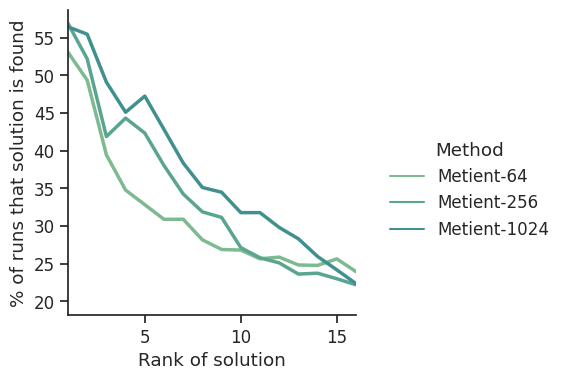

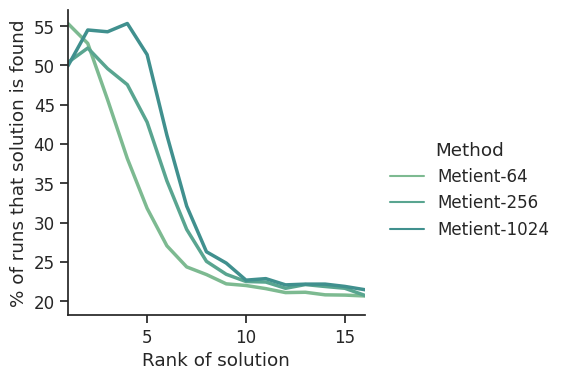

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette("crest")
colors = colors[:len(batch_sizes)]
print(colors)
sns.set_palette(sns.color_palette(colors))

for name,df in zip(["m5", "m8"], [m5_df, m8_df]):
    with sns.plotting_context("notebook", font_scale=1.1):
        g = sns.relplot(
            data=df, x="Rank", y="% runs",
            height=4, aspect=1.0, dashes=False, linewidth=2.5,
            hue="Method", style="Method", kind="line", legend=True,
        )

        (g.set_axis_labels("Rank of solution", "% of runs that solution is found")
          .set_titles("boop")
          .tight_layout(w_pad=0))
        plt.xlim(1,16)
        #sns.move_legend(g, "upper right")
        plt.show()
        

        fig = g.fig
        #out_name = ("_").join(y_labels[i].split(" ") + x.split(" "))
        fig.savefig(os.path.join(REPO_DIR, "test/output_plots", f"{name}_percent_solns_found_{PARAMS}_{DATE}.png"), dpi=600) 


[(0.48942421, 0.72854938, 0.56751036), (0.34892097, 0.64828676, 0.56513633), (0.24929311, 0.56486397, 0.5586654)]


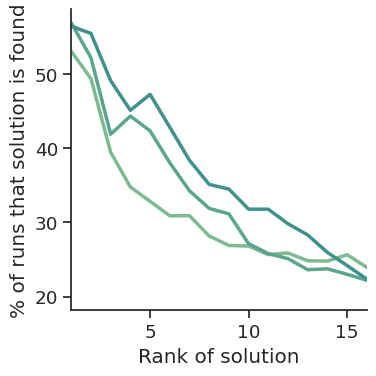

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette("crest")
colors = colors[:len(batch_sizes)]
print(colors)
sns.set_palette(sns.color_palette(colors))

with sns.plotting_context("notebook", font_scale=1.2):
    g = sns.relplot(
        data=all_sites_df, x="Rank", y="% runs",
        height=4, aspect=1.0, dashes=False, linewidth=2.5,
        hue="Method", style="Method", kind="line",  legend=False,
    )

    (g.set_axis_labels("Rank of solution", "% of runs that solution is found")
      .set_titles("boop")
      .tight_layout(w_pad=0))
    plt.xlim(1,16)
    plt.show()


    fig = g.fig
    fig.savefig(os.path.join(REPO_DIR, "test/output_plots", f"all_sites_percent_solns_found_{PARAMS}_{DATE}.png"), dpi=600) 
